In [57]:
import torch 
import torch.nn as nn 
import numpy as np 
import pandas as pd 
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
import copy 
import matplotlib.pyplot as plt 
import tqdm
import ast 


In [58]:
base_dir='/Users/vayungoel/Desktop/opl/scene_maam_audioset_without_opl'
base_mode='scene'
folder_name='location_maam_audioset_without_opl/'

In [59]:
run_mode='location'

In [60]:
data=pd.read_csv("/Users/vayungoel/Desktop/passt/final_hear21_embeddings_finetuned_def_model_train_all_blocks.csv")
test_data=pd.read_csv("/Users/vayungoel/Desktop/passt/final_hear21_embeddings_finetuned_def_model_test_all_blocks.csv")

In [61]:
df=pd.DataFrame()
df['file_name']=test_data['file_name']
df.head()

,file_name
0,airport-barcelona-203-6122-b.wav
1,airport-barcelona-203-6122-s1.wav
2,airport-barcelona-203-6122-s2.wav
3,airport-barcelona-203-6122-s4.wav
4,airport-barcelona-203-6122-s6.wav


In [62]:
lr=0.0001

In [63]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [64]:
acc_list=[]

In [65]:
def train_ready(data,col_name):
    new_list=[]
    for i in range(len(data)):
        temp_list=[]
        x=data[col_name][i]
        tensor_string = x

# Extract the numbers part of the string
        numbers_string = tensor_string.split("[[")[1].split("]]")[0]

# Parse the string into a Python list
        tensor_list = ast.literal_eval("[" + numbers_string + "]")

# Convert the list to a numpy array
        numpy_array = np.array(tensor_list)
        list_data=list(numpy_array)
        
        new_list.append(list_data)
    return new_list

In [66]:
number_of_classes=len(list(np.unique(np.array(data[run_mode]))))
number_of_classes

10

In [67]:
class SceneClassifier(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(SceneClassifier, self).__init__()
    # self.fc1 = nn.Linear(input_dim, int(input_dim/2))  # Hidden layer with half the input dimension
    self.fc2 = nn.Linear(input_dim, 256)        # New hidden layer with 128 neurons
    self.fc3 = nn.Linear(256, output_dim)           # Output layer

  def forward(self, x):
    # x = F.relu(self.fc1(x))  # Apply activation function (ReLU) to first hidden layer output
    emb = F.relu(self.fc2(x))  # Apply activation function (ReLU) to new hidden layer output
    logits = F.log_softmax(self.fc3(emb), dim=1)  # Apply log_softmax for classification
    return logits

input_dim = 768
output_dim = number_of_classes
model = SceneClassifier(input_dim, output_dim).to(device)
# model.to(torch.float32)
total_params = sum(p.numel() for p in model.parameters())
print(total_params)
model.eval()

199434


SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [68]:
y=data[run_mode].tolist()
print(y)
label_array_train = np.array(y).reshape(-1, 1)
encoder=OneHotEncoder()
y_one_hot_encoded = encoder.fit_transform(label_array_train).toarray()
# print(len(y_one_hot_encoded))
y_one_hot_encoded

['barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona', 'barcelona'

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [69]:
y_test=test_data[run_mode].tolist()
label_array_test=np.array(y_test).reshape(-1,1)
encoder=OneHotEncoder()
y_test_one_hot_encoded = encoder.fit_transform(label_array_test).toarray()
y_test_one_hot_encoded

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [70]:
class_names = list(np.unique(y_test))

# Block-1

In [71]:
Block_number=1

In [72]:
model=torch.load(f'{base_dir}/small_model_scene_{Block_number}_opl.pth')

In [73]:
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)

In [74]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [75]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [76]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 10)
(2793, 10)


In [77]:
total_params = sum(p.numel() for p in model.parameters())
print(total_params)

199434


In [78]:
last_layer_params = list(model.parameters())[-2:]  # Assuming the last layer has both weight and bias parameters

# Count the total number of parameters in the last layer
num_params_last_layer = sum(p.numel() for p in last_layer_params)
num_params_last_layer

2570

In [79]:
# for param in model.fc1.parameters():
#     param.requires_grad=False
for param in model.fc2.parameters():
    param.requires_grad = False

In [80]:
nn.init.xavier_uniform_(model.fc3.weight)
nn.init.constant_(model.fc3.bias, 0.0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [81]:
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of trainable parameters:", total_trainable_params)

Total number of trainable parameters: 2570


In [82]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc3.parameters(), lr=lr)

Epoch 0: 100%|██████████| 174/174 [00:00<00:00, 378.57batch/s, acc=0.0781, loss=4.06]


Epoch 0 validation: Cross-entropy=4.21, Accuracy=9.8%


Epoch 1: 100%|██████████| 174/174 [00:00<00:00, 501.25batch/s, acc=0.0938, loss=2.99]


Epoch 1 validation: Cross-entropy=3.06, Accuracy=9.9%


Epoch 2: 100%|██████████| 174/174 [00:00<00:00, 591.03batch/s, acc=0.125, loss=2.46] 


Epoch 2 validation: Cross-entropy=2.48, Accuracy=10.1%


Epoch 3: 100%|██████████| 174/174 [00:00<00:00, 452.54batch/s, acc=0.0781, loss=2.29]


Epoch 3 validation: Cross-entropy=2.30, Accuracy=11.3%


Epoch 4: 100%|██████████| 174/174 [00:00<00:00, 455.44batch/s, acc=0.0938, loss=2.27]


Epoch 4 validation: Cross-entropy=2.28, Accuracy=11.9%


Epoch 5: 100%|██████████| 174/174 [00:00<00:00, 579.16batch/s, acc=0.0781, loss=2.26]


Epoch 5 validation: Cross-entropy=2.28, Accuracy=12.5%


Epoch 6: 100%|██████████| 174/174 [00:00<00:00, 476.83batch/s, acc=0.0781, loss=2.25]


Epoch 6 validation: Cross-entropy=2.27, Accuracy=13.0%


Epoch 7: 100%|██████████| 174/174 [00:00<00:00, 635.45batch/s, acc=0.0781, loss=2.24]


Epoch 7 validation: Cross-entropy=2.27, Accuracy=13.6%


Epoch 8: 100%|██████████| 174/174 [00:00<00:00, 397.89batch/s, acc=0.0938, loss=2.24]


Epoch 8 validation: Cross-entropy=2.27, Accuracy=13.9%


Epoch 9: 100%|██████████| 174/174 [00:00<00:00, 568.01batch/s, acc=0.0781, loss=2.24]


Epoch 9 validation: Cross-entropy=2.27, Accuracy=14.3%


Epoch 10: 100%|██████████| 174/174 [00:00<00:00, 461.75batch/s, acc=0.0781, loss=2.23]


Epoch 10 validation: Cross-entropy=2.27, Accuracy=14.1%


Epoch 11: 100%|██████████| 174/174 [00:00<00:00, 533.00batch/s, acc=0.0781, loss=2.23]


Epoch 11 validation: Cross-entropy=2.27, Accuracy=14.4%


Epoch 12: 100%|██████████| 174/174 [00:00<00:00, 489.49batch/s, acc=0.0781, loss=2.23]


Epoch 12 validation: Cross-entropy=2.26, Accuracy=14.5%


Epoch 13: 100%|██████████| 174/174 [00:00<00:00, 504.99batch/s, acc=0.0781, loss=2.23]


Epoch 13 validation: Cross-entropy=2.26, Accuracy=14.8%


Epoch 14: 100%|██████████| 174/174 [00:00<00:00, 653.08batch/s, acc=0.0781, loss=2.22]


Epoch 14 validation: Cross-entropy=2.26, Accuracy=14.8%


Epoch 15: 100%|██████████| 174/174 [00:00<00:00, 553.69batch/s, acc=0.0781, loss=2.22]


Epoch 15 validation: Cross-entropy=2.26, Accuracy=14.9%


Epoch 16: 100%|██████████| 174/174 [00:00<00:00, 688.12batch/s, acc=0.109, loss=2.22] 


Epoch 16 validation: Cross-entropy=2.26, Accuracy=15.0%


Epoch 17: 100%|██████████| 174/174 [00:00<00:00, 565.00batch/s, acc=0.125, loss=2.22] 


Epoch 17 validation: Cross-entropy=2.26, Accuracy=15.3%


Epoch 18: 100%|██████████| 174/174 [00:00<00:00, 486.97batch/s, acc=0.125, loss=2.22] 


Epoch 18 validation: Cross-entropy=2.26, Accuracy=15.3%


Epoch 19: 100%|██████████| 174/174 [00:00<00:00, 534.83batch/s, acc=0.125, loss=2.22] 


Epoch 19 validation: Cross-entropy=2.26, Accuracy=15.4%


Epoch 20: 100%|██████████| 174/174 [00:00<00:00, 623.50batch/s, acc=0.0938, loss=2.22]


Epoch 20 validation: Cross-entropy=2.26, Accuracy=15.1%


Epoch 21: 100%|██████████| 174/174 [00:00<00:00, 562.33batch/s, acc=0.0938, loss=2.22]


Epoch 21 validation: Cross-entropy=2.26, Accuracy=15.3%


Epoch 22: 100%|██████████| 174/174 [00:00<00:00, 527.95batch/s, acc=0.0938, loss=2.22]


Epoch 22 validation: Cross-entropy=2.26, Accuracy=15.5%


Epoch 23: 100%|██████████| 174/174 [00:00<00:00, 481.87batch/s, acc=0.109, loss=2.22] 


Epoch 23 validation: Cross-entropy=2.26, Accuracy=15.5%


Epoch 24: 100%|██████████| 174/174 [00:00<00:00, 536.29batch/s, acc=0.109, loss=2.22] 


Epoch 24 validation: Cross-entropy=2.26, Accuracy=15.5%


Epoch 25: 100%|██████████| 174/174 [00:00<00:00, 681.53batch/s, acc=0.0938, loss=2.22]


Epoch 25 validation: Cross-entropy=2.26, Accuracy=15.6%


Epoch 26: 100%|██████████| 174/174 [00:00<00:00, 535.33batch/s, acc=0.0938, loss=2.21]


Epoch 26 validation: Cross-entropy=2.26, Accuracy=15.7%


Epoch 27: 100%|██████████| 174/174 [00:00<00:00, 652.54batch/s, acc=0.109, loss=2.21] 


Epoch 27 validation: Cross-entropy=2.26, Accuracy=15.9%


Epoch 28: 100%|██████████| 174/174 [00:00<00:00, 568.34batch/s, acc=0.125, loss=2.21] 


Epoch 28 validation: Cross-entropy=2.26, Accuracy=15.9%


Epoch 29: 100%|██████████| 174/174 [00:00<00:00, 506.78batch/s, acc=0.125, loss=2.21] 


Epoch 29 validation: Cross-entropy=2.26, Accuracy=15.9%


Epoch 30: 100%|██████████| 174/174 [00:00<00:00, 428.83batch/s, acc=0.141, loss=2.21] 


Epoch 30 validation: Cross-entropy=2.25, Accuracy=16.0%


Epoch 31: 100%|██████████| 174/174 [00:00<00:00, 695.36batch/s, acc=0.141, loss=2.21] 


Epoch 31 validation: Cross-entropy=2.25, Accuracy=16.0%


Epoch 32: 100%|██████████| 174/174 [00:00<00:00, 493.12batch/s, acc=0.141, loss=2.21] 


Epoch 32 validation: Cross-entropy=2.25, Accuracy=15.9%


Epoch 33: 100%|██████████| 174/174 [00:00<00:00, 656.07batch/s, acc=0.141, loss=2.21] 


Epoch 33 validation: Cross-entropy=2.25, Accuracy=16.0%


Epoch 34: 100%|██████████| 174/174 [00:00<00:00, 515.36batch/s, acc=0.141, loss=2.21] 


Epoch 34 validation: Cross-entropy=2.25, Accuracy=15.9%


Epoch 35: 100%|██████████| 174/174 [00:00<00:00, 581.52batch/s, acc=0.141, loss=2.21] 


Epoch 35 validation: Cross-entropy=2.25, Accuracy=16.0%


Epoch 36: 100%|██████████| 174/174 [00:00<00:00, 478.54batch/s, acc=0.141, loss=2.21] 


Epoch 36 validation: Cross-entropy=2.25, Accuracy=16.0%


Epoch 37: 100%|██████████| 174/174 [00:00<00:00, 586.25batch/s, acc=0.125, loss=2.21] 


Epoch 37 validation: Cross-entropy=2.25, Accuracy=16.0%


Epoch 38: 100%|██████████| 174/174 [00:00<00:00, 699.35batch/s, acc=0.125, loss=2.21] 


Epoch 38 validation: Cross-entropy=2.25, Accuracy=15.8%


Epoch 39: 100%|██████████| 174/174 [00:00<00:00, 496.19batch/s, acc=0.125, loss=2.21] 


Epoch 39 validation: Cross-entropy=2.25, Accuracy=15.8%


Epoch 40: 100%|██████████| 174/174 [00:00<00:00, 685.52batch/s, acc=0.125, loss=2.21] 


Epoch 40 validation: Cross-entropy=2.25, Accuracy=15.8%


Epoch 41: 100%|██████████| 174/174 [00:00<00:00, 419.70batch/s, acc=0.109, loss=2.21] 


Epoch 41 validation: Cross-entropy=2.25, Accuracy=15.9%


Epoch 42: 100%|██████████| 174/174 [00:00<00:00, 698.56batch/s, acc=0.109, loss=2.21] 


Epoch 42 validation: Cross-entropy=2.25, Accuracy=16.0%


Epoch 43: 100%|██████████| 174/174 [00:00<00:00, 466.74batch/s, acc=0.109, loss=2.21] 


Epoch 43 validation: Cross-entropy=2.25, Accuracy=15.9%


Epoch 44: 100%|██████████| 174/174 [00:00<00:00, 534.22batch/s, acc=0.109, loss=2.21] 


Epoch 44 validation: Cross-entropy=2.25, Accuracy=15.9%


Epoch 45: 100%|██████████| 174/174 [00:00<00:00, 634.05batch/s, acc=0.109, loss=2.21] 


Epoch 45 validation: Cross-entropy=2.25, Accuracy=15.9%


Epoch 46: 100%|██████████| 174/174 [00:00<00:00, 575.87batch/s, acc=0.109, loss=2.21] 


Epoch 46 validation: Cross-entropy=2.25, Accuracy=16.0%


Epoch 47: 100%|██████████| 174/174 [00:00<00:00, 427.13batch/s, acc=0.109, loss=2.21] 


Epoch 47 validation: Cross-entropy=2.25, Accuracy=16.0%


Epoch 48: 100%|██████████| 174/174 [00:00<00:00, 566.18batch/s, acc=0.109, loss=2.21] 


Epoch 48 validation: Cross-entropy=2.25, Accuracy=16.0%


Epoch 49: 100%|██████████| 174/174 [00:00<00:00, 560.95batch/s, acc=0.109, loss=2.21] 


Epoch 49 validation: Cross-entropy=2.25, Accuracy=16.0%


Epoch 50: 100%|██████████| 174/174 [00:00<00:00, 631.67batch/s, acc=0.109, loss=2.21] 


Epoch 50 validation: Cross-entropy=2.25, Accuracy=15.9%


Epoch 51: 100%|██████████| 174/174 [00:00<00:00, 572.79batch/s, acc=0.109, loss=2.21] 


Epoch 51 validation: Cross-entropy=2.25, Accuracy=15.9%


Epoch 52: 100%|██████████| 174/174 [00:00<00:00, 408.22batch/s, acc=0.109, loss=2.21] 


Epoch 52 validation: Cross-entropy=2.25, Accuracy=15.8%


Epoch 53: 100%|██████████| 174/174 [00:00<00:00, 644.72batch/s, acc=0.109, loss=2.21] 


Epoch 53 validation: Cross-entropy=2.25, Accuracy=15.8%


Epoch 54: 100%|██████████| 174/174 [00:00<00:00, 545.78batch/s, acc=0.109, loss=2.21] 


Epoch 54 validation: Cross-entropy=2.25, Accuracy=15.8%


Epoch 55: 100%|██████████| 174/174 [00:00<00:00, 671.62batch/s, acc=0.109, loss=2.21] 


Epoch 55 validation: Cross-entropy=2.25, Accuracy=15.8%


Epoch 56: 100%|██████████| 174/174 [00:00<00:00, 487.97batch/s, acc=0.109, loss=2.21] 


Epoch 56 validation: Cross-entropy=2.25, Accuracy=15.8%


Epoch 57: 100%|██████████| 174/174 [00:00<00:00, 518.65batch/s, acc=0.109, loss=2.21] 


Epoch 57 validation: Cross-entropy=2.25, Accuracy=15.8%


Epoch 58: 100%|██████████| 174/174 [00:00<00:00, 468.21batch/s, acc=0.109, loss=2.21] 


Epoch 58 validation: Cross-entropy=2.25, Accuracy=15.7%


Epoch 59: 100%|██████████| 174/174 [00:00<00:00, 507.08batch/s, acc=0.109, loss=2.21] 


Epoch 59 validation: Cross-entropy=2.25, Accuracy=15.8%


Epoch 60: 100%|██████████| 174/174 [00:00<00:00, 660.40batch/s, acc=0.109, loss=2.21] 


Epoch 60 validation: Cross-entropy=2.25, Accuracy=15.8%


Epoch 61: 100%|██████████| 174/174 [00:00<00:00, 492.69batch/s, acc=0.109, loss=2.21] 


Epoch 61 validation: Cross-entropy=2.25, Accuracy=15.9%


Epoch 62: 100%|██████████| 174/174 [00:00<00:00, 500.29batch/s, acc=0.109, loss=2.21] 


Epoch 62 validation: Cross-entropy=2.25, Accuracy=16.0%


Epoch 63: 100%|██████████| 174/174 [00:00<00:00, 593.96batch/s, acc=0.109, loss=2.21] 


Epoch 63 validation: Cross-entropy=2.25, Accuracy=15.9%


Epoch 64: 100%|██████████| 174/174 [00:00<00:00, 431.08batch/s, acc=0.109, loss=2.21] 


Epoch 64 validation: Cross-entropy=2.25, Accuracy=15.9%


Epoch 65: 100%|██████████| 174/174 [00:00<00:00, 518.74batch/s, acc=0.109, loss=2.21] 


Epoch 65 validation: Cross-entropy=2.25, Accuracy=15.8%


Epoch 66: 100%|██████████| 174/174 [00:00<00:00, 584.06batch/s, acc=0.109, loss=2.21] 


Epoch 66 validation: Cross-entropy=2.25, Accuracy=15.8%


Epoch 67: 100%|██████████| 174/174 [00:00<00:00, 495.44batch/s, acc=0.109, loss=2.21] 


Epoch 67 validation: Cross-entropy=2.25, Accuracy=15.8%


Epoch 68: 100%|██████████| 174/174 [00:00<00:00, 581.51batch/s, acc=0.109, loss=2.21] 


Epoch 68 validation: Cross-entropy=2.25, Accuracy=15.8%


Epoch 69: 100%|██████████| 174/174 [00:00<00:00, 407.90batch/s, acc=0.109, loss=2.21] 


Epoch 69 validation: Cross-entropy=2.25, Accuracy=15.8%


Epoch 70: 100%|██████████| 174/174 [00:00<00:00, 581.19batch/s, acc=0.109, loss=2.21] 


Epoch 70 validation: Cross-entropy=2.25, Accuracy=15.8%


Epoch 71: 100%|██████████| 174/174 [00:00<00:00, 494.24batch/s, acc=0.109, loss=2.21] 


Epoch 71 validation: Cross-entropy=2.24, Accuracy=15.8%


Epoch 72: 100%|██████████| 174/174 [00:00<00:00, 626.00batch/s, acc=0.109, loss=2.21] 


Epoch 72 validation: Cross-entropy=2.24, Accuracy=15.7%


Epoch 73: 100%|██████████| 174/174 [00:00<00:00, 492.99batch/s, acc=0.109, loss=2.21] 


Epoch 73 validation: Cross-entropy=2.24, Accuracy=15.8%


Epoch 74: 100%|██████████| 174/174 [00:00<00:00, 528.62batch/s, acc=0.109, loss=2.21] 


Epoch 74 validation: Cross-entropy=2.24, Accuracy=15.8%


Epoch 75: 100%|██████████| 174/174 [00:00<00:00, 456.85batch/s, acc=0.109, loss=2.21] 


Epoch 75 validation: Cross-entropy=2.24, Accuracy=15.8%


Epoch 76: 100%|██████████| 174/174 [00:00<00:00, 692.24batch/s, acc=0.109, loss=2.21] 


Epoch 76 validation: Cross-entropy=2.24, Accuracy=15.8%


Epoch 77: 100%|██████████| 174/174 [00:00<00:00, 497.89batch/s, acc=0.109, loss=2.21] 


Epoch 77 validation: Cross-entropy=2.24, Accuracy=15.6%


Epoch 78: 100%|██████████| 174/174 [00:00<00:00, 559.55batch/s, acc=0.109, loss=2.21] 


Epoch 78 validation: Cross-entropy=2.24, Accuracy=15.7%


Epoch 79: 100%|██████████| 174/174 [00:00<00:00, 451.94batch/s, acc=0.0938, loss=2.21]


Epoch 79 validation: Cross-entropy=2.24, Accuracy=15.7%


Epoch 80: 100%|██████████| 174/174 [00:00<00:00, 553.86batch/s, acc=0.0938, loss=2.21]


Epoch 80 validation: Cross-entropy=2.24, Accuracy=15.8%


Epoch 81: 100%|██████████| 174/174 [00:00<00:00, 570.77batch/s, acc=0.0781, loss=2.21]


Epoch 81 validation: Cross-entropy=2.24, Accuracy=15.9%


Epoch 82: 100%|██████████| 174/174 [00:00<00:00, 638.86batch/s, acc=0.0781, loss=2.21]


Epoch 82 validation: Cross-entropy=2.24, Accuracy=15.9%


Epoch 83: 100%|██████████| 174/174 [00:00<00:00, 694.61batch/s, acc=0.0781, loss=2.21]


Epoch 83 validation: Cross-entropy=2.24, Accuracy=15.9%


Epoch 84: 100%|██████████| 174/174 [00:00<00:00, 588.90batch/s, acc=0.0781, loss=2.21]


Epoch 84 validation: Cross-entropy=2.24, Accuracy=15.8%


Epoch 85: 100%|██████████| 174/174 [00:00<00:00, 732.95batch/s, acc=0.0781, loss=2.21]


Epoch 85 validation: Cross-entropy=2.24, Accuracy=15.8%


Epoch 86: 100%|██████████| 174/174 [00:00<00:00, 501.94batch/s, acc=0.0781, loss=2.21]


Epoch 86 validation: Cross-entropy=2.24, Accuracy=15.8%


Epoch 87: 100%|██████████| 174/174 [00:00<00:00, 717.42batch/s, acc=0.0781, loss=2.21]


Epoch 87 validation: Cross-entropy=2.24, Accuracy=15.8%


Epoch 88: 100%|██████████| 174/174 [00:00<00:00, 585.65batch/s, acc=0.0781, loss=2.21]


Epoch 88 validation: Cross-entropy=2.24, Accuracy=15.8%


Epoch 89: 100%|██████████| 174/174 [00:00<00:00, 717.50batch/s, acc=0.0781, loss=2.21]


Epoch 89 validation: Cross-entropy=2.24, Accuracy=15.8%


Epoch 90: 100%|██████████| 174/174 [00:00<00:00, 605.94batch/s, acc=0.0781, loss=2.21]


Epoch 90 validation: Cross-entropy=2.24, Accuracy=15.8%


Epoch 91: 100%|██████████| 174/174 [00:00<00:00, 716.24batch/s, acc=0.0781, loss=2.21]


Epoch 91 validation: Cross-entropy=2.24, Accuracy=15.8%


Epoch 92: 100%|██████████| 174/174 [00:00<00:00, 582.41batch/s, acc=0.0781, loss=2.21]


Epoch 92 validation: Cross-entropy=2.24, Accuracy=15.9%


Epoch 93: 100%|██████████| 174/174 [00:00<00:00, 527.84batch/s, acc=0.0781, loss=2.21]


Epoch 93 validation: Cross-entropy=2.24, Accuracy=15.9%


Epoch 94: 100%|██████████| 174/174 [00:00<00:00, 523.87batch/s, acc=0.0781, loss=2.21]


Epoch 94 validation: Cross-entropy=2.24, Accuracy=15.9%


Epoch 95: 100%|██████████| 174/174 [00:00<00:00, 709.73batch/s, acc=0.0781, loss=2.21]


Epoch 95 validation: Cross-entropy=2.24, Accuracy=15.9%


Epoch 96: 100%|██████████| 174/174 [00:00<00:00, 583.39batch/s, acc=0.0781, loss=2.21]


Epoch 96 validation: Cross-entropy=2.24, Accuracy=16.0%


Epoch 97: 100%|██████████| 174/174 [00:00<00:00, 737.53batch/s, acc=0.0781, loss=2.21]


Epoch 97 validation: Cross-entropy=2.24, Accuracy=16.0%


Epoch 98: 100%|██████████| 174/174 [00:00<00:00, 490.68batch/s, acc=0.0781, loss=2.21]


Epoch 98 validation: Cross-entropy=2.24, Accuracy=16.0%


Epoch 99: 100%|██████████| 174/174 [00:00<00:00, 734.40batch/s, acc=0.0781, loss=2.21]


Epoch 99 validation: Cross-entropy=2.24, Accuracy=16.1%


Epoch 100: 100%|██████████| 174/174 [00:00<00:00, 592.12batch/s, acc=0.0781, loss=2.21]


Epoch 100 validation: Cross-entropy=2.24, Accuracy=16.1%


Epoch 101: 100%|██████████| 174/174 [00:00<00:00, 596.94batch/s, acc=0.0781, loss=2.21]


Epoch 101 validation: Cross-entropy=2.24, Accuracy=16.1%


Epoch 102: 100%|██████████| 174/174 [00:00<00:00, 675.57batch/s, acc=0.0781, loss=2.21]


Epoch 102 validation: Cross-entropy=2.24, Accuracy=16.1%


Epoch 103: 100%|██████████| 174/174 [00:00<00:00, 505.43batch/s, acc=0.0781, loss=2.21]


Epoch 103 validation: Cross-entropy=2.24, Accuracy=16.1%


Epoch 104: 100%|██████████| 174/174 [00:00<00:00, 465.99batch/s, acc=0.0781, loss=2.21]


Epoch 104 validation: Cross-entropy=2.24, Accuracy=16.1%


Epoch 105: 100%|██████████| 174/174 [00:00<00:00, 434.22batch/s, acc=0.0781, loss=2.21]


Epoch 105 validation: Cross-entropy=2.24, Accuracy=16.1%


Epoch 106: 100%|██████████| 174/174 [00:00<00:00, 521.34batch/s, acc=0.0781, loss=2.21]


Epoch 106 validation: Cross-entropy=2.24, Accuracy=16.1%


Epoch 107: 100%|██████████| 174/174 [00:00<00:00, 582.87batch/s, acc=0.0781, loss=2.21]


Epoch 107 validation: Cross-entropy=2.24, Accuracy=16.0%


Epoch 108: 100%|██████████| 174/174 [00:00<00:00, 540.11batch/s, acc=0.0781, loss=2.21]


Epoch 108 validation: Cross-entropy=2.24, Accuracy=16.0%


Epoch 109: 100%|██████████| 174/174 [00:00<00:00, 486.25batch/s, acc=0.0781, loss=2.21]


Epoch 109 validation: Cross-entropy=2.24, Accuracy=16.0%


Epoch 110: 100%|██████████| 174/174 [00:00<00:00, 671.20batch/s, acc=0.0781, loss=2.21]


Epoch 110 validation: Cross-entropy=2.24, Accuracy=16.0%


Epoch 111: 100%|██████████| 174/174 [00:00<00:00, 458.27batch/s, acc=0.0781, loss=2.21]


Epoch 111 validation: Cross-entropy=2.24, Accuracy=16.0%


Epoch 112: 100%|██████████| 174/174 [00:00<00:00, 668.59batch/s, acc=0.0781, loss=2.21]


Epoch 112 validation: Cross-entropy=2.24, Accuracy=16.0%


Epoch 113: 100%|██████████| 174/174 [00:00<00:00, 545.93batch/s, acc=0.0781, loss=2.21]


Epoch 113 validation: Cross-entropy=2.24, Accuracy=16.0%


Epoch 114: 100%|██████████| 174/174 [00:00<00:00, 454.00batch/s, acc=0.0781, loss=2.21]


Epoch 114 validation: Cross-entropy=2.24, Accuracy=16.0%


Epoch 115: 100%|██████████| 174/174 [00:00<00:00, 482.33batch/s, acc=0.0781, loss=2.21]


Epoch 115 validation: Cross-entropy=2.24, Accuracy=16.0%


Epoch 116: 100%|██████████| 174/174 [00:00<00:00, 647.68batch/s, acc=0.0781, loss=2.21]


Epoch 116 validation: Cross-entropy=2.24, Accuracy=16.0%


Epoch 117: 100%|██████████| 174/174 [00:00<00:00, 494.03batch/s, acc=0.0781, loss=2.21]


Epoch 117 validation: Cross-entropy=2.24, Accuracy=16.1%


Epoch 118: 100%|██████████| 174/174 [00:00<00:00, 689.63batch/s, acc=0.0781, loss=2.21]


Epoch 118 validation: Cross-entropy=2.24, Accuracy=16.1%


Epoch 119: 100%|██████████| 174/174 [00:00<00:00, 671.46batch/s, acc=0.0781, loss=2.21]


Epoch 119 validation: Cross-entropy=2.24, Accuracy=16.1%


Epoch 120: 100%|██████████| 174/174 [00:00<00:00, 448.46batch/s, acc=0.0781, loss=2.21]


Epoch 120 validation: Cross-entropy=2.24, Accuracy=16.1%


Epoch 121: 100%|██████████| 174/174 [00:00<00:00, 588.31batch/s, acc=0.0781, loss=2.21]


Epoch 121 validation: Cross-entropy=2.24, Accuracy=16.1%


Epoch 122: 100%|██████████| 174/174 [00:00<00:00, 508.09batch/s, acc=0.0781, loss=2.21]


Epoch 122 validation: Cross-entropy=2.24, Accuracy=16.1%


Epoch 123: 100%|██████████| 174/174 [00:00<00:00, 613.42batch/s, acc=0.0781, loss=2.21]


Epoch 123 validation: Cross-entropy=2.24, Accuracy=16.1%


Epoch 124: 100%|██████████| 174/174 [00:00<00:00, 515.51batch/s, acc=0.0781, loss=2.21]


Epoch 124 validation: Cross-entropy=2.24, Accuracy=16.2%


Epoch 125: 100%|██████████| 174/174 [00:00<00:00, 596.82batch/s, acc=0.0781, loss=2.21]


Epoch 125 validation: Cross-entropy=2.24, Accuracy=16.2%


Epoch 126: 100%|██████████| 174/174 [00:00<00:00, 455.77batch/s, acc=0.0781, loss=2.21]


Epoch 126 validation: Cross-entropy=2.24, Accuracy=16.2%


Epoch 127: 100%|██████████| 174/174 [00:00<00:00, 646.29batch/s, acc=0.0781, loss=2.21]


Epoch 127 validation: Cross-entropy=2.24, Accuracy=16.2%


Epoch 128: 100%|██████████| 174/174 [00:00<00:00, 573.97batch/s, acc=0.0781, loss=2.21]


Epoch 128 validation: Cross-entropy=2.24, Accuracy=16.3%


Epoch 129: 100%|██████████| 174/174 [00:00<00:00, 557.73batch/s, acc=0.0781, loss=2.21]


Epoch 129 validation: Cross-entropy=2.24, Accuracy=16.3%


Epoch 130: 100%|██████████| 174/174 [00:00<00:00, 602.28batch/s, acc=0.0781, loss=2.21]


Epoch 130 validation: Cross-entropy=2.24, Accuracy=16.3%


Epoch 131: 100%|██████████| 174/174 [00:00<00:00, 456.57batch/s, acc=0.0781, loss=2.21]


Epoch 131 validation: Cross-entropy=2.24, Accuracy=16.3%


Epoch 132: 100%|██████████| 174/174 [00:00<00:00, 490.86batch/s, acc=0.0781, loss=2.21]


Epoch 132 validation: Cross-entropy=2.24, Accuracy=16.3%


Epoch 133: 100%|██████████| 174/174 [00:00<00:00, 488.12batch/s, acc=0.0781, loss=2.21]


Epoch 133 validation: Cross-entropy=2.24, Accuracy=16.3%


Epoch 134: 100%|██████████| 174/174 [00:00<00:00, 648.83batch/s, acc=0.0781, loss=2.21]


Epoch 134 validation: Cross-entropy=2.24, Accuracy=16.2%


Epoch 135: 100%|██████████| 174/174 [00:00<00:00, 537.94batch/s, acc=0.0781, loss=2.21]


Epoch 135 validation: Cross-entropy=2.24, Accuracy=16.2%


Epoch 136: 100%|██████████| 174/174 [00:00<00:00, 656.73batch/s, acc=0.0625, loss=2.21]


Epoch 136 validation: Cross-entropy=2.24, Accuracy=16.2%


Epoch 137: 100%|██████████| 174/174 [00:00<00:00, 554.83batch/s, acc=0.0625, loss=2.21]


Epoch 137 validation: Cross-entropy=2.24, Accuracy=16.1%


Epoch 138: 100%|██████████| 174/174 [00:00<00:00, 419.25batch/s, acc=0.0625, loss=2.21]


Epoch 138 validation: Cross-entropy=2.24, Accuracy=16.1%


Epoch 139: 100%|██████████| 174/174 [00:00<00:00, 704.74batch/s, acc=0.0625, loss=2.21]


Epoch 139 validation: Cross-entropy=2.24, Accuracy=16.1%


Epoch 140: 100%|██████████| 174/174 [00:00<00:00, 515.58batch/s, acc=0.0625, loss=2.21]


Epoch 140 validation: Cross-entropy=2.24, Accuracy=16.2%


Epoch 141: 100%|██████████| 174/174 [00:00<00:00, 547.22batch/s, acc=0.0625, loss=2.21]


Epoch 141 validation: Cross-entropy=2.24, Accuracy=16.2%


Epoch 142: 100%|██████████| 174/174 [00:00<00:00, 601.60batch/s, acc=0.0625, loss=2.21]


Epoch 142 validation: Cross-entropy=2.24, Accuracy=16.2%


Epoch 143: 100%|██████████| 174/174 [00:00<00:00, 435.17batch/s, acc=0.0625, loss=2.21]


Epoch 143 validation: Cross-entropy=2.24, Accuracy=16.2%


Epoch 144: 100%|██████████| 174/174 [00:00<00:00, 612.05batch/s, acc=0.0625, loss=2.21]


Epoch 144 validation: Cross-entropy=2.24, Accuracy=16.2%


Epoch 145: 100%|██████████| 174/174 [00:00<00:00, 506.78batch/s, acc=0.0625, loss=2.21]


Epoch 145 validation: Cross-entropy=2.24, Accuracy=16.2%


Epoch 146: 100%|██████████| 174/174 [00:00<00:00, 475.67batch/s, acc=0.0625, loss=2.21]


Epoch 146 validation: Cross-entropy=2.24, Accuracy=16.2%


Epoch 147: 100%|██████████| 174/174 [00:00<00:00, 619.93batch/s, acc=0.0625, loss=2.21]


Epoch 147 validation: Cross-entropy=2.24, Accuracy=16.2%


Epoch 148: 100%|██████████| 174/174 [00:00<00:00, 454.84batch/s, acc=0.0625, loss=2.21]


Epoch 148 validation: Cross-entropy=2.24, Accuracy=16.2%


Epoch 149: 100%|██████████| 174/174 [00:00<00:00, 393.82batch/s, acc=0.0625, loss=2.21]


Epoch 149 validation: Cross-entropy=2.24, Accuracy=16.2%


Epoch 150: 100%|██████████| 174/174 [00:00<00:00, 563.52batch/s, acc=0.0625, loss=2.21]


Epoch 150 validation: Cross-entropy=2.24, Accuracy=16.2%


Epoch 151: 100%|██████████| 174/174 [00:00<00:00, 490.04batch/s, acc=0.0625, loss=2.21]


Epoch 151 validation: Cross-entropy=2.24, Accuracy=16.2%


Epoch 152: 100%|██████████| 174/174 [00:00<00:00, 496.77batch/s, acc=0.0625, loss=2.21]


Epoch 152 validation: Cross-entropy=2.24, Accuracy=16.2%


Epoch 153: 100%|██████████| 174/174 [00:00<00:00, 478.15batch/s, acc=0.0625, loss=2.21]


Epoch 153 validation: Cross-entropy=2.24, Accuracy=16.2%


Epoch 154: 100%|██████████| 174/174 [00:00<00:00, 555.87batch/s, acc=0.0625, loss=2.21]


Epoch 154 validation: Cross-entropy=2.24, Accuracy=16.3%


Epoch 155: 100%|██████████| 174/174 [00:00<00:00, 502.62batch/s, acc=0.0625, loss=2.21]


Epoch 155 validation: Cross-entropy=2.24, Accuracy=16.3%


Epoch 156: 100%|██████████| 174/174 [00:00<00:00, 618.39batch/s, acc=0.0625, loss=2.21]


Epoch 156 validation: Cross-entropy=2.24, Accuracy=16.3%


Epoch 157: 100%|██████████| 174/174 [00:00<00:00, 527.52batch/s, acc=0.0625, loss=2.21]


Epoch 157 validation: Cross-entropy=2.24, Accuracy=16.3%


Epoch 158: 100%|██████████| 174/174 [00:00<00:00, 685.16batch/s, acc=0.0625, loss=2.21]


Epoch 158 validation: Cross-entropy=2.24, Accuracy=16.3%


Epoch 159: 100%|██████████| 174/174 [00:00<00:00, 493.83batch/s, acc=0.0625, loss=2.21]


Epoch 159 validation: Cross-entropy=2.24, Accuracy=16.4%


Epoch 160: 100%|██████████| 174/174 [00:00<00:00, 521.12batch/s, acc=0.0625, loss=2.21]


Epoch 160 validation: Cross-entropy=2.24, Accuracy=16.4%


Epoch 161: 100%|██████████| 174/174 [00:00<00:00, 585.91batch/s, acc=0.0625, loss=2.21]


Epoch 161 validation: Cross-entropy=2.24, Accuracy=16.4%


Epoch 162: 100%|██████████| 174/174 [00:00<00:00, 481.28batch/s, acc=0.0625, loss=2.21]


Epoch 162 validation: Cross-entropy=2.24, Accuracy=16.4%


Epoch 163: 100%|██████████| 174/174 [00:00<00:00, 568.26batch/s, acc=0.0625, loss=2.21]


Epoch 163 validation: Cross-entropy=2.24, Accuracy=16.3%


Epoch 164: 100%|██████████| 174/174 [00:00<00:00, 487.68batch/s, acc=0.0625, loss=2.21]


Epoch 164 validation: Cross-entropy=2.24, Accuracy=16.4%


Epoch 165: 100%|██████████| 174/174 [00:00<00:00, 585.05batch/s, acc=0.0625, loss=2.21]


Epoch 165 validation: Cross-entropy=2.24, Accuracy=16.4%


Epoch 166: 100%|██████████| 174/174 [00:00<00:00, 434.82batch/s, acc=0.0625, loss=2.21]


Epoch 166 validation: Cross-entropy=2.24, Accuracy=16.4%


Epoch 167: 100%|██████████| 174/174 [00:00<00:00, 537.17batch/s, acc=0.0625, loss=2.21]


Epoch 167 validation: Cross-entropy=2.24, Accuracy=16.4%


Epoch 168: 100%|██████████| 174/174 [00:00<00:00, 450.55batch/s, acc=0.0625, loss=2.21]


Epoch 168 validation: Cross-entropy=2.24, Accuracy=16.5%


Epoch 169: 100%|██████████| 174/174 [00:00<00:00, 559.74batch/s, acc=0.0625, loss=2.21]


Epoch 169 validation: Cross-entropy=2.24, Accuracy=16.5%


Epoch 170: 100%|██████████| 174/174 [00:00<00:00, 503.54batch/s, acc=0.0625, loss=2.21]


Epoch 170 validation: Cross-entropy=2.24, Accuracy=16.5%


Epoch 171: 100%|██████████| 174/174 [00:00<00:00, 599.94batch/s, acc=0.0625, loss=2.21]


Epoch 171 validation: Cross-entropy=2.24, Accuracy=16.4%


Epoch 172: 100%|██████████| 174/174 [00:00<00:00, 378.31batch/s, acc=0.0625, loss=2.21]


Epoch 172 validation: Cross-entropy=2.24, Accuracy=16.4%


Epoch 173: 100%|██████████| 174/174 [00:00<00:00, 643.51batch/s, acc=0.0625, loss=2.21]


Epoch 173 validation: Cross-entropy=2.24, Accuracy=16.4%


Epoch 174: 100%|██████████| 174/174 [00:00<00:00, 489.74batch/s, acc=0.0625, loss=2.21]


Epoch 174 validation: Cross-entropy=2.24, Accuracy=16.4%


Epoch 175: 100%|██████████| 174/174 [00:00<00:00, 559.45batch/s, acc=0.0625, loss=2.21]


Epoch 175 validation: Cross-entropy=2.24, Accuracy=16.4%


Epoch 176: 100%|██████████| 174/174 [00:00<00:00, 526.59batch/s, acc=0.0625, loss=2.21]


Epoch 176 validation: Cross-entropy=2.24, Accuracy=16.4%


Epoch 177: 100%|██████████| 174/174 [00:00<00:00, 663.00batch/s, acc=0.0625, loss=2.21]


Epoch 177 validation: Cross-entropy=2.24, Accuracy=16.4%


Epoch 178: 100%|██████████| 174/174 [00:00<00:00, 695.65batch/s, acc=0.0625, loss=2.21]


Epoch 178 validation: Cross-entropy=2.24, Accuracy=16.4%


Epoch 179: 100%|██████████| 174/174 [00:00<00:00, 424.42batch/s, acc=0.0625, loss=2.21]


Epoch 179 validation: Cross-entropy=2.24, Accuracy=16.4%


Epoch 180: 100%|██████████| 174/174 [00:00<00:00, 603.50batch/s, acc=0.0625, loss=2.21]


Epoch 180 validation: Cross-entropy=2.24, Accuracy=16.4%


Epoch 181: 100%|██████████| 174/174 [00:00<00:00, 469.98batch/s, acc=0.0625, loss=2.21]


Epoch 181 validation: Cross-entropy=2.24, Accuracy=16.4%


Epoch 182: 100%|██████████| 174/174 [00:00<00:00, 623.55batch/s, acc=0.0625, loss=2.21]


Epoch 182 validation: Cross-entropy=2.24, Accuracy=16.4%


Epoch 183: 100%|██████████| 174/174 [00:00<00:00, 471.41batch/s, acc=0.0625, loss=2.21]


Epoch 183 validation: Cross-entropy=2.24, Accuracy=16.4%


Epoch 184: 100%|██████████| 174/174 [00:00<00:00, 565.09batch/s, acc=0.0625, loss=2.21]


Epoch 184 validation: Cross-entropy=2.24, Accuracy=16.4%


Epoch 185: 100%|██████████| 174/174 [00:00<00:00, 416.88batch/s, acc=0.0625, loss=2.21]


Epoch 185 validation: Cross-entropy=2.24, Accuracy=16.3%


Epoch 186: 100%|██████████| 174/174 [00:00<00:00, 570.65batch/s, acc=0.0625, loss=2.21]


Epoch 186 validation: Cross-entropy=2.24, Accuracy=16.3%


Epoch 187: 100%|██████████| 174/174 [00:00<00:00, 446.14batch/s, acc=0.0625, loss=2.21]


Epoch 187 validation: Cross-entropy=2.24, Accuracy=16.3%


Epoch 188: 100%|██████████| 174/174 [00:00<00:00, 555.88batch/s, acc=0.0625, loss=2.21]


Epoch 188 validation: Cross-entropy=2.24, Accuracy=16.3%


Epoch 189: 100%|██████████| 174/174 [00:00<00:00, 464.87batch/s, acc=0.0625, loss=2.21]


Epoch 189 validation: Cross-entropy=2.24, Accuracy=16.3%


Epoch 190: 100%|██████████| 174/174 [00:00<00:00, 583.90batch/s, acc=0.0625, loss=2.21]


Epoch 190 validation: Cross-entropy=2.24, Accuracy=16.3%


Epoch 191: 100%|██████████| 174/174 [00:00<00:00, 437.36batch/s, acc=0.0625, loss=2.21]


Epoch 191 validation: Cross-entropy=2.24, Accuracy=16.2%


Epoch 192: 100%|██████████| 174/174 [00:00<00:00, 490.04batch/s, acc=0.0625, loss=2.21]


Epoch 192 validation: Cross-entropy=2.24, Accuracy=16.2%


Epoch 193: 100%|██████████| 174/174 [00:00<00:00, 553.28batch/s, acc=0.0625, loss=2.21]


Epoch 193 validation: Cross-entropy=2.24, Accuracy=16.2%


Epoch 194: 100%|██████████| 174/174 [00:00<00:00, 621.36batch/s, acc=0.0625, loss=2.21]


Epoch 194 validation: Cross-entropy=2.24, Accuracy=16.2%


Epoch 195: 100%|██████████| 174/174 [00:00<00:00, 466.95batch/s, acc=0.0625, loss=2.21]


Epoch 195 validation: Cross-entropy=2.24, Accuracy=16.1%


Epoch 196: 100%|██████████| 174/174 [00:00<00:00, 614.26batch/s, acc=0.0625, loss=2.21]


Epoch 196 validation: Cross-entropy=2.24, Accuracy=16.1%


Epoch 197: 100%|██████████| 174/174 [00:00<00:00, 521.15batch/s, acc=0.0625, loss=2.21]


Epoch 197 validation: Cross-entropy=2.24, Accuracy=16.1%


Epoch 198: 100%|██████████| 174/174 [00:00<00:00, 604.18batch/s, acc=0.0625, loss=2.21]


Epoch 198 validation: Cross-entropy=2.24, Accuracy=16.0%


Epoch 199: 100%|██████████| 174/174 [00:00<00:00, 407.11batch/s, acc=0.0625, loss=2.21]


Epoch 199 validation: Cross-entropy=2.24, Accuracy=16.1%


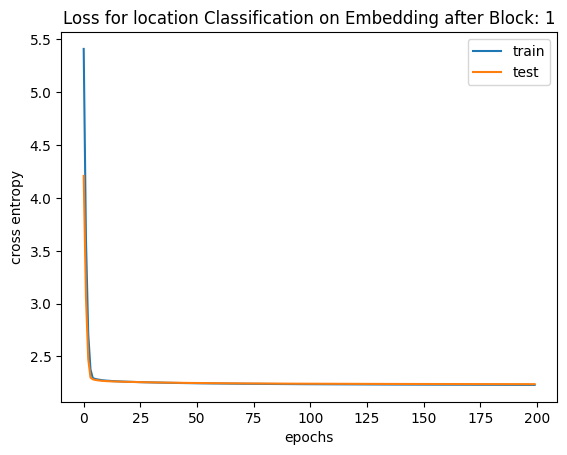

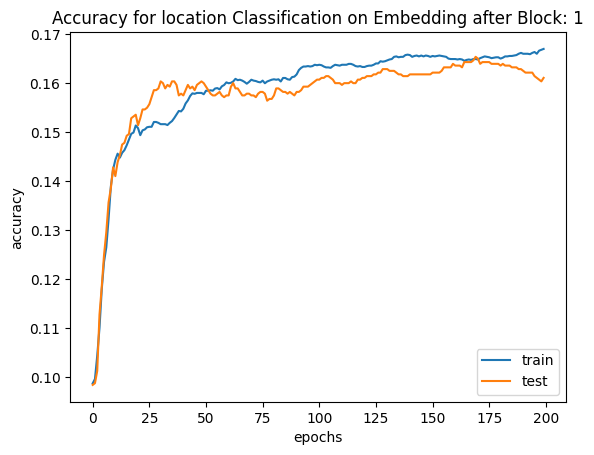

In [83]:
n_epochs = 200
batch_size = 64
batches_per_epoch = len(X_train) // batch_size

# Freeze the parameters of the rest of the model
for param in model.parameters():
    param.requires_grad = False

# Allow the parameters of the final layer to be updated during training
for param in model.fc3.parameters():
    param.requires_grad = True

best_loss = np.inf  # Initialize to infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []

# Define the optimizer to update only the parameters of the final layer
# optimizer = torch.optim.SGD(model.layer3.parameters(), lr=0.001)

# Training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    
    # Set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # Take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            # Forward pass
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Update weights
            optimizer.step()

            # Compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # Set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)
        y_val_batch = y_val_tensor.to(device)
        y_pred = model(X_test_batch)
        ce = criterion(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if ce < best_loss:
        best_loss = ce
        best_weights = copy.deepcopy(model.state_dict())

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

# Load the best weights and plot the results
model.load_state_dict(best_weights)

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()


In [84]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [85]:
torch.save(model, fr'{folder_name}{run_mode}_{Block_number}.pth')

In [86]:
model=torch.load(fr'{folder_name}{run_mode}_{Block_number}.pth')
model.to(device)

SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [87]:
X_test=train_ready(test_data,col_name)

In [88]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        output = model(feature.unsqueeze(0))
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred

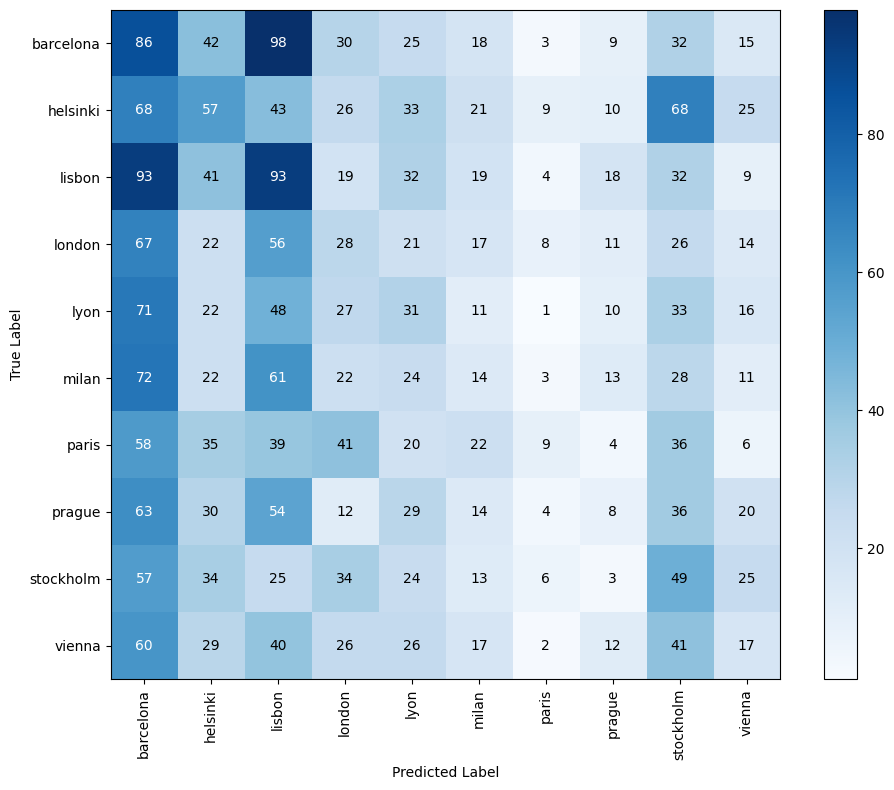

Accuracy: 0.1321


In [89]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)
# loss_list.append()

# Block-2

In [90]:
Block_number=2

In [91]:
model=torch.load(f'{base_dir}/small_model_scene_{Block_number}_opl.pth')

In [92]:
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)

In [93]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [94]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [95]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 10)
(2793, 10)


In [96]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters are {total_params}")
last_layer_params = list(model.parameters())[-2:]  # Assuming the last layer has both weight and bias parameters

# Count the total number of parameters in the last layer
num_params_last_layer = sum(p.numel() for p in last_layer_params)
print(f"Number of parameters in the last layer is {num_params_last_layer}")

Total number of paramerters are 199434
Number of parameters in the last layer is 2570


In [97]:
# for param in model.fc1.parameters():
#     param.requires_grad=False
for param in model.fc2.parameters():
    param.requires_grad = False

In [98]:
nn.init.xavier_uniform_(model.fc3.weight)
nn.init.constant_(model.fc3.bias, 0.0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [99]:
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of trainable parameters:", total_trainable_params)

Total number of trainable parameters: 2570


In [100]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc3.parameters(), lr=lr)

Epoch 0: 100%|██████████| 174/174 [00:00<00:00, 550.09batch/s, acc=0.0781, loss=2.52]


Epoch 0 validation: Cross-entropy=2.41, Accuracy=10.6%


Epoch 1: 100%|██████████| 174/174 [00:00<00:00, 354.17batch/s, acc=0.0781, loss=2.39]


Epoch 1 validation: Cross-entropy=2.34, Accuracy=11.7%


Epoch 2: 100%|██████████| 174/174 [00:00<00:00, 507.60batch/s, acc=0.0938, loss=2.37]


Epoch 2 validation: Cross-entropy=2.32, Accuracy=12.7%


Epoch 3: 100%|██████████| 174/174 [00:00<00:00, 672.52batch/s, acc=0.109, loss=2.35] 


Epoch 3 validation: Cross-entropy=2.30, Accuracy=13.7%


Epoch 4: 100%|██████████| 174/174 [00:00<00:00, 647.77batch/s, acc=0.125, loss=2.33] 


Epoch 4 validation: Cross-entropy=2.29, Accuracy=15.1%


Epoch 5: 100%|██████████| 174/174 [00:00<00:00, 518.29batch/s, acc=0.125, loss=2.31] 


Epoch 5 validation: Cross-entropy=2.27, Accuracy=15.8%


Epoch 6: 100%|██████████| 174/174 [00:00<00:00, 472.53batch/s, acc=0.125, loss=2.3]  


Epoch 6 validation: Cross-entropy=2.26, Accuracy=15.9%


Epoch 7: 100%|██████████| 174/174 [00:00<00:00, 477.23batch/s, acc=0.0781, loss=2.29]


Epoch 7 validation: Cross-entropy=2.26, Accuracy=16.5%


Epoch 8: 100%|██████████| 174/174 [00:00<00:00, 597.34batch/s, acc=0.0625, loss=2.29]


Epoch 8 validation: Cross-entropy=2.25, Accuracy=16.6%


Epoch 9: 100%|██████████| 174/174 [00:00<00:00, 484.48batch/s, acc=0.0625, loss=2.28]


Epoch 9 validation: Cross-entropy=2.24, Accuracy=16.9%


Epoch 10: 100%|██████████| 174/174 [00:00<00:00, 412.64batch/s, acc=0.0625, loss=2.27]


Epoch 10 validation: Cross-entropy=2.24, Accuracy=17.0%


Epoch 11: 100%|██████████| 174/174 [00:00<00:00, 448.31batch/s, acc=0.0625, loss=2.27]


Epoch 11 validation: Cross-entropy=2.24, Accuracy=17.1%


Epoch 12: 100%|██████████| 174/174 [00:00<00:00, 505.76batch/s, acc=0.0781, loss=2.27]


Epoch 12 validation: Cross-entropy=2.23, Accuracy=17.3%


Epoch 13: 100%|██████████| 174/174 [00:00<00:00, 540.21batch/s, acc=0.0781, loss=2.26]


Epoch 13 validation: Cross-entropy=2.23, Accuracy=17.7%


Epoch 14: 100%|██████████| 174/174 [00:00<00:00, 476.70batch/s, acc=0.0781, loss=2.26]


Epoch 14 validation: Cross-entropy=2.23, Accuracy=17.9%


Epoch 15: 100%|██████████| 174/174 [00:00<00:00, 558.39batch/s, acc=0.0781, loss=2.26]


Epoch 15 validation: Cross-entropy=2.22, Accuracy=18.0%


Epoch 16: 100%|██████████| 174/174 [00:00<00:00, 410.11batch/s, acc=0.0781, loss=2.25]


Epoch 16 validation: Cross-entropy=2.22, Accuracy=18.0%


Epoch 17: 100%|██████████| 174/174 [00:00<00:00, 607.45batch/s, acc=0.0938, loss=2.25]


Epoch 17 validation: Cross-entropy=2.22, Accuracy=18.2%


Epoch 18: 100%|██████████| 174/174 [00:00<00:00, 661.25batch/s, acc=0.0938, loss=2.25]


Epoch 18 validation: Cross-entropy=2.22, Accuracy=18.3%


Epoch 19: 100%|██████████| 174/174 [00:00<00:00, 507.85batch/s, acc=0.0938, loss=2.25]


Epoch 19 validation: Cross-entropy=2.22, Accuracy=18.2%


Epoch 20: 100%|██████████| 174/174 [00:00<00:00, 611.98batch/s, acc=0.0938, loss=2.25]


Epoch 20 validation: Cross-entropy=2.21, Accuracy=18.4%


Epoch 21: 100%|██████████| 174/174 [00:00<00:00, 413.38batch/s, acc=0.109, loss=2.24] 


Epoch 21 validation: Cross-entropy=2.21, Accuracy=18.5%


Epoch 22: 100%|██████████| 174/174 [00:00<00:00, 602.29batch/s, acc=0.125, loss=2.24] 


Epoch 22 validation: Cross-entropy=2.21, Accuracy=18.8%


Epoch 23: 100%|██████████| 174/174 [00:00<00:00, 490.35batch/s, acc=0.125, loss=2.24] 


Epoch 23 validation: Cross-entropy=2.21, Accuracy=18.8%


Epoch 24: 100%|██████████| 174/174 [00:00<00:00, 555.05batch/s, acc=0.125, loss=2.24] 


Epoch 24 validation: Cross-entropy=2.21, Accuracy=19.0%


Epoch 25: 100%|██████████| 174/174 [00:00<00:00, 488.99batch/s, acc=0.125, loss=2.24] 


Epoch 25 validation: Cross-entropy=2.21, Accuracy=19.2%


Epoch 26: 100%|██████████| 174/174 [00:00<00:00, 489.47batch/s, acc=0.125, loss=2.24] 


Epoch 26 validation: Cross-entropy=2.21, Accuracy=19.3%


Epoch 27: 100%|██████████| 174/174 [00:00<00:00, 502.72batch/s, acc=0.141, loss=2.24] 


Epoch 27 validation: Cross-entropy=2.20, Accuracy=19.3%


Epoch 28: 100%|██████████| 174/174 [00:00<00:00, 606.29batch/s, acc=0.141, loss=2.23] 


Epoch 28 validation: Cross-entropy=2.20, Accuracy=19.2%


Epoch 29: 100%|██████████| 174/174 [00:00<00:00, 566.34batch/s, acc=0.141, loss=2.23] 


Epoch 29 validation: Cross-entropy=2.20, Accuracy=19.2%


Epoch 30: 100%|██████████| 174/174 [00:00<00:00, 569.45batch/s, acc=0.141, loss=2.23] 


Epoch 30 validation: Cross-entropy=2.20, Accuracy=19.3%


Epoch 31: 100%|██████████| 174/174 [00:00<00:00, 712.44batch/s, acc=0.141, loss=2.23] 


Epoch 31 validation: Cross-entropy=2.20, Accuracy=19.3%


Epoch 32: 100%|██████████| 174/174 [00:00<00:00, 462.89batch/s, acc=0.141, loss=2.23] 


Epoch 32 validation: Cross-entropy=2.20, Accuracy=19.3%


Epoch 33: 100%|██████████| 174/174 [00:00<00:00, 663.09batch/s, acc=0.141, loss=2.23] 


Epoch 33 validation: Cross-entropy=2.20, Accuracy=19.3%


Epoch 34: 100%|██████████| 174/174 [00:00<00:00, 465.09batch/s, acc=0.141, loss=2.23] 


Epoch 34 validation: Cross-entropy=2.20, Accuracy=19.4%


Epoch 35: 100%|██████████| 174/174 [00:00<00:00, 624.50batch/s, acc=0.141, loss=2.23] 


Epoch 35 validation: Cross-entropy=2.20, Accuracy=19.4%


Epoch 36: 100%|██████████| 174/174 [00:00<00:00, 498.83batch/s, acc=0.141, loss=2.23] 


Epoch 36 validation: Cross-entropy=2.20, Accuracy=19.4%


Epoch 37: 100%|██████████| 174/174 [00:00<00:00, 520.59batch/s, acc=0.141, loss=2.22] 


Epoch 37 validation: Cross-entropy=2.20, Accuracy=19.5%


Epoch 38: 100%|██████████| 174/174 [00:00<00:00, 375.40batch/s, acc=0.141, loss=2.22] 


Epoch 38 validation: Cross-entropy=2.19, Accuracy=19.5%


Epoch 39: 100%|██████████| 174/174 [00:00<00:00, 642.37batch/s, acc=0.141, loss=2.22] 


Epoch 39 validation: Cross-entropy=2.19, Accuracy=19.6%


Epoch 40: 100%|██████████| 174/174 [00:00<00:00, 610.35batch/s, acc=0.141, loss=2.22] 


Epoch 40 validation: Cross-entropy=2.19, Accuracy=19.6%


Epoch 41: 100%|██████████| 174/174 [00:00<00:00, 486.93batch/s, acc=0.141, loss=2.22] 


Epoch 41 validation: Cross-entropy=2.19, Accuracy=19.7%


Epoch 42: 100%|██████████| 174/174 [00:00<00:00, 641.96batch/s, acc=0.141, loss=2.22] 


Epoch 42 validation: Cross-entropy=2.19, Accuracy=19.5%


Epoch 43: 100%|██████████| 174/174 [00:00<00:00, 571.76batch/s, acc=0.141, loss=2.22] 


Epoch 43 validation: Cross-entropy=2.19, Accuracy=19.6%


Epoch 44: 100%|██████████| 174/174 [00:00<00:00, 522.78batch/s, acc=0.156, loss=2.22] 


Epoch 44 validation: Cross-entropy=2.19, Accuracy=19.7%


Epoch 45: 100%|██████████| 174/174 [00:00<00:00, 482.17batch/s, acc=0.156, loss=2.22] 


Epoch 45 validation: Cross-entropy=2.19, Accuracy=19.8%


Epoch 46: 100%|██████████| 174/174 [00:00<00:00, 699.74batch/s, acc=0.156, loss=2.22] 


Epoch 46 validation: Cross-entropy=2.19, Accuracy=19.9%


Epoch 47: 100%|██████████| 174/174 [00:00<00:00, 516.74batch/s, acc=0.156, loss=2.22] 


Epoch 47 validation: Cross-entropy=2.19, Accuracy=20.0%


Epoch 48: 100%|██████████| 174/174 [00:00<00:00, 604.37batch/s, acc=0.156, loss=2.22] 


Epoch 48 validation: Cross-entropy=2.19, Accuracy=20.1%


Epoch 49: 100%|██████████| 174/174 [00:00<00:00, 431.19batch/s, acc=0.156, loss=2.21] 


Epoch 49 validation: Cross-entropy=2.19, Accuracy=20.2%


Epoch 50: 100%|██████████| 174/174 [00:00<00:00, 658.06batch/s, acc=0.156, loss=2.21] 


Epoch 50 validation: Cross-entropy=2.19, Accuracy=20.2%


Epoch 51: 100%|██████████| 174/174 [00:00<00:00, 540.63batch/s, acc=0.156, loss=2.21] 


Epoch 51 validation: Cross-entropy=2.19, Accuracy=20.4%


Epoch 52: 100%|██████████| 174/174 [00:00<00:00, 688.43batch/s, acc=0.156, loss=2.21] 


Epoch 52 validation: Cross-entropy=2.19, Accuracy=20.4%


Epoch 53: 100%|██████████| 174/174 [00:00<00:00, 521.81batch/s, acc=0.156, loss=2.21]


Epoch 53 validation: Cross-entropy=2.19, Accuracy=20.5%


Epoch 54: 100%|██████████| 174/174 [00:00<00:00, 498.50batch/s, acc=0.156, loss=2.21]


Epoch 54 validation: Cross-entropy=2.19, Accuracy=20.6%


Epoch 55: 100%|██████████| 174/174 [00:00<00:00, 547.14batch/s, acc=0.156, loss=2.21]


Epoch 55 validation: Cross-entropy=2.19, Accuracy=20.6%


Epoch 56: 100%|██████████| 174/174 [00:00<00:00, 639.36batch/s, acc=0.172, loss=2.21]


Epoch 56 validation: Cross-entropy=2.18, Accuracy=20.6%


Epoch 57: 100%|██████████| 174/174 [00:00<00:00, 486.99batch/s, acc=0.172, loss=2.21]


Epoch 57 validation: Cross-entropy=2.18, Accuracy=20.7%


Epoch 58: 100%|██████████| 174/174 [00:00<00:00, 627.53batch/s, acc=0.172, loss=2.21]


Epoch 58 validation: Cross-entropy=2.18, Accuracy=20.7%


Epoch 59: 100%|██████████| 174/174 [00:00<00:00, 537.29batch/s, acc=0.172, loss=2.21] 


Epoch 59 validation: Cross-entropy=2.18, Accuracy=20.8%


Epoch 60: 100%|██████████| 174/174 [00:00<00:00, 486.29batch/s, acc=0.172, loss=2.21] 


Epoch 60 validation: Cross-entropy=2.18, Accuracy=20.8%


Epoch 61: 100%|██████████| 174/174 [00:00<00:00, 485.07batch/s, acc=0.172, loss=2.21]


Epoch 61 validation: Cross-entropy=2.18, Accuracy=20.9%


Epoch 62: 100%|██████████| 174/174 [00:00<00:00, 607.85batch/s, acc=0.172, loss=2.21]


Epoch 62 validation: Cross-entropy=2.18, Accuracy=20.9%


Epoch 63: 100%|██████████| 174/174 [00:00<00:00, 509.33batch/s, acc=0.172, loss=2.2] 


Epoch 63 validation: Cross-entropy=2.18, Accuracy=21.1%


Epoch 64: 100%|██████████| 174/174 [00:00<00:00, 610.80batch/s, acc=0.188, loss=2.2] 


Epoch 64 validation: Cross-entropy=2.18, Accuracy=21.1%


Epoch 65: 100%|██████████| 174/174 [00:00<00:00, 597.08batch/s, acc=0.188, loss=2.2] 


Epoch 65 validation: Cross-entropy=2.18, Accuracy=21.1%


Epoch 66: 100%|██████████| 174/174 [00:00<00:00, 390.76batch/s, acc=0.188, loss=2.2] 


Epoch 66 validation: Cross-entropy=2.18, Accuracy=21.1%


Epoch 67: 100%|██████████| 174/174 [00:00<00:00, 596.87batch/s, acc=0.188, loss=2.2] 


Epoch 67 validation: Cross-entropy=2.18, Accuracy=21.1%


Epoch 68: 100%|██████████| 174/174 [00:00<00:00, 467.28batch/s, acc=0.188, loss=2.2] 


Epoch 68 validation: Cross-entropy=2.18, Accuracy=21.1%


Epoch 69: 100%|██████████| 174/174 [00:00<00:00, 597.84batch/s, acc=0.188, loss=2.2] 


Epoch 69 validation: Cross-entropy=2.18, Accuracy=21.1%


Epoch 70: 100%|██████████| 174/174 [00:00<00:00, 472.63batch/s, acc=0.188, loss=2.2] 


Epoch 70 validation: Cross-entropy=2.18, Accuracy=21.1%


Epoch 71: 100%|██████████| 174/174 [00:00<00:00, 606.83batch/s, acc=0.188, loss=2.2] 


Epoch 71 validation: Cross-entropy=2.18, Accuracy=21.2%


Epoch 72: 100%|██████████| 174/174 [00:00<00:00, 487.22batch/s, acc=0.188, loss=2.2] 


Epoch 72 validation: Cross-entropy=2.18, Accuracy=21.2%


Epoch 73: 100%|██████████| 174/174 [00:00<00:00, 500.38batch/s, acc=0.188, loss=2.2] 


Epoch 73 validation: Cross-entropy=2.18, Accuracy=21.2%


Epoch 74: 100%|██████████| 174/174 [00:00<00:00, 529.74batch/s, acc=0.188, loss=2.2] 


Epoch 74 validation: Cross-entropy=2.18, Accuracy=21.3%


Epoch 75: 100%|██████████| 174/174 [00:00<00:00, 636.18batch/s, acc=0.188, loss=2.2] 


Epoch 75 validation: Cross-entropy=2.18, Accuracy=21.3%


Epoch 76: 100%|██████████| 174/174 [00:00<00:00, 564.56batch/s, acc=0.188, loss=2.2] 


Epoch 76 validation: Cross-entropy=2.18, Accuracy=21.4%


Epoch 77: 100%|██████████| 174/174 [00:00<00:00, 624.33batch/s, acc=0.188, loss=2.2] 


Epoch 77 validation: Cross-entropy=2.18, Accuracy=21.3%


Epoch 78: 100%|██████████| 174/174 [00:00<00:00, 667.03batch/s, acc=0.188, loss=2.2] 


Epoch 78 validation: Cross-entropy=2.18, Accuracy=21.3%


Epoch 79: 100%|██████████| 174/174 [00:00<00:00, 440.39batch/s, acc=0.188, loss=2.2] 


Epoch 79 validation: Cross-entropy=2.18, Accuracy=21.3%


Epoch 80: 100%|██████████| 174/174 [00:00<00:00, 619.09batch/s, acc=0.188, loss=2.2] 


Epoch 80 validation: Cross-entropy=2.18, Accuracy=21.3%


Epoch 81: 100%|██████████| 174/174 [00:00<00:00, 483.77batch/s, acc=0.188, loss=2.19]


Epoch 81 validation: Cross-entropy=2.18, Accuracy=21.4%


Epoch 82: 100%|██████████| 174/174 [00:00<00:00, 697.12batch/s, acc=0.188, loss=2.19]


Epoch 82 validation: Cross-entropy=2.18, Accuracy=21.3%


Epoch 83: 100%|██████████| 174/174 [00:00<00:00, 510.80batch/s, acc=0.188, loss=2.19]


Epoch 83 validation: Cross-entropy=2.18, Accuracy=21.3%


Epoch 84: 100%|██████████| 174/174 [00:00<00:00, 604.33batch/s, acc=0.188, loss=2.19]


Epoch 84 validation: Cross-entropy=2.18, Accuracy=21.4%


Epoch 85: 100%|██████████| 174/174 [00:00<00:00, 551.30batch/s, acc=0.188, loss=2.19]


Epoch 85 validation: Cross-entropy=2.17, Accuracy=21.4%


Epoch 86: 100%|██████████| 174/174 [00:00<00:00, 485.98batch/s, acc=0.188, loss=2.19]


Epoch 86 validation: Cross-entropy=2.17, Accuracy=21.4%


Epoch 87: 100%|██████████| 174/174 [00:00<00:00, 669.95batch/s, acc=0.188, loss=2.19]


Epoch 87 validation: Cross-entropy=2.17, Accuracy=21.4%


Epoch 88: 100%|██████████| 174/174 [00:00<00:00, 532.99batch/s, acc=0.188, loss=2.19]


Epoch 88 validation: Cross-entropy=2.17, Accuracy=21.4%


Epoch 89: 100%|██████████| 174/174 [00:00<00:00, 639.49batch/s, acc=0.188, loss=2.19]


Epoch 89 validation: Cross-entropy=2.17, Accuracy=21.4%


Epoch 90: 100%|██████████| 174/174 [00:00<00:00, 499.46batch/s, acc=0.188, loss=2.19]


Epoch 90 validation: Cross-entropy=2.17, Accuracy=21.4%


Epoch 91: 100%|██████████| 174/174 [00:00<00:00, 607.09batch/s, acc=0.188, loss=2.19]


Epoch 91 validation: Cross-entropy=2.17, Accuracy=21.3%


Epoch 92: 100%|██████████| 174/174 [00:00<00:00, 515.23batch/s, acc=0.188, loss=2.19]


Epoch 92 validation: Cross-entropy=2.17, Accuracy=21.3%


Epoch 93: 100%|██████████| 174/174 [00:00<00:00, 498.38batch/s, acc=0.203, loss=2.19]


Epoch 93 validation: Cross-entropy=2.17, Accuracy=21.3%


Epoch 94: 100%|██████████| 174/174 [00:00<00:00, 607.46batch/s, acc=0.203, loss=2.19]


Epoch 94 validation: Cross-entropy=2.17, Accuracy=21.3%


Epoch 95: 100%|██████████| 174/174 [00:00<00:00, 490.16batch/s, acc=0.203, loss=2.19]


Epoch 95 validation: Cross-entropy=2.17, Accuracy=21.2%


Epoch 96: 100%|██████████| 174/174 [00:00<00:00, 593.85batch/s, acc=0.203, loss=2.19]


Epoch 96 validation: Cross-entropy=2.17, Accuracy=21.3%


Epoch 97: 100%|██████████| 174/174 [00:00<00:00, 509.71batch/s, acc=0.203, loss=2.19]


Epoch 97 validation: Cross-entropy=2.17, Accuracy=21.3%


Epoch 98: 100%|██████████| 174/174 [00:00<00:00, 619.66batch/s, acc=0.203, loss=2.19]


Epoch 98 validation: Cross-entropy=2.17, Accuracy=21.4%


Epoch 99: 100%|██████████| 174/174 [00:00<00:00, 440.79batch/s, acc=0.203, loss=2.19]


Epoch 99 validation: Cross-entropy=2.17, Accuracy=21.3%


Epoch 100: 100%|██████████| 174/174 [00:00<00:00, 626.78batch/s, acc=0.203, loss=2.19]


Epoch 100 validation: Cross-entropy=2.17, Accuracy=21.3%


Epoch 101: 100%|██████████| 174/174 [00:00<00:00, 473.37batch/s, acc=0.203, loss=2.19]


Epoch 101 validation: Cross-entropy=2.17, Accuracy=21.3%


Epoch 102: 100%|██████████| 174/174 [00:00<00:00, 575.43batch/s, acc=0.203, loss=2.19]


Epoch 102 validation: Cross-entropy=2.17, Accuracy=21.4%


Epoch 103: 100%|██████████| 174/174 [00:00<00:00, 496.96batch/s, acc=0.203, loss=2.19]


Epoch 103 validation: Cross-entropy=2.17, Accuracy=21.5%


Epoch 104: 100%|██████████| 174/174 [00:00<00:00, 565.11batch/s, acc=0.203, loss=2.18]


Epoch 104 validation: Cross-entropy=2.17, Accuracy=21.6%


Epoch 105: 100%|██████████| 174/174 [00:00<00:00, 589.47batch/s, acc=0.203, loss=2.18]


Epoch 105 validation: Cross-entropy=2.17, Accuracy=21.5%


Epoch 106: 100%|██████████| 174/174 [00:00<00:00, 408.92batch/s, acc=0.219, loss=2.18]


Epoch 106 validation: Cross-entropy=2.17, Accuracy=21.4%


Epoch 107: 100%|██████████| 174/174 [00:00<00:00, 645.57batch/s, acc=0.219, loss=2.18]


Epoch 107 validation: Cross-entropy=2.17, Accuracy=21.4%


Epoch 108: 100%|██████████| 174/174 [00:00<00:00, 523.06batch/s, acc=0.219, loss=2.18]


Epoch 108 validation: Cross-entropy=2.17, Accuracy=21.4%


Epoch 109: 100%|██████████| 174/174 [00:00<00:00, 647.01batch/s, acc=0.219, loss=2.18]


Epoch 109 validation: Cross-entropy=2.17, Accuracy=21.5%


Epoch 110: 100%|██████████| 174/174 [00:00<00:00, 505.65batch/s, acc=0.219, loss=2.18]


Epoch 110 validation: Cross-entropy=2.17, Accuracy=21.6%


Epoch 111: 100%|██████████| 174/174 [00:00<00:00, 672.63batch/s, acc=0.203, loss=2.18]


Epoch 111 validation: Cross-entropy=2.17, Accuracy=21.6%


Epoch 112: 100%|██████████| 174/174 [00:00<00:00, 428.88batch/s, acc=0.203, loss=2.18]


Epoch 112 validation: Cross-entropy=2.17, Accuracy=21.6%


Epoch 113: 100%|██████████| 174/174 [00:00<00:00, 673.18batch/s, acc=0.203, loss=2.18]


Epoch 113 validation: Cross-entropy=2.17, Accuracy=21.6%


Epoch 114: 100%|██████████| 174/174 [00:00<00:00, 524.03batch/s, acc=0.203, loss=2.18]


Epoch 114 validation: Cross-entropy=2.17, Accuracy=21.6%


Epoch 115: 100%|██████████| 174/174 [00:00<00:00, 646.43batch/s, acc=0.203, loss=2.18]


Epoch 115 validation: Cross-entropy=2.17, Accuracy=21.6%


Epoch 116: 100%|██████████| 174/174 [00:00<00:00, 594.61batch/s, acc=0.203, loss=2.18]


Epoch 116 validation: Cross-entropy=2.17, Accuracy=21.6%


Epoch 117: 100%|██████████| 174/174 [00:00<00:00, 562.19batch/s, acc=0.203, loss=2.18]


Epoch 117 validation: Cross-entropy=2.17, Accuracy=21.6%


Epoch 118: 100%|██████████| 174/174 [00:00<00:00, 524.42batch/s, acc=0.203, loss=2.18]


Epoch 118 validation: Cross-entropy=2.17, Accuracy=21.6%


Epoch 119: 100%|██████████| 174/174 [00:00<00:00, 511.40batch/s, acc=0.203, loss=2.18]


Epoch 119 validation: Cross-entropy=2.17, Accuracy=21.6%


Epoch 120: 100%|██████████| 174/174 [00:00<00:00, 647.78batch/s, acc=0.203, loss=2.18]


Epoch 120 validation: Cross-entropy=2.17, Accuracy=21.6%


Epoch 121: 100%|██████████| 174/174 [00:00<00:00, 511.96batch/s, acc=0.203, loss=2.18]


Epoch 121 validation: Cross-entropy=2.17, Accuracy=21.6%


Epoch 122: 100%|██████████| 174/174 [00:00<00:00, 623.94batch/s, acc=0.203, loss=2.18]


Epoch 122 validation: Cross-entropy=2.17, Accuracy=21.6%


Epoch 123: 100%|██████████| 174/174 [00:00<00:00, 516.17batch/s, acc=0.203, loss=2.18]


Epoch 123 validation: Cross-entropy=2.17, Accuracy=21.6%


Epoch 124: 100%|██████████| 174/174 [00:00<00:00, 613.20batch/s, acc=0.203, loss=2.18]


Epoch 124 validation: Cross-entropy=2.17, Accuracy=21.6%


Epoch 125: 100%|██████████| 174/174 [00:00<00:00, 502.11batch/s, acc=0.203, loss=2.18]


Epoch 125 validation: Cross-entropy=2.17, Accuracy=21.5%


Epoch 126: 100%|██████████| 174/174 [00:00<00:00, 518.29batch/s, acc=0.203, loss=2.18]


Epoch 126 validation: Cross-entropy=2.17, Accuracy=21.5%


Epoch 127: 100%|██████████| 174/174 [00:00<00:00, 672.44batch/s, acc=0.203, loss=2.18]


Epoch 127 validation: Cross-entropy=2.17, Accuracy=21.5%


Epoch 128: 100%|██████████| 174/174 [00:00<00:00, 484.99batch/s, acc=0.203, loss=2.18]


Epoch 128 validation: Cross-entropy=2.17, Accuracy=21.6%


Epoch 129: 100%|██████████| 174/174 [00:00<00:00, 547.47batch/s, acc=0.203, loss=2.18]


Epoch 129 validation: Cross-entropy=2.17, Accuracy=21.6%


Epoch 130: 100%|██████████| 174/174 [00:00<00:00, 412.11batch/s, acc=0.203, loss=2.18]


Epoch 130 validation: Cross-entropy=2.17, Accuracy=21.6%


Epoch 131: 100%|██████████| 174/174 [00:00<00:00, 596.01batch/s, acc=0.203, loss=2.17]


Epoch 131 validation: Cross-entropy=2.17, Accuracy=21.6%


Epoch 132: 100%|██████████| 174/174 [00:00<00:00, 485.84batch/s, acc=0.203, loss=2.17]


Epoch 132 validation: Cross-entropy=2.17, Accuracy=21.6%


Epoch 133: 100%|██████████| 174/174 [00:00<00:00, 635.24batch/s, acc=0.203, loss=2.17]


Epoch 133 validation: Cross-entropy=2.17, Accuracy=21.5%


Epoch 134: 100%|██████████| 174/174 [00:00<00:00, 495.25batch/s, acc=0.203, loss=2.17]


Epoch 134 validation: Cross-entropy=2.17, Accuracy=21.5%


Epoch 135: 100%|██████████| 174/174 [00:00<00:00, 691.00batch/s, acc=0.203, loss=2.17]


Epoch 135 validation: Cross-entropy=2.17, Accuracy=21.5%


Epoch 136: 100%|██████████| 174/174 [00:00<00:00, 570.29batch/s, acc=0.203, loss=2.17]


Epoch 136 validation: Cross-entropy=2.17, Accuracy=21.6%


Epoch 137: 100%|██████████| 174/174 [00:00<00:00, 733.01batch/s, acc=0.203, loss=2.17]


Epoch 137 validation: Cross-entropy=2.16, Accuracy=21.6%


Epoch 138: 100%|██████████| 174/174 [00:00<00:00, 679.30batch/s, acc=0.203, loss=2.17]


Epoch 138 validation: Cross-entropy=2.16, Accuracy=21.6%


Epoch 139: 100%|██████████| 174/174 [00:00<00:00, 521.61batch/s, acc=0.203, loss=2.17]


Epoch 139 validation: Cross-entropy=2.16, Accuracy=21.5%


Epoch 140: 100%|██████████| 174/174 [00:00<00:00, 682.98batch/s, acc=0.203, loss=2.17]


Epoch 140 validation: Cross-entropy=2.16, Accuracy=21.6%


Epoch 141: 100%|██████████| 174/174 [00:00<00:00, 493.44batch/s, acc=0.203, loss=2.17]


Epoch 141 validation: Cross-entropy=2.16, Accuracy=21.6%


Epoch 142: 100%|██████████| 174/174 [00:00<00:00, 731.52batch/s, acc=0.203, loss=2.17]


Epoch 142 validation: Cross-entropy=2.16, Accuracy=21.5%


Epoch 143: 100%|██████████| 174/174 [00:00<00:00, 584.49batch/s, acc=0.203, loss=2.17]


Epoch 143 validation: Cross-entropy=2.16, Accuracy=21.5%


Epoch 144: 100%|██████████| 174/174 [00:00<00:00, 734.35batch/s, acc=0.203, loss=2.17]


Epoch 144 validation: Cross-entropy=2.16, Accuracy=21.5%


Epoch 145: 100%|██████████| 174/174 [00:00<00:00, 692.32batch/s, acc=0.203, loss=2.17]


Epoch 145 validation: Cross-entropy=2.16, Accuracy=21.4%


Epoch 146: 100%|██████████| 174/174 [00:00<00:00, 577.28batch/s, acc=0.203, loss=2.17]


Epoch 146 validation: Cross-entropy=2.16, Accuracy=21.4%


Epoch 147: 100%|██████████| 174/174 [00:00<00:00, 722.95batch/s, acc=0.203, loss=2.17]


Epoch 147 validation: Cross-entropy=2.16, Accuracy=21.5%


Epoch 148: 100%|██████████| 174/174 [00:00<00:00, 568.42batch/s, acc=0.203, loss=2.17]


Epoch 148 validation: Cross-entropy=2.16, Accuracy=21.4%


Epoch 149: 100%|██████████| 174/174 [00:00<00:00, 736.66batch/s, acc=0.203, loss=2.17]


Epoch 149 validation: Cross-entropy=2.16, Accuracy=21.5%


Epoch 150: 100%|██████████| 174/174 [00:00<00:00, 479.20batch/s, acc=0.203, loss=2.17]


Epoch 150 validation: Cross-entropy=2.16, Accuracy=21.5%


Epoch 151: 100%|██████████| 174/174 [00:00<00:00, 739.99batch/s, acc=0.203, loss=2.17]


Epoch 151 validation: Cross-entropy=2.16, Accuracy=21.5%


Epoch 152: 100%|██████████| 174/174 [00:00<00:00, 605.11batch/s, acc=0.203, loss=2.17]


Epoch 152 validation: Cross-entropy=2.16, Accuracy=21.5%


Epoch 153: 100%|██████████| 174/174 [00:00<00:00, 715.38batch/s, acc=0.203, loss=2.17]


Epoch 153 validation: Cross-entropy=2.16, Accuracy=21.5%


Epoch 154: 100%|██████████| 174/174 [00:00<00:00, 739.38batch/s, acc=0.203, loss=2.17]


Epoch 154 validation: Cross-entropy=2.16, Accuracy=21.5%


Epoch 155: 100%|██████████| 174/174 [00:00<00:00, 592.42batch/s, acc=0.203, loss=2.17]


Epoch 155 validation: Cross-entropy=2.16, Accuracy=21.5%


Epoch 156: 100%|██████████| 174/174 [00:00<00:00, 742.11batch/s, acc=0.203, loss=2.17]


Epoch 156 validation: Cross-entropy=2.16, Accuracy=21.5%


Epoch 157: 100%|██████████| 174/174 [00:00<00:00, 515.31batch/s, acc=0.203, loss=2.17]


Epoch 157 validation: Cross-entropy=2.16, Accuracy=21.5%


Epoch 158: 100%|██████████| 174/174 [00:00<00:00, 683.60batch/s, acc=0.203, loss=2.17]


Epoch 158 validation: Cross-entropy=2.16, Accuracy=21.5%


Epoch 159: 100%|██████████| 174/174 [00:00<00:00, 572.24batch/s, acc=0.203, loss=2.17]


Epoch 159 validation: Cross-entropy=2.16, Accuracy=21.6%


Epoch 160: 100%|██████████| 174/174 [00:00<00:00, 721.20batch/s, acc=0.203, loss=2.17]


Epoch 160 validation: Cross-entropy=2.16, Accuracy=21.6%


Epoch 161: 100%|██████████| 174/174 [00:00<00:00, 749.04batch/s, acc=0.203, loss=2.17]


Epoch 161 validation: Cross-entropy=2.16, Accuracy=21.6%


Epoch 162: 100%|██████████| 174/174 [00:00<00:00, 588.95batch/s, acc=0.203, loss=2.17]


Epoch 162 validation: Cross-entropy=2.16, Accuracy=21.6%


Epoch 163: 100%|██████████| 174/174 [00:00<00:00, 739.37batch/s, acc=0.203, loss=2.17]


Epoch 163 validation: Cross-entropy=2.16, Accuracy=21.7%


Epoch 164: 100%|██████████| 174/174 [00:00<00:00, 585.02batch/s, acc=0.203, loss=2.16]


Epoch 164 validation: Cross-entropy=2.16, Accuracy=21.7%


Epoch 165: 100%|██████████| 174/174 [00:00<00:00, 728.87batch/s, acc=0.203, loss=2.16]


Epoch 165 validation: Cross-entropy=2.16, Accuracy=21.8%


Epoch 166: 100%|██████████| 174/174 [00:00<00:00, 481.85batch/s, acc=0.203, loss=2.16]


Epoch 166 validation: Cross-entropy=2.16, Accuracy=21.9%


Epoch 167: 100%|██████████| 174/174 [00:00<00:00, 719.70batch/s, acc=0.203, loss=2.16]


Epoch 167 validation: Cross-entropy=2.16, Accuracy=21.9%


Epoch 168: 100%|██████████| 174/174 [00:00<00:00, 685.14batch/s, acc=0.203, loss=2.16]


Epoch 168 validation: Cross-entropy=2.16, Accuracy=21.9%


Epoch 169: 100%|██████████| 174/174 [00:00<00:00, 635.99batch/s, acc=0.203, loss=2.16]


Epoch 169 validation: Cross-entropy=2.16, Accuracy=21.9%


Epoch 170: 100%|██████████| 174/174 [00:00<00:00, 743.60batch/s, acc=0.203, loss=2.16]


Epoch 170 validation: Cross-entropy=2.16, Accuracy=21.9%


Epoch 171: 100%|██████████| 174/174 [00:00<00:00, 572.26batch/s, acc=0.203, loss=2.16]


Epoch 171 validation: Cross-entropy=2.16, Accuracy=21.9%


Epoch 172: 100%|██████████| 174/174 [00:00<00:00, 735.10batch/s, acc=0.203, loss=2.16]


Epoch 172 validation: Cross-entropy=2.16, Accuracy=21.9%


Epoch 173: 100%|██████████| 174/174 [00:00<00:00, 579.11batch/s, acc=0.203, loss=2.16]


Epoch 173 validation: Cross-entropy=2.16, Accuracy=21.8%


Epoch 174: 100%|██████████| 174/174 [00:00<00:00, 736.23batch/s, acc=0.203, loss=2.16]


Epoch 174 validation: Cross-entropy=2.16, Accuracy=21.9%


Epoch 175: 100%|██████████| 174/174 [00:00<00:00, 594.79batch/s, acc=0.203, loss=2.16]


Epoch 175 validation: Cross-entropy=2.16, Accuracy=21.9%


Epoch 176: 100%|██████████| 174/174 [00:00<00:00, 586.32batch/s, acc=0.203, loss=2.16]


Epoch 176 validation: Cross-entropy=2.16, Accuracy=21.9%


Epoch 177: 100%|██████████| 174/174 [00:00<00:00, 753.00batch/s, acc=0.203, loss=2.16]


Epoch 177 validation: Cross-entropy=2.16, Accuracy=21.9%


Epoch 178: 100%|██████████| 174/174 [00:00<00:00, 588.97batch/s, acc=0.203, loss=2.16]


Epoch 178 validation: Cross-entropy=2.16, Accuracy=21.9%


Epoch 179: 100%|██████████| 174/174 [00:00<00:00, 744.63batch/s, acc=0.203, loss=2.16]


Epoch 179 validation: Cross-entropy=2.16, Accuracy=21.9%


Epoch 180: 100%|██████████| 174/174 [00:00<00:00, 589.32batch/s, acc=0.203, loss=2.16]


Epoch 180 validation: Cross-entropy=2.16, Accuracy=21.9%


Epoch 181: 100%|██████████| 174/174 [00:00<00:00, 690.52batch/s, acc=0.203, loss=2.16]


Epoch 181 validation: Cross-entropy=2.16, Accuracy=21.9%


Epoch 182: 100%|██████████| 174/174 [00:00<00:00, 744.22batch/s, acc=0.203, loss=2.16]


Epoch 182 validation: Cross-entropy=2.16, Accuracy=21.9%


Epoch 183: 100%|██████████| 174/174 [00:00<00:00, 563.03batch/s, acc=0.203, loss=2.16]


Epoch 183 validation: Cross-entropy=2.16, Accuracy=21.8%


Epoch 184: 100%|██████████| 174/174 [00:00<00:00, 601.89batch/s, acc=0.203, loss=2.16]


Epoch 184 validation: Cross-entropy=2.16, Accuracy=21.9%


Epoch 185: 100%|██████████| 174/174 [00:00<00:00, 594.85batch/s, acc=0.203, loss=2.16]


Epoch 185 validation: Cross-entropy=2.16, Accuracy=21.9%


Epoch 186: 100%|██████████| 174/174 [00:00<00:00, 735.55batch/s, acc=0.188, loss=2.16]


Epoch 186 validation: Cross-entropy=2.16, Accuracy=21.9%


Epoch 187: 100%|██████████| 174/174 [00:00<00:00, 600.18batch/s, acc=0.188, loss=2.16]


Epoch 187 validation: Cross-entropy=2.16, Accuracy=22.0%


Epoch 188: 100%|██████████| 174/174 [00:00<00:00, 731.34batch/s, acc=0.188, loss=2.16]


Epoch 188 validation: Cross-entropy=2.16, Accuracy=21.9%


Epoch 189: 100%|██████████| 174/174 [00:00<00:00, 683.87batch/s, acc=0.188, loss=2.16]


Epoch 189 validation: Cross-entropy=2.16, Accuracy=22.0%


Epoch 190: 100%|██████████| 174/174 [00:00<00:00, 629.34batch/s, acc=0.188, loss=2.16]


Epoch 190 validation: Cross-entropy=2.16, Accuracy=22.0%


Epoch 191: 100%|██████████| 174/174 [00:00<00:00, 651.53batch/s, acc=0.188, loss=2.16]


Epoch 191 validation: Cross-entropy=2.16, Accuracy=22.0%


Epoch 192: 100%|██████████| 174/174 [00:00<00:00, 551.17batch/s, acc=0.188, loss=2.16]


Epoch 192 validation: Cross-entropy=2.16, Accuracy=22.0%


Epoch 193: 100%|██████████| 174/174 [00:00<00:00, 638.86batch/s, acc=0.188, loss=2.16]


Epoch 193 validation: Cross-entropy=2.16, Accuracy=22.0%


Epoch 194: 100%|██████████| 174/174 [00:00<00:00, 588.52batch/s, acc=0.188, loss=2.16]


Epoch 194 validation: Cross-entropy=2.16, Accuracy=22.1%


Epoch 195: 100%|██████████| 174/174 [00:00<00:00, 740.97batch/s, acc=0.188, loss=2.16]


Epoch 195 validation: Cross-entropy=2.16, Accuracy=22.1%


Epoch 196: 100%|██████████| 174/174 [00:00<00:00, 605.19batch/s, acc=0.188, loss=2.16]


Epoch 196 validation: Cross-entropy=2.16, Accuracy=22.1%


Epoch 197: 100%|██████████| 174/174 [00:00<00:00, 725.87batch/s, acc=0.188, loss=2.16]


Epoch 197 validation: Cross-entropy=2.16, Accuracy=22.1%


Epoch 198: 100%|██████████| 174/174 [00:00<00:00, 736.50batch/s, acc=0.188, loss=2.16]


Epoch 198 validation: Cross-entropy=2.16, Accuracy=22.1%


Epoch 199: 100%|██████████| 174/174 [00:00<00:00, 596.40batch/s, acc=0.188, loss=2.16]


Epoch 199 validation: Cross-entropy=2.16, Accuracy=22.1%


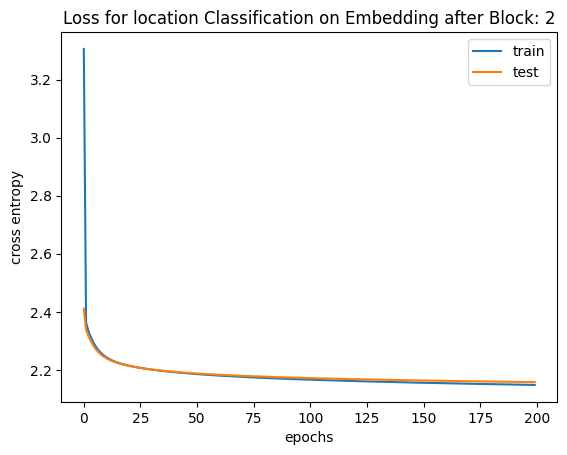

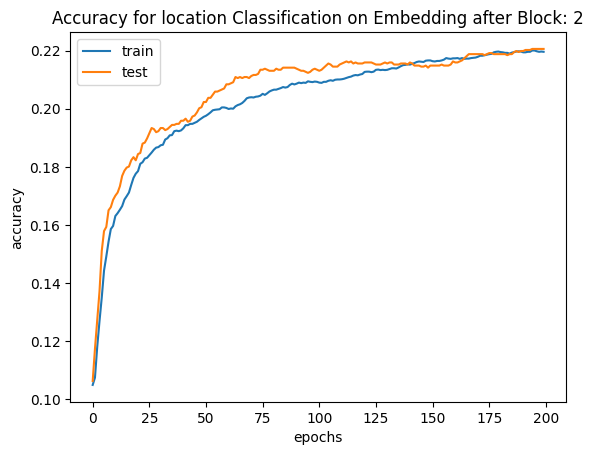

In [101]:
n_epochs = 200
batch_size = 64
batches_per_epoch = len(X_train) // batch_size

# Freeze the parameters of the rest of the model
for param in model.parameters():
    param.requires_grad = False

# Allow the parameters of the final layer to be updated during training
for param in model.fc3.parameters():
    param.requires_grad = True

best_loss = np.inf  # Initialize to infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []

# Define the optimizer to update only the parameters of the final layer
# optimizer = torch.optim.SGD(model.layer3.parameters(), lr=0.001)

# Training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    
    # Set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # Take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            # Forward pass
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Update weights
            optimizer.step()

            # Compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # Set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)
        y_val_batch = y_val_tensor.to(device)
        y_pred = model(X_test_batch)
        ce = criterion(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if ce < best_loss:
        best_loss = ce
        best_weights = copy.deepcopy(model.state_dict())

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

# Load the best weights and plot the results
model.load_state_dict(best_weights)

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()


In [102]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [103]:
torch.save(model, fr'{folder_name}{run_mode}_{Block_number}.pth')

In [104]:
model=torch.load(fr'{folder_name}{run_mode}_{Block_number}.pth')
model.to(device)

SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [105]:
X_test=train_ready(test_data,col_name)

In [106]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        output = model(feature.unsqueeze(0))
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred

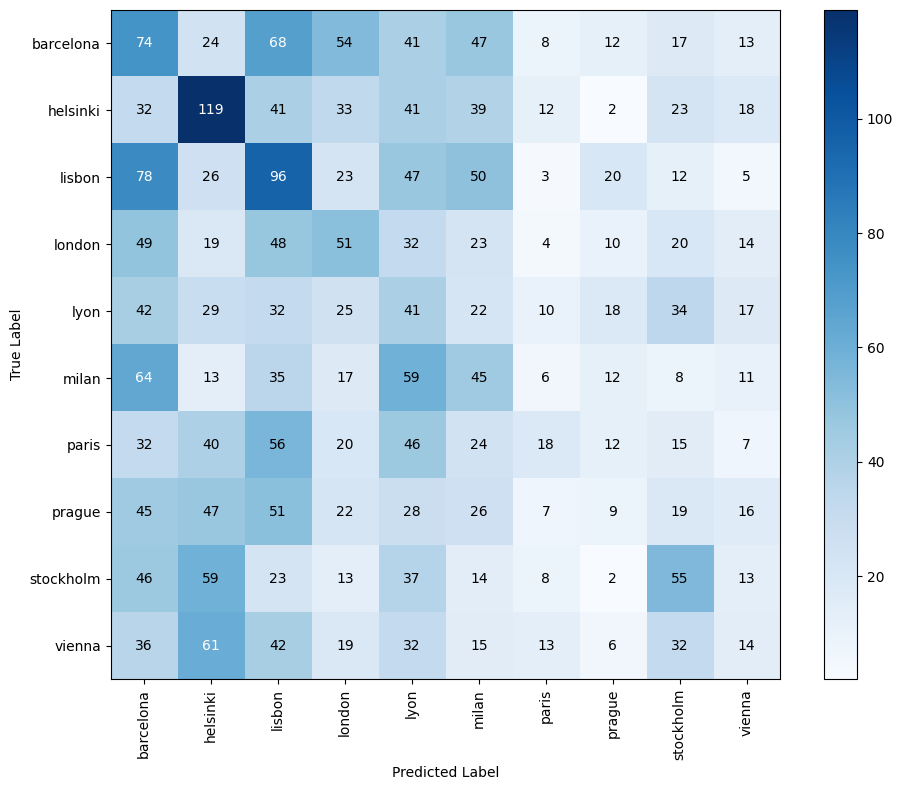

Accuracy: 0.1759


In [107]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)
# loss_list.append()

# Block-3

In [108]:
Block_number=3

In [109]:
model=torch.load(f'{base_dir}/small_model_scene_{Block_number}_opl.pth')

In [110]:
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)

In [111]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [112]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [113]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 10)
(2793, 10)


In [114]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters are {total_params}")
last_layer_params = list(model.parameters())[-2:]  # Assuming the last layer has both weight and bias parameters

# Count the total number of parameters in the last layer
num_params_last_layer = sum(p.numel() for p in last_layer_params)
print(f"Number of parameters in the last layer is {num_params_last_layer}")

Total number of paramerters are 199434
Number of parameters in the last layer is 2570


In [115]:
# for param in model.fc1.parameters():
#     param.requires_grad=False
for param in model.fc2.parameters():
    param.requires_grad = False

In [116]:
nn.init.xavier_uniform_(model.fc3.weight)
nn.init.constant_(model.fc3.bias, 0.0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [117]:
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of trainable parameters:", total_trainable_params)

Total number of trainable parameters: 2570


In [118]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc3.parameters(), lr=lr)

Total number of paramerters in the model are: 199434
Total number of paramerters being trained:  2570


Epoch 0: 100%|██████████| 174/174 [00:00<00:00, 508.96batch/s, acc=0.156, loss=2.29] 


Epoch 0 validation: Cross-entropy=2.34, Accuracy=12.3%


Epoch 1: 100%|██████████| 174/174 [00:00<00:00, 579.06batch/s, acc=0.109, loss=2.27] 


Epoch 1 validation: Cross-entropy=2.31, Accuracy=12.7%


Epoch 2: 100%|██████████| 174/174 [00:00<00:00, 716.37batch/s, acc=0.0938, loss=2.26]


Epoch 2 validation: Cross-entropy=2.29, Accuracy=12.7%


Epoch 3: 100%|██████████| 174/174 [00:00<00:00, 505.64batch/s, acc=0.125, loss=2.25] 


Epoch 3 validation: Cross-entropy=2.28, Accuracy=13.0%


Epoch 4: 100%|██████████| 174/174 [00:00<00:00, 722.75batch/s, acc=0.141, loss=2.24] 


Epoch 4 validation: Cross-entropy=2.27, Accuracy=13.5%


Epoch 5: 100%|██████████| 174/174 [00:00<00:00, 582.35batch/s, acc=0.156, loss=2.24] 


Epoch 5 validation: Cross-entropy=2.26, Accuracy=13.9%


Epoch 6: 100%|██████████| 174/174 [00:00<00:00, 573.82batch/s, acc=0.172, loss=2.23] 


Epoch 6 validation: Cross-entropy=2.26, Accuracy=14.0%


Epoch 7: 100%|██████████| 174/174 [00:00<00:00, 722.90batch/s, acc=0.156, loss=2.23] 


Epoch 7 validation: Cross-entropy=2.25, Accuracy=14.1%


Epoch 8: 100%|██████████| 174/174 [00:00<00:00, 491.10batch/s, acc=0.156, loss=2.23] 


Epoch 8 validation: Cross-entropy=2.25, Accuracy=14.2%


Epoch 9: 100%|██████████| 174/174 [00:00<00:00, 575.63batch/s, acc=0.172, loss=2.22] 


Epoch 9 validation: Cross-entropy=2.24, Accuracy=15.1%


Epoch 10: 100%|██████████| 174/174 [00:00<00:00, 721.56batch/s, acc=0.188, loss=2.22] 


Epoch 10 validation: Cross-entropy=2.24, Accuracy=15.4%


Epoch 11: 100%|██████████| 174/174 [00:00<00:00, 579.64batch/s, acc=0.188, loss=2.22] 


Epoch 11 validation: Cross-entropy=2.24, Accuracy=15.7%


Epoch 12: 100%|██████████| 174/174 [00:00<00:00, 600.21batch/s, acc=0.172, loss=2.22] 


Epoch 12 validation: Cross-entropy=2.23, Accuracy=16.0%


Epoch 13: 100%|██████████| 174/174 [00:00<00:00, 662.44batch/s, acc=0.172, loss=2.22] 


Epoch 13 validation: Cross-entropy=2.23, Accuracy=16.3%


Epoch 14: 100%|██████████| 174/174 [00:00<00:00, 510.19batch/s, acc=0.141, loss=2.22] 


Epoch 14 validation: Cross-entropy=2.23, Accuracy=16.2%


Epoch 15: 100%|██████████| 174/174 [00:00<00:00, 728.91batch/s, acc=0.141, loss=2.21] 


Epoch 15 validation: Cross-entropy=2.23, Accuracy=16.2%


Epoch 16: 100%|██████████| 174/174 [00:00<00:00, 559.12batch/s, acc=0.141, loss=2.21] 


Epoch 16 validation: Cross-entropy=2.23, Accuracy=16.2%


Epoch 17: 100%|██████████| 174/174 [00:00<00:00, 579.43batch/s, acc=0.141, loss=2.21] 


Epoch 17 validation: Cross-entropy=2.22, Accuracy=16.3%


Epoch 18: 100%|██████████| 174/174 [00:00<00:00, 728.66batch/s, acc=0.141, loss=2.21] 


Epoch 18 validation: Cross-entropy=2.22, Accuracy=16.5%


Epoch 19: 100%|██████████| 174/174 [00:00<00:00, 585.21batch/s, acc=0.156, loss=2.21] 


Epoch 19 validation: Cross-entropy=2.22, Accuracy=16.6%


Epoch 20: 100%|██████████| 174/174 [00:00<00:00, 493.84batch/s, acc=0.156, loss=2.21] 


Epoch 20 validation: Cross-entropy=2.22, Accuracy=16.8%


Epoch 21: 100%|██████████| 174/174 [00:00<00:00, 724.58batch/s, acc=0.156, loss=2.21] 


Epoch 21 validation: Cross-entropy=2.22, Accuracy=17.1%


Epoch 22: 100%|██████████| 174/174 [00:00<00:00, 586.77batch/s, acc=0.141, loss=2.21] 


Epoch 22 validation: Cross-entropy=2.22, Accuracy=17.3%


Epoch 23: 100%|██████████| 174/174 [00:00<00:00, 731.44batch/s, acc=0.141, loss=2.21] 


Epoch 23 validation: Cross-entropy=2.21, Accuracy=17.6%


Epoch 24: 100%|██████████| 174/174 [00:00<00:00, 606.74batch/s, acc=0.141, loss=2.21] 


Epoch 24 validation: Cross-entropy=2.21, Accuracy=17.7%


Epoch 25: 100%|██████████| 174/174 [00:00<00:00, 582.43batch/s, acc=0.141, loss=2.21] 


Epoch 25 validation: Cross-entropy=2.21, Accuracy=17.8%


Epoch 26: 100%|██████████| 174/174 [00:00<00:00, 576.51batch/s, acc=0.141, loss=2.21] 


Epoch 26 validation: Cross-entropy=2.21, Accuracy=17.9%


Epoch 27: 100%|██████████| 174/174 [00:00<00:00, 570.80batch/s, acc=0.141, loss=2.21] 


Epoch 27 validation: Cross-entropy=2.21, Accuracy=18.0%


Epoch 28: 100%|██████████| 174/174 [00:00<00:00, 581.08batch/s, acc=0.141, loss=2.21] 


Epoch 28 validation: Cross-entropy=2.21, Accuracy=18.2%


Epoch 29: 100%|██████████| 174/174 [00:00<00:00, 728.02batch/s, acc=0.141, loss=2.21] 


Epoch 29 validation: Cross-entropy=2.21, Accuracy=18.4%


Epoch 30: 100%|██████████| 174/174 [00:00<00:00, 551.69batch/s, acc=0.141, loss=2.2]  


Epoch 30 validation: Cross-entropy=2.21, Accuracy=18.4%


Epoch 31: 100%|██████████| 174/174 [00:00<00:00, 609.51batch/s, acc=0.141, loss=2.2]  


Epoch 31 validation: Cross-entropy=2.21, Accuracy=18.7%


Epoch 32: 100%|██████████| 174/174 [00:00<00:00, 560.44batch/s, acc=0.141, loss=2.2]  


Epoch 32 validation: Cross-entropy=2.20, Accuracy=18.8%


Epoch 33: 100%|██████████| 174/174 [00:00<00:00, 562.12batch/s, acc=0.141, loss=2.2]  


Epoch 33 validation: Cross-entropy=2.20, Accuracy=19.2%


Epoch 34: 100%|██████████| 174/174 [00:00<00:00, 696.60batch/s, acc=0.141, loss=2.2]  


Epoch 34 validation: Cross-entropy=2.20, Accuracy=19.3%


Epoch 35: 100%|██████████| 174/174 [00:00<00:00, 565.24batch/s, acc=0.141, loss=2.2]  


Epoch 35 validation: Cross-entropy=2.20, Accuracy=19.4%


Epoch 36: 100%|██████████| 174/174 [00:00<00:00, 585.01batch/s, acc=0.141, loss=2.2]  


Epoch 36 validation: Cross-entropy=2.20, Accuracy=19.4%


Epoch 37: 100%|██████████| 174/174 [00:00<00:00, 604.69batch/s, acc=0.141, loss=2.2]  


Epoch 37 validation: Cross-entropy=2.20, Accuracy=19.5%


Epoch 38: 100%|██████████| 174/174 [00:00<00:00, 578.03batch/s, acc=0.141, loss=2.2]  


Epoch 38 validation: Cross-entropy=2.20, Accuracy=19.5%


Epoch 39: 100%|██████████| 174/174 [00:00<00:00, 591.72batch/s, acc=0.156, loss=2.2]  


Epoch 39 validation: Cross-entropy=2.20, Accuracy=19.5%


Epoch 40: 100%|██████████| 174/174 [00:00<00:00, 740.56batch/s, acc=0.156, loss=2.2]  


Epoch 40 validation: Cross-entropy=2.20, Accuracy=19.5%


Epoch 41: 100%|██████████| 174/174 [00:00<00:00, 592.99batch/s, acc=0.156, loss=2.2]  


Epoch 41 validation: Cross-entropy=2.20, Accuracy=19.7%


Epoch 42: 100%|██████████| 174/174 [00:00<00:00, 724.03batch/s, acc=0.141, loss=2.2]  


Epoch 42 validation: Cross-entropy=2.20, Accuracy=19.8%


Epoch 43: 100%|██████████| 174/174 [00:00<00:00, 509.63batch/s, acc=0.141, loss=2.2]  


Epoch 43 validation: Cross-entropy=2.20, Accuracy=19.8%


Epoch 44: 100%|██████████| 174/174 [00:00<00:00, 576.37batch/s, acc=0.141, loss=2.2]  


Epoch 44 validation: Cross-entropy=2.19, Accuracy=19.8%


Epoch 45: 100%|██████████| 174/174 [00:00<00:00, 744.83batch/s, acc=0.141, loss=2.2]  


Epoch 45 validation: Cross-entropy=2.19, Accuracy=19.9%


Epoch 46: 100%|██████████| 174/174 [00:00<00:00, 591.01batch/s, acc=0.141, loss=2.2]  


Epoch 46 validation: Cross-entropy=2.19, Accuracy=20.0%


Epoch 47: 100%|██████████| 174/174 [00:00<00:00, 589.17batch/s, acc=0.141, loss=2.2]  


Epoch 47 validation: Cross-entropy=2.19, Accuracy=20.0%


Epoch 48: 100%|██████████| 174/174 [00:00<00:00, 741.51batch/s, acc=0.141, loss=2.2]  


Epoch 48 validation: Cross-entropy=2.19, Accuracy=20.0%


Epoch 49: 100%|██████████| 174/174 [00:00<00:00, 537.84batch/s, acc=0.141, loss=2.2]  


Epoch 49 validation: Cross-entropy=2.19, Accuracy=20.1%


Epoch 50: 100%|██████████| 174/174 [00:00<00:00, 709.21batch/s, acc=0.141, loss=2.2]  


Epoch 50 validation: Cross-entropy=2.19, Accuracy=20.1%


Epoch 51: 100%|██████████| 174/174 [00:00<00:00, 595.59batch/s, acc=0.141, loss=2.2]  


Epoch 51 validation: Cross-entropy=2.19, Accuracy=20.1%


Epoch 52: 100%|██████████| 174/174 [00:00<00:00, 585.26batch/s, acc=0.141, loss=2.2]  


Epoch 52 validation: Cross-entropy=2.19, Accuracy=20.1%


Epoch 53: 100%|██████████| 174/174 [00:00<00:00, 737.01batch/s, acc=0.125, loss=2.2]  


Epoch 53 validation: Cross-entropy=2.19, Accuracy=20.0%


Epoch 54: 100%|██████████| 174/174 [00:00<00:00, 596.14batch/s, acc=0.125, loss=2.2]  


Epoch 54 validation: Cross-entropy=2.19, Accuracy=20.2%


Epoch 55: 100%|██████████| 174/174 [00:00<00:00, 590.85batch/s, acc=0.125, loss=2.2]  


Epoch 55 validation: Cross-entropy=2.19, Accuracy=20.1%


Epoch 56: 100%|██████████| 174/174 [00:00<00:00, 585.79batch/s, acc=0.125, loss=2.19] 


Epoch 56 validation: Cross-entropy=2.19, Accuracy=20.1%


Epoch 57: 100%|██████████| 174/174 [00:00<00:00, 595.41batch/s, acc=0.125, loss=2.19] 


Epoch 57 validation: Cross-entropy=2.19, Accuracy=20.1%


Epoch 58: 100%|██████████| 174/174 [00:00<00:00, 738.82batch/s, acc=0.125, loss=2.19] 


Epoch 58 validation: Cross-entropy=2.19, Accuracy=20.1%


Epoch 59: 100%|██████████| 174/174 [00:00<00:00, 596.37batch/s, acc=0.125, loss=2.19] 


Epoch 59 validation: Cross-entropy=2.19, Accuracy=20.2%


Epoch 60: 100%|██████████| 174/174 [00:00<00:00, 600.02batch/s, acc=0.125, loss=2.19] 


Epoch 60 validation: Cross-entropy=2.19, Accuracy=20.3%


Epoch 61: 100%|██████████| 174/174 [00:00<00:00, 708.60batch/s, acc=0.125, loss=2.19] 


Epoch 61 validation: Cross-entropy=2.19, Accuracy=20.3%


Epoch 62: 100%|██████████| 174/174 [00:00<00:00, 519.46batch/s, acc=0.125, loss=2.19] 


Epoch 62 validation: Cross-entropy=2.19, Accuracy=20.2%


Epoch 63: 100%|██████████| 174/174 [00:00<00:00, 665.99batch/s, acc=0.125, loss=2.19] 


Epoch 63 validation: Cross-entropy=2.18, Accuracy=20.2%


Epoch 64: 100%|██████████| 174/174 [00:00<00:00, 653.95batch/s, acc=0.125, loss=2.19] 


Epoch 64 validation: Cross-entropy=2.18, Accuracy=20.3%


Epoch 65: 100%|██████████| 174/174 [00:00<00:00, 578.48batch/s, acc=0.125, loss=2.19] 


Epoch 65 validation: Cross-entropy=2.18, Accuracy=20.3%


Epoch 66: 100%|██████████| 174/174 [00:00<00:00, 745.26batch/s, acc=0.125, loss=2.19] 


Epoch 66 validation: Cross-entropy=2.18, Accuracy=20.3%


Epoch 67: 100%|██████████| 174/174 [00:00<00:00, 502.74batch/s, acc=0.125, loss=2.19] 


Epoch 67 validation: Cross-entropy=2.18, Accuracy=20.3%


Epoch 68: 100%|██████████| 174/174 [00:00<00:00, 595.07batch/s, acc=0.125, loss=2.19] 


Epoch 68 validation: Cross-entropy=2.18, Accuracy=20.4%


Epoch 69: 100%|██████████| 174/174 [00:00<00:00, 736.09batch/s, acc=0.125, loss=2.19] 


Epoch 69 validation: Cross-entropy=2.18, Accuracy=20.4%


Epoch 70: 100%|██████████| 174/174 [00:00<00:00, 597.09batch/s, acc=0.109, loss=2.19] 


Epoch 70 validation: Cross-entropy=2.18, Accuracy=20.5%


Epoch 71: 100%|██████████| 174/174 [00:00<00:00, 631.14batch/s, acc=0.109, loss=2.19] 


Epoch 71 validation: Cross-entropy=2.18, Accuracy=20.5%


Epoch 72: 100%|██████████| 174/174 [00:00<00:00, 690.03batch/s, acc=0.109, loss=2.19] 


Epoch 72 validation: Cross-entropy=2.18, Accuracy=20.5%


Epoch 73: 100%|██████████| 174/174 [00:00<00:00, 509.98batch/s, acc=0.109, loss=2.19] 


Epoch 73 validation: Cross-entropy=2.18, Accuracy=20.6%


Epoch 74: 100%|██████████| 174/174 [00:00<00:00, 729.76batch/s, acc=0.109, loss=2.19] 


Epoch 74 validation: Cross-entropy=2.18, Accuracy=20.5%


Epoch 75: 100%|██████████| 174/174 [00:00<00:00, 594.98batch/s, acc=0.109, loss=2.19] 


Epoch 75 validation: Cross-entropy=2.18, Accuracy=20.6%


Epoch 76: 100%|██████████| 174/174 [00:00<00:00, 590.83batch/s, acc=0.109, loss=2.19] 


Epoch 76 validation: Cross-entropy=2.18, Accuracy=20.7%


Epoch 77: 100%|██████████| 174/174 [00:00<00:00, 729.51batch/s, acc=0.109, loss=2.19] 


Epoch 77 validation: Cross-entropy=2.18, Accuracy=20.7%


Epoch 78: 100%|██████████| 174/174 [00:00<00:00, 592.90batch/s, acc=0.109, loss=2.19] 


Epoch 78 validation: Cross-entropy=2.18, Accuracy=20.6%


Epoch 79: 100%|██████████| 174/174 [00:00<00:00, 688.92batch/s, acc=0.109, loss=2.19] 


Epoch 79 validation: Cross-entropy=2.18, Accuracy=20.5%


Epoch 80: 100%|██████████| 174/174 [00:00<00:00, 535.63batch/s, acc=0.109, loss=2.19] 


Epoch 80 validation: Cross-entropy=2.18, Accuracy=20.5%


Epoch 81: 100%|██████████| 174/174 [00:00<00:00, 589.55batch/s, acc=0.109, loss=2.18] 


Epoch 81 validation: Cross-entropy=2.18, Accuracy=20.5%


Epoch 82: 100%|██████████| 174/174 [00:00<00:00, 740.24batch/s, acc=0.109, loss=2.18] 


Epoch 82 validation: Cross-entropy=2.18, Accuracy=20.6%


Epoch 83: 100%|██████████| 174/174 [00:00<00:00, 593.45batch/s, acc=0.109, loss=2.18] 


Epoch 83 validation: Cross-entropy=2.18, Accuracy=20.6%


Epoch 84: 100%|██████████| 174/174 [00:00<00:00, 594.33batch/s, acc=0.109, loss=2.18] 


Epoch 84 validation: Cross-entropy=2.18, Accuracy=20.7%


Epoch 85: 100%|██████████| 174/174 [00:00<00:00, 736.11batch/s, acc=0.109, loss=2.18] 


Epoch 85 validation: Cross-entropy=2.18, Accuracy=20.7%


Epoch 86: 100%|██████████| 174/174 [00:00<00:00, 485.91batch/s, acc=0.109, loss=2.18] 


Epoch 86 validation: Cross-entropy=2.18, Accuracy=20.7%


Epoch 87: 100%|██████████| 174/174 [00:00<00:00, 618.39batch/s, acc=0.109, loss=2.18] 


Epoch 87 validation: Cross-entropy=2.18, Accuracy=20.7%


Epoch 88: 100%|██████████| 174/174 [00:00<00:00, 707.99batch/s, acc=0.109, loss=2.18] 


Epoch 88 validation: Cross-entropy=2.18, Accuracy=20.7%


Epoch 89: 100%|██████████| 174/174 [00:00<00:00, 596.46batch/s, acc=0.125, loss=2.18] 


Epoch 89 validation: Cross-entropy=2.18, Accuracy=20.7%


Epoch 90: 100%|██████████| 174/174 [00:00<00:00, 737.21batch/s, acc=0.125, loss=2.18] 


Epoch 90 validation: Cross-entropy=2.18, Accuracy=20.6%


Epoch 91: 100%|██████████| 174/174 [00:00<00:00, 504.58batch/s, acc=0.125, loss=2.18] 


Epoch 91 validation: Cross-entropy=2.17, Accuracy=20.6%


Epoch 92: 100%|██████████| 174/174 [00:00<00:00, 567.34batch/s, acc=0.125, loss=2.18] 


Epoch 92 validation: Cross-entropy=2.17, Accuracy=20.6%


Epoch 93: 100%|██████████| 174/174 [00:00<00:00, 749.00batch/s, acc=0.125, loss=2.18] 


Epoch 93 validation: Cross-entropy=2.17, Accuracy=20.6%


Epoch 94: 100%|██████████| 174/174 [00:00<00:00, 592.86batch/s, acc=0.125, loss=2.18] 


Epoch 94 validation: Cross-entropy=2.17, Accuracy=20.8%


Epoch 95: 100%|██████████| 174/174 [00:00<00:00, 730.17batch/s, acc=0.125, loss=2.18] 


Epoch 95 validation: Cross-entropy=2.17, Accuracy=20.8%


Epoch 96: 100%|██████████| 174/174 [00:00<00:00, 610.22batch/s, acc=0.109, loss=2.18] 


Epoch 96 validation: Cross-entropy=2.17, Accuracy=20.8%


Epoch 97: 100%|██████████| 174/174 [00:00<00:00, 560.04batch/s, acc=0.109, loss=2.18] 


Epoch 97 validation: Cross-entropy=2.17, Accuracy=20.7%


Epoch 98: 100%|██████████| 174/174 [00:00<00:00, 587.47batch/s, acc=0.125, loss=2.18] 


Epoch 98 validation: Cross-entropy=2.17, Accuracy=20.8%


Epoch 99: 100%|██████████| 174/174 [00:00<00:00, 594.36batch/s, acc=0.125, loss=2.18] 


Epoch 99 validation: Cross-entropy=2.17, Accuracy=20.8%


Epoch 100: 100%|██████████| 174/174 [00:00<00:00, 597.11batch/s, acc=0.125, loss=2.18] 


Epoch 100 validation: Cross-entropy=2.17, Accuracy=20.8%


Epoch 101: 100%|██████████| 174/174 [00:00<00:00, 735.73batch/s, acc=0.125, loss=2.18] 


Epoch 101 validation: Cross-entropy=2.17, Accuracy=20.8%


Epoch 102: 100%|██████████| 174/174 [00:00<00:00, 593.18batch/s, acc=0.125, loss=2.18] 


Epoch 102 validation: Cross-entropy=2.17, Accuracy=20.8%


Epoch 103: 100%|██████████| 174/174 [00:00<00:00, 738.92batch/s, acc=0.125, loss=2.18] 


Epoch 103 validation: Cross-entropy=2.17, Accuracy=20.7%


Epoch 104: 100%|██████████| 174/174 [00:00<00:00, 500.89batch/s, acc=0.125, loss=2.18] 


Epoch 104 validation: Cross-entropy=2.17, Accuracy=20.8%


Epoch 105: 100%|██████████| 174/174 [00:00<00:00, 587.19batch/s, acc=0.125, loss=2.18] 


Epoch 105 validation: Cross-entropy=2.17, Accuracy=20.7%


Epoch 106: 100%|██████████| 174/174 [00:00<00:00, 701.43batch/s, acc=0.125, loss=2.17] 


Epoch 106 validation: Cross-entropy=2.17, Accuracy=20.7%


Epoch 107: 100%|██████████| 174/174 [00:00<00:00, 366.25batch/s, acc=0.141, loss=2.17] 


Epoch 107 validation: Cross-entropy=2.17, Accuracy=20.7%


Epoch 108: 100%|██████████| 174/174 [00:00<00:00, 359.87batch/s, acc=0.141, loss=2.17] 


Epoch 108 validation: Cross-entropy=2.17, Accuracy=20.7%


Epoch 109: 100%|██████████| 174/174 [00:00<00:00, 605.96batch/s, acc=0.141, loss=2.17] 


Epoch 109 validation: Cross-entropy=2.17, Accuracy=20.8%


Epoch 110: 100%|██████████| 174/174 [00:00<00:00, 537.67batch/s, acc=0.141, loss=2.17] 


Epoch 110 validation: Cross-entropy=2.17, Accuracy=20.8%


Epoch 111: 100%|██████████| 174/174 [00:00<00:00, 544.48batch/s, acc=0.141, loss=2.17] 


Epoch 111 validation: Cross-entropy=2.17, Accuracy=20.7%


Epoch 112: 100%|██████████| 174/174 [00:00<00:00, 548.08batch/s, acc=0.141, loss=2.17] 


Epoch 112 validation: Cross-entropy=2.17, Accuracy=20.7%


Epoch 113: 100%|██████████| 174/174 [00:00<00:00, 476.33batch/s, acc=0.141, loss=2.17] 


Epoch 113 validation: Cross-entropy=2.17, Accuracy=20.8%


Epoch 114: 100%|██████████| 174/174 [00:00<00:00, 505.37batch/s, acc=0.141, loss=2.17] 


Epoch 114 validation: Cross-entropy=2.17, Accuracy=20.8%


Epoch 115: 100%|██████████| 174/174 [00:00<00:00, 591.42batch/s, acc=0.141, loss=2.17]


Epoch 115 validation: Cross-entropy=2.17, Accuracy=20.8%


Epoch 116: 100%|██████████| 174/174 [00:00<00:00, 428.13batch/s, acc=0.141, loss=2.17]


Epoch 116 validation: Cross-entropy=2.17, Accuracy=20.8%


Epoch 117: 100%|██████████| 174/174 [00:00<00:00, 492.00batch/s, acc=0.141, loss=2.17]


Epoch 117 validation: Cross-entropy=2.17, Accuracy=20.8%


Epoch 118: 100%|██████████| 174/174 [00:00<00:00, 619.01batch/s, acc=0.156, loss=2.17]


Epoch 118 validation: Cross-entropy=2.17, Accuracy=20.8%


Epoch 119: 100%|██████████| 174/174 [00:00<00:00, 479.89batch/s, acc=0.156, loss=2.17]


Epoch 119 validation: Cross-entropy=2.17, Accuracy=20.8%


Epoch 120: 100%|██████████| 174/174 [00:00<00:00, 511.23batch/s, acc=0.156, loss=2.17]


Epoch 120 validation: Cross-entropy=2.17, Accuracy=20.8%


Epoch 121: 100%|██████████| 174/174 [00:00<00:00, 644.09batch/s, acc=0.156, loss=2.17]


Epoch 121 validation: Cross-entropy=2.17, Accuracy=20.8%


Epoch 122: 100%|██████████| 174/174 [00:00<00:00, 496.59batch/s, acc=0.156, loss=2.17]


Epoch 122 validation: Cross-entropy=2.17, Accuracy=20.8%


Epoch 123: 100%|██████████| 174/174 [00:00<00:00, 549.71batch/s, acc=0.156, loss=2.17]


Epoch 123 validation: Cross-entropy=2.17, Accuracy=20.8%


Epoch 124: 100%|██████████| 174/174 [00:00<00:00, 519.50batch/s, acc=0.156, loss=2.17]


Epoch 124 validation: Cross-entropy=2.17, Accuracy=20.8%


Epoch 125: 100%|██████████| 174/174 [00:00<00:00, 491.76batch/s, acc=0.156, loss=2.17]


Epoch 125 validation: Cross-entropy=2.17, Accuracy=20.7%


Epoch 126: 100%|██████████| 174/174 [00:00<00:00, 689.62batch/s, acc=0.156, loss=2.17]


Epoch 126 validation: Cross-entropy=2.17, Accuracy=20.8%


Epoch 127: 100%|██████████| 174/174 [00:00<00:00, 580.40batch/s, acc=0.156, loss=2.17]


Epoch 127 validation: Cross-entropy=2.17, Accuracy=20.8%


Epoch 128: 100%|██████████| 174/174 [00:00<00:00, 577.49batch/s, acc=0.156, loss=2.17]


Epoch 128 validation: Cross-entropy=2.17, Accuracy=20.8%


Epoch 129: 100%|██████████| 174/174 [00:00<00:00, 738.45batch/s, acc=0.156, loss=2.17]


Epoch 129 validation: Cross-entropy=2.17, Accuracy=20.8%


Epoch 130: 100%|██████████| 174/174 [00:00<00:00, 574.78batch/s, acc=0.156, loss=2.17]


Epoch 130 validation: Cross-entropy=2.17, Accuracy=20.8%


Epoch 131: 100%|██████████| 174/174 [00:00<00:00, 473.68batch/s, acc=0.156, loss=2.17]


Epoch 131 validation: Cross-entropy=2.17, Accuracy=20.8%


Epoch 132: 100%|██████████| 174/174 [00:00<00:00, 715.90batch/s, acc=0.156, loss=2.17]


Epoch 132 validation: Cross-entropy=2.16, Accuracy=20.9%


Epoch 133: 100%|██████████| 174/174 [00:00<00:00, 577.51batch/s, acc=0.156, loss=2.17]


Epoch 133 validation: Cross-entropy=2.16, Accuracy=20.9%


Epoch 134: 100%|██████████| 174/174 [00:00<00:00, 723.87batch/s, acc=0.156, loss=2.16]


Epoch 134 validation: Cross-entropy=2.16, Accuracy=20.9%


Epoch 135: 100%|██████████| 174/174 [00:00<00:00, 536.31batch/s, acc=0.156, loss=2.16]


Epoch 135 validation: Cross-entropy=2.16, Accuracy=20.9%


Epoch 136: 100%|██████████| 174/174 [00:00<00:00, 581.80batch/s, acc=0.156, loss=2.16]


Epoch 136 validation: Cross-entropy=2.16, Accuracy=21.1%


Epoch 137: 100%|██████████| 174/174 [00:00<00:00, 681.13batch/s, acc=0.156, loss=2.16]


Epoch 137 validation: Cross-entropy=2.16, Accuracy=21.0%


Epoch 138: 100%|██████████| 174/174 [00:00<00:00, 541.03batch/s, acc=0.156, loss=2.16]


Epoch 138 validation: Cross-entropy=2.16, Accuracy=20.9%


Epoch 139: 100%|██████████| 174/174 [00:00<00:00, 489.54batch/s, acc=0.156, loss=2.16]


Epoch 139 validation: Cross-entropy=2.16, Accuracy=20.9%


Epoch 140: 100%|██████████| 174/174 [00:00<00:00, 431.83batch/s, acc=0.156, loss=2.16] 


Epoch 140 validation: Cross-entropy=2.16, Accuracy=20.9%


Epoch 141: 100%|██████████| 174/174 [00:00<00:00, 505.12batch/s, acc=0.156, loss=2.16] 


Epoch 141 validation: Cross-entropy=2.16, Accuracy=20.8%


Epoch 142: 100%|██████████| 174/174 [00:00<00:00, 535.37batch/s, acc=0.156, loss=2.16] 


Epoch 142 validation: Cross-entropy=2.16, Accuracy=20.8%


Epoch 143: 100%|██████████| 174/174 [00:00<00:00, 615.45batch/s, acc=0.156, loss=2.16] 


Epoch 143 validation: Cross-entropy=2.16, Accuracy=20.8%


Epoch 144: 100%|██████████| 174/174 [00:00<00:00, 470.62batch/s, acc=0.156, loss=2.16] 


Epoch 144 validation: Cross-entropy=2.16, Accuracy=20.9%


Epoch 145: 100%|██████████| 174/174 [00:00<00:00, 614.17batch/s, acc=0.156, loss=2.16] 


Epoch 145 validation: Cross-entropy=2.16, Accuracy=20.9%


Epoch 146: 100%|██████████| 174/174 [00:00<00:00, 527.73batch/s, acc=0.156, loss=2.16] 


Epoch 146 validation: Cross-entropy=2.16, Accuracy=20.8%


Epoch 147: 100%|██████████| 174/174 [00:00<00:00, 417.76batch/s, acc=0.156, loss=2.16] 


Epoch 147 validation: Cross-entropy=2.16, Accuracy=20.9%


Epoch 148: 100%|██████████| 174/174 [00:00<00:00, 687.04batch/s, acc=0.156, loss=2.16] 


Epoch 148 validation: Cross-entropy=2.16, Accuracy=20.9%


Epoch 149: 100%|██████████| 174/174 [00:00<00:00, 544.46batch/s, acc=0.156, loss=2.16] 


Epoch 149 validation: Cross-entropy=2.16, Accuracy=20.9%


Epoch 150: 100%|██████████| 174/174 [00:00<00:00, 580.71batch/s, acc=0.156, loss=2.16] 


Epoch 150 validation: Cross-entropy=2.16, Accuracy=20.8%


Epoch 151: 100%|██████████| 174/174 [00:00<00:00, 716.28batch/s, acc=0.156, loss=2.16] 


Epoch 151 validation: Cross-entropy=2.16, Accuracy=20.9%


Epoch 152: 100%|██████████| 174/174 [00:00<00:00, 577.10batch/s, acc=0.156, loss=2.16] 


Epoch 152 validation: Cross-entropy=2.16, Accuracy=20.8%


Epoch 153: 100%|██████████| 174/174 [00:00<00:00, 686.72batch/s, acc=0.156, loss=2.16] 


Epoch 153 validation: Cross-entropy=2.16, Accuracy=20.8%


Epoch 154: 100%|██████████| 174/174 [00:00<00:00, 518.43batch/s, acc=0.156, loss=2.16] 


Epoch 154 validation: Cross-entropy=2.16, Accuracy=20.8%


Epoch 155: 100%|██████████| 174/174 [00:00<00:00, 445.78batch/s, acc=0.156, loss=2.16] 


Epoch 155 validation: Cross-entropy=2.16, Accuracy=20.8%


Epoch 156: 100%|██████████| 174/174 [00:00<00:00, 704.34batch/s, acc=0.156, loss=2.16] 


Epoch 156 validation: Cross-entropy=2.16, Accuracy=20.8%


Epoch 157: 100%|██████████| 174/174 [00:00<00:00, 540.92batch/s, acc=0.172, loss=2.16] 


Epoch 157 validation: Cross-entropy=2.16, Accuracy=20.8%


Epoch 158: 100%|██████████| 174/174 [00:00<00:00, 515.90batch/s, acc=0.172, loss=2.16] 


Epoch 158 validation: Cross-entropy=2.16, Accuracy=20.8%


Epoch 159: 100%|██████████| 174/174 [00:00<00:00, 644.79batch/s, acc=0.172, loss=2.16] 


Epoch 159 validation: Cross-entropy=2.16, Accuracy=20.8%


Epoch 160: 100%|██████████| 174/174 [00:00<00:00, 532.95batch/s, acc=0.172, loss=2.16] 


Epoch 160 validation: Cross-entropy=2.16, Accuracy=20.8%


Epoch 161: 100%|██████████| 174/174 [00:00<00:00, 668.00batch/s, acc=0.172, loss=2.16] 


Epoch 161 validation: Cross-entropy=2.16, Accuracy=20.8%


Epoch 162: 100%|██████████| 174/174 [00:00<00:00, 410.62batch/s, acc=0.172, loss=2.16] 


Epoch 162 validation: Cross-entropy=2.16, Accuracy=20.8%


Epoch 163: 100%|██████████| 174/174 [00:00<00:00, 476.17batch/s, acc=0.172, loss=2.15] 


Epoch 163 validation: Cross-entropy=2.16, Accuracy=20.8%


Epoch 164: 100%|██████████| 174/174 [00:00<00:00, 643.62batch/s, acc=0.172, loss=2.15] 


Epoch 164 validation: Cross-entropy=2.16, Accuracy=20.8%


Epoch 165: 100%|██████████| 174/174 [00:00<00:00, 553.79batch/s, acc=0.172, loss=2.15] 


Epoch 165 validation: Cross-entropy=2.16, Accuracy=20.8%


Epoch 166: 100%|██████████| 174/174 [00:00<00:00, 436.31batch/s, acc=0.156, loss=2.15] 


Epoch 166 validation: Cross-entropy=2.16, Accuracy=20.8%


Epoch 167: 100%|██████████| 174/174 [00:00<00:00, 614.23batch/s, acc=0.156, loss=2.15] 


Epoch 167 validation: Cross-entropy=2.16, Accuracy=20.8%


Epoch 168: 100%|██████████| 174/174 [00:00<00:00, 461.74batch/s, acc=0.156, loss=2.15] 


Epoch 168 validation: Cross-entropy=2.16, Accuracy=20.8%


Epoch 169: 100%|██████████| 174/174 [00:00<00:00, 365.45batch/s, acc=0.156, loss=2.15] 


Epoch 169 validation: Cross-entropy=2.16, Accuracy=20.8%


Epoch 170: 100%|██████████| 174/174 [00:00<00:00, 521.08batch/s, acc=0.156, loss=2.15] 


Epoch 170 validation: Cross-entropy=2.16, Accuracy=20.8%


Epoch 171: 100%|██████████| 174/174 [00:00<00:00, 428.90batch/s, acc=0.156, loss=2.15] 


Epoch 171 validation: Cross-entropy=2.16, Accuracy=20.9%


Epoch 172: 100%|██████████| 174/174 [00:00<00:00, 527.14batch/s, acc=0.172, loss=2.15] 


Epoch 172 validation: Cross-entropy=2.16, Accuracy=20.8%


Epoch 173: 100%|██████████| 174/174 [00:00<00:00, 362.84batch/s, acc=0.172, loss=2.15] 


Epoch 173 validation: Cross-entropy=2.16, Accuracy=20.9%


Epoch 174: 100%|██████████| 174/174 [00:00<00:00, 523.30batch/s, acc=0.172, loss=2.15] 


Epoch 174 validation: Cross-entropy=2.16, Accuracy=20.9%


Epoch 175: 100%|██████████| 174/174 [00:00<00:00, 666.02batch/s, acc=0.172, loss=2.15] 


Epoch 175 validation: Cross-entropy=2.16, Accuracy=20.9%


Epoch 176: 100%|██████████| 174/174 [00:00<00:00, 473.85batch/s, acc=0.172, loss=2.15] 


Epoch 176 validation: Cross-entropy=2.16, Accuracy=20.9%


Epoch 177: 100%|██████████| 174/174 [00:00<00:00, 487.23batch/s, acc=0.172, loss=2.15] 


Epoch 177 validation: Cross-entropy=2.16, Accuracy=21.0%


Epoch 178: 100%|██████████| 174/174 [00:00<00:00, 637.06batch/s, acc=0.172, loss=2.15] 


Epoch 178 validation: Cross-entropy=2.16, Accuracy=21.0%


Epoch 179: 100%|██████████| 174/174 [00:00<00:00, 523.28batch/s, acc=0.172, loss=2.15] 


Epoch 179 validation: Cross-entropy=2.16, Accuracy=21.1%


Epoch 180: 100%|██████████| 174/174 [00:00<00:00, 514.04batch/s, acc=0.172, loss=2.15] 


Epoch 180 validation: Cross-entropy=2.16, Accuracy=21.1%


Epoch 181: 100%|██████████| 174/174 [00:00<00:00, 483.64batch/s, acc=0.172, loss=2.15] 


Epoch 181 validation: Cross-entropy=2.16, Accuracy=21.1%


Epoch 182: 100%|██████████| 174/174 [00:00<00:00, 485.34batch/s, acc=0.172, loss=2.15] 


Epoch 182 validation: Cross-entropy=2.16, Accuracy=21.1%


Epoch 183: 100%|██████████| 174/174 [00:00<00:00, 633.13batch/s, acc=0.172, loss=2.15] 


Epoch 183 validation: Cross-entropy=2.16, Accuracy=21.2%


Epoch 184: 100%|██████████| 174/174 [00:00<00:00, 492.46batch/s, acc=0.172, loss=2.15] 


Epoch 184 validation: Cross-entropy=2.16, Accuracy=21.2%


Epoch 185: 100%|██████████| 174/174 [00:00<00:00, 468.69batch/s, acc=0.172, loss=2.15] 


Epoch 185 validation: Cross-entropy=2.16, Accuracy=21.2%


Epoch 186: 100%|██████████| 174/174 [00:00<00:00, 642.66batch/s, acc=0.172, loss=2.15] 


Epoch 186 validation: Cross-entropy=2.16, Accuracy=21.1%


Epoch 187: 100%|██████████| 174/174 [00:00<00:00, 501.44batch/s, acc=0.172, loss=2.15] 


Epoch 187 validation: Cross-entropy=2.16, Accuracy=21.2%


Epoch 188: 100%|██████████| 174/174 [00:00<00:00, 629.26batch/s, acc=0.172, loss=2.15] 


Epoch 188 validation: Cross-entropy=2.16, Accuracy=21.2%


Epoch 189: 100%|██████████| 174/174 [00:00<00:00, 468.00batch/s, acc=0.172, loss=2.15] 


Epoch 189 validation: Cross-entropy=2.16, Accuracy=21.3%


Epoch 190: 100%|██████████| 174/174 [00:00<00:00, 424.20batch/s, acc=0.172, loss=2.15] 


Epoch 190 validation: Cross-entropy=2.15, Accuracy=21.3%


Epoch 191: 100%|██████████| 174/174 [00:00<00:00, 512.42batch/s, acc=0.172, loss=2.15] 


Epoch 191 validation: Cross-entropy=2.15, Accuracy=21.3%


Epoch 192: 100%|██████████| 174/174 [00:00<00:00, 501.80batch/s, acc=0.172, loss=2.15] 


Epoch 192 validation: Cross-entropy=2.15, Accuracy=21.3%


Epoch 193: 100%|██████████| 174/174 [00:00<00:00, 609.34batch/s, acc=0.172, loss=2.15] 


Epoch 193 validation: Cross-entropy=2.15, Accuracy=21.3%


Epoch 194: 100%|██████████| 174/174 [00:00<00:00, 462.57batch/s, acc=0.172, loss=2.15] 


Epoch 194 validation: Cross-entropy=2.15, Accuracy=21.3%


Epoch 195: 100%|██████████| 174/174 [00:00<00:00, 472.81batch/s, acc=0.172, loss=2.15] 


Epoch 195 validation: Cross-entropy=2.15, Accuracy=21.3%


Epoch 196: 100%|██████████| 174/174 [00:00<00:00, 615.73batch/s, acc=0.172, loss=2.15] 


Epoch 196 validation: Cross-entropy=2.15, Accuracy=21.3%


Epoch 197: 100%|██████████| 174/174 [00:00<00:00, 478.41batch/s, acc=0.172, loss=2.14] 


Epoch 197 validation: Cross-entropy=2.15, Accuracy=21.4%


Epoch 198: 100%|██████████| 174/174 [00:00<00:00, 456.80batch/s, acc=0.172, loss=2.14] 


Epoch 198 validation: Cross-entropy=2.15, Accuracy=21.4%


Epoch 199: 100%|██████████| 174/174 [00:00<00:00, 634.66batch/s, acc=0.172, loss=2.14] 


Epoch 199 validation: Cross-entropy=2.15, Accuracy=21.5%


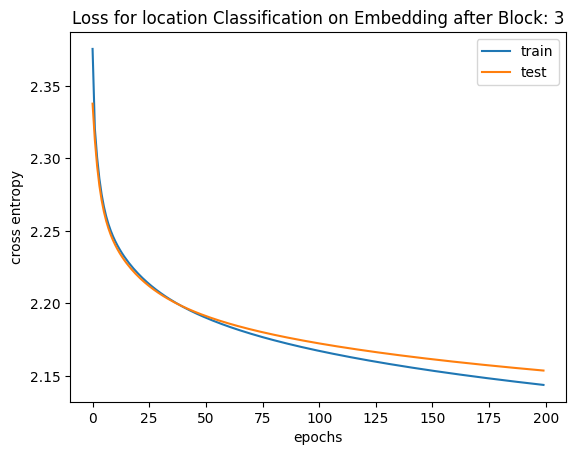

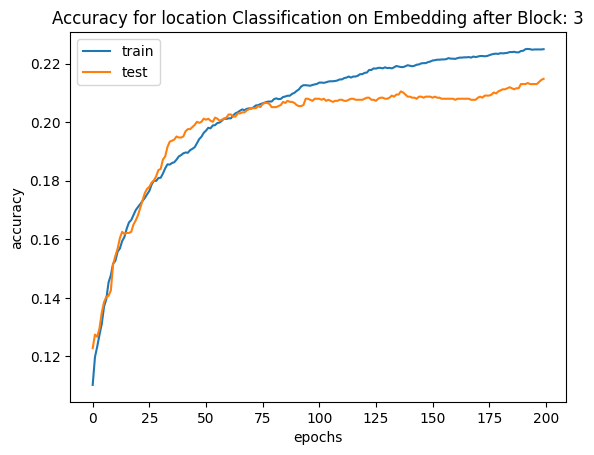

In [119]:
n_epochs = 200
batch_size = 64
batches_per_epoch = len(X_train) // batch_size

# Freeze the parameters of the rest of the model
for param in model.parameters():
    param.requires_grad = False

# # Allow the parameters of the final layer to be updated during training
for param in model.fc3.parameters():
    param.requires_grad = True

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters in the model are: {total_params}")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of paramerters being trained: ", total_trainable_params)


best_loss = np.inf  # Initialize to infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []

# Define the optimizer to update only the parameters of the final layer
# optimizer = torch.optim.SGD(model.layer3.parameters(), lr=0.001)

# Training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    
    # Set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # Take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            # Forward pass
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Update weights
            optimizer.step()

            # Compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # Set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)
        y_val_batch = y_val_tensor.to(device)
        y_pred = model(X_test_batch)
        ce = criterion(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if ce < best_loss:
        best_loss = ce
        best_weights = copy.deepcopy(model.state_dict())

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

# Load the best weights and plot the results
model.load_state_dict(best_weights)

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()


In [120]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [121]:
torch.save(model, fr'{folder_name}{run_mode}_{Block_number}.pth')

In [122]:
model=torch.load(fr'{folder_name}{run_mode}_{Block_number}.pth')
model.to(device)

SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [123]:
X_test=train_ready(test_data,col_name)

In [124]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        output = model(feature.unsqueeze(0))
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred

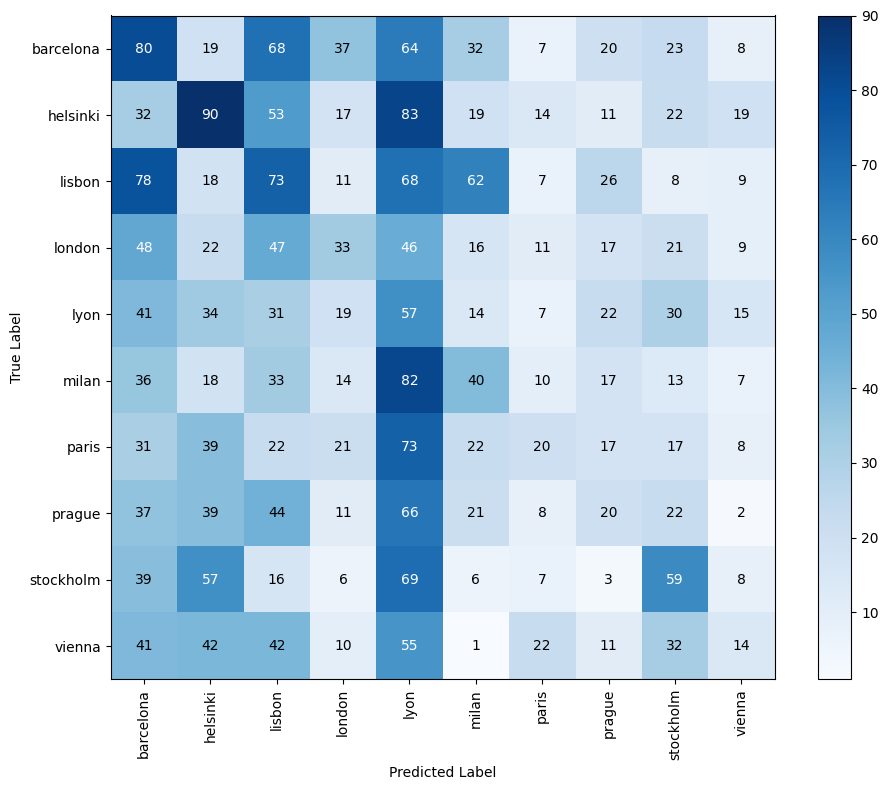

Accuracy: 0.1637


In [125]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)
# loss_list.append()

# Block-4

In [126]:
Block_number=4

In [127]:
model=torch.load(f'{base_dir}/small_model_scene_{Block_number}_opl.pth')

In [128]:
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)

In [129]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [130]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [131]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 10)
(2793, 10)


In [132]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters are {total_params}")
last_layer_params = list(model.parameters())[-2:]  # Assuming the last layer has both weight and bias parameters

# Count the total number of parameters in the last layer
num_params_last_layer = sum(p.numel() for p in last_layer_params)
print(f"Number of parameters in the last layer is {num_params_last_layer}")

Total number of paramerters are 199434
Number of parameters in the last layer is 2570


In [133]:
# for param in model.fc1.parameters():
#     param.requires_grad=False
for param in model.fc2.parameters():
    param.requires_grad = False

In [134]:
nn.init.xavier_uniform_(model.fc3.weight)
nn.init.constant_(model.fc3.bias, 0.0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [135]:
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of trainable parameters:", total_trainable_params)

Total number of trainable parameters: 2570


In [136]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc3.parameters(), lr=lr)

Total number of paramerters in the model are: 199434
Total number of paramerters being trained:  2570


Epoch 0: 100%|██████████| 174/174 [00:00<00:00, 485.81batch/s, acc=0.0781, loss=2.43]


Epoch 0 validation: Cross-entropy=2.40, Accuracy=10.5%


Epoch 1: 100%|██████████| 174/174 [00:00<00:00, 558.45batch/s, acc=0.109, loss=2.36] 


Epoch 1 validation: Cross-entropy=2.33, Accuracy=11.5%


Epoch 2: 100%|██████████| 174/174 [00:00<00:00, 579.90batch/s, acc=0.0938, loss=2.33]


Epoch 2 validation: Cross-entropy=2.31, Accuracy=11.5%


Epoch 3: 100%|██████████| 174/174 [00:00<00:00, 531.01batch/s, acc=0.0938, loss=2.32]


Epoch 3 validation: Cross-entropy=2.30, Accuracy=11.6%


Epoch 4: 100%|██████████| 174/174 [00:00<00:00, 578.32batch/s, acc=0.0625, loss=2.31]


Epoch 4 validation: Cross-entropy=2.29, Accuracy=12.3%


Epoch 5: 100%|██████████| 174/174 [00:00<00:00, 693.78batch/s, acc=0.0625, loss=2.31]


Epoch 5 validation: Cross-entropy=2.28, Accuracy=13.0%


Epoch 6: 100%|██████████| 174/174 [00:00<00:00, 572.25batch/s, acc=0.0625, loss=2.3] 


Epoch 6 validation: Cross-entropy=2.28, Accuracy=13.8%


Epoch 7: 100%|██████████| 174/174 [00:00<00:00, 715.96batch/s, acc=0.0625, loss=2.3] 


Epoch 7 validation: Cross-entropy=2.27, Accuracy=14.4%


Epoch 8: 100%|██████████| 174/174 [00:00<00:00, 574.45batch/s, acc=0.0625, loss=2.29]


Epoch 8 validation: Cross-entropy=2.26, Accuracy=14.8%


Epoch 9: 100%|██████████| 174/174 [00:00<00:00, 571.57batch/s, acc=0.0625, loss=2.29]


Epoch 9 validation: Cross-entropy=2.26, Accuracy=15.2%


Epoch 10: 100%|██████████| 174/174 [00:00<00:00, 558.70batch/s, acc=0.0625, loss=2.28]


Epoch 10 validation: Cross-entropy=2.25, Accuracy=15.8%


Epoch 11: 100%|██████████| 174/174 [00:00<00:00, 561.39batch/s, acc=0.0625, loss=2.28]


Epoch 11 validation: Cross-entropy=2.25, Accuracy=16.1%


Epoch 12: 100%|██████████| 174/174 [00:00<00:00, 578.31batch/s, acc=0.0625, loss=2.27]


Epoch 12 validation: Cross-entropy=2.24, Accuracy=16.3%


Epoch 13: 100%|██████████| 174/174 [00:00<00:00, 692.79batch/s, acc=0.0781, loss=2.27]


Epoch 13 validation: Cross-entropy=2.24, Accuracy=16.7%


Epoch 14: 100%|██████████| 174/174 [00:00<00:00, 566.84batch/s, acc=0.0469, loss=2.27]


Epoch 14 validation: Cross-entropy=2.24, Accuracy=17.0%


Epoch 15: 100%|██████████| 174/174 [00:00<00:00, 588.42batch/s, acc=0.0469, loss=2.26]


Epoch 15 validation: Cross-entropy=2.23, Accuracy=17.4%


Epoch 16: 100%|██████████| 174/174 [00:00<00:00, 579.87batch/s, acc=0.0625, loss=2.26]


Epoch 16 validation: Cross-entropy=2.23, Accuracy=17.5%


Epoch 17: 100%|██████████| 174/174 [00:00<00:00, 569.61batch/s, acc=0.0938, loss=2.26]


Epoch 17 validation: Cross-entropy=2.22, Accuracy=17.9%


Epoch 18: 100%|██████████| 174/174 [00:00<00:00, 708.84batch/s, acc=0.109, loss=2.25] 


Epoch 18 validation: Cross-entropy=2.22, Accuracy=18.0%


Epoch 19: 100%|██████████| 174/174 [00:00<00:00, 579.57batch/s, acc=0.109, loss=2.25] 


Epoch 19 validation: Cross-entropy=2.22, Accuracy=18.4%


Epoch 20: 100%|██████████| 174/174 [00:00<00:00, 687.11batch/s, acc=0.109, loss=2.25] 


Epoch 20 validation: Cross-entropy=2.21, Accuracy=18.6%


Epoch 21: 100%|██████████| 174/174 [00:00<00:00, 514.46batch/s, acc=0.141, loss=2.24] 


Epoch 21 validation: Cross-entropy=2.21, Accuracy=18.9%


Epoch 22: 100%|██████████| 174/174 [00:00<00:00, 569.14batch/s, acc=0.141, loss=2.24] 


Epoch 22 validation: Cross-entropy=2.21, Accuracy=19.4%


Epoch 23: 100%|██████████| 174/174 [00:00<00:00, 716.29batch/s, acc=0.141, loss=2.24] 


Epoch 23 validation: Cross-entropy=2.20, Accuracy=19.6%


Epoch 24: 100%|██████████| 174/174 [00:00<00:00, 575.41batch/s, acc=0.141, loss=2.23] 


Epoch 24 validation: Cross-entropy=2.20, Accuracy=19.9%


Epoch 25: 100%|██████████| 174/174 [00:00<00:00, 586.60batch/s, acc=0.141, loss=2.23] 


Epoch 25 validation: Cross-entropy=2.20, Accuracy=20.1%


Epoch 26: 100%|██████████| 174/174 [00:00<00:00, 692.68batch/s, acc=0.141, loss=2.23] 


Epoch 26 validation: Cross-entropy=2.19, Accuracy=20.4%


Epoch 27: 100%|██████████| 174/174 [00:00<00:00, 484.15batch/s, acc=0.156, loss=2.23] 


Epoch 27 validation: Cross-entropy=2.19, Accuracy=20.6%


Epoch 28: 100%|██████████| 174/174 [00:00<00:00, 699.27batch/s, acc=0.156, loss=2.22] 


Epoch 28 validation: Cross-entropy=2.19, Accuracy=21.0%


Epoch 29: 100%|██████████| 174/174 [00:00<00:00, 575.00batch/s, acc=0.172, loss=2.22] 


Epoch 29 validation: Cross-entropy=2.19, Accuracy=21.2%


Epoch 30: 100%|██████████| 174/174 [00:00<00:00, 568.68batch/s, acc=0.172, loss=2.22]


Epoch 30 validation: Cross-entropy=2.18, Accuracy=21.3%


Epoch 31: 100%|██████████| 174/174 [00:00<00:00, 673.66batch/s, acc=0.172, loss=2.21]


Epoch 31 validation: Cross-entropy=2.18, Accuracy=21.5%


Epoch 32: 100%|██████████| 174/174 [00:00<00:00, 547.09batch/s, acc=0.172, loss=2.21]


Epoch 32 validation: Cross-entropy=2.18, Accuracy=21.7%


Epoch 33: 100%|██████████| 174/174 [00:00<00:00, 495.96batch/s, acc=0.188, loss=2.21]


Epoch 33 validation: Cross-entropy=2.18, Accuracy=21.8%


Epoch 34: 100%|██████████| 174/174 [00:00<00:00, 702.09batch/s, acc=0.188, loss=2.21]


Epoch 34 validation: Cross-entropy=2.17, Accuracy=22.1%


Epoch 35: 100%|██████████| 174/174 [00:00<00:00, 575.67batch/s, acc=0.203, loss=2.2] 


Epoch 35 validation: Cross-entropy=2.17, Accuracy=22.3%


Epoch 36: 100%|██████████| 174/174 [00:00<00:00, 719.28batch/s, acc=0.203, loss=2.2] 


Epoch 36 validation: Cross-entropy=2.17, Accuracy=22.4%


Epoch 37: 100%|██████████| 174/174 [00:00<00:00, 580.99batch/s, acc=0.203, loss=2.2] 


Epoch 37 validation: Cross-entropy=2.17, Accuracy=22.7%


Epoch 38: 100%|██████████| 174/174 [00:00<00:00, 490.56batch/s, acc=0.203, loss=2.2] 


Epoch 38 validation: Cross-entropy=2.17, Accuracy=22.8%


Epoch 39: 100%|██████████| 174/174 [00:00<00:00, 692.98batch/s, acc=0.203, loss=2.2] 


Epoch 39 validation: Cross-entropy=2.16, Accuracy=22.9%


Epoch 40: 100%|██████████| 174/174 [00:00<00:00, 572.47batch/s, acc=0.203, loss=2.19]


Epoch 40 validation: Cross-entropy=2.16, Accuracy=22.8%


Epoch 41: 100%|██████████| 174/174 [00:00<00:00, 600.98batch/s, acc=0.203, loss=2.19]


Epoch 41 validation: Cross-entropy=2.16, Accuracy=22.8%


Epoch 42: 100%|██████████| 174/174 [00:00<00:00, 653.37batch/s, acc=0.203, loss=2.19]


Epoch 42 validation: Cross-entropy=2.16, Accuracy=23.0%


Epoch 43: 100%|██████████| 174/174 [00:00<00:00, 589.52batch/s, acc=0.203, loss=2.19]


Epoch 43 validation: Cross-entropy=2.16, Accuracy=23.0%


Epoch 44: 100%|██████████| 174/174 [00:00<00:00, 699.23batch/s, acc=0.219, loss=2.18]


Epoch 44 validation: Cross-entropy=2.15, Accuracy=23.1%


Epoch 45: 100%|██████████| 174/174 [00:00<00:00, 478.03batch/s, acc=0.219, loss=2.18]


Epoch 45 validation: Cross-entropy=2.15, Accuracy=23.1%


Epoch 46: 100%|██████████| 174/174 [00:00<00:00, 574.35batch/s, acc=0.219, loss=2.18]


Epoch 46 validation: Cross-entropy=2.15, Accuracy=23.3%


Epoch 47: 100%|██████████| 174/174 [00:00<00:00, 702.26batch/s, acc=0.219, loss=2.18]


Epoch 47 validation: Cross-entropy=2.15, Accuracy=23.4%


Epoch 48: 100%|██████████| 174/174 [00:00<00:00, 536.46batch/s, acc=0.219, loss=2.18]


Epoch 48 validation: Cross-entropy=2.15, Accuracy=23.6%


Epoch 49: 100%|██████████| 174/174 [00:00<00:00, 602.08batch/s, acc=0.234, loss=2.17]


Epoch 49 validation: Cross-entropy=2.15, Accuracy=23.5%


Epoch 50: 100%|██████████| 174/174 [00:00<00:00, 696.07batch/s, acc=0.234, loss=2.17]


Epoch 50 validation: Cross-entropy=2.14, Accuracy=23.7%


Epoch 51: 100%|██████████| 174/174 [00:00<00:00, 496.64batch/s, acc=0.234, loss=2.17]


Epoch 51 validation: Cross-entropy=2.14, Accuracy=23.9%


Epoch 52: 100%|██████████| 174/174 [00:00<00:00, 696.34batch/s, acc=0.234, loss=2.17]


Epoch 52 validation: Cross-entropy=2.14, Accuracy=23.9%


Epoch 53: 100%|██████████| 174/174 [00:00<00:00, 552.55batch/s, acc=0.234, loss=2.17]


Epoch 53 validation: Cross-entropy=2.14, Accuracy=23.9%


Epoch 54: 100%|██████████| 174/174 [00:00<00:00, 576.45batch/s, acc=0.234, loss=2.17]


Epoch 54 validation: Cross-entropy=2.14, Accuracy=24.0%


Epoch 55: 100%|██████████| 174/174 [00:00<00:00, 711.40batch/s, acc=0.234, loss=2.16]


Epoch 55 validation: Cross-entropy=2.14, Accuracy=24.1%


Epoch 56: 100%|██████████| 174/174 [00:00<00:00, 497.61batch/s, acc=0.25, loss=2.16] 


Epoch 56 validation: Cross-entropy=2.13, Accuracy=24.2%


Epoch 57: 100%|██████████| 174/174 [00:00<00:00, 639.81batch/s, acc=0.25, loss=2.16] 


Epoch 57 validation: Cross-entropy=2.13, Accuracy=24.2%


Epoch 58: 100%|██████████| 174/174 [00:00<00:00, 657.58batch/s, acc=0.25, loss=2.16] 


Epoch 58 validation: Cross-entropy=2.13, Accuracy=24.2%


Epoch 59: 100%|██████████| 174/174 [00:00<00:00, 595.92batch/s, acc=0.25, loss=2.16] 


Epoch 59 validation: Cross-entropy=2.13, Accuracy=24.5%


Epoch 60: 100%|██████████| 174/174 [00:00<00:00, 719.40batch/s, acc=0.25, loss=2.16] 


Epoch 60 validation: Cross-entropy=2.13, Accuracy=24.5%


Epoch 61: 100%|██████████| 174/174 [00:00<00:00, 585.29batch/s, acc=0.25, loss=2.15] 


Epoch 61 validation: Cross-entropy=2.13, Accuracy=24.7%


Epoch 62: 100%|██████████| 174/174 [00:00<00:00, 492.63batch/s, acc=0.25, loss=2.15] 


Epoch 62 validation: Cross-entropy=2.13, Accuracy=24.7%


Epoch 63: 100%|██████████| 174/174 [00:00<00:00, 682.51batch/s, acc=0.266, loss=2.15]


Epoch 63 validation: Cross-entropy=2.12, Accuracy=24.6%


Epoch 64: 100%|██████████| 174/174 [00:00<00:00, 579.53batch/s, acc=0.266, loss=2.15]


Epoch 64 validation: Cross-entropy=2.12, Accuracy=24.7%


Epoch 65: 100%|██████████| 174/174 [00:00<00:00, 720.01batch/s, acc=0.266, loss=2.15]


Epoch 65 validation: Cross-entropy=2.12, Accuracy=24.7%


Epoch 66: 100%|██████████| 174/174 [00:00<00:00, 583.14batch/s, acc=0.266, loss=2.15]


Epoch 66 validation: Cross-entropy=2.12, Accuracy=24.7%


Epoch 67: 100%|██████████| 174/174 [00:00<00:00, 582.30batch/s, acc=0.266, loss=2.14] 


Epoch 67 validation: Cross-entropy=2.12, Accuracy=24.9%


Epoch 68: 100%|██████████| 174/174 [00:00<00:00, 612.29batch/s, acc=0.266, loss=2.14] 


Epoch 68 validation: Cross-entropy=2.12, Accuracy=24.9%


Epoch 69: 100%|██████████| 174/174 [00:00<00:00, 560.77batch/s, acc=0.266, loss=2.14] 


Epoch 69 validation: Cross-entropy=2.12, Accuracy=25.0%


Epoch 70: 100%|██████████| 174/174 [00:00<00:00, 723.36batch/s, acc=0.266, loss=2.14] 


Epoch 70 validation: Cross-entropy=2.12, Accuracy=25.0%


Epoch 71: 100%|██████████| 174/174 [00:00<00:00, 588.33batch/s, acc=0.266, loss=2.14] 


Epoch 71 validation: Cross-entropy=2.11, Accuracy=25.0%


Epoch 72: 100%|██████████| 174/174 [00:00<00:00, 575.98batch/s, acc=0.266, loss=2.14] 


Epoch 72 validation: Cross-entropy=2.11, Accuracy=25.1%


Epoch 73: 100%|██████████| 174/174 [00:00<00:00, 726.01batch/s, acc=0.266, loss=2.14] 


Epoch 73 validation: Cross-entropy=2.11, Accuracy=25.1%


Epoch 74: 100%|██████████| 174/174 [00:00<00:00, 505.69batch/s, acc=0.266, loss=2.13] 


Epoch 74 validation: Cross-entropy=2.11, Accuracy=25.2%


Epoch 75: 100%|██████████| 174/174 [00:00<00:00, 566.97batch/s, acc=0.266, loss=2.13] 


Epoch 75 validation: Cross-entropy=2.11, Accuracy=25.4%


Epoch 76: 100%|██████████| 174/174 [00:00<00:00, 710.15batch/s, acc=0.266, loss=2.13] 


Epoch 76 validation: Cross-entropy=2.11, Accuracy=25.5%


Epoch 77: 100%|██████████| 174/174 [00:00<00:00, 577.44batch/s, acc=0.266, loss=2.13] 


Epoch 77 validation: Cross-entropy=2.11, Accuracy=25.7%


Epoch 78: 100%|██████████| 174/174 [00:00<00:00, 717.96batch/s, acc=0.266, loss=2.13] 


Epoch 78 validation: Cross-entropy=2.11, Accuracy=25.7%


Epoch 79: 100%|██████████| 174/174 [00:00<00:00, 581.91batch/s, acc=0.266, loss=2.13] 


Epoch 79 validation: Cross-entropy=2.10, Accuracy=25.8%


Epoch 80: 100%|██████████| 174/174 [00:00<00:00, 491.17batch/s, acc=0.266, loss=2.13] 


Epoch 80 validation: Cross-entropy=2.10, Accuracy=25.8%


Epoch 81: 100%|██████████| 174/174 [00:00<00:00, 721.39batch/s, acc=0.266, loss=2.12] 


Epoch 81 validation: Cross-entropy=2.10, Accuracy=25.9%


Epoch 82: 100%|██████████| 174/174 [00:00<00:00, 581.09batch/s, acc=0.266, loss=2.12] 


Epoch 82 validation: Cross-entropy=2.10, Accuracy=26.0%


Epoch 83: 100%|██████████| 174/174 [00:00<00:00, 718.08batch/s, acc=0.266, loss=2.12]


Epoch 83 validation: Cross-entropy=2.10, Accuracy=26.1%


Epoch 84: 100%|██████████| 174/174 [00:00<00:00, 586.29batch/s, acc=0.266, loss=2.12]


Epoch 84 validation: Cross-entropy=2.10, Accuracy=26.2%


Epoch 85: 100%|██████████| 174/174 [00:00<00:00, 579.47batch/s, acc=0.266, loss=2.12]


Epoch 85 validation: Cross-entropy=2.10, Accuracy=26.2%


Epoch 86: 100%|██████████| 174/174 [00:00<00:00, 586.33batch/s, acc=0.266, loss=2.12]


Epoch 86 validation: Cross-entropy=2.10, Accuracy=26.2%


Epoch 87: 100%|██████████| 174/174 [00:00<00:00, 568.98batch/s, acc=0.266, loss=2.12]


Epoch 87 validation: Cross-entropy=2.10, Accuracy=26.3%


Epoch 88: 100%|██████████| 174/174 [00:00<00:00, 583.25batch/s, acc=0.266, loss=2.12]


Epoch 88 validation: Cross-entropy=2.10, Accuracy=26.4%


Epoch 89: 100%|██████████| 174/174 [00:00<00:00, 717.06batch/s, acc=0.281, loss=2.11]


Epoch 89 validation: Cross-entropy=2.09, Accuracy=26.4%


Epoch 90: 100%|██████████| 174/174 [00:00<00:00, 574.42batch/s, acc=0.281, loss=2.11]


Epoch 90 validation: Cross-entropy=2.09, Accuracy=26.4%


Epoch 91: 100%|██████████| 174/174 [00:00<00:00, 714.19batch/s, acc=0.281, loss=2.11]


Epoch 91 validation: Cross-entropy=2.09, Accuracy=26.5%


Epoch 92: 100%|██████████| 174/174 [00:00<00:00, 499.06batch/s, acc=0.281, loss=2.11]


Epoch 92 validation: Cross-entropy=2.09, Accuracy=26.5%


Epoch 93: 100%|██████████| 174/174 [00:00<00:00, 555.93batch/s, acc=0.281, loss=2.11]


Epoch 93 validation: Cross-entropy=2.09, Accuracy=26.4%


Epoch 94: 100%|██████████| 174/174 [00:00<00:00, 711.97batch/s, acc=0.281, loss=2.11]


Epoch 94 validation: Cross-entropy=2.09, Accuracy=26.5%


Epoch 95: 100%|██████████| 174/174 [00:00<00:00, 580.89batch/s, acc=0.281, loss=2.11]


Epoch 95 validation: Cross-entropy=2.09, Accuracy=26.7%


Epoch 96: 100%|██████████| 174/174 [00:00<00:00, 620.40batch/s, acc=0.281, loss=2.11]


Epoch 96 validation: Cross-entropy=2.09, Accuracy=26.7%


Epoch 97: 100%|██████████| 174/174 [00:00<00:00, 684.83batch/s, acc=0.281, loss=2.11]


Epoch 97 validation: Cross-entropy=2.09, Accuracy=26.8%


Epoch 98: 100%|██████████| 174/174 [00:00<00:00, 450.67batch/s, acc=0.281, loss=2.1] 


Epoch 98 validation: Cross-entropy=2.09, Accuracy=26.7%


Epoch 99: 100%|██████████| 174/174 [00:00<00:00, 730.78batch/s, acc=0.281, loss=2.1] 


Epoch 99 validation: Cross-entropy=2.09, Accuracy=26.7%


Epoch 100: 100%|██████████| 174/174 [00:00<00:00, 519.31batch/s, acc=0.281, loss=2.1] 


Epoch 100 validation: Cross-entropy=2.08, Accuracy=26.7%


Epoch 101: 100%|██████████| 174/174 [00:00<00:00, 497.76batch/s, acc=0.281, loss=2.1] 


Epoch 101 validation: Cross-entropy=2.08, Accuracy=26.7%


Epoch 102: 100%|██████████| 174/174 [00:00<00:00, 703.19batch/s, acc=0.281, loss=2.1] 


Epoch 102 validation: Cross-entropy=2.08, Accuracy=26.7%


Epoch 103: 100%|██████████| 174/174 [00:00<00:00, 514.63batch/s, acc=0.281, loss=2.1] 


Epoch 103 validation: Cross-entropy=2.08, Accuracy=26.7%


Epoch 104: 100%|██████████| 174/174 [00:00<00:00, 492.60batch/s, acc=0.281, loss=2.1] 


Epoch 104 validation: Cross-entropy=2.08, Accuracy=26.8%


Epoch 105: 100%|██████████| 174/174 [00:00<00:00, 721.82batch/s, acc=0.281, loss=2.1] 


Epoch 105 validation: Cross-entropy=2.08, Accuracy=26.7%


Epoch 106: 100%|██████████| 174/174 [00:00<00:00, 580.31batch/s, acc=0.281, loss=2.1] 


Epoch 106 validation: Cross-entropy=2.08, Accuracy=26.8%


Epoch 107: 100%|██████████| 174/174 [00:00<00:00, 707.30batch/s, acc=0.281, loss=2.1] 


Epoch 107 validation: Cross-entropy=2.08, Accuracy=26.7%


Epoch 108: 100%|██████████| 174/174 [00:00<00:00, 589.72batch/s, acc=0.281, loss=2.09]


Epoch 108 validation: Cross-entropy=2.08, Accuracy=26.7%


Epoch 109: 100%|██████████| 174/174 [00:00<00:00, 491.91batch/s, acc=0.281, loss=2.09]


Epoch 109 validation: Cross-entropy=2.08, Accuracy=26.8%


Epoch 110: 100%|██████████| 174/174 [00:00<00:00, 723.35batch/s, acc=0.281, loss=2.09]


Epoch 110 validation: Cross-entropy=2.08, Accuracy=26.8%


Epoch 111: 100%|██████████| 174/174 [00:00<00:00, 579.45batch/s, acc=0.281, loss=2.09]


Epoch 111 validation: Cross-entropy=2.08, Accuracy=26.9%


Epoch 112: 100%|██████████| 174/174 [00:00<00:00, 646.58batch/s, acc=0.281, loss=2.09]


Epoch 112 validation: Cross-entropy=2.07, Accuracy=26.9%


Epoch 113: 100%|██████████| 174/174 [00:00<00:00, 662.15batch/s, acc=0.281, loss=2.09]


Epoch 113 validation: Cross-entropy=2.07, Accuracy=26.8%


Epoch 114: 100%|██████████| 174/174 [00:00<00:00, 588.20batch/s, acc=0.281, loss=2.09]


Epoch 114 validation: Cross-entropy=2.07, Accuracy=26.9%


Epoch 115: 100%|██████████| 174/174 [00:00<00:00, 612.15batch/s, acc=0.281, loss=2.09]


Epoch 115 validation: Cross-entropy=2.07, Accuracy=27.0%


Epoch 116: 100%|██████████| 174/174 [00:00<00:00, 574.61batch/s, acc=0.266, loss=2.09]


Epoch 116 validation: Cross-entropy=2.07, Accuracy=27.1%


Epoch 117: 100%|██████████| 174/174 [00:00<00:00, 585.01batch/s, acc=0.266, loss=2.09]


Epoch 117 validation: Cross-entropy=2.07, Accuracy=27.0%


Epoch 118: 100%|██████████| 174/174 [00:00<00:00, 732.76batch/s, acc=0.266, loss=2.09]


Epoch 118 validation: Cross-entropy=2.07, Accuracy=27.1%


Epoch 119: 100%|██████████| 174/174 [00:00<00:00, 588.13batch/s, acc=0.266, loss=2.08]


Epoch 119 validation: Cross-entropy=2.07, Accuracy=27.0%


Epoch 120: 100%|██████████| 174/174 [00:00<00:00, 731.90batch/s, acc=0.266, loss=2.08]


Epoch 120 validation: Cross-entropy=2.07, Accuracy=27.1%


Epoch 121: 100%|██████████| 174/174 [00:00<00:00, 592.09batch/s, acc=0.266, loss=2.08]


Epoch 121 validation: Cross-entropy=2.07, Accuracy=27.1%


Epoch 122: 100%|██████████| 174/174 [00:00<00:00, 503.79batch/s, acc=0.266, loss=2.08]


Epoch 122 validation: Cross-entropy=2.07, Accuracy=27.1%


Epoch 123: 100%|██████████| 174/174 [00:00<00:00, 727.28batch/s, acc=0.281, loss=2.08]


Epoch 123 validation: Cross-entropy=2.07, Accuracy=27.1%


Epoch 124: 100%|██████████| 174/174 [00:00<00:00, 582.33batch/s, acc=0.281, loss=2.08]


Epoch 124 validation: Cross-entropy=2.07, Accuracy=27.1%


Epoch 125: 100%|██████████| 174/174 [00:00<00:00, 608.83batch/s, acc=0.281, loss=2.08]


Epoch 125 validation: Cross-entropy=2.07, Accuracy=27.1%


Epoch 126: 100%|██████████| 174/174 [00:00<00:00, 696.28batch/s, acc=0.281, loss=2.08]


Epoch 126 validation: Cross-entropy=2.06, Accuracy=27.1%


Epoch 127: 100%|██████████| 174/174 [00:00<00:00, 534.24batch/s, acc=0.281, loss=2.08]


Epoch 127 validation: Cross-entropy=2.06, Accuracy=27.2%


Epoch 128: 100%|██████████| 174/174 [00:00<00:00, 567.42batch/s, acc=0.281, loss=2.08]


Epoch 128 validation: Cross-entropy=2.06, Accuracy=27.2%


Epoch 129: 100%|██████████| 174/174 [00:00<00:00, 530.60batch/s, acc=0.281, loss=2.08]


Epoch 129 validation: Cross-entropy=2.06, Accuracy=27.2%


Epoch 130: 100%|██████████| 174/174 [00:00<00:00, 565.57batch/s, acc=0.281, loss=2.07]


Epoch 130 validation: Cross-entropy=2.06, Accuracy=27.2%


Epoch 131: 100%|██████████| 174/174 [00:00<00:00, 731.04batch/s, acc=0.281, loss=2.07]


Epoch 131 validation: Cross-entropy=2.06, Accuracy=27.2%


Epoch 132: 100%|██████████| 174/174 [00:00<00:00, 532.09batch/s, acc=0.281, loss=2.07]


Epoch 132 validation: Cross-entropy=2.06, Accuracy=27.2%


Epoch 133: 100%|██████████| 174/174 [00:00<00:00, 464.84batch/s, acc=0.281, loss=2.07]


Epoch 133 validation: Cross-entropy=2.06, Accuracy=27.2%


Epoch 134: 100%|██████████| 174/174 [00:00<00:00, 724.51batch/s, acc=0.281, loss=2.07]


Epoch 134 validation: Cross-entropy=2.06, Accuracy=27.2%


Epoch 135: 100%|██████████| 174/174 [00:00<00:00, 578.65batch/s, acc=0.281, loss=2.07]


Epoch 135 validation: Cross-entropy=2.06, Accuracy=27.2%


Epoch 136: 100%|██████████| 174/174 [00:00<00:00, 733.53batch/s, acc=0.281, loss=2.07]


Epoch 136 validation: Cross-entropy=2.06, Accuracy=27.3%


Epoch 137: 100%|██████████| 174/174 [00:00<00:00, 582.28batch/s, acc=0.266, loss=2.07]


Epoch 137 validation: Cross-entropy=2.06, Accuracy=27.3%


Epoch 138: 100%|██████████| 174/174 [00:00<00:00, 562.52batch/s, acc=0.266, loss=2.07]


Epoch 138 validation: Cross-entropy=2.06, Accuracy=27.4%


Epoch 139: 100%|██████████| 174/174 [00:00<00:00, 596.13batch/s, acc=0.266, loss=2.07]


Epoch 139 validation: Cross-entropy=2.06, Accuracy=27.4%


Epoch 140: 100%|██████████| 174/174 [00:00<00:00, 586.42batch/s, acc=0.266, loss=2.07]


Epoch 140 validation: Cross-entropy=2.06, Accuracy=27.3%


Epoch 141: 100%|██████████| 174/174 [00:00<00:00, 601.36batch/s, acc=0.266, loss=2.07]


Epoch 141 validation: Cross-entropy=2.06, Accuracy=27.3%


Epoch 142: 100%|██████████| 174/174 [00:00<00:00, 721.94batch/s, acc=0.266, loss=2.07]


Epoch 142 validation: Cross-entropy=2.05, Accuracy=27.4%


Epoch 143: 100%|██████████| 174/174 [00:00<00:00, 581.97batch/s, acc=0.266, loss=2.06]


Epoch 143 validation: Cross-entropy=2.05, Accuracy=27.4%


Epoch 144: 100%|██████████| 174/174 [00:00<00:00, 716.62batch/s, acc=0.266, loss=2.06]


Epoch 144 validation: Cross-entropy=2.05, Accuracy=27.5%


Epoch 145: 100%|██████████| 174/174 [00:00<00:00, 486.93batch/s, acc=0.266, loss=2.06]


Epoch 145 validation: Cross-entropy=2.05, Accuracy=27.5%


Epoch 146: 100%|██████████| 174/174 [00:00<00:00, 567.65batch/s, acc=0.266, loss=2.06]


Epoch 146 validation: Cross-entropy=2.05, Accuracy=27.5%


Epoch 147: 100%|██████████| 174/174 [00:00<00:00, 715.46batch/s, acc=0.266, loss=2.06]


Epoch 147 validation: Cross-entropy=2.05, Accuracy=27.5%


Epoch 148: 100%|██████████| 174/174 [00:00<00:00, 583.09batch/s, acc=0.266, loss=2.06]


Epoch 148 validation: Cross-entropy=2.05, Accuracy=27.5%


Epoch 149: 100%|██████████| 174/174 [00:00<00:00, 616.25batch/s, acc=0.266, loss=2.06]


Epoch 149 validation: Cross-entropy=2.05, Accuracy=27.6%


Epoch 150: 100%|██████████| 174/174 [00:00<00:00, 671.60batch/s, acc=0.266, loss=2.06]


Epoch 150 validation: Cross-entropy=2.05, Accuracy=27.7%


Epoch 151: 100%|██████████| 174/174 [00:00<00:00, 486.50batch/s, acc=0.266, loss=2.06]


Epoch 151 validation: Cross-entropy=2.05, Accuracy=27.7%


Epoch 152: 100%|██████████| 174/174 [00:00<00:00, 731.44batch/s, acc=0.266, loss=2.06]


Epoch 152 validation: Cross-entropy=2.05, Accuracy=27.8%


Epoch 153: 100%|██████████| 174/174 [00:00<00:00, 597.57batch/s, acc=0.266, loss=2.06]


Epoch 153 validation: Cross-entropy=2.05, Accuracy=27.7%


Epoch 154: 100%|██████████| 174/174 [00:00<00:00, 585.91batch/s, acc=0.266, loss=2.06]


Epoch 154 validation: Cross-entropy=2.05, Accuracy=27.8%


Epoch 155: 100%|██████████| 174/174 [00:00<00:00, 701.46batch/s, acc=0.266, loss=2.06]


Epoch 155 validation: Cross-entropy=2.05, Accuracy=27.8%


Epoch 156: 100%|██████████| 174/174 [00:00<00:00, 587.67batch/s, acc=0.266, loss=2.06]


Epoch 156 validation: Cross-entropy=2.05, Accuracy=27.8%


Epoch 157: 100%|██████████| 174/174 [00:00<00:00, 729.94batch/s, acc=0.266, loss=2.05]


Epoch 157 validation: Cross-entropy=2.05, Accuracy=27.7%


Epoch 158: 100%|██████████| 174/174 [00:00<00:00, 481.79batch/s, acc=0.266, loss=2.05]


Epoch 158 validation: Cross-entropy=2.05, Accuracy=27.8%


Epoch 159: 100%|██████████| 174/174 [00:00<00:00, 591.03batch/s, acc=0.266, loss=2.05]


Epoch 159 validation: Cross-entropy=2.05, Accuracy=27.8%


Epoch 160: 100%|██████████| 174/174 [00:00<00:00, 736.75batch/s, acc=0.266, loss=2.05]


Epoch 160 validation: Cross-entropy=2.04, Accuracy=27.8%


Epoch 161: 100%|██████████| 174/174 [00:00<00:00, 591.98batch/s, acc=0.266, loss=2.05]


Epoch 161 validation: Cross-entropy=2.04, Accuracy=27.8%


Epoch 162: 100%|██████████| 174/174 [00:00<00:00, 621.65batch/s, acc=0.266, loss=2.05]


Epoch 162 validation: Cross-entropy=2.04, Accuracy=27.9%


Epoch 163: 100%|██████████| 174/174 [00:00<00:00, 565.15batch/s, acc=0.266, loss=2.05]


Epoch 163 validation: Cross-entropy=2.04, Accuracy=27.8%


Epoch 164: 100%|██████████| 174/174 [00:00<00:00, 575.74batch/s, acc=0.266, loss=2.05]


Epoch 164 validation: Cross-entropy=2.04, Accuracy=27.9%


Epoch 165: 100%|██████████| 174/174 [00:00<00:00, 733.85batch/s, acc=0.266, loss=2.05]


Epoch 165 validation: Cross-entropy=2.04, Accuracy=27.9%


Epoch 166: 100%|██████████| 174/174 [00:00<00:00, 589.70batch/s, acc=0.266, loss=2.05]


Epoch 166 validation: Cross-entropy=2.04, Accuracy=27.9%


Epoch 167: 100%|██████████| 174/174 [00:00<00:00, 613.03batch/s, acc=0.281, loss=2.05]


Epoch 167 validation: Cross-entropy=2.04, Accuracy=27.9%


Epoch 168: 100%|██████████| 174/174 [00:00<00:00, 723.32batch/s, acc=0.281, loss=2.05]


Epoch 168 validation: Cross-entropy=2.04, Accuracy=27.9%


Epoch 169: 100%|██████████| 174/174 [00:00<00:00, 488.93batch/s, acc=0.281, loss=2.05]


Epoch 169 validation: Cross-entropy=2.04, Accuracy=28.0%


Epoch 170: 100%|██████████| 174/174 [00:00<00:00, 642.50batch/s, acc=0.281, loss=2.05]


Epoch 170 validation: Cross-entropy=2.04, Accuracy=28.0%


Epoch 171: 100%|██████████| 174/174 [00:00<00:00, 658.73batch/s, acc=0.281, loss=2.05]


Epoch 171 validation: Cross-entropy=2.04, Accuracy=28.0%


Epoch 172: 100%|██████████| 174/174 [00:00<00:00, 589.62batch/s, acc=0.281, loss=2.05]


Epoch 172 validation: Cross-entropy=2.04, Accuracy=28.0%


Epoch 173: 100%|██████████| 174/174 [00:00<00:00, 730.22batch/s, acc=0.281, loss=2.04]


Epoch 173 validation: Cross-entropy=2.04, Accuracy=28.0%


Epoch 174: 100%|██████████| 174/174 [00:00<00:00, 573.99batch/s, acc=0.281, loss=2.04]


Epoch 174 validation: Cross-entropy=2.04, Accuracy=28.1%


Epoch 175: 100%|██████████| 174/174 [00:00<00:00, 468.57batch/s, acc=0.281, loss=2.04]


Epoch 175 validation: Cross-entropy=2.04, Accuracy=28.1%


Epoch 176: 100%|██████████| 174/174 [00:00<00:00, 720.80batch/s, acc=0.281, loss=2.04]


Epoch 176 validation: Cross-entropy=2.04, Accuracy=28.1%


Epoch 177: 100%|██████████| 174/174 [00:00<00:00, 586.04batch/s, acc=0.281, loss=2.04]


Epoch 177 validation: Cross-entropy=2.04, Accuracy=28.1%


Epoch 178: 100%|██████████| 174/174 [00:00<00:00, 722.40batch/s, acc=0.281, loss=2.04]


Epoch 178 validation: Cross-entropy=2.04, Accuracy=28.1%


Epoch 179: 100%|██████████| 174/174 [00:00<00:00, 615.05batch/s, acc=0.281, loss=2.04]


Epoch 179 validation: Cross-entropy=2.04, Accuracy=28.1%


Epoch 180: 100%|██████████| 174/174 [00:00<00:00, 588.45batch/s, acc=0.281, loss=2.04]


Epoch 180 validation: Cross-entropy=2.04, Accuracy=28.0%


Epoch 181: 100%|██████████| 174/174 [00:00<00:00, 595.19batch/s, acc=0.297, loss=2.04]


Epoch 181 validation: Cross-entropy=2.03, Accuracy=28.1%


Epoch 182: 100%|██████████| 174/174 [00:00<00:00, 588.49batch/s, acc=0.297, loss=2.04]


Epoch 182 validation: Cross-entropy=2.03, Accuracy=28.1%


Epoch 183: 100%|██████████| 174/174 [00:00<00:00, 597.79batch/s, acc=0.297, loss=2.04]


Epoch 183 validation: Cross-entropy=2.03, Accuracy=28.2%


Epoch 184: 100%|██████████| 174/174 [00:00<00:00, 715.83batch/s, acc=0.297, loss=2.04]


Epoch 184 validation: Cross-entropy=2.03, Accuracy=28.2%


Epoch 185: 100%|██████████| 174/174 [00:00<00:00, 587.80batch/s, acc=0.297, loss=2.04]


Epoch 185 validation: Cross-entropy=2.03, Accuracy=28.2%


Epoch 186: 100%|██████████| 174/174 [00:00<00:00, 740.55batch/s, acc=0.297, loss=2.04]


Epoch 186 validation: Cross-entropy=2.03, Accuracy=28.3%


Epoch 187: 100%|██████████| 174/174 [00:00<00:00, 504.26batch/s, acc=0.297, loss=2.04]


Epoch 187 validation: Cross-entropy=2.03, Accuracy=28.3%


Epoch 188: 100%|██████████| 174/174 [00:00<00:00, 592.22batch/s, acc=0.297, loss=2.04]


Epoch 188 validation: Cross-entropy=2.03, Accuracy=28.3%


Epoch 189: 100%|██████████| 174/174 [00:00<00:00, 713.97batch/s, acc=0.297, loss=2.04]


Epoch 189 validation: Cross-entropy=2.03, Accuracy=28.3%


Epoch 190: 100%|██████████| 174/174 [00:00<00:00, 589.64batch/s, acc=0.297, loss=2.03]


Epoch 190 validation: Cross-entropy=2.03, Accuracy=28.5%


Epoch 191: 100%|██████████| 174/174 [00:00<00:00, 721.67batch/s, acc=0.297, loss=2.03]


Epoch 191 validation: Cross-entropy=2.03, Accuracy=28.5%


Epoch 192: 100%|██████████| 174/174 [00:00<00:00, 591.94batch/s, acc=0.297, loss=2.03]


Epoch 192 validation: Cross-entropy=2.03, Accuracy=28.5%


Epoch 193: 100%|██████████| 174/174 [00:00<00:00, 490.72batch/s, acc=0.297, loss=2.03]


Epoch 193 validation: Cross-entropy=2.03, Accuracy=28.5%


Epoch 194: 100%|██████████| 174/174 [00:00<00:00, 726.62batch/s, acc=0.297, loss=2.03]


Epoch 194 validation: Cross-entropy=2.03, Accuracy=28.5%


Epoch 195: 100%|██████████| 174/174 [00:00<00:00, 580.18batch/s, acc=0.297, loss=2.03]


Epoch 195 validation: Cross-entropy=2.03, Accuracy=28.5%


Epoch 196: 100%|██████████| 174/174 [00:00<00:00, 656.63batch/s, acc=0.297, loss=2.03]


Epoch 196 validation: Cross-entropy=2.03, Accuracy=28.5%


Epoch 197: 100%|██████████| 174/174 [00:00<00:00, 659.69batch/s, acc=0.297, loss=2.03]


Epoch 197 validation: Cross-entropy=2.03, Accuracy=28.5%


Epoch 198: 100%|██████████| 174/174 [00:00<00:00, 596.53batch/s, acc=0.297, loss=2.03]


Epoch 198 validation: Cross-entropy=2.03, Accuracy=28.4%


Epoch 199: 100%|██████████| 174/174 [00:00<00:00, 590.15batch/s, acc=0.297, loss=2.03]


Epoch 199 validation: Cross-entropy=2.03, Accuracy=28.4%


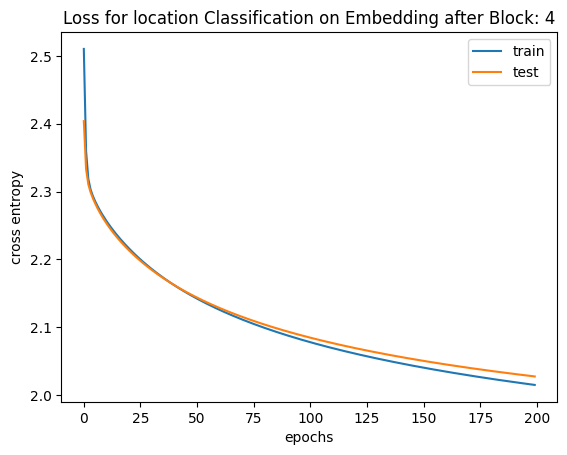

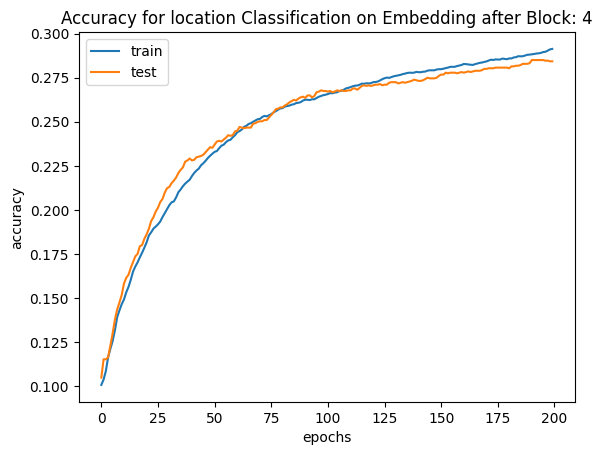

In [137]:
n_epochs = 200
batch_size = 64
batches_per_epoch = len(X_train) // batch_size

# Freeze the parameters of the rest of the model
for param in model.parameters():
    param.requires_grad = False

# # Allow the parameters of the final layer to be updated during training
for param in model.fc3.parameters():
    param.requires_grad = True
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters in the model are: {total_params}")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of paramerters being trained: ", total_trainable_params)

best_loss = np.inf  # Initialize to infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []

# Define the optimizer to update only the parameters of the final layer
# optimizer = torch.optim.SGD(model.layer3.parameters(), lr=0.001)

# Training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    
    # Set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # Take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            # Forward pass
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Update weights
            optimizer.step()

            # Compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # Set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)
        y_val_batch = y_val_tensor.to(device)
        y_pred = model(X_test_batch)
        ce = criterion(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if ce < best_loss:
        best_loss = ce
        best_weights = copy.deepcopy(model.state_dict())

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

# Load the best weights and plot the results
model.load_state_dict(best_weights)

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()


In [138]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [139]:
torch.save(model, fr'{folder_name}{run_mode}_{Block_number}.pth')

In [140]:
model=torch.load(fr'{folder_name}{run_mode}_{Block_number}.pth')
model.to(device)

SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [141]:
X_test=train_ready(test_data,col_name)

In [142]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        output = model(feature.unsqueeze(0))
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred

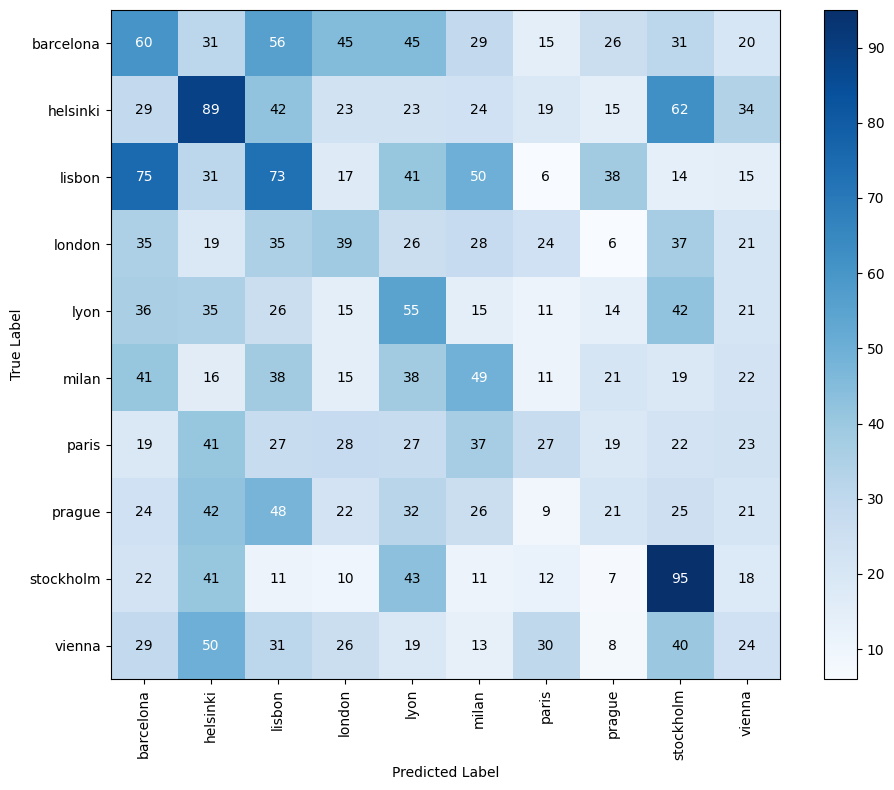

Accuracy: 0.1792


In [143]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)
# loss_list.append()

# Block-5

In [144]:
Block_number=5

In [145]:
model=torch.load(f'{base_dir}/small_model_scene_{Block_number}_opl.pth')

In [146]:
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)

In [147]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [148]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [149]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 10)
(2793, 10)


In [150]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters are {total_params}")
last_layer_params = list(model.parameters())[-2:]  # Assuming the last layer has both weight and bias parameters

# Count the total number of parameters in the last layer
num_params_last_layer = sum(p.numel() for p in last_layer_params)
print(f"Number of parameters in the last layer is {num_params_last_layer}")

Total number of paramerters are 199434
Number of parameters in the last layer is 2570


In [151]:
# for param in model.fc1.parameters():
#     param.requires_grad=False
for param in model.fc2.parameters():
    param.requires_grad = False

In [152]:
nn.init.xavier_uniform_(model.fc3.weight)
nn.init.constant_(model.fc3.bias, 0.0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [153]:
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of trainable parameters:", total_trainable_params)

Total number of trainable parameters: 2570


In [154]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc3.parameters(), lr=lr)

Total number of paramerters in the model are: 199434
Total number of paramerters being trained:  2570


Epoch 0: 100%|██████████| 174/174 [00:00<00:00, 482.59batch/s, acc=0.125, loss=2.48] 


Epoch 0 validation: Cross-entropy=2.44, Accuracy=12.0%


Epoch 1: 100%|██████████| 174/174 [00:00<00:00, 593.57batch/s, acc=0.109, loss=2.36] 


Epoch 1 validation: Cross-entropy=2.33, Accuracy=13.0%


Epoch 2: 100%|██████████| 174/174 [00:00<00:00, 699.36batch/s, acc=0.141, loss=2.34] 


Epoch 2 validation: Cross-entropy=2.30, Accuracy=13.3%


Epoch 3: 100%|██████████| 174/174 [00:00<00:00, 494.61batch/s, acc=0.156, loss=2.33] 


Epoch 3 validation: Cross-entropy=2.28, Accuracy=13.9%


Epoch 4: 100%|██████████| 174/174 [00:00<00:00, 699.91batch/s, acc=0.156, loss=2.32] 


Epoch 4 validation: Cross-entropy=2.27, Accuracy=14.2%


Epoch 5: 100%|██████████| 174/174 [00:00<00:00, 583.04batch/s, acc=0.141, loss=2.31] 


Epoch 5 validation: Cross-entropy=2.27, Accuracy=14.8%


Epoch 6: 100%|██████████| 174/174 [00:00<00:00, 587.25batch/s, acc=0.156, loss=2.3]  


Epoch 6 validation: Cross-entropy=2.26, Accuracy=15.1%


Epoch 7: 100%|██████████| 174/174 [00:00<00:00, 585.05batch/s, acc=0.156, loss=2.29] 


Epoch 7 validation: Cross-entropy=2.25, Accuracy=15.4%


Epoch 8: 100%|██████████| 174/174 [00:00<00:00, 576.04batch/s, acc=0.156, loss=2.28] 


Epoch 8 validation: Cross-entropy=2.24, Accuracy=15.9%


Epoch 9: 100%|██████████| 174/174 [00:00<00:00, 599.85batch/s, acc=0.156, loss=2.28] 


Epoch 9 validation: Cross-entropy=2.24, Accuracy=16.3%


Epoch 10: 100%|██████████| 174/174 [00:00<00:00, 590.67batch/s, acc=0.141, loss=2.27] 


Epoch 10 validation: Cross-entropy=2.23, Accuracy=16.6%


Epoch 11: 100%|██████████| 174/174 [00:00<00:00, 549.93batch/s, acc=0.141, loss=2.26] 


Epoch 11 validation: Cross-entropy=2.23, Accuracy=17.2%


Epoch 12: 100%|██████████| 174/174 [00:00<00:00, 726.45batch/s, acc=0.141, loss=2.26] 


Epoch 12 validation: Cross-entropy=2.22, Accuracy=17.4%


Epoch 13: 100%|██████████| 174/174 [00:00<00:00, 576.63batch/s, acc=0.141, loss=2.25]


Epoch 13 validation: Cross-entropy=2.22, Accuracy=17.7%


Epoch 14: 100%|██████████| 174/174 [00:00<00:00, 582.04batch/s, acc=0.156, loss=2.25]


Epoch 14 validation: Cross-entropy=2.21, Accuracy=18.0%


Epoch 15: 100%|██████████| 174/174 [00:00<00:00, 714.59batch/s, acc=0.156, loss=2.24] 


Epoch 15 validation: Cross-entropy=2.21, Accuracy=18.2%


Epoch 16: 100%|██████████| 174/174 [00:00<00:00, 477.28batch/s, acc=0.156, loss=2.24] 


Epoch 16 validation: Cross-entropy=2.20, Accuracy=18.2%


Epoch 17: 100%|██████████| 174/174 [00:00<00:00, 590.52batch/s, acc=0.141, loss=2.23] 


Epoch 17 validation: Cross-entropy=2.20, Accuracy=18.2%


Epoch 18: 100%|██████████| 174/174 [00:00<00:00, 698.34batch/s, acc=0.141, loss=2.23] 


Epoch 18 validation: Cross-entropy=2.19, Accuracy=18.3%


Epoch 19: 100%|██████████| 174/174 [00:00<00:00, 592.39batch/s, acc=0.172, loss=2.22]


Epoch 19 validation: Cross-entropy=2.19, Accuracy=18.8%


Epoch 20: 100%|██████████| 174/174 [00:00<00:00, 721.65batch/s, acc=0.156, loss=2.22]


Epoch 20 validation: Cross-entropy=2.19, Accuracy=19.2%


Epoch 21: 100%|██████████| 174/174 [00:00<00:00, 512.45batch/s, acc=0.172, loss=2.21]


Epoch 21 validation: Cross-entropy=2.18, Accuracy=19.2%


Epoch 22: 100%|██████████| 174/174 [00:00<00:00, 559.22batch/s, acc=0.172, loss=2.21]


Epoch 22 validation: Cross-entropy=2.18, Accuracy=19.5%


Epoch 23: 100%|██████████| 174/174 [00:00<00:00, 706.62batch/s, acc=0.172, loss=2.2] 


Epoch 23 validation: Cross-entropy=2.17, Accuracy=19.4%


Epoch 24: 100%|██████████| 174/174 [00:00<00:00, 587.40batch/s, acc=0.172, loss=2.2] 


Epoch 24 validation: Cross-entropy=2.17, Accuracy=19.8%


Epoch 25: 100%|██████████| 174/174 [00:00<00:00, 726.93batch/s, acc=0.172, loss=2.2] 


Epoch 25 validation: Cross-entropy=2.17, Accuracy=20.3%


Epoch 26: 100%|██████████| 174/174 [00:00<00:00, 616.56batch/s, acc=0.188, loss=2.19]


Epoch 26 validation: Cross-entropy=2.16, Accuracy=20.6%


Epoch 27: 100%|██████████| 174/174 [00:00<00:00, 492.98batch/s, acc=0.203, loss=2.19]


Epoch 27 validation: Cross-entropy=2.16, Accuracy=20.8%


Epoch 28: 100%|██████████| 174/174 [00:00<00:00, 709.23batch/s, acc=0.203, loss=2.19]


Epoch 28 validation: Cross-entropy=2.16, Accuracy=21.0%


Epoch 29: 100%|██████████| 174/174 [00:00<00:00, 544.55batch/s, acc=0.219, loss=2.18]


Epoch 29 validation: Cross-entropy=2.15, Accuracy=21.4%


Epoch 30: 100%|██████████| 174/174 [00:00<00:00, 581.59batch/s, acc=0.234, loss=2.18]


Epoch 30 validation: Cross-entropy=2.15, Accuracy=21.5%


Epoch 31: 100%|██████████| 174/174 [00:00<00:00, 728.82batch/s, acc=0.234, loss=2.18]


Epoch 31 validation: Cross-entropy=2.15, Accuracy=21.6%


Epoch 32: 100%|██████████| 174/174 [00:00<00:00, 559.50batch/s, acc=0.234, loss=2.17]


Epoch 32 validation: Cross-entropy=2.15, Accuracy=21.9%


Epoch 33: 100%|██████████| 174/174 [00:00<00:00, 725.38batch/s, acc=0.234, loss=2.17]


Epoch 33 validation: Cross-entropy=2.14, Accuracy=22.2%


Epoch 34: 100%|██████████| 174/174 [00:00<00:00, 496.16batch/s, acc=0.234, loss=2.17]


Epoch 34 validation: Cross-entropy=2.14, Accuracy=22.2%


Epoch 35: 100%|██████████| 174/174 [00:00<00:00, 595.82batch/s, acc=0.234, loss=2.16]


Epoch 35 validation: Cross-entropy=2.14, Accuracy=22.3%


Epoch 36: 100%|██████████| 174/174 [00:00<00:00, 719.44batch/s, acc=0.234, loss=2.16]


Epoch 36 validation: Cross-entropy=2.13, Accuracy=22.4%


Epoch 37: 100%|██████████| 174/174 [00:00<00:00, 590.60batch/s, acc=0.234, loss=2.16]


Epoch 37 validation: Cross-entropy=2.13, Accuracy=22.4%


Epoch 38: 100%|██████████| 174/174 [00:00<00:00, 722.76batch/s, acc=0.234, loss=2.16]


Epoch 38 validation: Cross-entropy=2.13, Accuracy=22.4%


Epoch 39: 100%|██████████| 174/174 [00:00<00:00, 586.68batch/s, acc=0.234, loss=2.15]


Epoch 39 validation: Cross-entropy=2.13, Accuracy=22.6%


Epoch 40: 100%|██████████| 174/174 [00:00<00:00, 501.39batch/s, acc=0.234, loss=2.15]


Epoch 40 validation: Cross-entropy=2.12, Accuracy=22.8%


Epoch 41: 100%|██████████| 174/174 [00:00<00:00, 736.25batch/s, acc=0.234, loss=2.15]


Epoch 41 validation: Cross-entropy=2.12, Accuracy=22.8%


Epoch 42: 100%|██████████| 174/174 [00:00<00:00, 593.30batch/s, acc=0.234, loss=2.15]


Epoch 42 validation: Cross-entropy=2.12, Accuracy=23.1%


Epoch 43: 100%|██████████| 174/174 [00:00<00:00, 629.84batch/s, acc=0.25, loss=2.14] 


Epoch 43 validation: Cross-entropy=2.12, Accuracy=23.1%


Epoch 44: 100%|██████████| 174/174 [00:00<00:00, 677.08batch/s, acc=0.25, loss=2.14] 


Epoch 44 validation: Cross-entropy=2.12, Accuracy=23.3%


Epoch 45: 100%|██████████| 174/174 [00:00<00:00, 491.36batch/s, acc=0.25, loss=2.14] 


Epoch 45 validation: Cross-entropy=2.11, Accuracy=23.4%


Epoch 46: 100%|██████████| 174/174 [00:00<00:00, 732.85batch/s, acc=0.25, loss=2.14] 


Epoch 46 validation: Cross-entropy=2.11, Accuracy=23.2%


Epoch 47: 100%|██████████| 174/174 [00:00<00:00, 593.38batch/s, acc=0.25, loss=2.14] 


Epoch 47 validation: Cross-entropy=2.11, Accuracy=23.5%


Epoch 48: 100%|██████████| 174/174 [00:00<00:00, 588.34batch/s, acc=0.266, loss=2.13]


Epoch 48 validation: Cross-entropy=2.11, Accuracy=23.6%


Epoch 49: 100%|██████████| 174/174 [00:00<00:00, 728.91batch/s, acc=0.281, loss=2.13]


Epoch 49 validation: Cross-entropy=2.10, Accuracy=23.7%


Epoch 50: 100%|██████████| 174/174 [00:00<00:00, 592.93batch/s, acc=0.281, loss=2.13]


Epoch 50 validation: Cross-entropy=2.10, Accuracy=23.9%


Epoch 51: 100%|██████████| 174/174 [00:00<00:00, 724.39batch/s, acc=0.281, loss=2.13]


Epoch 51 validation: Cross-entropy=2.10, Accuracy=24.0%


Epoch 52: 100%|██████████| 174/174 [00:00<00:00, 480.28batch/s, acc=0.281, loss=2.13]


Epoch 52 validation: Cross-entropy=2.10, Accuracy=24.0%


Epoch 53: 100%|██████████| 174/174 [00:00<00:00, 590.27batch/s, acc=0.297, loss=2.12]


Epoch 53 validation: Cross-entropy=2.10, Accuracy=24.2%


Epoch 54: 100%|██████████| 174/174 [00:00<00:00, 729.87batch/s, acc=0.297, loss=2.12]


Epoch 54 validation: Cross-entropy=2.10, Accuracy=24.3%


Epoch 55: 100%|██████████| 174/174 [00:00<00:00, 582.51batch/s, acc=0.297, loss=2.12]


Epoch 55 validation: Cross-entropy=2.09, Accuracy=24.5%


Epoch 56: 100%|██████████| 174/174 [00:00<00:00, 589.44batch/s, acc=0.297, loss=2.12]


Epoch 56 validation: Cross-entropy=2.09, Accuracy=24.6%


Epoch 57: 100%|██████████| 174/174 [00:00<00:00, 708.43batch/s, acc=0.297, loss=2.12]


Epoch 57 validation: Cross-entropy=2.09, Accuracy=24.9%


Epoch 58: 100%|██████████| 174/174 [00:00<00:00, 487.50batch/s, acc=0.297, loss=2.12]


Epoch 58 validation: Cross-entropy=2.09, Accuracy=25.1%


Epoch 59: 100%|██████████| 174/174 [00:00<00:00, 722.17batch/s, acc=0.297, loss=2.11]


Epoch 59 validation: Cross-entropy=2.09, Accuracy=25.1%


Epoch 60: 100%|██████████| 174/174 [00:00<00:00, 590.48batch/s, acc=0.297, loss=2.11]


Epoch 60 validation: Cross-entropy=2.08, Accuracy=25.3%


Epoch 61: 100%|██████████| 174/174 [00:00<00:00, 583.40batch/s, acc=0.297, loss=2.11]


Epoch 61 validation: Cross-entropy=2.08, Accuracy=25.3%


Epoch 62: 100%|██████████| 174/174 [00:00<00:00, 707.46batch/s, acc=0.297, loss=2.11]


Epoch 62 validation: Cross-entropy=2.08, Accuracy=25.5%


Epoch 63: 100%|██████████| 174/174 [00:00<00:00, 586.43batch/s, acc=0.297, loss=2.11]


Epoch 63 validation: Cross-entropy=2.08, Accuracy=25.4%


Epoch 64: 100%|██████████| 174/174 [00:00<00:00, 590.44batch/s, acc=0.297, loss=2.11]


Epoch 64 validation: Cross-entropy=2.08, Accuracy=25.5%


Epoch 65: 100%|██████████| 174/174 [00:00<00:00, 583.79batch/s, acc=0.297, loss=2.11]


Epoch 65 validation: Cross-entropy=2.08, Accuracy=25.6%


Epoch 66: 100%|██████████| 174/174 [00:00<00:00, 594.49batch/s, acc=0.297, loss=2.1] 


Epoch 66 validation: Cross-entropy=2.08, Accuracy=25.6%


Epoch 67: 100%|██████████| 174/174 [00:00<00:00, 719.62batch/s, acc=0.297, loss=2.1] 


Epoch 67 validation: Cross-entropy=2.07, Accuracy=25.9%


Epoch 68: 100%|██████████| 174/174 [00:00<00:00, 590.73batch/s, acc=0.297, loss=2.1] 


Epoch 68 validation: Cross-entropy=2.07, Accuracy=26.0%


Epoch 69: 100%|██████████| 174/174 [00:00<00:00, 600.72batch/s, acc=0.281, loss=2.1] 


Epoch 69 validation: Cross-entropy=2.07, Accuracy=26.1%


Epoch 70: 100%|██████████| 174/174 [00:00<00:00, 556.81batch/s, acc=0.281, loss=2.1] 


Epoch 70 validation: Cross-entropy=2.07, Accuracy=26.2%


Epoch 71: 100%|██████████| 174/174 [00:00<00:00, 578.41batch/s, acc=0.281, loss=2.1] 


Epoch 71 validation: Cross-entropy=2.07, Accuracy=26.2%


Epoch 72: 100%|██████████| 174/174 [00:00<00:00, 706.90batch/s, acc=0.281, loss=2.1] 


Epoch 72 validation: Cross-entropy=2.07, Accuracy=26.2%


Epoch 73: 100%|██████████| 174/174 [00:00<00:00, 578.31batch/s, acc=0.297, loss=2.09]


Epoch 73 validation: Cross-entropy=2.07, Accuracy=26.3%


Epoch 74: 100%|██████████| 174/174 [00:00<00:00, 636.08batch/s, acc=0.297, loss=2.09]


Epoch 74 validation: Cross-entropy=2.06, Accuracy=26.5%


Epoch 75: 100%|██████████| 174/174 [00:00<00:00, 559.09batch/s, acc=0.297, loss=2.09]


Epoch 75 validation: Cross-entropy=2.06, Accuracy=26.7%


Epoch 76: 100%|██████████| 174/174 [00:00<00:00, 575.15batch/s, acc=0.297, loss=2.09]


Epoch 76 validation: Cross-entropy=2.06, Accuracy=26.6%


Epoch 77: 100%|██████████| 174/174 [00:00<00:00, 718.46batch/s, acc=0.312, loss=2.09]


Epoch 77 validation: Cross-entropy=2.06, Accuracy=26.6%


Epoch 78: 100%|██████████| 174/174 [00:00<00:00, 579.64batch/s, acc=0.312, loss=2.09]


Epoch 78 validation: Cross-entropy=2.06, Accuracy=26.6%


Epoch 79: 100%|██████████| 174/174 [00:00<00:00, 583.05batch/s, acc=0.312, loss=2.09]


Epoch 79 validation: Cross-entropy=2.06, Accuracy=26.7%


Epoch 80: 100%|██████████| 174/174 [00:00<00:00, 692.91batch/s, acc=0.312, loss=2.09]


Epoch 80 validation: Cross-entropy=2.06, Accuracy=26.8%


Epoch 81: 100%|██████████| 174/174 [00:00<00:00, 512.05batch/s, acc=0.312, loss=2.09]


Epoch 81 validation: Cross-entropy=2.05, Accuracy=26.8%


Epoch 82: 100%|██████████| 174/174 [00:00<00:00, 678.03batch/s, acc=0.312, loss=2.08]


Epoch 82 validation: Cross-entropy=2.05, Accuracy=26.8%


Epoch 83: 100%|██████████| 174/174 [00:00<00:00, 586.57batch/s, acc=0.312, loss=2.08]


Epoch 83 validation: Cross-entropy=2.05, Accuracy=27.0%


Epoch 84: 100%|██████████| 174/174 [00:00<00:00, 555.01batch/s, acc=0.328, loss=2.08]


Epoch 84 validation: Cross-entropy=2.05, Accuracy=27.0%


Epoch 85: 100%|██████████| 174/174 [00:00<00:00, 720.63batch/s, acc=0.328, loss=2.08]


Epoch 85 validation: Cross-entropy=2.05, Accuracy=27.1%


Epoch 86: 100%|██████████| 174/174 [00:00<00:00, 586.46batch/s, acc=0.328, loss=2.08]


Epoch 86 validation: Cross-entropy=2.05, Accuracy=27.2%


Epoch 87: 100%|██████████| 174/174 [00:00<00:00, 640.24batch/s, acc=0.328, loss=2.08]


Epoch 87 validation: Cross-entropy=2.05, Accuracy=27.4%


Epoch 88: 100%|██████████| 174/174 [00:00<00:00, 547.50batch/s, acc=0.328, loss=2.08]


Epoch 88 validation: Cross-entropy=2.05, Accuracy=27.4%


Epoch 89: 100%|██████████| 174/174 [00:00<00:00, 581.27batch/s, acc=0.328, loss=2.08]


Epoch 89 validation: Cross-entropy=2.05, Accuracy=27.4%


Epoch 90: 100%|██████████| 174/174 [00:00<00:00, 705.12batch/s, acc=0.328, loss=2.08]


Epoch 90 validation: Cross-entropy=2.04, Accuracy=27.5%


Epoch 91: 100%|██████████| 174/174 [00:00<00:00, 583.67batch/s, acc=0.328, loss=2.08]


Epoch 91 validation: Cross-entropy=2.04, Accuracy=27.5%


Epoch 92: 100%|██████████| 174/174 [00:00<00:00, 555.44batch/s, acc=0.328, loss=2.07]


Epoch 92 validation: Cross-entropy=2.04, Accuracy=27.6%


Epoch 93: 100%|██████████| 174/174 [00:00<00:00, 586.31batch/s, acc=0.328, loss=2.07]


Epoch 93 validation: Cross-entropy=2.04, Accuracy=27.6%


Epoch 94: 100%|██████████| 174/174 [00:00<00:00, 575.79batch/s, acc=0.328, loss=2.07]


Epoch 94 validation: Cross-entropy=2.04, Accuracy=27.6%


Epoch 95: 100%|██████████| 174/174 [00:00<00:00, 715.33batch/s, acc=0.328, loss=2.07]


Epoch 95 validation: Cross-entropy=2.04, Accuracy=27.6%


Epoch 96: 100%|██████████| 174/174 [00:00<00:00, 584.75batch/s, acc=0.328, loss=2.07]


Epoch 96 validation: Cross-entropy=2.04, Accuracy=27.5%


Epoch 97: 100%|██████████| 174/174 [00:00<00:00, 573.23batch/s, acc=0.328, loss=2.07]


Epoch 97 validation: Cross-entropy=2.04, Accuracy=27.5%


Epoch 98: 100%|██████████| 174/174 [00:00<00:00, 719.98batch/s, acc=0.328, loss=2.07]


Epoch 98 validation: Cross-entropy=2.04, Accuracy=27.5%


Epoch 99: 100%|██████████| 174/174 [00:00<00:00, 511.42batch/s, acc=0.328, loss=2.07]


Epoch 99 validation: Cross-entropy=2.03, Accuracy=27.6%


Epoch 100: 100%|██████████| 174/174 [00:00<00:00, 581.08batch/s, acc=0.328, loss=2.07]


Epoch 100 validation: Cross-entropy=2.03, Accuracy=27.6%


Epoch 101: 100%|██████████| 174/174 [00:00<00:00, 713.72batch/s, acc=0.328, loss=2.07]


Epoch 101 validation: Cross-entropy=2.03, Accuracy=27.6%


Epoch 102: 100%|██████████| 174/174 [00:00<00:00, 580.85batch/s, acc=0.328, loss=2.07]


Epoch 102 validation: Cross-entropy=2.03, Accuracy=27.7%


Epoch 103: 100%|██████████| 174/174 [00:00<00:00, 685.01batch/s, acc=0.328, loss=2.07]


Epoch 103 validation: Cross-entropy=2.03, Accuracy=27.6%


Epoch 104: 100%|██████████| 174/174 [00:00<00:00, 636.53batch/s, acc=0.328, loss=2.07]


Epoch 104 validation: Cross-entropy=2.03, Accuracy=27.7%


Epoch 105: 100%|██████████| 174/174 [00:00<00:00, 580.34batch/s, acc=0.328, loss=2.06]


Epoch 105 validation: Cross-entropy=2.03, Accuracy=27.7%


Epoch 106: 100%|██████████| 174/174 [00:00<00:00, 585.02batch/s, acc=0.328, loss=2.06]


Epoch 106 validation: Cross-entropy=2.03, Accuracy=27.7%


Epoch 107: 100%|██████████| 174/174 [00:00<00:00, 569.01batch/s, acc=0.328, loss=2.06]


Epoch 107 validation: Cross-entropy=2.03, Accuracy=27.7%


Epoch 108: 100%|██████████| 174/174 [00:00<00:00, 597.01batch/s, acc=0.328, loss=2.06]


Epoch 108 validation: Cross-entropy=2.03, Accuracy=27.7%


Epoch 109: 100%|██████████| 174/174 [00:00<00:00, 702.35batch/s, acc=0.328, loss=2.06]


Epoch 109 validation: Cross-entropy=2.03, Accuracy=27.8%


Epoch 110: 100%|██████████| 174/174 [00:00<00:00, 575.38batch/s, acc=0.328, loss=2.06]


Epoch 110 validation: Cross-entropy=2.02, Accuracy=27.9%


Epoch 111: 100%|██████████| 174/174 [00:00<00:00, 715.45batch/s, acc=0.328, loss=2.06]


Epoch 111 validation: Cross-entropy=2.02, Accuracy=28.0%


Epoch 112: 100%|██████████| 174/174 [00:00<00:00, 488.86batch/s, acc=0.328, loss=2.06]


Epoch 112 validation: Cross-entropy=2.02, Accuracy=27.9%


Epoch 113: 100%|██████████| 174/174 [00:00<00:00, 586.76batch/s, acc=0.328, loss=2.06]


Epoch 113 validation: Cross-entropy=2.02, Accuracy=27.9%


Epoch 114: 100%|██████████| 174/174 [00:00<00:00, 717.82batch/s, acc=0.328, loss=2.06]


Epoch 114 validation: Cross-entropy=2.02, Accuracy=27.9%


Epoch 115: 100%|██████████| 174/174 [00:00<00:00, 580.13batch/s, acc=0.328, loss=2.06]


Epoch 115 validation: Cross-entropy=2.02, Accuracy=28.0%


Epoch 116: 100%|██████████| 174/174 [00:00<00:00, 640.09batch/s, acc=0.328, loss=2.06]


Epoch 116 validation: Cross-entropy=2.02, Accuracy=28.0%


Epoch 117: 100%|██████████| 174/174 [00:00<00:00, 548.40batch/s, acc=0.328, loss=2.06]


Epoch 117 validation: Cross-entropy=2.02, Accuracy=28.0%


Epoch 118: 100%|██████████| 174/174 [00:00<00:00, 579.28batch/s, acc=0.328, loss=2.06]


Epoch 118 validation: Cross-entropy=2.02, Accuracy=28.0%


Epoch 119: 100%|██████████| 174/174 [00:00<00:00, 723.25batch/s, acc=0.328, loss=2.05]


Epoch 119 validation: Cross-entropy=2.02, Accuracy=28.1%


Epoch 120: 100%|██████████| 174/174 [00:00<00:00, 587.10batch/s, acc=0.328, loss=2.05]


Epoch 120 validation: Cross-entropy=2.02, Accuracy=28.1%


Epoch 121: 100%|██████████| 174/174 [00:00<00:00, 593.73batch/s, acc=0.328, loss=2.05]


Epoch 121 validation: Cross-entropy=2.02, Accuracy=28.1%


Epoch 122: 100%|██████████| 174/174 [00:00<00:00, 690.43batch/s, acc=0.328, loss=2.05]


Epoch 122 validation: Cross-entropy=2.01, Accuracy=28.2%


Epoch 123: 100%|██████████| 174/174 [00:00<00:00, 498.64batch/s, acc=0.328, loss=2.05]


Epoch 123 validation: Cross-entropy=2.01, Accuracy=28.2%


Epoch 124: 100%|██████████| 174/174 [00:00<00:00, 710.59batch/s, acc=0.328, loss=2.05]


Epoch 124 validation: Cross-entropy=2.01, Accuracy=28.2%


Epoch 125: 100%|██████████| 174/174 [00:00<00:00, 584.98batch/s, acc=0.328, loss=2.05]


Epoch 125 validation: Cross-entropy=2.01, Accuracy=28.3%


Epoch 126: 100%|██████████| 174/174 [00:00<00:00, 578.74batch/s, acc=0.328, loss=2.05]


Epoch 126 validation: Cross-entropy=2.01, Accuracy=28.3%


Epoch 127: 100%|██████████| 174/174 [00:00<00:00, 703.74batch/s, acc=0.328, loss=2.05]


Epoch 127 validation: Cross-entropy=2.01, Accuracy=28.3%


Epoch 128: 100%|██████████| 174/174 [00:00<00:00, 576.60batch/s, acc=0.328, loss=2.05]


Epoch 128 validation: Cross-entropy=2.01, Accuracy=28.3%


Epoch 129: 100%|██████████| 174/174 [00:00<00:00, 592.02batch/s, acc=0.328, loss=2.05]


Epoch 129 validation: Cross-entropy=2.01, Accuracy=28.3%


Epoch 130: 100%|██████████| 174/174 [00:00<00:00, 555.50batch/s, acc=0.328, loss=2.05]


Epoch 130 validation: Cross-entropy=2.01, Accuracy=28.5%


Epoch 131: 100%|██████████| 174/174 [00:00<00:00, 580.43batch/s, acc=0.328, loss=2.05]


Epoch 131 validation: Cross-entropy=2.01, Accuracy=28.5%


Epoch 132: 100%|██████████| 174/174 [00:00<00:00, 718.64batch/s, acc=0.328, loss=2.05]


Epoch 132 validation: Cross-entropy=2.01, Accuracy=28.5%


Epoch 133: 100%|██████████| 174/174 [00:00<00:00, 584.72batch/s, acc=0.328, loss=2.05]


Epoch 133 validation: Cross-entropy=2.01, Accuracy=28.5%


Epoch 134: 100%|██████████| 174/174 [00:00<00:00, 592.93batch/s, acc=0.328, loss=2.05]


Epoch 134 validation: Cross-entropy=2.01, Accuracy=28.5%


Epoch 135: 100%|██████████| 174/174 [00:00<00:00, 554.95batch/s, acc=0.328, loss=2.05]


Epoch 135 validation: Cross-entropy=2.00, Accuracy=28.5%


Epoch 136: 100%|██████████| 174/174 [00:00<00:00, 583.47batch/s, acc=0.328, loss=2.04]


Epoch 136 validation: Cross-entropy=2.00, Accuracy=28.4%


Epoch 137: 100%|██████████| 174/174 [00:00<00:00, 719.39batch/s, acc=0.328, loss=2.04]


Epoch 137 validation: Cross-entropy=2.00, Accuracy=28.4%


Epoch 138: 100%|██████████| 174/174 [00:00<00:00, 587.72batch/s, acc=0.328, loss=2.04]


Epoch 138 validation: Cross-entropy=2.00, Accuracy=28.5%


Epoch 139: 100%|██████████| 174/174 [00:00<00:00, 580.49batch/s, acc=0.328, loss=2.04]


Epoch 139 validation: Cross-entropy=2.00, Accuracy=28.5%


Epoch 140: 100%|██████████| 174/174 [00:00<00:00, 718.79batch/s, acc=0.328, loss=2.04]


Epoch 140 validation: Cross-entropy=2.00, Accuracy=28.5%


Epoch 141: 100%|██████████| 174/174 [00:00<00:00, 481.26batch/s, acc=0.328, loss=2.04]


Epoch 141 validation: Cross-entropy=2.00, Accuracy=28.5%


Epoch 142: 100%|██████████| 174/174 [00:00<00:00, 660.52batch/s, acc=0.328, loss=2.04]


Epoch 142 validation: Cross-entropy=2.00, Accuracy=28.6%


Epoch 143: 100%|██████████| 174/174 [00:00<00:00, 653.19batch/s, acc=0.328, loss=2.04]


Epoch 143 validation: Cross-entropy=2.00, Accuracy=28.6%


Epoch 144: 100%|██████████| 174/174 [00:00<00:00, 582.20batch/s, acc=0.328, loss=2.04]


Epoch 144 validation: Cross-entropy=2.00, Accuracy=28.7%


Epoch 145: 100%|██████████| 174/174 [00:00<00:00, 723.19batch/s, acc=0.328, loss=2.04]


Epoch 145 validation: Cross-entropy=2.00, Accuracy=28.8%


Epoch 146: 100%|██████████| 174/174 [00:00<00:00, 586.42batch/s, acc=0.328, loss=2.04]


Epoch 146 validation: Cross-entropy=2.00, Accuracy=28.7%


Epoch 147: 100%|██████████| 174/174 [00:00<00:00, 500.70batch/s, acc=0.328, loss=2.04]


Epoch 147 validation: Cross-entropy=2.00, Accuracy=28.8%


Epoch 148: 100%|██████████| 174/174 [00:00<00:00, 691.75batch/s, acc=0.328, loss=2.04]


Epoch 148 validation: Cross-entropy=2.00, Accuracy=28.8%


Epoch 149: 100%|██████████| 174/174 [00:00<00:00, 574.68batch/s, acc=0.328, loss=2.04]


Epoch 149 validation: Cross-entropy=2.00, Accuracy=28.8%


Epoch 150: 100%|██████████| 174/174 [00:00<00:00, 714.70batch/s, acc=0.328, loss=2.04]


Epoch 150 validation: Cross-entropy=1.99, Accuracy=28.8%


Epoch 151: 100%|██████████| 174/174 [00:00<00:00, 567.00batch/s, acc=0.328, loss=2.04]


Epoch 151 validation: Cross-entropy=1.99, Accuracy=28.8%


Epoch 152: 100%|██████████| 174/174 [00:00<00:00, 578.18batch/s, acc=0.328, loss=2.04]


Epoch 152 validation: Cross-entropy=1.99, Accuracy=28.8%


Epoch 153: 100%|██████████| 174/174 [00:00<00:00, 598.34batch/s, acc=0.328, loss=2.04]


Epoch 153 validation: Cross-entropy=1.99, Accuracy=28.8%


Epoch 154: 100%|██████████| 174/174 [00:00<00:00, 583.08batch/s, acc=0.312, loss=2.04]


Epoch 154 validation: Cross-entropy=1.99, Accuracy=28.8%


Epoch 155: 100%|██████████| 174/174 [00:00<00:00, 604.86batch/s, acc=0.312, loss=2.04]


Epoch 155 validation: Cross-entropy=1.99, Accuracy=28.8%


Epoch 156: 100%|██████████| 174/174 [00:00<00:00, 678.71batch/s, acc=0.312, loss=2.03]


Epoch 156 validation: Cross-entropy=1.99, Accuracy=28.9%


Epoch 157: 100%|██████████| 174/174 [00:00<00:00, 581.01batch/s, acc=0.312, loss=2.03]


Epoch 157 validation: Cross-entropy=1.99, Accuracy=28.9%


Epoch 158: 100%|██████████| 174/174 [00:00<00:00, 705.26batch/s, acc=0.312, loss=2.03]


Epoch 158 validation: Cross-entropy=1.99, Accuracy=28.9%


Epoch 159: 100%|██████████| 174/174 [00:00<00:00, 502.16batch/s, acc=0.312, loss=2.03]


Epoch 159 validation: Cross-entropy=1.99, Accuracy=28.9%


Epoch 160: 100%|██████████| 174/174 [00:00<00:00, 570.16batch/s, acc=0.328, loss=2.03]


Epoch 160 validation: Cross-entropy=1.99, Accuracy=28.9%


Epoch 161: 100%|██████████| 174/174 [00:00<00:00, 716.34batch/s, acc=0.328, loss=2.03]


Epoch 161 validation: Cross-entropy=1.99, Accuracy=29.0%


Epoch 162: 100%|██████████| 174/174 [00:00<00:00, 588.75batch/s, acc=0.328, loss=2.03]


Epoch 162 validation: Cross-entropy=1.99, Accuracy=28.9%


Epoch 163: 100%|██████████| 174/174 [00:00<00:00, 723.06batch/s, acc=0.328, loss=2.03]


Epoch 163 validation: Cross-entropy=1.99, Accuracy=29.0%


Epoch 164: 100%|██████████| 174/174 [00:00<00:00, 571.74batch/s, acc=0.328, loss=2.03]


Epoch 164 validation: Cross-entropy=1.99, Accuracy=29.0%


Epoch 165: 100%|██████████| 174/174 [00:00<00:00, 485.99batch/s, acc=0.328, loss=2.03]


Epoch 165 validation: Cross-entropy=1.99, Accuracy=29.1%


Epoch 166: 100%|██████████| 174/174 [00:00<00:00, 712.58batch/s, acc=0.312, loss=2.03]


Epoch 166 validation: Cross-entropy=1.99, Accuracy=29.1%


Epoch 167: 100%|██████████| 174/174 [00:00<00:00, 580.93batch/s, acc=0.312, loss=2.03]


Epoch 167 validation: Cross-entropy=1.98, Accuracy=29.1%


Epoch 168: 100%|██████████| 174/174 [00:00<00:00, 624.28batch/s, acc=0.312, loss=2.03]


Epoch 168 validation: Cross-entropy=1.98, Accuracy=29.1%


Epoch 169: 100%|██████████| 174/174 [00:00<00:00, 683.20batch/s, acc=0.312, loss=2.03]


Epoch 169 validation: Cross-entropy=1.98, Accuracy=29.1%


Epoch 170: 100%|██████████| 174/174 [00:00<00:00, 588.51batch/s, acc=0.312, loss=2.03]


Epoch 170 validation: Cross-entropy=1.98, Accuracy=29.2%


Epoch 171: 100%|██████████| 174/174 [00:00<00:00, 574.99batch/s, acc=0.312, loss=2.03]


Epoch 171 validation: Cross-entropy=1.98, Accuracy=29.1%


Epoch 172: 100%|██████████| 174/174 [00:00<00:00, 546.10batch/s, acc=0.312, loss=2.03]


Epoch 172 validation: Cross-entropy=1.98, Accuracy=29.2%


Epoch 173: 100%|██████████| 174/174 [00:00<00:00, 584.02batch/s, acc=0.312, loss=2.03]


Epoch 173 validation: Cross-entropy=1.98, Accuracy=29.2%


Epoch 174: 100%|██████████| 174/174 [00:00<00:00, 719.06batch/s, acc=0.312, loss=2.03]


Epoch 174 validation: Cross-entropy=1.98, Accuracy=29.3%


Epoch 175: 100%|██████████| 174/174 [00:00<00:00, 582.62batch/s, acc=0.312, loss=2.03]


Epoch 175 validation: Cross-entropy=1.98, Accuracy=29.3%


Epoch 176: 100%|██████████| 174/174 [00:00<00:00, 726.10batch/s, acc=0.312, loss=2.03]


Epoch 176 validation: Cross-entropy=1.98, Accuracy=29.3%


Epoch 177: 100%|██████████| 174/174 [00:00<00:00, 509.02batch/s, acc=0.312, loss=2.03]


Epoch 177 validation: Cross-entropy=1.98, Accuracy=29.3%


Epoch 178: 100%|██████████| 174/174 [00:00<00:00, 584.85batch/s, acc=0.312, loss=2.03]


Epoch 178 validation: Cross-entropy=1.98, Accuracy=29.3%


Epoch 179: 100%|██████████| 174/174 [00:00<00:00, 711.57batch/s, acc=0.312, loss=2.03]


Epoch 179 validation: Cross-entropy=1.98, Accuracy=29.3%


Epoch 180: 100%|██████████| 174/174 [00:00<00:00, 553.84batch/s, acc=0.312, loss=2.02]


Epoch 180 validation: Cross-entropy=1.98, Accuracy=29.4%


Epoch 181: 100%|██████████| 174/174 [00:00<00:00, 711.02batch/s, acc=0.312, loss=2.02]


Epoch 181 validation: Cross-entropy=1.98, Accuracy=29.4%


Epoch 182: 100%|██████████| 174/174 [00:00<00:00, 580.89batch/s, acc=0.312, loss=2.02]


Epoch 182 validation: Cross-entropy=1.98, Accuracy=29.5%


Epoch 183: 100%|██████████| 174/174 [00:00<00:00, 447.16batch/s, acc=0.312, loss=2.02]


Epoch 183 validation: Cross-entropy=1.98, Accuracy=29.4%


Epoch 184: 100%|██████████| 174/174 [00:00<00:00, 712.54batch/s, acc=0.312, loss=2.02]


Epoch 184 validation: Cross-entropy=1.98, Accuracy=29.4%


Epoch 185: 100%|██████████| 174/174 [00:00<00:00, 580.75batch/s, acc=0.312, loss=2.02]


Epoch 185 validation: Cross-entropy=1.98, Accuracy=29.5%


Epoch 186: 100%|██████████| 174/174 [00:00<00:00, 629.38batch/s, acc=0.312, loss=2.02]


Epoch 186 validation: Cross-entropy=1.98, Accuracy=29.7%


Epoch 187: 100%|██████████| 174/174 [00:00<00:00, 628.20batch/s, acc=0.312, loss=2.02]


Epoch 187 validation: Cross-entropy=1.97, Accuracy=29.8%


Epoch 188: 100%|██████████| 174/174 [00:00<00:00, 580.03batch/s, acc=0.312, loss=2.02]


Epoch 188 validation: Cross-entropy=1.97, Accuracy=29.8%


Epoch 189: 100%|██████████| 174/174 [00:00<00:00, 593.59batch/s, acc=0.312, loss=2.02]


Epoch 189 validation: Cross-entropy=1.97, Accuracy=29.8%


Epoch 190: 100%|██████████| 174/174 [00:00<00:00, 575.55batch/s, acc=0.312, loss=2.02]


Epoch 190 validation: Cross-entropy=1.97, Accuracy=29.8%


Epoch 191: 100%|██████████| 174/174 [00:00<00:00, 594.27batch/s, acc=0.312, loss=2.02]


Epoch 191 validation: Cross-entropy=1.97, Accuracy=29.9%


Epoch 192: 100%|██████████| 174/174 [00:00<00:00, 692.94batch/s, acc=0.312, loss=2.02]


Epoch 192 validation: Cross-entropy=1.97, Accuracy=29.9%


Epoch 193: 100%|██████████| 174/174 [00:00<00:00, 569.65batch/s, acc=0.312, loss=2.02]


Epoch 193 validation: Cross-entropy=1.97, Accuracy=29.9%


Epoch 194: 100%|██████████| 174/174 [00:00<00:00, 709.38batch/s, acc=0.312, loss=2.02]


Epoch 194 validation: Cross-entropy=1.97, Accuracy=29.9%


Epoch 195: 100%|██████████| 174/174 [00:00<00:00, 467.07batch/s, acc=0.312, loss=2.02]


Epoch 195 validation: Cross-entropy=1.97, Accuracy=29.9%


Epoch 196: 100%|██████████| 174/174 [00:00<00:00, 574.49batch/s, acc=0.312, loss=2.02]


Epoch 196 validation: Cross-entropy=1.97, Accuracy=30.0%


Epoch 197: 100%|██████████| 174/174 [00:00<00:00, 711.84batch/s, acc=0.312, loss=2.02]


Epoch 197 validation: Cross-entropy=1.97, Accuracy=30.0%


Epoch 198: 100%|██████████| 174/174 [00:00<00:00, 579.21batch/s, acc=0.312, loss=2.02]


Epoch 198 validation: Cross-entropy=1.97, Accuracy=30.1%


Epoch 199: 100%|██████████| 174/174 [00:00<00:00, 591.24batch/s, acc=0.312, loss=2.02]


Epoch 199 validation: Cross-entropy=1.97, Accuracy=30.1%


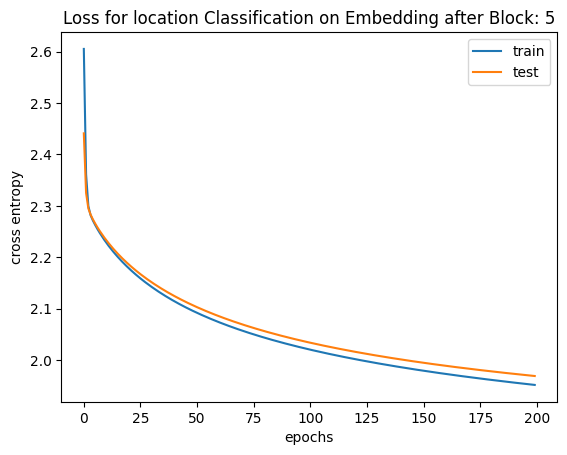

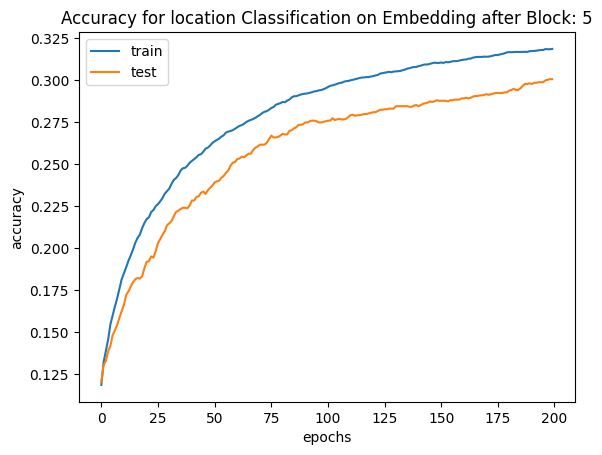

In [155]:
n_epochs = 200
batch_size = 64
batches_per_epoch = len(X_train) // batch_size

# Freeze the parameters of the rest of the model
for param in model.parameters():
    param.requires_grad = False

# # Allow the parameters of the final layer to be updated during training
for param in model.fc3.parameters():
    param.requires_grad = True
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters in the model are: {total_params}")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of paramerters being trained: ", total_trainable_params)

best_loss = np.inf  # Initialize to infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []

# Define the optimizer to update only the parameters of the final layer
# optimizer = torch.optim.SGD(model.layer3.parameters(), lr=0.001)

# Training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    
    # Set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # Take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            # Forward pass
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Update weights
            optimizer.step()

            # Compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # Set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)
        y_val_batch = y_val_tensor.to(device)
        y_pred = model(X_test_batch)
        ce = criterion(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if ce < best_loss:
        best_loss = ce
        best_weights = copy.deepcopy(model.state_dict())

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

# Load the best weights and plot the results
model.load_state_dict(best_weights)

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()


In [156]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [157]:
torch.save(model, fr'{folder_name}{run_mode}_{Block_number}.pth')

In [158]:
model=torch.load(fr'{folder_name}{run_mode}_{Block_number}.pth')
model.to(device)

SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [159]:
X_test=train_ready(test_data,col_name)

In [160]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        output = model(feature.unsqueeze(0))
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred

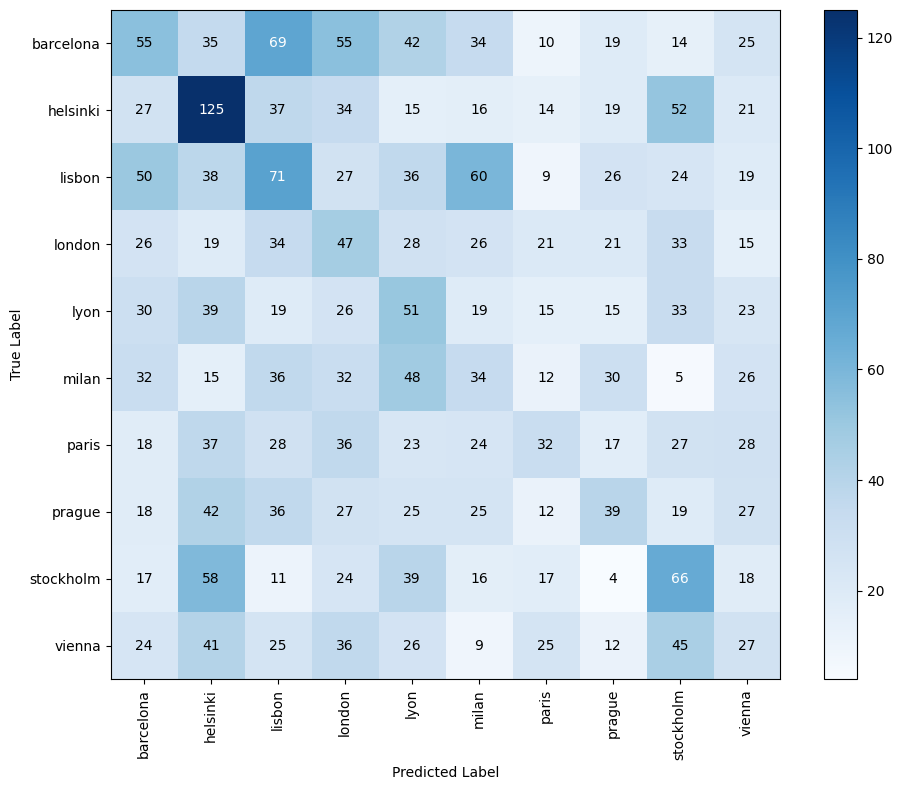

Accuracy: 0.1843


In [161]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)
# loss_list.append()

# Block-6

In [162]:
Block_number=6

In [163]:
model=torch.load(f'{base_dir}/small_model_scene_{Block_number}_opl.pth')

In [164]:
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)

In [165]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [166]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [167]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 10)
(2793, 10)


In [168]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters are {total_params}")
last_layer_params = list(model.parameters())[-2:]  # Assuming the last layer has both weight and bias parameters

# Count the total number of parameters in the last layer
num_params_last_layer = sum(p.numel() for p in last_layer_params)
print(f"Number of parameters in the last layer is {num_params_last_layer}")

Total number of paramerters are 199434
Number of parameters in the last layer is 2570


In [169]:
# for param in model.fc1.parameters():
#     param.requires_grad=False
for param in model.fc2.parameters():
    param.requires_grad = False

In [170]:
nn.init.xavier_uniform_(model.fc3.weight)
nn.init.constant_(model.fc3.bias, 0.0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [171]:
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of trainable parameters:", total_trainable_params)

Total number of trainable parameters: 2570


In [172]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc3.parameters(), lr=lr)

Total number of paramerters in the model are: 199434
Total number of paramerters being trained:  2570


Epoch 0: 100%|██████████| 174/174 [00:00<00:00, 481.21batch/s, acc=0.109, loss=2.8]  


Epoch 0 validation: Cross-entropy=2.72, Accuracy=10.0%


Epoch 1: 100%|██████████| 174/174 [00:00<00:00, 698.15batch/s, acc=0.0938, loss=2.54]


Epoch 1 validation: Cross-entropy=2.46, Accuracy=11.4%


Epoch 2: 100%|██████████| 174/174 [00:00<00:00, 567.43batch/s, acc=0.109, loss=2.45] 


Epoch 2 validation: Cross-entropy=2.38, Accuracy=12.4%


Epoch 3: 100%|██████████| 174/174 [00:00<00:00, 570.82batch/s, acc=0.125, loss=2.41] 


Epoch 3 validation: Cross-entropy=2.34, Accuracy=13.1%


Epoch 4: 100%|██████████| 174/174 [00:00<00:00, 574.13batch/s, acc=0.125, loss=2.37] 


Epoch 4 validation: Cross-entropy=2.31, Accuracy=14.0%


Epoch 5: 100%|██████████| 174/174 [00:00<00:00, 577.51batch/s, acc=0.156, loss=2.35] 


Epoch 5 validation: Cross-entropy=2.30, Accuracy=14.5%


Epoch 6: 100%|██████████| 174/174 [00:00<00:00, 569.25batch/s, acc=0.156, loss=2.33] 


Epoch 6 validation: Cross-entropy=2.28, Accuracy=14.6%


Epoch 7: 100%|██████████| 174/174 [00:00<00:00, 704.26batch/s, acc=0.156, loss=2.32] 


Epoch 7 validation: Cross-entropy=2.27, Accuracy=15.1%


Epoch 8: 100%|██████████| 174/174 [00:00<00:00, 535.50batch/s, acc=0.156, loss=2.3]  


Epoch 8 validation: Cross-entropy=2.26, Accuracy=16.0%


Epoch 9: 100%|██████████| 174/174 [00:00<00:00, 568.74batch/s, acc=0.156, loss=2.29] 


Epoch 9 validation: Cross-entropy=2.25, Accuracy=17.1%


Epoch 10: 100%|██████████| 174/174 [00:00<00:00, 560.35batch/s, acc=0.156, loss=2.28] 


Epoch 10 validation: Cross-entropy=2.24, Accuracy=17.5%


Epoch 11: 100%|██████████| 174/174 [00:00<00:00, 562.53batch/s, acc=0.172, loss=2.26] 


Epoch 11 validation: Cross-entropy=2.23, Accuracy=17.9%


Epoch 12: 100%|██████████| 174/174 [00:00<00:00, 655.98batch/s, acc=0.188, loss=2.25] 


Epoch 12 validation: Cross-entropy=2.23, Accuracy=18.4%


Epoch 13: 100%|██████████| 174/174 [00:00<00:00, 569.61batch/s, acc=0.203, loss=2.24] 


Epoch 13 validation: Cross-entropy=2.22, Accuracy=18.9%


Epoch 14: 100%|██████████| 174/174 [00:00<00:00, 473.93batch/s, acc=0.234, loss=2.24] 


Epoch 14 validation: Cross-entropy=2.21, Accuracy=19.4%


Epoch 15: 100%|██████████| 174/174 [00:00<00:00, 706.09batch/s, acc=0.219, loss=2.23] 


Epoch 15 validation: Cross-entropy=2.20, Accuracy=19.5%


Epoch 16: 100%|██████████| 174/174 [00:00<00:00, 561.91batch/s, acc=0.219, loss=2.22]


Epoch 16 validation: Cross-entropy=2.20, Accuracy=19.9%


Epoch 17: 100%|██████████| 174/174 [00:00<00:00, 712.95batch/s, acc=0.219, loss=2.21] 


Epoch 17 validation: Cross-entropy=2.19, Accuracy=20.4%


Epoch 18: 100%|██████████| 174/174 [00:00<00:00, 575.27batch/s, acc=0.219, loss=2.2] 


Epoch 18 validation: Cross-entropy=2.18, Accuracy=20.8%


Epoch 19: 100%|██████████| 174/174 [00:00<00:00, 567.89batch/s, acc=0.219, loss=2.2]  


Epoch 19 validation: Cross-entropy=2.18, Accuracy=21.2%


Epoch 20: 100%|██████████| 174/174 [00:00<00:00, 567.51batch/s, acc=0.219, loss=2.19]


Epoch 20 validation: Cross-entropy=2.17, Accuracy=21.3%


Epoch 21: 100%|██████████| 174/174 [00:00<00:00, 552.00batch/s, acc=0.234, loss=2.18]


Epoch 21 validation: Cross-entropy=2.17, Accuracy=21.9%


Epoch 22: 100%|██████████| 174/174 [00:00<00:00, 569.44batch/s, acc=0.266, loss=2.18]


Epoch 22 validation: Cross-entropy=2.16, Accuracy=22.1%


Epoch 23: 100%|██████████| 174/174 [00:00<00:00, 713.72batch/s, acc=0.281, loss=2.17]


Epoch 23 validation: Cross-entropy=2.15, Accuracy=22.1%


Epoch 24: 100%|██████████| 174/174 [00:00<00:00, 570.34batch/s, acc=0.281, loss=2.17]


Epoch 24 validation: Cross-entropy=2.15, Accuracy=22.4%


Epoch 25: 100%|██████████| 174/174 [00:00<00:00, 710.51batch/s, acc=0.281, loss=2.16]


Epoch 25 validation: Cross-entropy=2.14, Accuracy=22.4%


Epoch 26: 100%|██████████| 174/174 [00:00<00:00, 485.85batch/s, acc=0.281, loss=2.15]


Epoch 26 validation: Cross-entropy=2.14, Accuracy=22.5%


Epoch 27: 100%|██████████| 174/174 [00:00<00:00, 570.68batch/s, acc=0.281, loss=2.15]


Epoch 27 validation: Cross-entropy=2.14, Accuracy=22.7%


Epoch 28: 100%|██████████| 174/174 [00:00<00:00, 717.80batch/s, acc=0.281, loss=2.14]


Epoch 28 validation: Cross-entropy=2.13, Accuracy=23.1%


Epoch 29: 100%|██████████| 174/174 [00:00<00:00, 580.66batch/s, acc=0.281, loss=2.14]


Epoch 29 validation: Cross-entropy=2.13, Accuracy=23.5%


Epoch 30: 100%|██████████| 174/174 [00:00<00:00, 717.64batch/s, acc=0.297, loss=2.14]


Epoch 30 validation: Cross-entropy=2.12, Accuracy=23.8%


Epoch 31: 100%|██████████| 174/174 [00:00<00:00, 574.22batch/s, acc=0.297, loss=2.13]


Epoch 31 validation: Cross-entropy=2.12, Accuracy=24.0%


Epoch 32: 100%|██████████| 174/174 [00:00<00:00, 442.60batch/s, acc=0.312, loss=2.13]


Epoch 32 validation: Cross-entropy=2.11, Accuracy=24.1%


Epoch 33: 100%|██████████| 174/174 [00:00<00:00, 712.66batch/s, acc=0.328, loss=2.12]


Epoch 33 validation: Cross-entropy=2.11, Accuracy=24.3%


Epoch 34: 100%|██████████| 174/174 [00:00<00:00, 582.64batch/s, acc=0.328, loss=2.12]


Epoch 34 validation: Cross-entropy=2.11, Accuracy=24.4%


Epoch 35: 100%|██████████| 174/174 [00:00<00:00, 572.18batch/s, acc=0.328, loss=2.11]


Epoch 35 validation: Cross-entropy=2.10, Accuracy=24.5%


Epoch 36: 100%|██████████| 174/174 [00:00<00:00, 715.73batch/s, acc=0.312, loss=2.11]


Epoch 36 validation: Cross-entropy=2.10, Accuracy=24.8%


Epoch 37: 100%|██████████| 174/174 [00:00<00:00, 576.89batch/s, acc=0.312, loss=2.11]


Epoch 37 validation: Cross-entropy=2.09, Accuracy=24.9%


Epoch 38: 100%|██████████| 174/174 [00:00<00:00, 543.09batch/s, acc=0.312, loss=2.1] 


Epoch 38 validation: Cross-entropy=2.09, Accuracy=25.0%


Epoch 39: 100%|██████████| 174/174 [00:00<00:00, 626.36batch/s, acc=0.297, loss=2.1] 


Epoch 39 validation: Cross-entropy=2.09, Accuracy=25.2%


Epoch 40: 100%|██████████| 174/174 [00:00<00:00, 573.25batch/s, acc=0.328, loss=2.1] 


Epoch 40 validation: Cross-entropy=2.08, Accuracy=25.4%


Epoch 41: 100%|██████████| 174/174 [00:00<00:00, 710.62batch/s, acc=0.312, loss=2.09]


Epoch 41 validation: Cross-entropy=2.08, Accuracy=25.5%


Epoch 42: 100%|██████████| 174/174 [00:00<00:00, 575.34batch/s, acc=0.312, loss=2.09]


Epoch 42 validation: Cross-entropy=2.08, Accuracy=25.6%


Epoch 43: 100%|██████████| 174/174 [00:00<00:00, 581.47batch/s, acc=0.312, loss=2.09]


Epoch 43 validation: Cross-entropy=2.08, Accuracy=25.9%


Epoch 44: 100%|██████████| 174/174 [00:00<00:00, 585.07batch/s, acc=0.312, loss=2.08]


Epoch 44 validation: Cross-entropy=2.07, Accuracy=26.2%


Epoch 45: 100%|██████████| 174/174 [00:00<00:00, 569.91batch/s, acc=0.328, loss=2.08]


Epoch 45 validation: Cross-entropy=2.07, Accuracy=26.5%


Epoch 46: 100%|██████████| 174/174 [00:00<00:00, 721.75batch/s, acc=0.328, loss=2.08]


Epoch 46 validation: Cross-entropy=2.07, Accuracy=26.7%


Epoch 47: 100%|██████████| 174/174 [00:00<00:00, 579.09batch/s, acc=0.328, loss=2.07]


Epoch 47 validation: Cross-entropy=2.06, Accuracy=26.7%


Epoch 48: 100%|██████████| 174/174 [00:00<00:00, 574.72batch/s, acc=0.328, loss=2.07]


Epoch 48 validation: Cross-entropy=2.06, Accuracy=26.7%


Epoch 49: 100%|██████████| 174/174 [00:00<00:00, 586.18batch/s, acc=0.328, loss=2.07]


Epoch 49 validation: Cross-entropy=2.06, Accuracy=26.8%


Epoch 50: 100%|██████████| 174/174 [00:00<00:00, 579.18batch/s, acc=0.344, loss=2.07]


Epoch 50 validation: Cross-entropy=2.06, Accuracy=26.9%


Epoch 51: 100%|██████████| 174/174 [00:00<00:00, 622.27batch/s, acc=0.344, loss=2.06]


Epoch 51 validation: Cross-entropy=2.05, Accuracy=27.1%


Epoch 52: 100%|██████████| 174/174 [00:00<00:00, 678.30batch/s, acc=0.344, loss=2.06]


Epoch 52 validation: Cross-entropy=2.05, Accuracy=27.1%


Epoch 53: 100%|██████████| 174/174 [00:00<00:00, 571.48batch/s, acc=0.344, loss=2.06]


Epoch 53 validation: Cross-entropy=2.05, Accuracy=27.2%


Epoch 54: 100%|██████████| 174/174 [00:00<00:00, 711.66batch/s, acc=0.344, loss=2.05]


Epoch 54 validation: Cross-entropy=2.05, Accuracy=27.4%


Epoch 55: 100%|██████████| 174/174 [00:00<00:00, 485.75batch/s, acc=0.344, loss=2.05]


Epoch 55 validation: Cross-entropy=2.04, Accuracy=27.6%


Epoch 56: 100%|██████████| 174/174 [00:00<00:00, 561.96batch/s, acc=0.359, loss=2.05]


Epoch 56 validation: Cross-entropy=2.04, Accuracy=27.6%


Epoch 57: 100%|██████████| 174/174 [00:00<00:00, 708.59batch/s, acc=0.359, loss=2.05]


Epoch 57 validation: Cross-entropy=2.04, Accuracy=27.6%


Epoch 58: 100%|██████████| 174/174 [00:00<00:00, 570.24batch/s, acc=0.359, loss=2.05]


Epoch 58 validation: Cross-entropy=2.04, Accuracy=27.6%


Epoch 59: 100%|██████████| 174/174 [00:00<00:00, 718.35batch/s, acc=0.359, loss=2.04]


Epoch 59 validation: Cross-entropy=2.03, Accuracy=27.7%


Epoch 60: 100%|██████████| 174/174 [00:00<00:00, 585.46batch/s, acc=0.359, loss=2.04]


Epoch 60 validation: Cross-entropy=2.03, Accuracy=27.7%


Epoch 61: 100%|██████████| 174/174 [00:00<00:00, 492.09batch/s, acc=0.359, loss=2.04]


Epoch 61 validation: Cross-entropy=2.03, Accuracy=27.7%


Epoch 62: 100%|██████████| 174/174 [00:00<00:00, 713.01batch/s, acc=0.359, loss=2.04]


Epoch 62 validation: Cross-entropy=2.03, Accuracy=27.9%


Epoch 63: 100%|██████████| 174/174 [00:00<00:00, 618.69batch/s, acc=0.359, loss=2.03]


Epoch 63 validation: Cross-entropy=2.03, Accuracy=28.0%


Epoch 64: 100%|██████████| 174/174 [00:00<00:00, 722.00batch/s, acc=0.344, loss=2.03]


Epoch 64 validation: Cross-entropy=2.02, Accuracy=28.1%


Epoch 65: 100%|██████████| 174/174 [00:00<00:00, 587.49batch/s, acc=0.344, loss=2.03]


Epoch 65 validation: Cross-entropy=2.02, Accuracy=28.1%


Epoch 66: 100%|██████████| 174/174 [00:00<00:00, 576.41batch/s, acc=0.344, loss=2.03]


Epoch 66 validation: Cross-entropy=2.02, Accuracy=28.1%


Epoch 67: 100%|██████████| 174/174 [00:00<00:00, 593.38batch/s, acc=0.344, loss=2.03]


Epoch 67 validation: Cross-entropy=2.02, Accuracy=28.3%


Epoch 68: 100%|██████████| 174/174 [00:00<00:00, 573.84batch/s, acc=0.344, loss=2.02]


Epoch 68 validation: Cross-entropy=2.02, Accuracy=28.3%


Epoch 69: 100%|██████████| 174/174 [00:00<00:00, 721.36batch/s, acc=0.344, loss=2.02]


Epoch 69 validation: Cross-entropy=2.01, Accuracy=28.6%


Epoch 70: 100%|██████████| 174/174 [00:00<00:00, 594.44batch/s, acc=0.344, loss=2.02]


Epoch 70 validation: Cross-entropy=2.01, Accuracy=28.6%


Epoch 71: 100%|██████████| 174/174 [00:00<00:00, 577.64batch/s, acc=0.344, loss=2.02]


Epoch 71 validation: Cross-entropy=2.01, Accuracy=28.8%


Epoch 72: 100%|██████████| 174/174 [00:00<00:00, 726.88batch/s, acc=0.344, loss=2.02]


Epoch 72 validation: Cross-entropy=2.01, Accuracy=28.7%


Epoch 73: 100%|██████████| 174/174 [00:00<00:00, 489.02batch/s, acc=0.344, loss=2.01]


Epoch 73 validation: Cross-entropy=2.01, Accuracy=28.8%


Epoch 74: 100%|██████████| 174/174 [00:00<00:00, 585.86batch/s, acc=0.328, loss=2.01]


Epoch 74 validation: Cross-entropy=2.00, Accuracy=28.8%


Epoch 75: 100%|██████████| 174/174 [00:00<00:00, 700.49batch/s, acc=0.328, loss=2.01]


Epoch 75 validation: Cross-entropy=2.00, Accuracy=28.8%


Epoch 76: 100%|██████████| 174/174 [00:00<00:00, 579.17batch/s, acc=0.328, loss=2.01]


Epoch 76 validation: Cross-entropy=2.00, Accuracy=28.8%


Epoch 77: 100%|██████████| 174/174 [00:00<00:00, 715.40batch/s, acc=0.328, loss=2.01]


Epoch 77 validation: Cross-entropy=2.00, Accuracy=28.8%


Epoch 78: 100%|██████████| 174/174 [00:00<00:00, 573.72batch/s, acc=0.328, loss=2.01]


Epoch 78 validation: Cross-entropy=2.00, Accuracy=29.0%


Epoch 79: 100%|██████████| 174/174 [00:00<00:00, 480.93batch/s, acc=0.328, loss=2]   


Epoch 79 validation: Cross-entropy=2.00, Accuracy=29.0%


Epoch 80: 100%|██████████| 174/174 [00:00<00:00, 724.46batch/s, acc=0.344, loss=2]   


Epoch 80 validation: Cross-entropy=1.99, Accuracy=29.0%


Epoch 81: 100%|██████████| 174/174 [00:00<00:00, 575.95batch/s, acc=0.344, loss=2]   


Epoch 81 validation: Cross-entropy=1.99, Accuracy=29.0%


Epoch 82: 100%|██████████| 174/174 [00:00<00:00, 696.83batch/s, acc=0.344, loss=2]   


Epoch 82 validation: Cross-entropy=1.99, Accuracy=29.0%


Epoch 83: 100%|██████████| 174/174 [00:00<00:00, 601.71batch/s, acc=0.344, loss=2]   


Epoch 83 validation: Cross-entropy=1.99, Accuracy=29.1%


Epoch 84: 100%|██████████| 174/174 [00:00<00:00, 578.05batch/s, acc=0.344, loss=2]   


Epoch 84 validation: Cross-entropy=1.99, Accuracy=29.2%


Epoch 85: 100%|██████████| 174/174 [00:00<00:00, 584.51batch/s, acc=0.344, loss=1.99]


Epoch 85 validation: Cross-entropy=1.99, Accuracy=29.3%


Epoch 86: 100%|██████████| 174/174 [00:00<00:00, 582.62batch/s, acc=0.344, loss=1.99]


Epoch 86 validation: Cross-entropy=1.99, Accuracy=29.2%


Epoch 87: 100%|██████████| 174/174 [00:00<00:00, 590.57batch/s, acc=0.344, loss=1.99]


Epoch 87 validation: Cross-entropy=1.98, Accuracy=29.4%


Epoch 88: 100%|██████████| 174/174 [00:00<00:00, 700.28batch/s, acc=0.344, loss=1.99]


Epoch 88 validation: Cross-entropy=1.98, Accuracy=29.5%


Epoch 89: 100%|██████████| 174/174 [00:00<00:00, 573.44batch/s, acc=0.344, loss=1.99]


Epoch 89 validation: Cross-entropy=1.98, Accuracy=29.4%


Epoch 90: 100%|██████████| 174/174 [00:00<00:00, 725.73batch/s, acc=0.344, loss=1.99]


Epoch 90 validation: Cross-entropy=1.98, Accuracy=29.6%


Epoch 91: 100%|██████████| 174/174 [00:00<00:00, 464.53batch/s, acc=0.344, loss=1.98]


Epoch 91 validation: Cross-entropy=1.98, Accuracy=29.6%


Epoch 92: 100%|██████████| 174/174 [00:00<00:00, 575.75batch/s, acc=0.344, loss=1.98]


Epoch 92 validation: Cross-entropy=1.98, Accuracy=29.7%


Epoch 93: 100%|██████████| 174/174 [00:00<00:00, 714.21batch/s, acc=0.344, loss=1.98]


Epoch 93 validation: Cross-entropy=1.98, Accuracy=29.7%


Epoch 94: 100%|██████████| 174/174 [00:00<00:00, 574.30batch/s, acc=0.344, loss=1.98]


Epoch 94 validation: Cross-entropy=1.97, Accuracy=29.6%


Epoch 95: 100%|██████████| 174/174 [00:00<00:00, 583.57batch/s, acc=0.344, loss=1.98]


Epoch 95 validation: Cross-entropy=1.97, Accuracy=29.6%


Epoch 96: 100%|██████████| 174/174 [00:00<00:00, 695.79batch/s, acc=0.344, loss=1.98]


Epoch 96 validation: Cross-entropy=1.97, Accuracy=29.7%


Epoch 97: 100%|██████████| 174/174 [00:00<00:00, 474.79batch/s, acc=0.344, loss=1.98]


Epoch 97 validation: Cross-entropy=1.97, Accuracy=29.8%


Epoch 98: 100%|██████████| 174/174 [00:00<00:00, 721.41batch/s, acc=0.344, loss=1.97]


Epoch 98 validation: Cross-entropy=1.97, Accuracy=29.8%


Epoch 99: 100%|██████████| 174/174 [00:00<00:00, 566.19batch/s, acc=0.344, loss=1.97]


Epoch 99 validation: Cross-entropy=1.97, Accuracy=29.8%


Epoch 100: 100%|██████████| 174/174 [00:00<00:00, 567.53batch/s, acc=0.344, loss=1.97]


Epoch 100 validation: Cross-entropy=1.97, Accuracy=29.8%


Epoch 101: 100%|██████████| 174/174 [00:00<00:00, 720.07batch/s, acc=0.344, loss=1.97]


Epoch 101 validation: Cross-entropy=1.97, Accuracy=29.8%


Epoch 102: 100%|██████████| 174/174 [00:00<00:00, 571.35batch/s, acc=0.344, loss=1.97]


Epoch 102 validation: Cross-entropy=1.96, Accuracy=29.9%


Epoch 103: 100%|██████████| 174/174 [00:00<00:00, 535.93batch/s, acc=0.344, loss=1.97]


Epoch 103 validation: Cross-entropy=1.96, Accuracy=29.9%


Epoch 104: 100%|██████████| 174/174 [00:00<00:00, 643.28batch/s, acc=0.344, loss=1.97]


Epoch 104 validation: Cross-entropy=1.96, Accuracy=29.9%


Epoch 105: 100%|██████████| 174/174 [00:00<00:00, 574.13batch/s, acc=0.344, loss=1.97]


Epoch 105 validation: Cross-entropy=1.96, Accuracy=30.0%


Epoch 106: 100%|██████████| 174/174 [00:00<00:00, 689.98batch/s, acc=0.344, loss=1.96]


Epoch 106 validation: Cross-entropy=1.96, Accuracy=30.0%


Epoch 107: 100%|██████████| 174/174 [00:00<00:00, 578.56batch/s, acc=0.344, loss=1.96]


Epoch 107 validation: Cross-entropy=1.96, Accuracy=30.0%


Epoch 108: 100%|██████████| 174/174 [00:00<00:00, 496.23batch/s, acc=0.344, loss=1.96]


Epoch 108 validation: Cross-entropy=1.96, Accuracy=30.0%


Epoch 109: 100%|██████████| 174/174 [00:00<00:00, 719.19batch/s, acc=0.344, loss=1.96]


Epoch 109 validation: Cross-entropy=1.96, Accuracy=30.1%


Epoch 110: 100%|██████████| 174/174 [00:00<00:00, 533.10batch/s, acc=0.344, loss=1.96]


Epoch 110 validation: Cross-entropy=1.96, Accuracy=30.3%


Epoch 111: 100%|██████████| 174/174 [00:00<00:00, 715.64batch/s, acc=0.344, loss=1.96]


Epoch 111 validation: Cross-entropy=1.95, Accuracy=30.2%


Epoch 112: 100%|██████████| 174/174 [00:00<00:00, 607.04batch/s, acc=0.344, loss=1.96]


Epoch 112 validation: Cross-entropy=1.95, Accuracy=30.2%


Epoch 113: 100%|██████████| 174/174 [00:00<00:00, 578.40batch/s, acc=0.344, loss=1.96]


Epoch 113 validation: Cross-entropy=1.95, Accuracy=30.4%


Epoch 114: 100%|██████████| 174/174 [00:00<00:00, 543.00batch/s, acc=0.344, loss=1.95]


Epoch 114 validation: Cross-entropy=1.95, Accuracy=30.5%


Epoch 115: 100%|██████████| 174/174 [00:00<00:00, 576.54batch/s, acc=0.344, loss=1.95]


Epoch 115 validation: Cross-entropy=1.95, Accuracy=30.6%


Epoch 116: 100%|██████████| 174/174 [00:00<00:00, 713.48batch/s, acc=0.344, loss=1.95]


Epoch 116 validation: Cross-entropy=1.95, Accuracy=30.7%


Epoch 117: 100%|██████████| 174/174 [00:00<00:00, 584.58batch/s, acc=0.344, loss=1.95]


Epoch 117 validation: Cross-entropy=1.95, Accuracy=30.7%


Epoch 118: 100%|██████████| 174/174 [00:00<00:00, 569.38batch/s, acc=0.344, loss=1.95]


Epoch 118 validation: Cross-entropy=1.95, Accuracy=30.8%


Epoch 119: 100%|██████████| 174/174 [00:00<00:00, 721.71batch/s, acc=0.344, loss=1.95]


Epoch 119 validation: Cross-entropy=1.95, Accuracy=30.8%


Epoch 120: 100%|██████████| 174/174 [00:00<00:00, 490.12batch/s, acc=0.344, loss=1.95]


Epoch 120 validation: Cross-entropy=1.95, Accuracy=30.7%


Epoch 121: 100%|██████████| 174/174 [00:00<00:00, 603.84batch/s, acc=0.344, loss=1.95]


Epoch 121 validation: Cross-entropy=1.94, Accuracy=30.8%


Epoch 122: 100%|██████████| 174/174 [00:00<00:00, 691.02batch/s, acc=0.344, loss=1.95]


Epoch 122 validation: Cross-entropy=1.94, Accuracy=30.8%


Epoch 123: 100%|██████████| 174/174 [00:00<00:00, 587.19batch/s, acc=0.344, loss=1.94]


Epoch 123 validation: Cross-entropy=1.94, Accuracy=30.8%


Epoch 124: 100%|██████████| 174/174 [00:00<00:00, 707.31batch/s, acc=0.344, loss=1.94]


Epoch 124 validation: Cross-entropy=1.94, Accuracy=30.9%


Epoch 125: 100%|██████████| 174/174 [00:00<00:00, 576.00batch/s, acc=0.344, loss=1.94]


Epoch 125 validation: Cross-entropy=1.94, Accuracy=30.9%


Epoch 126: 100%|██████████| 174/174 [00:00<00:00, 477.86batch/s, acc=0.344, loss=1.94]


Epoch 126 validation: Cross-entropy=1.94, Accuracy=31.0%


Epoch 127: 100%|██████████| 174/174 [00:00<00:00, 721.21batch/s, acc=0.344, loss=1.94]


Epoch 127 validation: Cross-entropy=1.94, Accuracy=31.1%


Epoch 128: 100%|██████████| 174/174 [00:00<00:00, 576.78batch/s, acc=0.344, loss=1.94]


Epoch 128 validation: Cross-entropy=1.94, Accuracy=31.3%


Epoch 129: 100%|██████████| 174/174 [00:00<00:00, 717.75batch/s, acc=0.344, loss=1.94]


Epoch 129 validation: Cross-entropy=1.94, Accuracy=31.3%


Epoch 130: 100%|██████████| 174/174 [00:00<00:00, 575.97batch/s, acc=0.344, loss=1.94]


Epoch 130 validation: Cross-entropy=1.94, Accuracy=31.4%


Epoch 131: 100%|██████████| 174/174 [00:00<00:00, 577.37batch/s, acc=0.359, loss=1.94]


Epoch 131 validation: Cross-entropy=1.93, Accuracy=31.5%


Epoch 132: 100%|██████████| 174/174 [00:00<00:00, 586.98batch/s, acc=0.375, loss=1.94]


Epoch 132 validation: Cross-entropy=1.93, Accuracy=31.5%


Epoch 133: 100%|██████████| 174/174 [00:00<00:00, 595.80batch/s, acc=0.375, loss=1.93]


Epoch 133 validation: Cross-entropy=1.93, Accuracy=31.7%


Epoch 134: 100%|██████████| 174/174 [00:00<00:00, 717.56batch/s, acc=0.375, loss=1.93]


Epoch 134 validation: Cross-entropy=1.93, Accuracy=31.6%


Epoch 135: 100%|██████████| 174/174 [00:00<00:00, 583.36batch/s, acc=0.391, loss=1.93]


Epoch 135 validation: Cross-entropy=1.93, Accuracy=31.6%


Epoch 136: 100%|██████████| 174/174 [00:00<00:00, 558.86batch/s, acc=0.391, loss=1.93]


Epoch 136 validation: Cross-entropy=1.93, Accuracy=31.7%


Epoch 137: 100%|██████████| 174/174 [00:00<00:00, 711.81batch/s, acc=0.391, loss=1.93]


Epoch 137 validation: Cross-entropy=1.93, Accuracy=31.7%


Epoch 138: 100%|██████████| 174/174 [00:00<00:00, 481.64batch/s, acc=0.391, loss=1.93]


Epoch 138 validation: Cross-entropy=1.93, Accuracy=31.7%


Epoch 139: 100%|██████████| 174/174 [00:00<00:00, 620.86batch/s, acc=0.391, loss=1.93]


Epoch 139 validation: Cross-entropy=1.93, Accuracy=31.8%


Epoch 140: 100%|██████████| 174/174 [00:00<00:00, 671.86batch/s, acc=0.391, loss=1.93]


Epoch 140 validation: Cross-entropy=1.93, Accuracy=31.8%


Epoch 141: 100%|██████████| 174/174 [00:00<00:00, 574.61batch/s, acc=0.391, loss=1.93]


Epoch 141 validation: Cross-entropy=1.93, Accuracy=31.7%


Epoch 142: 100%|██████████| 174/174 [00:00<00:00, 718.38batch/s, acc=0.391, loss=1.93]


Epoch 142 validation: Cross-entropy=1.93, Accuracy=31.7%


Epoch 143: 100%|██████████| 174/174 [00:00<00:00, 490.24batch/s, acc=0.391, loss=1.92]


Epoch 143 validation: Cross-entropy=1.92, Accuracy=31.7%


Epoch 144: 100%|██████████| 174/174 [00:00<00:00, 571.32batch/s, acc=0.391, loss=1.92]


Epoch 144 validation: Cross-entropy=1.92, Accuracy=31.8%


Epoch 145: 100%|██████████| 174/174 [00:00<00:00, 715.63batch/s, acc=0.391, loss=1.92]


Epoch 145 validation: Cross-entropy=1.92, Accuracy=31.9%


Epoch 146: 100%|██████████| 174/174 [00:00<00:00, 574.71batch/s, acc=0.391, loss=1.92]


Epoch 146 validation: Cross-entropy=1.92, Accuracy=31.9%


Epoch 147: 100%|██████████| 174/174 [00:00<00:00, 715.71batch/s, acc=0.391, loss=1.92]


Epoch 147 validation: Cross-entropy=1.92, Accuracy=31.9%


Epoch 148: 100%|██████████| 174/174 [00:00<00:00, 579.55batch/s, acc=0.391, loss=1.92]


Epoch 148 validation: Cross-entropy=1.92, Accuracy=32.0%


Epoch 149: 100%|██████████| 174/174 [00:00<00:00, 575.10batch/s, acc=0.391, loss=1.92]


Epoch 149 validation: Cross-entropy=1.92, Accuracy=32.0%


Epoch 150: 100%|██████████| 174/174 [00:00<00:00, 585.32batch/s, acc=0.391, loss=1.92]


Epoch 150 validation: Cross-entropy=1.92, Accuracy=32.0%


Epoch 151: 100%|██████████| 174/174 [00:00<00:00, 573.05batch/s, acc=0.391, loss=1.92]


Epoch 151 validation: Cross-entropy=1.92, Accuracy=32.2%


Epoch 152: 100%|██████████| 174/174 [00:00<00:00, 718.49batch/s, acc=0.391, loss=1.92]


Epoch 152 validation: Cross-entropy=1.92, Accuracy=32.2%


Epoch 153: 100%|██████████| 174/174 [00:00<00:00, 596.49batch/s, acc=0.391, loss=1.92]


Epoch 153 validation: Cross-entropy=1.92, Accuracy=32.2%


Epoch 154: 100%|██████████| 174/174 [00:00<00:00, 574.83batch/s, acc=0.391, loss=1.91]


Epoch 154 validation: Cross-entropy=1.92, Accuracy=32.2%


Epoch 155: 100%|██████████| 174/174 [00:00<00:00, 581.54batch/s, acc=0.391, loss=1.91]


Epoch 155 validation: Cross-entropy=1.92, Accuracy=32.2%


Epoch 156: 100%|██████████| 174/174 [00:00<00:00, 566.51batch/s, acc=0.391, loss=1.91]


Epoch 156 validation: Cross-entropy=1.91, Accuracy=32.2%


Epoch 157: 100%|██████████| 174/174 [00:00<00:00, 612.89batch/s, acc=0.391, loss=1.91]


Epoch 157 validation: Cross-entropy=1.91, Accuracy=32.2%


Epoch 158: 100%|██████████| 174/174 [00:00<00:00, 665.35batch/s, acc=0.391, loss=1.91]


Epoch 158 validation: Cross-entropy=1.91, Accuracy=32.2%


Epoch 159: 100%|██████████| 174/174 [00:00<00:00, 573.66batch/s, acc=0.391, loss=1.91]


Epoch 159 validation: Cross-entropy=1.91, Accuracy=32.3%


Epoch 160: 100%|██████████| 174/174 [00:00<00:00, 715.55batch/s, acc=0.391, loss=1.91]


Epoch 160 validation: Cross-entropy=1.91, Accuracy=32.3%


Epoch 161: 100%|██████████| 174/174 [00:00<00:00, 491.03batch/s, acc=0.391, loss=1.91]


Epoch 161 validation: Cross-entropy=1.91, Accuracy=32.3%


Epoch 162: 100%|██████████| 174/174 [00:00<00:00, 588.75batch/s, acc=0.391, loss=1.91]


Epoch 162 validation: Cross-entropy=1.91, Accuracy=32.3%


Epoch 163: 100%|██████████| 174/174 [00:00<00:00, 671.84batch/s, acc=0.391, loss=1.91]


Epoch 163 validation: Cross-entropy=1.91, Accuracy=32.3%


Epoch 164: 100%|██████████| 174/174 [00:00<00:00, 577.64batch/s, acc=0.391, loss=1.91]


Epoch 164 validation: Cross-entropy=1.91, Accuracy=32.4%


Epoch 165: 100%|██████████| 174/174 [00:00<00:00, 709.07batch/s, acc=0.391, loss=1.91]


Epoch 165 validation: Cross-entropy=1.91, Accuracy=32.5%


Epoch 166: 100%|██████████| 174/174 [00:00<00:00, 575.69batch/s, acc=0.391, loss=1.9] 


Epoch 166 validation: Cross-entropy=1.91, Accuracy=32.5%


Epoch 167: 100%|██████████| 174/174 [00:00<00:00, 497.90batch/s, acc=0.406, loss=1.9] 


Epoch 167 validation: Cross-entropy=1.91, Accuracy=32.5%


Epoch 168: 100%|██████████| 174/174 [00:00<00:00, 697.23batch/s, acc=0.406, loss=1.9] 


Epoch 168 validation: Cross-entropy=1.91, Accuracy=32.6%


Epoch 169: 100%|██████████| 174/174 [00:00<00:00, 559.65batch/s, acc=0.406, loss=1.9] 


Epoch 169 validation: Cross-entropy=1.91, Accuracy=32.7%


Epoch 170: 100%|██████████| 174/174 [00:00<00:00, 712.11batch/s, acc=0.406, loss=1.9] 


Epoch 170 validation: Cross-entropy=1.90, Accuracy=32.7%


Epoch 171: 100%|██████████| 174/174 [00:00<00:00, 582.65batch/s, acc=0.406, loss=1.9] 


Epoch 171 validation: Cross-entropy=1.90, Accuracy=32.8%


Epoch 172: 100%|██████████| 174/174 [00:00<00:00, 579.88batch/s, acc=0.406, loss=1.9] 


Epoch 172 validation: Cross-entropy=1.90, Accuracy=32.9%


Epoch 173: 100%|██████████| 174/174 [00:00<00:00, 541.40batch/s, acc=0.406, loss=1.9] 


Epoch 173 validation: Cross-entropy=1.90, Accuracy=32.9%


Epoch 174: 100%|██████████| 174/174 [00:00<00:00, 561.01batch/s, acc=0.406, loss=1.9] 


Epoch 174 validation: Cross-entropy=1.90, Accuracy=32.9%


Epoch 175: 100%|██████████| 174/174 [00:00<00:00, 595.75batch/s, acc=0.406, loss=1.9] 


Epoch 175 validation: Cross-entropy=1.90, Accuracy=32.9%


Epoch 176: 100%|██████████| 174/174 [00:00<00:00, 676.02batch/s, acc=0.406, loss=1.9] 


Epoch 176 validation: Cross-entropy=1.90, Accuracy=32.9%


Epoch 177: 100%|██████████| 174/174 [00:00<00:00, 567.99batch/s, acc=0.406, loss=1.9] 


Epoch 177 validation: Cross-entropy=1.90, Accuracy=33.0%


Epoch 178: 100%|██████████| 174/174 [00:00<00:00, 718.71batch/s, acc=0.406, loss=1.9] 


Epoch 178 validation: Cross-entropy=1.90, Accuracy=33.1%


Epoch 179: 100%|██████████| 174/174 [00:00<00:00, 466.45batch/s, acc=0.406, loss=1.89]


Epoch 179 validation: Cross-entropy=1.90, Accuracy=33.2%


Epoch 180: 100%|██████████| 174/174 [00:00<00:00, 573.49batch/s, acc=0.406, loss=1.89]


Epoch 180 validation: Cross-entropy=1.90, Accuracy=33.2%


Epoch 181: 100%|██████████| 174/174 [00:00<00:00, 712.29batch/s, acc=0.406, loss=1.89]


Epoch 181 validation: Cross-entropy=1.90, Accuracy=33.2%


Epoch 182: 100%|██████████| 174/174 [00:00<00:00, 582.36batch/s, acc=0.406, loss=1.89]


Epoch 182 validation: Cross-entropy=1.90, Accuracy=33.2%


Epoch 183: 100%|██████████| 174/174 [00:00<00:00, 718.70batch/s, acc=0.406, loss=1.89]


Epoch 183 validation: Cross-entropy=1.90, Accuracy=33.2%


Epoch 184: 100%|██████████| 174/174 [00:00<00:00, 503.47batch/s, acc=0.406, loss=1.89]


Epoch 184 validation: Cross-entropy=1.90, Accuracy=33.2%


Epoch 185: 100%|██████████| 174/174 [00:00<00:00, 577.20batch/s, acc=0.406, loss=1.89]


Epoch 185 validation: Cross-entropy=1.90, Accuracy=33.3%


Epoch 186: 100%|██████████| 174/174 [00:00<00:00, 707.09batch/s, acc=0.406, loss=1.89]


Epoch 186 validation: Cross-entropy=1.90, Accuracy=33.2%


Epoch 187: 100%|██████████| 174/174 [00:00<00:00, 566.25batch/s, acc=0.406, loss=1.89]


Epoch 187 validation: Cross-entropy=1.89, Accuracy=33.3%


Epoch 188: 100%|██████████| 174/174 [00:00<00:00, 642.88batch/s, acc=0.406, loss=1.89]


Epoch 188 validation: Cross-entropy=1.89, Accuracy=33.4%


Epoch 189: 100%|██████████| 174/174 [00:00<00:00, 642.18batch/s, acc=0.406, loss=1.89]


Epoch 189 validation: Cross-entropy=1.89, Accuracy=33.3%


Epoch 190: 100%|██████████| 174/174 [00:00<00:00, 491.13batch/s, acc=0.391, loss=1.89]


Epoch 190 validation: Cross-entropy=1.89, Accuracy=33.3%


Epoch 191: 100%|██████████| 174/174 [00:00<00:00, 707.29batch/s, acc=0.391, loss=1.89]


Epoch 191 validation: Cross-entropy=1.89, Accuracy=33.3%


Epoch 192: 100%|██████████| 174/174 [00:00<00:00, 578.93batch/s, acc=0.391, loss=1.89]


Epoch 192 validation: Cross-entropy=1.89, Accuracy=33.3%


Epoch 193: 100%|██████████| 174/174 [00:00<00:00, 603.48batch/s, acc=0.391, loss=1.88]


Epoch 193 validation: Cross-entropy=1.89, Accuracy=33.3%


Epoch 194: 100%|██████████| 174/174 [00:00<00:00, 692.84batch/s, acc=0.391, loss=1.88]


Epoch 194 validation: Cross-entropy=1.89, Accuracy=33.3%


Epoch 195: 100%|██████████| 174/174 [00:00<00:00, 580.17batch/s, acc=0.391, loss=1.88]


Epoch 195 validation: Cross-entropy=1.89, Accuracy=33.3%


Epoch 196: 100%|██████████| 174/174 [00:00<00:00, 591.27batch/s, acc=0.391, loss=1.88]


Epoch 196 validation: Cross-entropy=1.89, Accuracy=33.3%


Epoch 197: 100%|██████████| 174/174 [00:00<00:00, 565.32batch/s, acc=0.391, loss=1.88]


Epoch 197 validation: Cross-entropy=1.89, Accuracy=33.3%


Epoch 198: 100%|██████████| 174/174 [00:00<00:00, 567.97batch/s, acc=0.391, loss=1.88]


Epoch 198 validation: Cross-entropy=1.89, Accuracy=33.4%


Epoch 199: 100%|██████████| 174/174 [00:00<00:00, 710.61batch/s, acc=0.391, loss=1.88]


Epoch 199 validation: Cross-entropy=1.89, Accuracy=33.4%


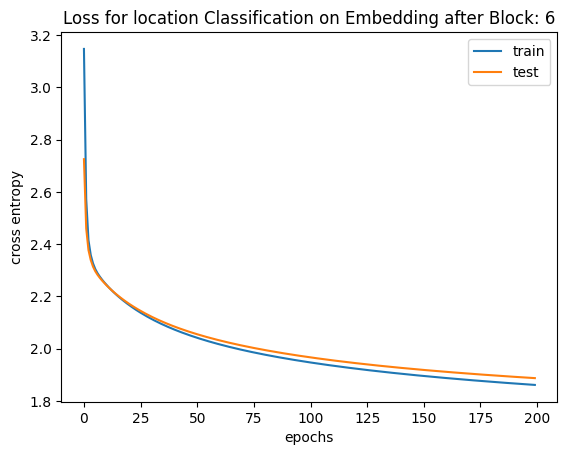

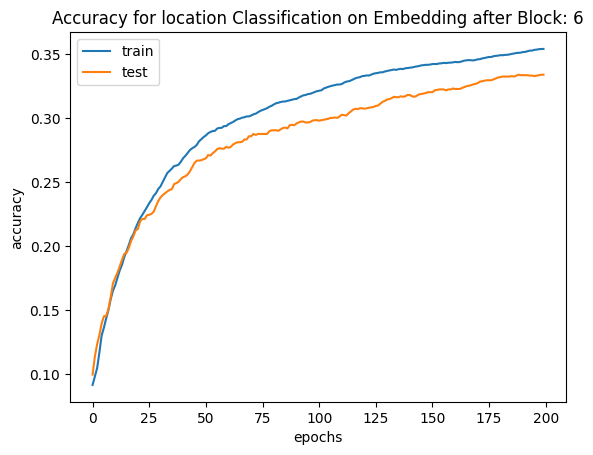

In [173]:
n_epochs = 200
batch_size = 64
batches_per_epoch = len(X_train) // batch_size

# Freeze the parameters of the rest of the model
for param in model.parameters():
    param.requires_grad = False

# # Allow the parameters of the final layer to be updated during training
for param in model.fc3.parameters():
    param.requires_grad = True
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters in the model are: {total_params}")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of paramerters being trained: ", total_trainable_params)

best_loss = np.inf  # Initialize to infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []

# Define the optimizer to update only the parameters of the final layer
# optimizer = torch.optim.SGD(model.layer3.parameters(), lr=0.001)

# Training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    
    # Set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # Take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            # Forward pass
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Update weights
            optimizer.step()

            # Compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # Set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)
        y_val_batch = y_val_tensor.to(device)
        y_pred = model(X_test_batch)
        ce = criterion(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if ce < best_loss:
        best_loss = ce
        best_weights = copy.deepcopy(model.state_dict())

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

# Load the best weights and plot the results
model.load_state_dict(best_weights)

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()


In [174]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [175]:
torch.save(model, fr'{folder_name}{run_mode}_{Block_number}.pth')

In [176]:
model=torch.load(fr'{folder_name}{run_mode}_{Block_number}.pth')
model.to(device)

SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [177]:
X_test=train_ready(test_data,col_name)

In [178]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        output = model(feature.unsqueeze(0))
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred


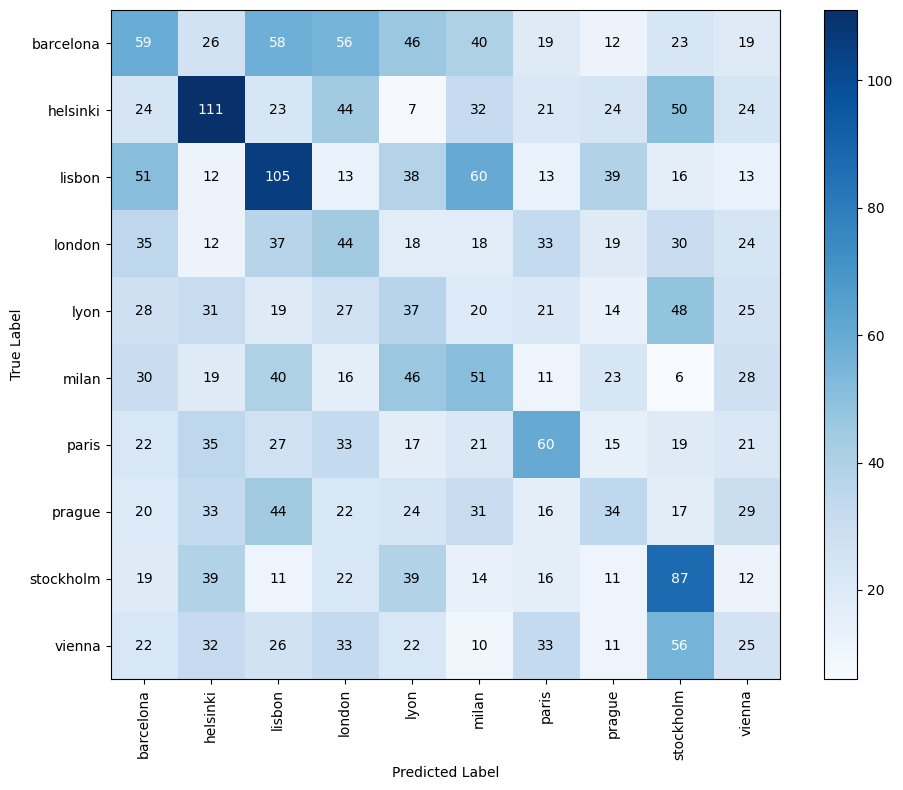

Accuracy: 0.2065


In [179]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)
# loss_list.append()

# Block-7

In [180]:
Block_number=7

In [181]:
model=torch.load(f'{base_dir}/small_model_scene_{Block_number}_opl.pth')

In [182]:
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)

In [183]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [184]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [185]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 10)
(2793, 10)


In [186]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters are {total_params}")
last_layer_params = list(model.parameters())[-2:]  # Assuming the last layer has both weight and bias parameters

# Count the total number of parameters in the last layer
num_params_last_layer = sum(p.numel() for p in last_layer_params)
print(f"Number of parameters in the last layer is {num_params_last_layer}")

Total number of paramerters are 199434
Number of parameters in the last layer is 2570


In [187]:
# for param in model.fc1.parameters():
#     param.requires_grad=False
for param in model.fc2.parameters():
    param.requires_grad = False

In [188]:
nn.init.xavier_uniform_(model.fc3.weight)
nn.init.constant_(model.fc3.bias, 0.0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [189]:
nn.init.xavier_uniform_(model.fc3.weight)
nn.init.constant_(model.fc3.bias, 0.0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [190]:
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of trainable parameters:", total_trainable_params)

Total number of trainable parameters: 2570


In [191]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc3.parameters(), lr=lr)

Total number of paramerters in the model are: 199434
Total number of paramerters being trained:  2570


Epoch 0: 100%|██████████| 174/174 [00:00<00:00, 534.99batch/s, acc=0.109, loss=2.59] 


Epoch 0 validation: Cross-entropy=2.53, Accuracy=8.9%


Epoch 1: 100%|██████████| 174/174 [00:00<00:00, 646.07batch/s, acc=0.156, loss=2.35] 


Epoch 1 validation: Cross-entropy=2.39, Accuracy=9.3%


Epoch 2: 100%|██████████| 174/174 [00:00<00:00, 560.20batch/s, acc=0.203, loss=2.28] 


Epoch 2 validation: Cross-entropy=2.35, Accuracy=10.0%


Epoch 3: 100%|██████████| 174/174 [00:00<00:00, 575.84batch/s, acc=0.219, loss=2.25] 


Epoch 3 validation: Cross-entropy=2.33, Accuracy=10.8%


Epoch 4: 100%|██████████| 174/174 [00:00<00:00, 578.02batch/s, acc=0.188, loss=2.23] 


Epoch 4 validation: Cross-entropy=2.31, Accuracy=11.6%


Epoch 5: 100%|██████████| 174/174 [00:00<00:00, 698.35batch/s, acc=0.188, loss=2.22] 


Epoch 5 validation: Cross-entropy=2.30, Accuracy=13.0%


Epoch 6: 100%|██████████| 174/174 [00:00<00:00, 704.24batch/s, acc=0.203, loss=2.2]  


Epoch 6 validation: Cross-entropy=2.28, Accuracy=14.1%


Epoch 7: 100%|██████████| 174/174 [00:00<00:00, 562.62batch/s, acc=0.188, loss=2.19] 


Epoch 7 validation: Cross-entropy=2.27, Accuracy=14.7%


Epoch 8: 100%|██████████| 174/174 [00:00<00:00, 583.96batch/s, acc=0.188, loss=2.18] 


Epoch 8 validation: Cross-entropy=2.26, Accuracy=15.4%


Epoch 9: 100%|██████████| 174/174 [00:00<00:00, 565.49batch/s, acc=0.188, loss=2.17] 


Epoch 9 validation: Cross-entropy=2.25, Accuracy=16.3%


Epoch 10: 100%|██████████| 174/174 [00:00<00:00, 710.84batch/s, acc=0.188, loss=2.17] 


Epoch 10 validation: Cross-entropy=2.24, Accuracy=16.5%


Epoch 11: 100%|██████████| 174/174 [00:00<00:00, 574.68batch/s, acc=0.219, loss=2.16] 


Epoch 11 validation: Cross-entropy=2.23, Accuracy=17.6%


Epoch 12: 100%|██████████| 174/174 [00:00<00:00, 712.37batch/s, acc=0.219, loss=2.15] 


Epoch 12 validation: Cross-entropy=2.22, Accuracy=18.1%


Epoch 13: 100%|██████████| 174/174 [00:00<00:00, 706.11batch/s, acc=0.219, loss=2.14]


Epoch 13 validation: Cross-entropy=2.21, Accuracy=19.3%


Epoch 14: 100%|██████████| 174/174 [00:00<00:00, 507.12batch/s, acc=0.203, loss=2.13]


Epoch 14 validation: Cross-entropy=2.21, Accuracy=19.9%


Epoch 15: 100%|██████████| 174/174 [00:00<00:00, 702.88batch/s, acc=0.219, loss=2.13]


Epoch 15 validation: Cross-entropy=2.20, Accuracy=20.5%


Epoch 16: 100%|██████████| 174/174 [00:00<00:00, 554.21batch/s, acc=0.219, loss=2.12] 


Epoch 16 validation: Cross-entropy=2.19, Accuracy=20.9%


Epoch 17: 100%|██████████| 174/174 [00:00<00:00, 696.41batch/s, acc=0.219, loss=2.12] 


Epoch 17 validation: Cross-entropy=2.19, Accuracy=21.4%


Epoch 18: 100%|██████████| 174/174 [00:00<00:00, 572.11batch/s, acc=0.25, loss=2.11]  


Epoch 18 validation: Cross-entropy=2.18, Accuracy=22.0%


Epoch 19: 100%|██████████| 174/174 [00:00<00:00, 704.73batch/s, acc=0.25, loss=2.1]   


Epoch 19 validation: Cross-entropy=2.17, Accuracy=22.3%


Epoch 20: 100%|██████████| 174/174 [00:00<00:00, 717.55batch/s, acc=0.266, loss=2.1]  


Epoch 20 validation: Cross-entropy=2.17, Accuracy=22.5%


Epoch 21: 100%|██████████| 174/174 [00:00<00:00, 484.41batch/s, acc=0.281, loss=2.09] 


Epoch 21 validation: Cross-entropy=2.16, Accuracy=22.9%


Epoch 22: 100%|██████████| 174/174 [00:00<00:00, 717.17batch/s, acc=0.297, loss=2.09]


Epoch 22 validation: Cross-entropy=2.15, Accuracy=23.2%


Epoch 23: 100%|██████████| 174/174 [00:00<00:00, 574.82batch/s, acc=0.297, loss=2.08]


Epoch 23 validation: Cross-entropy=2.15, Accuracy=23.4%


Epoch 24: 100%|██████████| 174/174 [00:00<00:00, 708.57batch/s, acc=0.297, loss=2.08]


Epoch 24 validation: Cross-entropy=2.14, Accuracy=23.7%


Epoch 25: 100%|██████████| 174/174 [00:00<00:00, 566.88batch/s, acc=0.297, loss=2.07]


Epoch 25 validation: Cross-entropy=2.14, Accuracy=23.8%


Epoch 26: 100%|██████████| 174/174 [00:00<00:00, 715.22batch/s, acc=0.312, loss=2.07]


Epoch 26 validation: Cross-entropy=2.13, Accuracy=24.0%


Epoch 27: 100%|██████████| 174/174 [00:00<00:00, 674.10batch/s, acc=0.328, loss=2.07]


Epoch 27 validation: Cross-entropy=2.13, Accuracy=24.2%


Epoch 28: 100%|██████████| 174/174 [00:00<00:00, 558.20batch/s, acc=0.328, loss=2.06]


Epoch 28 validation: Cross-entropy=2.12, Accuracy=24.5%


Epoch 29: 100%|██████████| 174/174 [00:00<00:00, 708.39batch/s, acc=0.328, loss=2.06]


Epoch 29 validation: Cross-entropy=2.12, Accuracy=25.0%


Epoch 30: 100%|██████████| 174/174 [00:00<00:00, 566.86batch/s, acc=0.328, loss=2.05]


Epoch 30 validation: Cross-entropy=2.12, Accuracy=25.2%


Epoch 31: 100%|██████████| 174/174 [00:00<00:00, 709.36batch/s, acc=0.328, loss=2.05]


Epoch 31 validation: Cross-entropy=2.11, Accuracy=25.3%


Epoch 32: 100%|██████████| 174/174 [00:00<00:00, 559.90batch/s, acc=0.328, loss=2.05]


Epoch 32 validation: Cross-entropy=2.11, Accuracy=25.8%


Epoch 33: 100%|██████████| 174/174 [00:00<00:00, 581.83batch/s, acc=0.328, loss=2.04]


Epoch 33 validation: Cross-entropy=2.10, Accuracy=25.9%


Epoch 34: 100%|██████████| 174/174 [00:00<00:00, 631.99batch/s, acc=0.328, loss=2.04]


Epoch 34 validation: Cross-entropy=2.10, Accuracy=26.1%


Epoch 35: 100%|██████████| 174/174 [00:00<00:00, 635.99batch/s, acc=0.344, loss=2.04]


Epoch 35 validation: Cross-entropy=2.10, Accuracy=26.1%


Epoch 36: 100%|██████████| 174/174 [00:00<00:00, 711.85batch/s, acc=0.344, loss=2.03]


Epoch 36 validation: Cross-entropy=2.09, Accuracy=26.3%


Epoch 37: 100%|██████████| 174/174 [00:00<00:00, 571.86batch/s, acc=0.344, loss=2.03]


Epoch 37 validation: Cross-entropy=2.09, Accuracy=26.5%


Epoch 38: 100%|██████████| 174/174 [00:00<00:00, 675.10batch/s, acc=0.344, loss=2.03]


Epoch 38 validation: Cross-entropy=2.08, Accuracy=26.6%


Epoch 39: 100%|██████████| 174/174 [00:00<00:00, 580.80batch/s, acc=0.344, loss=2.02]


Epoch 39 validation: Cross-entropy=2.08, Accuracy=27.1%


Epoch 40: 100%|██████████| 174/174 [00:00<00:00, 576.23batch/s, acc=0.344, loss=2.02]


Epoch 40 validation: Cross-entropy=2.08, Accuracy=27.3%


Epoch 41: 100%|██████████| 174/174 [00:00<00:00, 608.27batch/s, acc=0.359, loss=2.02]


Epoch 41 validation: Cross-entropy=2.07, Accuracy=27.4%


Epoch 42: 100%|██████████| 174/174 [00:00<00:00, 636.13batch/s, acc=0.359, loss=2.01]


Epoch 42 validation: Cross-entropy=2.07, Accuracy=27.7%


Epoch 43: 100%|██████████| 174/174 [00:00<00:00, 705.62batch/s, acc=0.359, loss=2.01]


Epoch 43 validation: Cross-entropy=2.07, Accuracy=27.9%


Epoch 44: 100%|██████████| 174/174 [00:00<00:00, 573.76batch/s, acc=0.359, loss=2.01]


Epoch 44 validation: Cross-entropy=2.07, Accuracy=27.9%


Epoch 45: 100%|██████████| 174/174 [00:00<00:00, 597.87batch/s, acc=0.359, loss=2]   


Epoch 45 validation: Cross-entropy=2.06, Accuracy=28.0%


Epoch 46: 100%|██████████| 174/174 [00:00<00:00, 572.47batch/s, acc=0.359, loss=2]   


Epoch 46 validation: Cross-entropy=2.06, Accuracy=28.1%


Epoch 47: 100%|██████████| 174/174 [00:00<00:00, 716.99batch/s, acc=0.359, loss=2]   


Epoch 47 validation: Cross-entropy=2.06, Accuracy=28.4%


Epoch 48: 100%|██████████| 174/174 [00:00<00:00, 584.46batch/s, acc=0.359, loss=2]   


Epoch 48 validation: Cross-entropy=2.05, Accuracy=28.5%


Epoch 49: 100%|██████████| 174/174 [00:00<00:00, 713.08batch/s, acc=0.359, loss=1.99]


Epoch 49 validation: Cross-entropy=2.05, Accuracy=28.6%


Epoch 50: 100%|██████████| 174/174 [00:00<00:00, 716.71batch/s, acc=0.359, loss=1.99]


Epoch 50 validation: Cross-entropy=2.05, Accuracy=28.6%


Epoch 51: 100%|██████████| 174/174 [00:00<00:00, 568.64batch/s, acc=0.359, loss=1.99]


Epoch 51 validation: Cross-entropy=2.05, Accuracy=28.7%


Epoch 52: 100%|██████████| 174/174 [00:00<00:00, 579.52batch/s, acc=0.359, loss=1.99]


Epoch 52 validation: Cross-entropy=2.04, Accuracy=28.9%


Epoch 53: 100%|██████████| 174/174 [00:00<00:00, 564.44batch/s, acc=0.359, loss=1.98]


Epoch 53 validation: Cross-entropy=2.04, Accuracy=29.1%


Epoch 54: 100%|██████████| 174/174 [00:00<00:00, 718.80batch/s, acc=0.359, loss=1.98]


Epoch 54 validation: Cross-entropy=2.04, Accuracy=29.2%


Epoch 55: 100%|██████████| 174/174 [00:00<00:00, 600.89batch/s, acc=0.359, loss=1.98]


Epoch 55 validation: Cross-entropy=2.04, Accuracy=29.4%


Epoch 56: 100%|██████████| 174/174 [00:00<00:00, 697.46batch/s, acc=0.359, loss=1.98]


Epoch 56 validation: Cross-entropy=2.03, Accuracy=29.4%


Epoch 57: 100%|██████████| 174/174 [00:00<00:00, 587.76batch/s, acc=0.359, loss=1.97]


Epoch 57 validation: Cross-entropy=2.03, Accuracy=29.6%


Epoch 58: 100%|██████████| 174/174 [00:00<00:00, 567.99batch/s, acc=0.359, loss=1.97]


Epoch 58 validation: Cross-entropy=2.03, Accuracy=29.8%


Epoch 59: 100%|██████████| 174/174 [00:00<00:00, 709.48batch/s, acc=0.359, loss=1.97]


Epoch 59 validation: Cross-entropy=2.03, Accuracy=29.6%


Epoch 60: 100%|██████████| 174/174 [00:00<00:00, 562.21batch/s, acc=0.359, loss=1.97]


Epoch 60 validation: Cross-entropy=2.02, Accuracy=29.8%


Epoch 61: 100%|██████████| 174/174 [00:00<00:00, 710.19batch/s, acc=0.359, loss=1.97]


Epoch 61 validation: Cross-entropy=2.02, Accuracy=29.9%


Epoch 62: 100%|██████████| 174/174 [00:00<00:00, 577.93batch/s, acc=0.359, loss=1.96]


Epoch 62 validation: Cross-entropy=2.02, Accuracy=29.7%


Epoch 63: 100%|██████████| 174/174 [00:00<00:00, 711.16batch/s, acc=0.359, loss=1.96]


Epoch 63 validation: Cross-entropy=2.02, Accuracy=29.8%


Epoch 64: 100%|██████████| 174/174 [00:00<00:00, 592.04batch/s, acc=0.359, loss=1.96]


Epoch 64 validation: Cross-entropy=2.02, Accuracy=29.9%


Epoch 65: 100%|██████████| 174/174 [00:00<00:00, 576.86batch/s, acc=0.359, loss=1.96]


Epoch 65 validation: Cross-entropy=2.01, Accuracy=30.0%


Epoch 66: 100%|██████████| 174/174 [00:00<00:00, 720.18batch/s, acc=0.359, loss=1.96]


Epoch 66 validation: Cross-entropy=2.01, Accuracy=30.1%


Epoch 67: 100%|██████████| 174/174 [00:00<00:00, 574.56batch/s, acc=0.359, loss=1.95]


Epoch 67 validation: Cross-entropy=2.01, Accuracy=30.3%


Epoch 68: 100%|██████████| 174/174 [00:00<00:00, 716.94batch/s, acc=0.359, loss=1.95]


Epoch 68 validation: Cross-entropy=2.01, Accuracy=30.3%


Epoch 69: 100%|██████████| 174/174 [00:00<00:00, 486.37batch/s, acc=0.359, loss=1.95]


Epoch 69 validation: Cross-entropy=2.01, Accuracy=30.3%


Epoch 70: 100%|██████████| 174/174 [00:00<00:00, 715.61batch/s, acc=0.359, loss=1.95]


Epoch 70 validation: Cross-entropy=2.00, Accuracy=30.5%


Epoch 71: 100%|██████████| 174/174 [00:00<00:00, 720.17batch/s, acc=0.359, loss=1.95]


Epoch 71 validation: Cross-entropy=2.00, Accuracy=30.5%


Epoch 72: 100%|██████████| 174/174 [00:00<00:00, 572.77batch/s, acc=0.359, loss=1.94]


Epoch 72 validation: Cross-entropy=2.00, Accuracy=30.6%


Epoch 73: 100%|██████████| 174/174 [00:00<00:00, 715.53batch/s, acc=0.359, loss=1.94]


Epoch 73 validation: Cross-entropy=2.00, Accuracy=30.8%


Epoch 74: 100%|██████████| 174/174 [00:00<00:00, 579.12batch/s, acc=0.359, loss=1.94]


Epoch 74 validation: Cross-entropy=2.00, Accuracy=30.8%


Epoch 75: 100%|██████████| 174/174 [00:00<00:00, 611.95batch/s, acc=0.359, loss=1.94]


Epoch 75 validation: Cross-entropy=1.99, Accuracy=30.9%


Epoch 76: 100%|██████████| 174/174 [00:00<00:00, 589.87batch/s, acc=0.359, loss=1.94]


Epoch 76 validation: Cross-entropy=1.99, Accuracy=31.0%


Epoch 77: 100%|██████████| 174/174 [00:00<00:00, 696.21batch/s, acc=0.375, loss=1.94]


Epoch 77 validation: Cross-entropy=1.99, Accuracy=31.3%


Epoch 78: 100%|██████████| 174/174 [00:00<00:00, 717.19batch/s, acc=0.375, loss=1.93]


Epoch 78 validation: Cross-entropy=1.99, Accuracy=31.3%


Epoch 79: 100%|██████████| 174/174 [00:00<00:00, 577.88batch/s, acc=0.375, loss=1.93]


Epoch 79 validation: Cross-entropy=1.99, Accuracy=31.5%


Epoch 80: 100%|██████████| 174/174 [00:00<00:00, 715.10batch/s, acc=0.375, loss=1.93]


Epoch 80 validation: Cross-entropy=1.99, Accuracy=31.6%


Epoch 81: 100%|██████████| 174/174 [00:00<00:00, 505.49batch/s, acc=0.375, loss=1.93]


Epoch 81 validation: Cross-entropy=1.98, Accuracy=31.6%


Epoch 82: 100%|██████████| 174/174 [00:00<00:00, 680.82batch/s, acc=0.375, loss=1.93]


Epoch 82 validation: Cross-entropy=1.98, Accuracy=31.6%


Epoch 83: 100%|██████████| 174/174 [00:00<00:00, 681.26batch/s, acc=0.375, loss=1.93]


Epoch 83 validation: Cross-entropy=1.98, Accuracy=31.8%


Epoch 84: 100%|██████████| 174/174 [00:00<00:00, 623.15batch/s, acc=0.375, loss=1.92]


Epoch 84 validation: Cross-entropy=1.98, Accuracy=31.8%


Epoch 85: 100%|██████████| 174/174 [00:00<00:00, 723.15batch/s, acc=0.375, loss=1.92]


Epoch 85 validation: Cross-entropy=1.98, Accuracy=31.7%


Epoch 86: 100%|██████████| 174/174 [00:00<00:00, 573.77batch/s, acc=0.375, loss=1.92]


Epoch 86 validation: Cross-entropy=1.98, Accuracy=31.8%


Epoch 87: 100%|██████████| 174/174 [00:00<00:00, 692.28batch/s, acc=0.375, loss=1.92]


Epoch 87 validation: Cross-entropy=1.98, Accuracy=31.8%


Epoch 88: 100%|██████████| 174/174 [00:00<00:00, 493.78batch/s, acc=0.375, loss=1.92]


Epoch 88 validation: Cross-entropy=1.97, Accuracy=31.8%


Epoch 89: 100%|██████████| 174/174 [00:00<00:00, 726.91batch/s, acc=0.375, loss=1.92]


Epoch 89 validation: Cross-entropy=1.97, Accuracy=31.8%


Epoch 90: 100%|██████████| 174/174 [00:00<00:00, 717.53batch/s, acc=0.375, loss=1.92]


Epoch 90 validation: Cross-entropy=1.97, Accuracy=31.9%


Epoch 91: 100%|██████████| 174/174 [00:00<00:00, 576.14batch/s, acc=0.391, loss=1.91]


Epoch 91 validation: Cross-entropy=1.97, Accuracy=32.0%


Epoch 92: 100%|██████████| 174/174 [00:00<00:00, 707.38batch/s, acc=0.391, loss=1.91]


Epoch 92 validation: Cross-entropy=1.97, Accuracy=32.2%


Epoch 93: 100%|██████████| 174/174 [00:00<00:00, 472.69batch/s, acc=0.391, loss=1.91]


Epoch 93 validation: Cross-entropy=1.97, Accuracy=32.4%


Epoch 94: 100%|██████████| 174/174 [00:00<00:00, 708.37batch/s, acc=0.391, loss=1.91]


Epoch 94 validation: Cross-entropy=1.97, Accuracy=32.4%


Epoch 95: 100%|██████████| 174/174 [00:00<00:00, 566.06batch/s, acc=0.406, loss=1.91]


Epoch 95 validation: Cross-entropy=1.96, Accuracy=32.5%


Epoch 96: 100%|██████████| 174/174 [00:00<00:00, 720.59batch/s, acc=0.406, loss=1.91]


Epoch 96 validation: Cross-entropy=1.96, Accuracy=32.8%


Epoch 97: 100%|██████████| 174/174 [00:00<00:00, 665.70batch/s, acc=0.422, loss=1.91]


Epoch 97 validation: Cross-entropy=1.96, Accuracy=32.9%


Epoch 98: 100%|██████████| 174/174 [00:00<00:00, 645.48batch/s, acc=0.422, loss=1.9] 


Epoch 98 validation: Cross-entropy=1.96, Accuracy=32.9%


Epoch 99: 100%|██████████| 174/174 [00:00<00:00, 586.58batch/s, acc=0.422, loss=1.9] 


Epoch 99 validation: Cross-entropy=1.96, Accuracy=32.9%


Epoch 100: 100%|██████████| 174/174 [00:00<00:00, 576.36batch/s, acc=0.422, loss=1.9] 


Epoch 100 validation: Cross-entropy=1.96, Accuracy=33.0%


Epoch 101: 100%|██████████| 174/174 [00:00<00:00, 721.06batch/s, acc=0.422, loss=1.9] 


Epoch 101 validation: Cross-entropy=1.96, Accuracy=33.0%


Epoch 102: 100%|██████████| 174/174 [00:00<00:00, 578.93batch/s, acc=0.422, loss=1.9] 


Epoch 102 validation: Cross-entropy=1.95, Accuracy=33.0%


Epoch 103: 100%|██████████| 174/174 [00:00<00:00, 721.70batch/s, acc=0.422, loss=1.9] 


Epoch 103 validation: Cross-entropy=1.95, Accuracy=33.0%


Epoch 104: 100%|██████████| 174/174 [00:00<00:00, 714.38batch/s, acc=0.422, loss=1.9] 


Epoch 104 validation: Cross-entropy=1.95, Accuracy=33.1%


Epoch 105: 100%|██████████| 174/174 [00:00<00:00, 492.00batch/s, acc=0.422, loss=1.9] 


Epoch 105 validation: Cross-entropy=1.95, Accuracy=33.1%


Epoch 106: 100%|██████████| 174/174 [00:00<00:00, 697.84batch/s, acc=0.422, loss=1.89]


Epoch 106 validation: Cross-entropy=1.95, Accuracy=33.2%


Epoch 107: 100%|██████████| 174/174 [00:00<00:00, 574.37batch/s, acc=0.422, loss=1.89]


Epoch 107 validation: Cross-entropy=1.95, Accuracy=33.2%


Epoch 108: 100%|██████████| 174/174 [00:00<00:00, 708.28batch/s, acc=0.422, loss=1.89]


Epoch 108 validation: Cross-entropy=1.95, Accuracy=33.4%


Epoch 109: 100%|██████████| 174/174 [00:00<00:00, 573.83batch/s, acc=0.422, loss=1.89]


Epoch 109 validation: Cross-entropy=1.95, Accuracy=33.4%


Epoch 110: 100%|██████████| 174/174 [00:00<00:00, 722.34batch/s, acc=0.422, loss=1.89]


Epoch 110 validation: Cross-entropy=1.95, Accuracy=33.5%


Epoch 111: 100%|██████████| 174/174 [00:00<00:00, 618.90batch/s, acc=0.406, loss=1.89]


Epoch 111 validation: Cross-entropy=1.94, Accuracy=33.6%


Epoch 112: 100%|██████████| 174/174 [00:00<00:00, 539.27batch/s, acc=0.406, loss=1.89]


Epoch 112 validation: Cross-entropy=1.94, Accuracy=33.6%


Epoch 113: 100%|██████████| 174/174 [00:00<00:00, 713.81batch/s, acc=0.406, loss=1.89]


Epoch 113 validation: Cross-entropy=1.94, Accuracy=33.5%


Epoch 114: 100%|██████████| 174/174 [00:00<00:00, 567.19batch/s, acc=0.406, loss=1.89]


Epoch 114 validation: Cross-entropy=1.94, Accuracy=33.6%


Epoch 115: 100%|██████████| 174/174 [00:00<00:00, 717.25batch/s, acc=0.406, loss=1.88]


Epoch 115 validation: Cross-entropy=1.94, Accuracy=33.6%


Epoch 116: 100%|██████████| 174/174 [00:00<00:00, 578.56batch/s, acc=0.406, loss=1.88]


Epoch 116 validation: Cross-entropy=1.94, Accuracy=33.8%


Epoch 117: 100%|██████████| 174/174 [00:00<00:00, 586.60batch/s, acc=0.391, loss=1.88]


Epoch 117 validation: Cross-entropy=1.94, Accuracy=33.9%


Epoch 118: 100%|██████████| 174/174 [00:00<00:00, 707.67batch/s, acc=0.391, loss=1.88]


Epoch 118 validation: Cross-entropy=1.94, Accuracy=34.0%


Epoch 119: 100%|██████████| 174/174 [00:00<00:00, 574.79batch/s, acc=0.391, loss=1.88]


Epoch 119 validation: Cross-entropy=1.94, Accuracy=34.0%


Epoch 120: 100%|██████████| 174/174 [00:00<00:00, 713.99batch/s, acc=0.391, loss=1.88]


Epoch 120 validation: Cross-entropy=1.93, Accuracy=34.0%


Epoch 121: 100%|██████████| 174/174 [00:00<00:00, 577.32batch/s, acc=0.391, loss=1.88]


Epoch 121 validation: Cross-entropy=1.93, Accuracy=34.0%


Epoch 122: 100%|██████████| 174/174 [00:00<00:00, 715.62batch/s, acc=0.391, loss=1.88]


Epoch 122 validation: Cross-entropy=1.93, Accuracy=34.0%


Epoch 123: 100%|██████████| 174/174 [00:00<00:00, 469.01batch/s, acc=0.391, loss=1.88]


Epoch 123 validation: Cross-entropy=1.93, Accuracy=34.1%


Epoch 124: 100%|██████████| 174/174 [00:00<00:00, 715.88batch/s, acc=0.391, loss=1.88]


Epoch 124 validation: Cross-entropy=1.93, Accuracy=34.1%


Epoch 125: 100%|██████████| 174/174 [00:00<00:00, 675.05batch/s, acc=0.391, loss=1.87]


Epoch 125 validation: Cross-entropy=1.93, Accuracy=34.1%


Epoch 126: 100%|██████████| 174/174 [00:00<00:00, 622.71batch/s, acc=0.391, loss=1.87]


Epoch 126 validation: Cross-entropy=1.93, Accuracy=34.2%


Epoch 127: 100%|██████████| 174/174 [00:00<00:00, 716.31batch/s, acc=0.391, loss=1.87]


Epoch 127 validation: Cross-entropy=1.93, Accuracy=34.3%


Epoch 128: 100%|██████████| 174/174 [00:00<00:00, 583.52batch/s, acc=0.391, loss=1.87]


Epoch 128 validation: Cross-entropy=1.93, Accuracy=34.3%


Epoch 129: 100%|██████████| 174/174 [00:00<00:00, 591.97batch/s, acc=0.406, loss=1.87]


Epoch 129 validation: Cross-entropy=1.93, Accuracy=34.3%


Epoch 130: 100%|██████████| 174/174 [00:00<00:00, 561.42batch/s, acc=0.406, loss=1.87]


Epoch 130 validation: Cross-entropy=1.92, Accuracy=34.4%


Epoch 131: 100%|██████████| 174/174 [00:00<00:00, 705.93batch/s, acc=0.406, loss=1.87]


Epoch 131 validation: Cross-entropy=1.92, Accuracy=34.4%


Epoch 132: 100%|██████████| 174/174 [00:00<00:00, 607.70batch/s, acc=0.406, loss=1.87]


Epoch 132 validation: Cross-entropy=1.92, Accuracy=34.5%


Epoch 133: 100%|██████████| 174/174 [00:00<00:00, 641.67batch/s, acc=0.406, loss=1.87]


Epoch 133 validation: Cross-entropy=1.92, Accuracy=34.5%


Epoch 134: 100%|██████████| 174/174 [00:00<00:00, 721.65batch/s, acc=0.406, loss=1.87]


Epoch 134 validation: Cross-entropy=1.92, Accuracy=34.5%


Epoch 135: 100%|██████████| 174/174 [00:00<00:00, 501.18batch/s, acc=0.406, loss=1.86]


Epoch 135 validation: Cross-entropy=1.92, Accuracy=34.6%


Epoch 136: 100%|██████████| 174/174 [00:00<00:00, 684.97batch/s, acc=0.406, loss=1.86]


Epoch 136 validation: Cross-entropy=1.92, Accuracy=34.6%


Epoch 137: 100%|██████████| 174/174 [00:00<00:00, 569.62batch/s, acc=0.406, loss=1.86]


Epoch 137 validation: Cross-entropy=1.92, Accuracy=34.6%


Epoch 138: 100%|██████████| 174/174 [00:00<00:00, 710.36batch/s, acc=0.406, loss=1.86]


Epoch 138 validation: Cross-entropy=1.92, Accuracy=34.6%


Epoch 139: 100%|██████████| 174/174 [00:00<00:00, 618.05batch/s, acc=0.406, loss=1.86]


Epoch 139 validation: Cross-entropy=1.92, Accuracy=34.6%


Epoch 140: 100%|██████████| 174/174 [00:00<00:00, 670.48batch/s, acc=0.406, loss=1.86]


Epoch 140 validation: Cross-entropy=1.92, Accuracy=34.6%


Epoch 141: 100%|██████████| 174/174 [00:00<00:00, 575.22batch/s, acc=0.406, loss=1.86]


Epoch 141 validation: Cross-entropy=1.92, Accuracy=34.6%


Epoch 142: 100%|██████████| 174/174 [00:00<00:00, 572.67batch/s, acc=0.406, loss=1.86]


Epoch 142 validation: Cross-entropy=1.91, Accuracy=34.6%


Epoch 143: 100%|██████████| 174/174 [00:00<00:00, 721.88batch/s, acc=0.406, loss=1.86]


Epoch 143 validation: Cross-entropy=1.91, Accuracy=34.6%


Epoch 144: 100%|██████████| 174/174 [00:00<00:00, 527.02batch/s, acc=0.406, loss=1.86]


Epoch 144 validation: Cross-entropy=1.91, Accuracy=34.6%


Epoch 145: 100%|██████████| 174/174 [00:00<00:00, 712.70batch/s, acc=0.406, loss=1.86]


Epoch 145 validation: Cross-entropy=1.91, Accuracy=34.6%


Epoch 146: 100%|██████████| 174/174 [00:00<00:00, 594.21batch/s, acc=0.406, loss=1.86]


Epoch 146 validation: Cross-entropy=1.91, Accuracy=34.6%


Epoch 147: 100%|██████████| 174/174 [00:00<00:00, 581.34batch/s, acc=0.406, loss=1.85]


Epoch 147 validation: Cross-entropy=1.91, Accuracy=34.6%


Epoch 148: 100%|██████████| 174/174 [00:00<00:00, 671.24batch/s, acc=0.406, loss=1.85]


Epoch 148 validation: Cross-entropy=1.91, Accuracy=34.6%


Epoch 149: 100%|██████████| 174/174 [00:00<00:00, 555.96batch/s, acc=0.406, loss=1.85]


Epoch 149 validation: Cross-entropy=1.91, Accuracy=34.6%


Epoch 150: 100%|██████████| 174/174 [00:00<00:00, 710.34batch/s, acc=0.406, loss=1.85]


Epoch 150 validation: Cross-entropy=1.91, Accuracy=34.6%


Epoch 151: 100%|██████████| 174/174 [00:00<00:00, 581.64batch/s, acc=0.406, loss=1.85]


Epoch 151 validation: Cross-entropy=1.91, Accuracy=34.6%


Epoch 152: 100%|██████████| 174/174 [00:00<00:00, 727.69batch/s, acc=0.406, loss=1.85]


Epoch 152 validation: Cross-entropy=1.91, Accuracy=34.6%


Epoch 153: 100%|██████████| 174/174 [00:00<00:00, 492.08batch/s, acc=0.406, loss=1.85]


Epoch 153 validation: Cross-entropy=1.91, Accuracy=34.7%


Epoch 154: 100%|██████████| 174/174 [00:00<00:00, 722.71batch/s, acc=0.406, loss=1.85]


Epoch 154 validation: Cross-entropy=1.90, Accuracy=34.7%


Epoch 155: 100%|██████████| 174/174 [00:00<00:00, 711.16batch/s, acc=0.406, loss=1.85]


Epoch 155 validation: Cross-entropy=1.90, Accuracy=34.7%


Epoch 156: 100%|██████████| 174/174 [00:00<00:00, 575.68batch/s, acc=0.406, loss=1.85]


Epoch 156 validation: Cross-entropy=1.90, Accuracy=34.7%


Epoch 157: 100%|██████████| 174/174 [00:00<00:00, 691.34batch/s, acc=0.406, loss=1.85]


Epoch 157 validation: Cross-entropy=1.90, Accuracy=34.7%


Epoch 158: 100%|██████████| 174/174 [00:00<00:00, 570.11batch/s, acc=0.406, loss=1.85]


Epoch 158 validation: Cross-entropy=1.90, Accuracy=34.7%


Epoch 159: 100%|██████████| 174/174 [00:00<00:00, 570.98batch/s, acc=0.406, loss=1.84]


Epoch 159 validation: Cross-entropy=1.90, Accuracy=34.7%


Epoch 160: 100%|██████████| 174/174 [00:00<00:00, 577.15batch/s, acc=0.406, loss=1.84]


Epoch 160 validation: Cross-entropy=1.90, Accuracy=34.8%


Epoch 161: 100%|██████████| 174/174 [00:00<00:00, 717.50batch/s, acc=0.406, loss=1.84]


Epoch 161 validation: Cross-entropy=1.90, Accuracy=34.8%


Epoch 162: 100%|██████████| 174/174 [00:00<00:00, 716.40batch/s, acc=0.406, loss=1.84]


Epoch 162 validation: Cross-entropy=1.90, Accuracy=34.9%


Epoch 163: 100%|██████████| 174/174 [00:00<00:00, 572.63batch/s, acc=0.406, loss=1.84]


Epoch 163 validation: Cross-entropy=1.90, Accuracy=34.9%


Epoch 164: 100%|██████████| 174/174 [00:00<00:00, 721.50batch/s, acc=0.406, loss=1.84]


Epoch 164 validation: Cross-entropy=1.90, Accuracy=34.9%


Epoch 165: 100%|██████████| 174/174 [00:00<00:00, 484.73batch/s, acc=0.406, loss=1.84]


Epoch 165 validation: Cross-entropy=1.90, Accuracy=34.9%


Epoch 166: 100%|██████████| 174/174 [00:00<00:00, 716.82batch/s, acc=0.406, loss=1.84]


Epoch 166 validation: Cross-entropy=1.90, Accuracy=34.9%


Epoch 167: 100%|██████████| 174/174 [00:00<00:00, 581.06batch/s, acc=0.406, loss=1.84]


Epoch 167 validation: Cross-entropy=1.90, Accuracy=35.0%


Epoch 168: 100%|██████████| 174/174 [00:00<00:00, 712.47batch/s, acc=0.406, loss=1.84]


Epoch 168 validation: Cross-entropy=1.89, Accuracy=35.1%


Epoch 169: 100%|██████████| 174/174 [00:00<00:00, 711.99batch/s, acc=0.406, loss=1.84]


Epoch 169 validation: Cross-entropy=1.89, Accuracy=35.1%


Epoch 170: 100%|██████████| 174/174 [00:00<00:00, 558.07batch/s, acc=0.406, loss=1.84]


Epoch 170 validation: Cross-entropy=1.89, Accuracy=35.1%


Epoch 171: 100%|██████████| 174/174 [00:00<00:00, 594.58batch/s, acc=0.406, loss=1.84]


Epoch 171 validation: Cross-entropy=1.89, Accuracy=35.1%


Epoch 172: 100%|██████████| 174/174 [00:00<00:00, 575.83batch/s, acc=0.406, loss=1.84]


Epoch 172 validation: Cross-entropy=1.89, Accuracy=35.1%


Epoch 173: 100%|██████████| 174/174 [00:00<00:00, 711.94batch/s, acc=0.406, loss=1.83]


Epoch 173 validation: Cross-entropy=1.89, Accuracy=35.1%


Epoch 174: 100%|██████████| 174/174 [00:00<00:00, 564.43batch/s, acc=0.406, loss=1.83]


Epoch 174 validation: Cross-entropy=1.89, Accuracy=35.1%


Epoch 175: 100%|██████████| 174/174 [00:00<00:00, 716.52batch/s, acc=0.391, loss=1.83]


Epoch 175 validation: Cross-entropy=1.89, Accuracy=35.1%


Epoch 176: 100%|██████████| 174/174 [00:00<00:00, 719.24batch/s, acc=0.391, loss=1.83]


Epoch 176 validation: Cross-entropy=1.89, Accuracy=35.1%


Epoch 177: 100%|██████████| 174/174 [00:00<00:00, 492.25batch/s, acc=0.406, loss=1.83]


Epoch 177 validation: Cross-entropy=1.89, Accuracy=35.1%


Epoch 178: 100%|██████████| 174/174 [00:00<00:00, 719.05batch/s, acc=0.406, loss=1.83]


Epoch 178 validation: Cross-entropy=1.89, Accuracy=35.2%


Epoch 179: 100%|██████████| 174/174 [00:00<00:00, 568.87batch/s, acc=0.406, loss=1.83]


Epoch 179 validation: Cross-entropy=1.89, Accuracy=35.3%


Epoch 180: 100%|██████████| 174/174 [00:00<00:00, 701.12batch/s, acc=0.406, loss=1.83]


Epoch 180 validation: Cross-entropy=1.89, Accuracy=35.2%


Epoch 181: 100%|██████████| 174/174 [00:00<00:00, 585.34batch/s, acc=0.406, loss=1.83]


Epoch 181 validation: Cross-entropy=1.89, Accuracy=35.2%


Epoch 182: 100%|██████████| 174/174 [00:00<00:00, 709.08batch/s, acc=0.406, loss=1.83]


Epoch 182 validation: Cross-entropy=1.89, Accuracy=35.2%


Epoch 183: 100%|██████████| 174/174 [00:00<00:00, 591.74batch/s, acc=0.406, loss=1.83]


Epoch 183 validation: Cross-entropy=1.89, Accuracy=35.3%


Epoch 184: 100%|██████████| 174/174 [00:00<00:00, 575.78batch/s, acc=0.406, loss=1.83]


Epoch 184 validation: Cross-entropy=1.88, Accuracy=35.3%


Epoch 185: 100%|██████████| 174/174 [00:00<00:00, 715.17batch/s, acc=0.406, loss=1.83]


Epoch 185 validation: Cross-entropy=1.88, Accuracy=35.3%


Epoch 186: 100%|██████████| 174/174 [00:00<00:00, 568.61batch/s, acc=0.406, loss=1.83]


Epoch 186 validation: Cross-entropy=1.88, Accuracy=35.3%


Epoch 187: 100%|██████████| 174/174 [00:00<00:00, 723.14batch/s, acc=0.406, loss=1.83]


Epoch 187 validation: Cross-entropy=1.88, Accuracy=35.3%


Epoch 188: 100%|██████████| 174/174 [00:00<00:00, 586.16batch/s, acc=0.406, loss=1.82]


Epoch 188 validation: Cross-entropy=1.88, Accuracy=35.3%


Epoch 189: 100%|██████████| 174/174 [00:00<00:00, 591.54batch/s, acc=0.406, loss=1.82]


Epoch 189 validation: Cross-entropy=1.88, Accuracy=35.4%


Epoch 190: 100%|██████████| 174/174 [00:00<00:00, 706.98batch/s, acc=0.422, loss=1.82]


Epoch 190 validation: Cross-entropy=1.88, Accuracy=35.4%


Epoch 191: 100%|██████████| 174/174 [00:00<00:00, 567.05batch/s, acc=0.422, loss=1.82]


Epoch 191 validation: Cross-entropy=1.88, Accuracy=35.4%


Epoch 192: 100%|██████████| 174/174 [00:00<00:00, 714.09batch/s, acc=0.422, loss=1.82]


Epoch 192 validation: Cross-entropy=1.88, Accuracy=35.4%


Epoch 193: 100%|██████████| 174/174 [00:00<00:00, 570.86batch/s, acc=0.422, loss=1.82]


Epoch 193 validation: Cross-entropy=1.88, Accuracy=35.4%


Epoch 194: 100%|██████████| 174/174 [00:00<00:00, 711.14batch/s, acc=0.422, loss=1.82]


Epoch 194 validation: Cross-entropy=1.88, Accuracy=35.4%


Epoch 195: 100%|██████████| 174/174 [00:00<00:00, 482.84batch/s, acc=0.422, loss=1.82]


Epoch 195 validation: Cross-entropy=1.88, Accuracy=35.3%


Epoch 196: 100%|██████████| 174/174 [00:00<00:00, 720.77batch/s, acc=0.422, loss=1.82]


Epoch 196 validation: Cross-entropy=1.88, Accuracy=35.4%


Epoch 197: 100%|██████████| 174/174 [00:00<00:00, 720.36batch/s, acc=0.422, loss=1.82]


Epoch 197 validation: Cross-entropy=1.88, Accuracy=35.4%


Epoch 198: 100%|██████████| 174/174 [00:00<00:00, 577.72batch/s, acc=0.422, loss=1.82]


Epoch 198 validation: Cross-entropy=1.88, Accuracy=35.4%


Epoch 199: 100%|██████████| 174/174 [00:00<00:00, 710.38batch/s, acc=0.422, loss=1.82]


Epoch 199 validation: Cross-entropy=1.88, Accuracy=35.4%


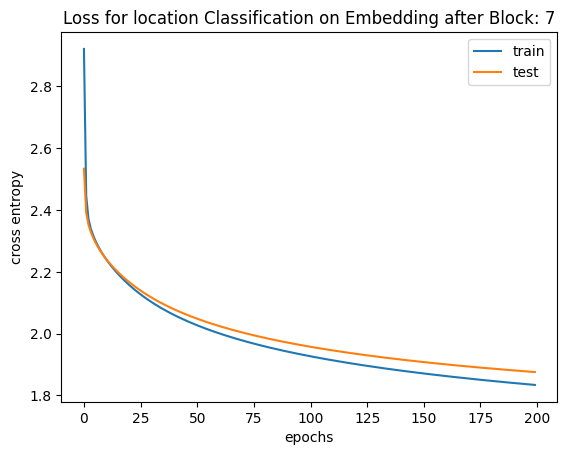

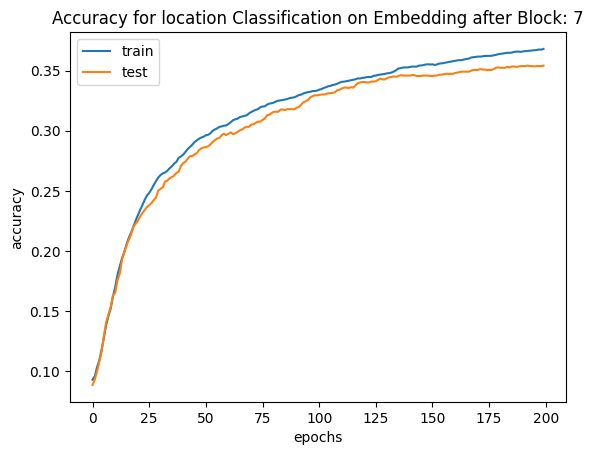

In [192]:
n_epochs = 200
batch_size = 64
batches_per_epoch = len(X_train) // batch_size

# Freeze the parameters of the rest of the model
for param in model.parameters():
    param.requires_grad = False

# # Allow the parameters of the final layer to be updated during training
for param in model.fc3.parameters():
    param.requires_grad = True
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters in the model are: {total_params}")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of paramerters being trained: ", total_trainable_params)

best_loss = np.inf  # Initialize to infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []

# Define the optimizer to update only the parameters of the final layer
# optimizer = torch.optim.SGD(model.layer3.parameters(), lr=0.001)

# Training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    
    # Set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # Take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            # Forward pass
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Update weights
            optimizer.step()

            # Compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # Set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)
        y_val_batch = y_val_tensor.to(device)
        y_pred = model(X_test_batch)
        ce = criterion(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if ce < best_loss:
        best_loss = ce
        best_weights = copy.deepcopy(model.state_dict())

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

# Load the best weights and plot the results
model.load_state_dict(best_weights)

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()


In [193]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [194]:
torch.save(model, fr'{folder_name}{run_mode}_{Block_number}.pth')

In [195]:
model=torch.load(fr'{folder_name}{run_mode}_{Block_number}.pth')
model.to(device)

SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [196]:
X_test=train_ready(test_data,col_name)

In [197]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        output = model(feature.unsqueeze(0))
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred


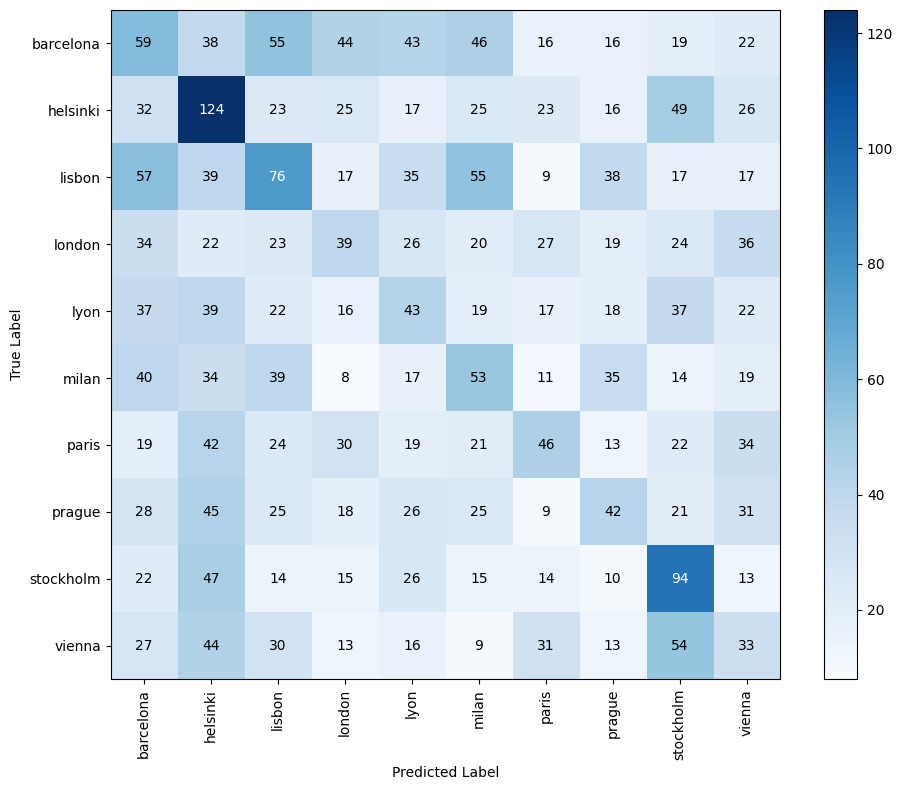

Accuracy: 0.2052


In [198]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)
# loss_list.append()

# Block-8

In [199]:
Block_number=8

In [200]:
model=torch.load(f'{base_dir}/small_model_scene_{Block_number}_opl.pth')

In [201]:
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)

In [202]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [203]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [204]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 10)
(2793, 10)


In [205]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters are {total_params}")
last_layer_params = list(model.parameters())[-2:]  # Assuming the last layer has both weight and bias parameters

# Count the total number of parameters in the last layer
num_params_last_layer = sum(p.numel() for p in last_layer_params)
print(f"Number of parameters in the last layer is {num_params_last_layer}")

Total number of paramerters are 199434
Number of parameters in the last layer is 2570


In [206]:
# for param in model.fc1.parameters():
#     param.requires_grad=False
for param in model.fc2.parameters():
    param.requires_grad = False

In [207]:
nn.init.xavier_uniform_(model.fc3.weight)
nn.init.constant_(model.fc3.bias, 0.0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [208]:
nn.init.xavier_uniform_(model.fc3.weight)
nn.init.constant_(model.fc3.bias, 0.0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [209]:
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of trainable parameters:", total_trainable_params)

Total number of trainable parameters: 2570


In [210]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc3.parameters(), lr=lr)

Total number of paramerters in the model are: 199434
Total number of paramerters being trained:  2570


Epoch 0: 100%|██████████| 174/174 [00:00<00:00, 387.53batch/s, acc=0.125, loss=2.5]  


Epoch 0 validation: Cross-entropy=2.47, Accuracy=11.0%


Epoch 1: 100%|██████████| 174/174 [00:00<00:00, 681.70batch/s, acc=0.125, loss=2.38] 


Epoch 1 validation: Cross-entropy=2.37, Accuracy=11.5%


Epoch 2: 100%|██████████| 174/174 [00:00<00:00, 559.36batch/s, acc=0.172, loss=2.34] 


Epoch 2 validation: Cross-entropy=2.33, Accuracy=12.2%


Epoch 3: 100%|██████████| 174/174 [00:00<00:00, 500.65batch/s, acc=0.156, loss=2.32] 


Epoch 3 validation: Cross-entropy=2.31, Accuracy=12.6%


Epoch 4: 100%|██████████| 174/174 [00:00<00:00, 669.30batch/s, acc=0.125, loss=2.31] 


Epoch 4 validation: Cross-entropy=2.30, Accuracy=13.1%


Epoch 5: 100%|██████████| 174/174 [00:00<00:00, 557.92batch/s, acc=0.125, loss=2.29] 


Epoch 5 validation: Cross-entropy=2.28, Accuracy=14.2%


Epoch 6: 100%|██████████| 174/174 [00:00<00:00, 700.97batch/s, acc=0.109, loss=2.28] 


Epoch 6 validation: Cross-entropy=2.27, Accuracy=15.3%


Epoch 7: 100%|██████████| 174/174 [00:00<00:00, 474.79batch/s, acc=0.0625, loss=2.27]


Epoch 7 validation: Cross-entropy=2.26, Accuracy=16.1%


Epoch 8: 100%|██████████| 174/174 [00:00<00:00, 563.63batch/s, acc=0.0625, loss=2.27]


Epoch 8 validation: Cross-entropy=2.25, Accuracy=16.7%


Epoch 9: 100%|██████████| 174/174 [00:00<00:00, 713.48batch/s, acc=0.0938, loss=2.26]


Epoch 9 validation: Cross-entropy=2.24, Accuracy=17.3%


Epoch 10: 100%|██████████| 174/174 [00:00<00:00, 559.91batch/s, acc=0.0938, loss=2.25]


Epoch 10 validation: Cross-entropy=2.23, Accuracy=17.8%


Epoch 11: 100%|██████████| 174/174 [00:00<00:00, 704.71batch/s, acc=0.125, loss=2.24] 


Epoch 11 validation: Cross-entropy=2.22, Accuracy=18.3%


Epoch 12: 100%|██████████| 174/174 [00:00<00:00, 563.05batch/s, acc=0.125, loss=2.24] 


Epoch 12 validation: Cross-entropy=2.22, Accuracy=19.0%


Epoch 13: 100%|██████████| 174/174 [00:00<00:00, 473.16batch/s, acc=0.125, loss=2.23] 


Epoch 13 validation: Cross-entropy=2.21, Accuracy=19.5%


Epoch 14: 100%|██████████| 174/174 [00:00<00:00, 696.93batch/s, acc=0.141, loss=2.23]


Epoch 14 validation: Cross-entropy=2.20, Accuracy=20.0%


Epoch 15: 100%|██████████| 174/174 [00:00<00:00, 565.84batch/s, acc=0.141, loss=2.22]


Epoch 15 validation: Cross-entropy=2.19, Accuracy=20.4%


Epoch 16: 100%|██████████| 174/174 [00:00<00:00, 583.35batch/s, acc=0.141, loss=2.21]


Epoch 16 validation: Cross-entropy=2.19, Accuracy=20.4%


Epoch 17: 100%|██████████| 174/174 [00:00<00:00, 675.41batch/s, acc=0.141, loss=2.21]


Epoch 17 validation: Cross-entropy=2.18, Accuracy=20.7%


Epoch 18: 100%|██████████| 174/174 [00:00<00:00, 524.52batch/s, acc=0.141, loss=2.2] 


Epoch 18 validation: Cross-entropy=2.18, Accuracy=20.9%


Epoch 19: 100%|██████████| 174/174 [00:00<00:00, 647.43batch/s, acc=0.141, loss=2.2] 


Epoch 19 validation: Cross-entropy=2.17, Accuracy=21.3%


Epoch 20: 100%|██████████| 174/174 [00:00<00:00, 575.03batch/s, acc=0.141, loss=2.19]


Epoch 20 validation: Cross-entropy=2.16, Accuracy=21.8%


Epoch 21: 100%|██████████| 174/174 [00:00<00:00, 568.08batch/s, acc=0.141, loss=2.19]


Epoch 21 validation: Cross-entropy=2.16, Accuracy=21.9%


Epoch 22: 100%|██████████| 174/174 [00:00<00:00, 701.48batch/s, acc=0.141, loss=2.18]


Epoch 22 validation: Cross-entropy=2.15, Accuracy=22.3%


Epoch 23: 100%|██████████| 174/174 [00:00<00:00, 594.64batch/s, acc=0.125, loss=2.18]


Epoch 23 validation: Cross-entropy=2.15, Accuracy=22.3%


Epoch 24: 100%|██████████| 174/174 [00:00<00:00, 554.71batch/s, acc=0.125, loss=2.17]


Epoch 24 validation: Cross-entropy=2.14, Accuracy=22.7%


Epoch 25: 100%|██████████| 174/174 [00:00<00:00, 559.75batch/s, acc=0.125, loss=2.17]


Epoch 25 validation: Cross-entropy=2.14, Accuracy=22.8%


Epoch 26: 100%|██████████| 174/174 [00:00<00:00, 564.51batch/s, acc=0.125, loss=2.16]


Epoch 26 validation: Cross-entropy=2.13, Accuracy=23.1%


Epoch 27: 100%|██████████| 174/174 [00:00<00:00, 715.74batch/s, acc=0.125, loss=2.16]


Epoch 27 validation: Cross-entropy=2.13, Accuracy=23.2%


Epoch 28: 100%|██████████| 174/174 [00:00<00:00, 578.55batch/s, acc=0.125, loss=2.16]


Epoch 28 validation: Cross-entropy=2.13, Accuracy=23.5%


Epoch 29: 100%|██████████| 174/174 [00:00<00:00, 606.14batch/s, acc=0.125, loss=2.15]


Epoch 29 validation: Cross-entropy=2.12, Accuracy=23.7%


Epoch 30: 100%|██████████| 174/174 [00:00<00:00, 531.26batch/s, acc=0.141, loss=2.15]


Epoch 30 validation: Cross-entropy=2.12, Accuracy=23.8%


Epoch 31: 100%|██████████| 174/174 [00:00<00:00, 563.52batch/s, acc=0.156, loss=2.14]


Epoch 31 validation: Cross-entropy=2.11, Accuracy=24.0%


Epoch 32: 100%|██████████| 174/174 [00:00<00:00, 694.75batch/s, acc=0.156, loss=2.14]


Epoch 32 validation: Cross-entropy=2.11, Accuracy=24.2%


Epoch 33: 100%|██████████| 174/174 [00:00<00:00, 568.12batch/s, acc=0.172, loss=2.14]


Epoch 33 validation: Cross-entropy=2.10, Accuracy=24.5%


Epoch 34: 100%|██████████| 174/174 [00:00<00:00, 572.40batch/s, acc=0.188, loss=2.13]


Epoch 34 validation: Cross-entropy=2.10, Accuracy=24.6%


Epoch 35: 100%|██████████| 174/174 [00:00<00:00, 718.99batch/s, acc=0.188, loss=2.13]


Epoch 35 validation: Cross-entropy=2.10, Accuracy=24.8%


Epoch 36: 100%|██████████| 174/174 [00:00<00:00, 490.61batch/s, acc=0.188, loss=2.13]


Epoch 36 validation: Cross-entropy=2.09, Accuracy=25.2%


Epoch 37: 100%|██████████| 174/174 [00:00<00:00, 706.63batch/s, acc=0.188, loss=2.12]


Epoch 37 validation: Cross-entropy=2.09, Accuracy=25.4%


Epoch 38: 100%|██████████| 174/174 [00:00<00:00, 561.31batch/s, acc=0.188, loss=2.12]


Epoch 38 validation: Cross-entropy=2.09, Accuracy=25.7%


Epoch 39: 100%|██████████| 174/174 [00:00<00:00, 570.20batch/s, acc=0.188, loss=2.11]


Epoch 39 validation: Cross-entropy=2.08, Accuracy=25.9%


Epoch 40: 100%|██████████| 174/174 [00:00<00:00, 713.78batch/s, acc=0.188, loss=2.11]


Epoch 40 validation: Cross-entropy=2.08, Accuracy=26.2%


Epoch 41: 100%|██████████| 174/174 [00:00<00:00, 575.16batch/s, acc=0.203, loss=2.11]


Epoch 41 validation: Cross-entropy=2.08, Accuracy=26.3%


Epoch 42: 100%|██████████| 174/174 [00:00<00:00, 498.37batch/s, acc=0.203, loss=2.11]


Epoch 42 validation: Cross-entropy=2.07, Accuracy=26.4%


Epoch 43: 100%|██████████| 174/174 [00:00<00:00, 702.97batch/s, acc=0.203, loss=2.1] 


Epoch 43 validation: Cross-entropy=2.07, Accuracy=26.5%


Epoch 44: 100%|██████████| 174/174 [00:00<00:00, 577.21batch/s, acc=0.203, loss=2.1] 


Epoch 44 validation: Cross-entropy=2.07, Accuracy=26.5%


Epoch 45: 100%|██████████| 174/174 [00:00<00:00, 709.42batch/s, acc=0.203, loss=2.1] 


Epoch 45 validation: Cross-entropy=2.06, Accuracy=26.7%


Epoch 46: 100%|██████████| 174/174 [00:00<00:00, 589.84batch/s, acc=0.203, loss=2.09]


Epoch 46 validation: Cross-entropy=2.06, Accuracy=26.7%


Epoch 47: 100%|██████████| 174/174 [00:00<00:00, 487.92batch/s, acc=0.203, loss=2.09]


Epoch 47 validation: Cross-entropy=2.06, Accuracy=26.9%


Epoch 48: 100%|██████████| 174/174 [00:00<00:00, 715.71batch/s, acc=0.203, loss=2.09]


Epoch 48 validation: Cross-entropy=2.06, Accuracy=27.0%


Epoch 49: 100%|██████████| 174/174 [00:00<00:00, 591.53batch/s, acc=0.203, loss=2.08]


Epoch 49 validation: Cross-entropy=2.05, Accuracy=27.1%


Epoch 50: 100%|██████████| 174/174 [00:00<00:00, 709.81batch/s, acc=0.203, loss=2.08]


Epoch 50 validation: Cross-entropy=2.05, Accuracy=27.4%


Epoch 51: 100%|██████████| 174/174 [00:00<00:00, 584.23batch/s, acc=0.219, loss=2.08]


Epoch 51 validation: Cross-entropy=2.05, Accuracy=27.4%


Epoch 52: 100%|██████████| 174/174 [00:00<00:00, 606.40batch/s, acc=0.219, loss=2.08]


Epoch 52 validation: Cross-entropy=2.04, Accuracy=27.5%


Epoch 53: 100%|██████████| 174/174 [00:00<00:00, 702.81batch/s, acc=0.219, loss=2.07]


Epoch 53 validation: Cross-entropy=2.04, Accuracy=27.5%


Epoch 54: 100%|██████████| 174/174 [00:00<00:00, 482.44batch/s, acc=0.234, loss=2.07]


Epoch 54 validation: Cross-entropy=2.04, Accuracy=27.6%


Epoch 55: 100%|██████████| 174/174 [00:00<00:00, 721.61batch/s, acc=0.25, loss=2.07] 


Epoch 55 validation: Cross-entropy=2.04, Accuracy=27.6%


Epoch 56: 100%|██████████| 174/174 [00:00<00:00, 573.17batch/s, acc=0.25, loss=2.07] 


Epoch 56 validation: Cross-entropy=2.03, Accuracy=27.7%


Epoch 57: 100%|██████████| 174/174 [00:00<00:00, 569.96batch/s, acc=0.25, loss=2.06] 


Epoch 57 validation: Cross-entropy=2.03, Accuracy=27.8%


Epoch 58: 100%|██████████| 174/174 [00:00<00:00, 714.11batch/s, acc=0.25, loss=2.06] 


Epoch 58 validation: Cross-entropy=2.03, Accuracy=28.0%


Epoch 59: 100%|██████████| 174/174 [00:00<00:00, 578.41batch/s, acc=0.25, loss=2.06] 


Epoch 59 validation: Cross-entropy=2.03, Accuracy=28.1%


Epoch 60: 100%|██████████| 174/174 [00:00<00:00, 481.88batch/s, acc=0.25, loss=2.06] 


Epoch 60 validation: Cross-entropy=2.03, Accuracy=28.4%


Epoch 61: 100%|██████████| 174/174 [00:00<00:00, 718.82batch/s, acc=0.234, loss=2.05]


Epoch 61 validation: Cross-entropy=2.02, Accuracy=28.6%


Epoch 62: 100%|██████████| 174/174 [00:00<00:00, 577.06batch/s, acc=0.234, loss=2.05]


Epoch 62 validation: Cross-entropy=2.02, Accuracy=28.6%


Epoch 63: 100%|██████████| 174/174 [00:00<00:00, 723.33batch/s, acc=0.234, loss=2.05]


Epoch 63 validation: Cross-entropy=2.02, Accuracy=28.7%


Epoch 64: 100%|██████████| 174/174 [00:00<00:00, 568.73batch/s, acc=0.234, loss=2.05]


Epoch 64 validation: Cross-entropy=2.02, Accuracy=28.9%


Epoch 65: 100%|██████████| 174/174 [00:00<00:00, 498.68batch/s, acc=0.234, loss=2.04]


Epoch 65 validation: Cross-entropy=2.01, Accuracy=29.0%


Epoch 66: 100%|██████████| 174/174 [00:00<00:00, 704.60batch/s, acc=0.234, loss=2.04]


Epoch 66 validation: Cross-entropy=2.01, Accuracy=29.1%


Epoch 67: 100%|██████████| 174/174 [00:00<00:00, 572.21batch/s, acc=0.234, loss=2.04]


Epoch 67 validation: Cross-entropy=2.01, Accuracy=29.2%


Epoch 68: 100%|██████████| 174/174 [00:00<00:00, 635.70batch/s, acc=0.234, loss=2.04]


Epoch 68 validation: Cross-entropy=2.01, Accuracy=29.1%


Epoch 69: 100%|██████████| 174/174 [00:00<00:00, 651.18batch/s, acc=0.25, loss=2.04] 


Epoch 69 validation: Cross-entropy=2.01, Accuracy=29.2%


Epoch 70: 100%|██████████| 174/174 [00:00<00:00, 572.62batch/s, acc=0.25, loss=2.03] 


Epoch 70 validation: Cross-entropy=2.00, Accuracy=29.3%


Epoch 71: 100%|██████████| 174/174 [00:00<00:00, 563.54batch/s, acc=0.25, loss=2.03] 


Epoch 71 validation: Cross-entropy=2.00, Accuracy=29.4%


Epoch 72: 100%|██████████| 174/174 [00:00<00:00, 543.18batch/s, acc=0.25, loss=2.03] 


Epoch 72 validation: Cross-entropy=2.00, Accuracy=29.4%


Epoch 73: 100%|██████████| 174/174 [00:00<00:00, 560.18batch/s, acc=0.25, loss=2.03] 


Epoch 73 validation: Cross-entropy=2.00, Accuracy=29.4%


Epoch 74: 100%|██████████| 174/174 [00:00<00:00, 700.24batch/s, acc=0.25, loss=2.03] 


Epoch 74 validation: Cross-entropy=2.00, Accuracy=29.5%


Epoch 75: 100%|██████████| 174/174 [00:00<00:00, 577.05batch/s, acc=0.25, loss=2.02] 


Epoch 75 validation: Cross-entropy=1.99, Accuracy=29.6%


Epoch 76: 100%|██████████| 174/174 [00:00<00:00, 718.84batch/s, acc=0.25, loss=2.02] 


Epoch 76 validation: Cross-entropy=1.99, Accuracy=29.8%


Epoch 77: 100%|██████████| 174/174 [00:00<00:00, 456.74batch/s, acc=0.25, loss=2.02] 


Epoch 77 validation: Cross-entropy=1.99, Accuracy=29.8%


Epoch 78: 100%|██████████| 174/174 [00:00<00:00, 569.34batch/s, acc=0.25, loss=2.02] 


Epoch 78 validation: Cross-entropy=1.99, Accuracy=29.8%


Epoch 79: 100%|██████████| 174/174 [00:00<00:00, 709.91batch/s, acc=0.266, loss=2.02]


Epoch 79 validation: Cross-entropy=1.99, Accuracy=29.7%


Epoch 80: 100%|██████████| 174/174 [00:00<00:00, 570.02batch/s, acc=0.266, loss=2.01]


Epoch 80 validation: Cross-entropy=1.99, Accuracy=29.8%


Epoch 81: 100%|██████████| 174/174 [00:00<00:00, 585.11batch/s, acc=0.266, loss=2.01]


Epoch 81 validation: Cross-entropy=1.98, Accuracy=29.8%


Epoch 82: 100%|██████████| 174/174 [00:00<00:00, 711.53batch/s, acc=0.266, loss=2.01]


Epoch 82 validation: Cross-entropy=1.98, Accuracy=29.8%


Epoch 83: 100%|██████████| 174/174 [00:00<00:00, 476.11batch/s, acc=0.266, loss=2.01]


Epoch 83 validation: Cross-entropy=1.98, Accuracy=29.9%


Epoch 84: 100%|██████████| 174/174 [00:00<00:00, 628.37batch/s, acc=0.266, loss=2.01]


Epoch 84 validation: Cross-entropy=1.98, Accuracy=29.9%


Epoch 85: 100%|██████████| 174/174 [00:00<00:00, 650.36batch/s, acc=0.266, loss=2.01]


Epoch 85 validation: Cross-entropy=1.98, Accuracy=30.0%


Epoch 86: 100%|██████████| 174/174 [00:00<00:00, 580.81batch/s, acc=0.266, loss=2]   


Epoch 86 validation: Cross-entropy=1.98, Accuracy=30.0%


Epoch 87: 100%|██████████| 174/174 [00:00<00:00, 717.71batch/s, acc=0.266, loss=2]   


Epoch 87 validation: Cross-entropy=1.97, Accuracy=30.2%


Epoch 88: 100%|██████████| 174/174 [00:00<00:00, 490.82batch/s, acc=0.266, loss=2]   


Epoch 88 validation: Cross-entropy=1.97, Accuracy=30.3%


Epoch 89: 100%|██████████| 174/174 [00:00<00:00, 537.95batch/s, acc=0.266, loss=2]   


Epoch 89 validation: Cross-entropy=1.97, Accuracy=30.5%


Epoch 90: 100%|██████████| 174/174 [00:00<00:00, 710.28batch/s, acc=0.266, loss=2]   


Epoch 90 validation: Cross-entropy=1.97, Accuracy=30.6%


Epoch 91: 100%|██████████| 174/174 [00:00<00:00, 580.63batch/s, acc=0.266, loss=2]   


Epoch 91 validation: Cross-entropy=1.97, Accuracy=30.6%


Epoch 92: 100%|██████████| 174/174 [00:00<00:00, 596.03batch/s, acc=0.266, loss=1.99]


Epoch 92 validation: Cross-entropy=1.97, Accuracy=30.8%


Epoch 93: 100%|██████████| 174/174 [00:00<00:00, 691.85batch/s, acc=0.266, loss=1.99]


Epoch 93 validation: Cross-entropy=1.97, Accuracy=31.0%


Epoch 94: 100%|██████████| 174/174 [00:00<00:00, 485.52batch/s, acc=0.266, loss=1.99]


Epoch 94 validation: Cross-entropy=1.96, Accuracy=31.0%


Epoch 95: 100%|██████████| 174/174 [00:00<00:00, 726.69batch/s, acc=0.266, loss=1.99]


Epoch 95 validation: Cross-entropy=1.96, Accuracy=31.1%


Epoch 96: 100%|██████████| 174/174 [00:00<00:00, 584.84batch/s, acc=0.266, loss=1.99]


Epoch 96 validation: Cross-entropy=1.96, Accuracy=31.2%


Epoch 97: 100%|██████████| 174/174 [00:00<00:00, 583.35batch/s, acc=0.266, loss=1.99]


Epoch 97 validation: Cross-entropy=1.96, Accuracy=31.3%


Epoch 98: 100%|██████████| 174/174 [00:00<00:00, 707.98batch/s, acc=0.266, loss=1.98]


Epoch 98 validation: Cross-entropy=1.96, Accuracy=31.4%


Epoch 99: 100%|██████████| 174/174 [00:00<00:00, 578.46batch/s, acc=0.266, loss=1.98]


Epoch 99 validation: Cross-entropy=1.96, Accuracy=31.5%


Epoch 100: 100%|██████████| 174/174 [00:00<00:00, 594.86batch/s, acc=0.266, loss=1.98]


Epoch 100 validation: Cross-entropy=1.96, Accuracy=31.6%


Epoch 101: 100%|██████████| 174/174 [00:00<00:00, 573.39batch/s, acc=0.266, loss=1.98]


Epoch 101 validation: Cross-entropy=1.96, Accuracy=31.6%


Epoch 102: 100%|██████████| 174/174 [00:00<00:00, 574.97batch/s, acc=0.266, loss=1.98]


Epoch 102 validation: Cross-entropy=1.95, Accuracy=31.5%


Epoch 103: 100%|██████████| 174/174 [00:00<00:00, 721.26batch/s, acc=0.266, loss=1.98]


Epoch 103 validation: Cross-entropy=1.95, Accuracy=31.5%


Epoch 104: 100%|██████████| 174/174 [00:00<00:00, 579.55batch/s, acc=0.266, loss=1.98]


Epoch 104 validation: Cross-entropy=1.95, Accuracy=31.5%


Epoch 105: 100%|██████████| 174/174 [00:00<00:00, 708.51batch/s, acc=0.266, loss=1.97]


Epoch 105 validation: Cross-entropy=1.95, Accuracy=31.5%


Epoch 106: 100%|██████████| 174/174 [00:00<00:00, 485.92batch/s, acc=0.266, loss=1.97]


Epoch 106 validation: Cross-entropy=1.95, Accuracy=31.5%


Epoch 107: 100%|██████████| 174/174 [00:00<00:00, 564.09batch/s, acc=0.266, loss=1.97]


Epoch 107 validation: Cross-entropy=1.95, Accuracy=31.5%


Epoch 108: 100%|██████████| 174/174 [00:00<00:00, 720.19batch/s, acc=0.266, loss=1.97]


Epoch 108 validation: Cross-entropy=1.95, Accuracy=31.5%


Epoch 109: 100%|██████████| 174/174 [00:00<00:00, 579.66batch/s, acc=0.266, loss=1.97]


Epoch 109 validation: Cross-entropy=1.95, Accuracy=31.6%


Epoch 110: 100%|██████████| 174/174 [00:00<00:00, 705.21batch/s, acc=0.266, loss=1.97]


Epoch 110 validation: Cross-entropy=1.94, Accuracy=31.7%


Epoch 111: 100%|██████████| 174/174 [00:00<00:00, 589.25batch/s, acc=0.266, loss=1.97]


Epoch 111 validation: Cross-entropy=1.94, Accuracy=31.7%


Epoch 112: 100%|██████████| 174/174 [00:00<00:00, 487.80batch/s, acc=0.266, loss=1.96]


Epoch 112 validation: Cross-entropy=1.94, Accuracy=31.8%


Epoch 113: 100%|██████████| 174/174 [00:00<00:00, 720.72batch/s, acc=0.266, loss=1.96]


Epoch 113 validation: Cross-entropy=1.94, Accuracy=31.7%


Epoch 114: 100%|██████████| 174/174 [00:00<00:00, 576.43batch/s, acc=0.266, loss=1.96]


Epoch 114 validation: Cross-entropy=1.94, Accuracy=31.7%


Epoch 115: 100%|██████████| 174/174 [00:00<00:00, 601.51batch/s, acc=0.266, loss=1.96]


Epoch 115 validation: Cross-entropy=1.94, Accuracy=31.8%


Epoch 116: 100%|██████████| 174/174 [00:00<00:00, 680.83batch/s, acc=0.266, loss=1.96]


Epoch 116 validation: Cross-entropy=1.94, Accuracy=31.8%


Epoch 117: 100%|██████████| 174/174 [00:00<00:00, 505.00batch/s, acc=0.266, loss=1.96]


Epoch 117 validation: Cross-entropy=1.94, Accuracy=31.9%


Epoch 118: 100%|██████████| 174/174 [00:00<00:00, 694.53batch/s, acc=0.266, loss=1.96]


Epoch 118 validation: Cross-entropy=1.93, Accuracy=31.8%


Epoch 119: 100%|██████████| 174/174 [00:00<00:00, 557.99batch/s, acc=0.266, loss=1.96]


Epoch 119 validation: Cross-entropy=1.93, Accuracy=31.8%


Epoch 120: 100%|██████████| 174/174 [00:00<00:00, 581.57batch/s, acc=0.266, loss=1.95]


Epoch 120 validation: Cross-entropy=1.93, Accuracy=32.0%


Epoch 121: 100%|██████████| 174/174 [00:00<00:00, 725.68batch/s, acc=0.266, loss=1.95]


Epoch 121 validation: Cross-entropy=1.93, Accuracy=31.9%


Epoch 122: 100%|██████████| 174/174 [00:00<00:00, 589.81batch/s, acc=0.266, loss=1.95]


Epoch 122 validation: Cross-entropy=1.93, Accuracy=32.0%


Epoch 123: 100%|██████████| 174/174 [00:00<00:00, 574.99batch/s, acc=0.266, loss=1.95]


Epoch 123 validation: Cross-entropy=1.93, Accuracy=32.0%


Epoch 124: 100%|██████████| 174/174 [00:00<00:00, 583.40batch/s, acc=0.266, loss=1.95]


Epoch 124 validation: Cross-entropy=1.93, Accuracy=32.1%


Epoch 125: 100%|██████████| 174/174 [00:00<00:00, 581.17batch/s, acc=0.266, loss=1.95]


Epoch 125 validation: Cross-entropy=1.93, Accuracy=32.2%


Epoch 126: 100%|██████████| 174/174 [00:00<00:00, 724.44batch/s, acc=0.266, loss=1.95]


Epoch 126 validation: Cross-entropy=1.93, Accuracy=32.1%


Epoch 127: 100%|██████████| 174/174 [00:00<00:00, 582.95batch/s, acc=0.266, loss=1.95]


Epoch 127 validation: Cross-entropy=1.93, Accuracy=32.2%


Epoch 128: 100%|██████████| 174/174 [00:00<00:00, 720.13batch/s, acc=0.266, loss=1.94]


Epoch 128 validation: Cross-entropy=1.92, Accuracy=32.3%


Epoch 129: 100%|██████████| 174/174 [00:00<00:00, 552.66batch/s, acc=0.266, loss=1.94]


Epoch 129 validation: Cross-entropy=1.92, Accuracy=32.2%


Epoch 130: 100%|██████████| 174/174 [00:00<00:00, 522.39batch/s, acc=0.266, loss=1.94]


Epoch 130 validation: Cross-entropy=1.92, Accuracy=32.3%


Epoch 131: 100%|██████████| 174/174 [00:00<00:00, 718.77batch/s, acc=0.266, loss=1.94]


Epoch 131 validation: Cross-entropy=1.92, Accuracy=32.4%


Epoch 132: 100%|██████████| 174/174 [00:00<00:00, 574.09batch/s, acc=0.266, loss=1.94]


Epoch 132 validation: Cross-entropy=1.92, Accuracy=32.5%


Epoch 133: 100%|██████████| 174/174 [00:00<00:00, 688.56batch/s, acc=0.266, loss=1.94]


Epoch 133 validation: Cross-entropy=1.92, Accuracy=32.5%


Epoch 134: 100%|██████████| 174/174 [00:00<00:00, 553.27batch/s, acc=0.266, loss=1.94]


Epoch 134 validation: Cross-entropy=1.92, Accuracy=32.5%


Epoch 135: 100%|██████████| 174/174 [00:00<00:00, 486.69batch/s, acc=0.266, loss=1.94]


Epoch 135 validation: Cross-entropy=1.92, Accuracy=32.5%


Epoch 136: 100%|██████████| 174/174 [00:00<00:00, 710.05batch/s, acc=0.281, loss=1.94]


Epoch 136 validation: Cross-entropy=1.92, Accuracy=32.5%


Epoch 137: 100%|██████████| 174/174 [00:00<00:00, 576.25batch/s, acc=0.281, loss=1.93]


Epoch 137 validation: Cross-entropy=1.92, Accuracy=32.6%


Epoch 138: 100%|██████████| 174/174 [00:00<00:00, 569.51batch/s, acc=0.281, loss=1.93]


Epoch 138 validation: Cross-entropy=1.91, Accuracy=32.6%


Epoch 139: 100%|██████████| 174/174 [00:00<00:00, 716.81batch/s, acc=0.281, loss=1.93]


Epoch 139 validation: Cross-entropy=1.91, Accuracy=32.7%


Epoch 140: 100%|██████████| 174/174 [00:00<00:00, 582.47batch/s, acc=0.281, loss=1.93]


Epoch 140 validation: Cross-entropy=1.91, Accuracy=32.7%


Epoch 141: 100%|██████████| 174/174 [00:00<00:00, 591.27batch/s, acc=0.281, loss=1.93]


Epoch 141 validation: Cross-entropy=1.91, Accuracy=32.8%


Epoch 142: 100%|██████████| 174/174 [00:00<00:00, 579.46batch/s, acc=0.281, loss=1.93]


Epoch 142 validation: Cross-entropy=1.91, Accuracy=32.9%


Epoch 143: 100%|██████████| 174/174 [00:00<00:00, 579.86batch/s, acc=0.281, loss=1.93]


Epoch 143 validation: Cross-entropy=1.91, Accuracy=33.0%


Epoch 144: 100%|██████████| 174/174 [00:00<00:00, 712.96batch/s, acc=0.281, loss=1.93]


Epoch 144 validation: Cross-entropy=1.91, Accuracy=33.0%


Epoch 145: 100%|██████████| 174/174 [00:00<00:00, 573.80batch/s, acc=0.281, loss=1.93]


Epoch 145 validation: Cross-entropy=1.91, Accuracy=33.0%


Epoch 146: 100%|██████████| 174/174 [00:00<00:00, 597.76batch/s, acc=0.297, loss=1.93]


Epoch 146 validation: Cross-entropy=1.91, Accuracy=33.1%


Epoch 147: 100%|██████████| 174/174 [00:00<00:00, 577.11batch/s, acc=0.297, loss=1.92]


Epoch 147 validation: Cross-entropy=1.91, Accuracy=33.2%


Epoch 148: 100%|██████████| 174/174 [00:00<00:00, 565.54batch/s, acc=0.297, loss=1.92]


Epoch 148 validation: Cross-entropy=1.91, Accuracy=33.3%


Epoch 149: 100%|██████████| 174/174 [00:00<00:00, 720.23batch/s, acc=0.297, loss=1.92]


Epoch 149 validation: Cross-entropy=1.91, Accuracy=33.3%


Epoch 150: 100%|██████████| 174/174 [00:00<00:00, 593.45batch/s, acc=0.297, loss=1.92]


Epoch 150 validation: Cross-entropy=1.90, Accuracy=33.3%


Epoch 151: 100%|██████████| 174/174 [00:00<00:00, 586.92batch/s, acc=0.297, loss=1.92]


Epoch 151 validation: Cross-entropy=1.90, Accuracy=33.4%


Epoch 152: 100%|██████████| 174/174 [00:00<00:00, 681.53batch/s, acc=0.297, loss=1.92]


Epoch 152 validation: Cross-entropy=1.90, Accuracy=33.3%


Epoch 153: 100%|██████████| 174/174 [00:00<00:00, 465.37batch/s, acc=0.312, loss=1.92]


Epoch 153 validation: Cross-entropy=1.90, Accuracy=33.4%


Epoch 154: 100%|██████████| 174/174 [00:00<00:00, 661.60batch/s, acc=0.312, loss=1.92]


Epoch 154 validation: Cross-entropy=1.90, Accuracy=33.4%


Epoch 155: 100%|██████████| 174/174 [00:00<00:00, 637.57batch/s, acc=0.312, loss=1.92]


Epoch 155 validation: Cross-entropy=1.90, Accuracy=33.4%


Epoch 156: 100%|██████████| 174/174 [00:00<00:00, 577.22batch/s, acc=0.312, loss=1.91]


Epoch 156 validation: Cross-entropy=1.90, Accuracy=33.5%


Epoch 157: 100%|██████████| 174/174 [00:00<00:00, 708.09batch/s, acc=0.312, loss=1.91]


Epoch 157 validation: Cross-entropy=1.90, Accuracy=33.5%


Epoch 158: 100%|██████████| 174/174 [00:00<00:00, 508.62batch/s, acc=0.312, loss=1.91]


Epoch 158 validation: Cross-entropy=1.90, Accuracy=33.5%


Epoch 159: 100%|██████████| 174/174 [00:00<00:00, 577.12batch/s, acc=0.312, loss=1.91]


Epoch 159 validation: Cross-entropy=1.90, Accuracy=33.5%


Epoch 160: 100%|██████████| 174/174 [00:00<00:00, 697.68batch/s, acc=0.312, loss=1.91]


Epoch 160 validation: Cross-entropy=1.90, Accuracy=33.5%


Epoch 161: 100%|██████████| 174/174 [00:00<00:00, 574.48batch/s, acc=0.312, loss=1.91]


Epoch 161 validation: Cross-entropy=1.90, Accuracy=33.5%


Epoch 162: 100%|██████████| 174/174 [00:00<00:00, 717.95batch/s, acc=0.312, loss=1.91]


Epoch 162 validation: Cross-entropy=1.89, Accuracy=33.4%


Epoch 163: 100%|██████████| 174/174 [00:00<00:00, 572.68batch/s, acc=0.312, loss=1.91]


Epoch 163 validation: Cross-entropy=1.89, Accuracy=33.5%


Epoch 164: 100%|██████████| 174/174 [00:00<00:00, 468.57batch/s, acc=0.312, loss=1.91]


Epoch 164 validation: Cross-entropy=1.89, Accuracy=33.5%


Epoch 165: 100%|██████████| 174/174 [00:00<00:00, 723.90batch/s, acc=0.312, loss=1.91]


Epoch 165 validation: Cross-entropy=1.89, Accuracy=33.6%


Epoch 166: 100%|██████████| 174/174 [00:00<00:00, 577.95batch/s, acc=0.312, loss=1.91]


Epoch 166 validation: Cross-entropy=1.89, Accuracy=33.7%


Epoch 167: 100%|██████████| 174/174 [00:00<00:00, 711.49batch/s, acc=0.312, loss=1.9] 


Epoch 167 validation: Cross-entropy=1.89, Accuracy=33.7%


Epoch 168: 100%|██████████| 174/174 [00:00<00:00, 576.25batch/s, acc=0.312, loss=1.9] 


Epoch 168 validation: Cross-entropy=1.89, Accuracy=33.7%


Epoch 169: 100%|██████████| 174/174 [00:00<00:00, 583.20batch/s, acc=0.312, loss=1.9] 


Epoch 169 validation: Cross-entropy=1.89, Accuracy=33.7%


Epoch 170: 100%|██████████| 174/174 [00:00<00:00, 586.66batch/s, acc=0.312, loss=1.9] 


Epoch 170 validation: Cross-entropy=1.89, Accuracy=33.7%


Epoch 171: 100%|██████████| 174/174 [00:00<00:00, 568.21batch/s, acc=0.312, loss=1.9] 


Epoch 171 validation: Cross-entropy=1.89, Accuracy=33.7%


Epoch 172: 100%|██████████| 174/174 [00:00<00:00, 644.71batch/s, acc=0.312, loss=1.9] 


Epoch 172 validation: Cross-entropy=1.89, Accuracy=33.8%


Epoch 173: 100%|██████████| 174/174 [00:00<00:00, 648.71batch/s, acc=0.312, loss=1.9] 


Epoch 173 validation: Cross-entropy=1.89, Accuracy=33.9%


Epoch 174: 100%|██████████| 174/174 [00:00<00:00, 568.02batch/s, acc=0.312, loss=1.9] 


Epoch 174 validation: Cross-entropy=1.89, Accuracy=33.9%


Epoch 175: 100%|██████████| 174/174 [00:00<00:00, 683.47batch/s, acc=0.312, loss=1.9] 


Epoch 175 validation: Cross-entropy=1.89, Accuracy=33.9%


Epoch 176: 100%|██████████| 174/174 [00:00<00:00, 495.21batch/s, acc=0.312, loss=1.9] 


Epoch 176 validation: Cross-entropy=1.88, Accuracy=33.9%


Epoch 177: 100%|██████████| 174/174 [00:00<00:00, 586.29batch/s, acc=0.312, loss=1.9] 


Epoch 177 validation: Cross-entropy=1.88, Accuracy=33.9%


Epoch 178: 100%|██████████| 174/174 [00:00<00:00, 690.07batch/s, acc=0.312, loss=1.89]


Epoch 178 validation: Cross-entropy=1.88, Accuracy=33.9%


Epoch 179: 100%|██████████| 174/174 [00:00<00:00, 557.93batch/s, acc=0.312, loss=1.89]


Epoch 179 validation: Cross-entropy=1.88, Accuracy=33.9%


Epoch 180: 100%|██████████| 174/174 [00:00<00:00, 722.28batch/s, acc=0.312, loss=1.89]


Epoch 180 validation: Cross-entropy=1.88, Accuracy=34.0%


Epoch 181: 100%|██████████| 174/174 [00:00<00:00, 578.75batch/s, acc=0.312, loss=1.89]


Epoch 181 validation: Cross-entropy=1.88, Accuracy=33.9%


Epoch 182: 100%|██████████| 174/174 [00:00<00:00, 483.09batch/s, acc=0.312, loss=1.89]


Epoch 182 validation: Cross-entropy=1.88, Accuracy=34.0%


Epoch 183: 100%|██████████| 174/174 [00:00<00:00, 716.81batch/s, acc=0.312, loss=1.89]


Epoch 183 validation: Cross-entropy=1.88, Accuracy=34.1%


Epoch 184: 100%|██████████| 174/174 [00:00<00:00, 573.11batch/s, acc=0.312, loss=1.89]


Epoch 184 validation: Cross-entropy=1.88, Accuracy=34.2%


Epoch 185: 100%|██████████| 174/174 [00:00<00:00, 710.48batch/s, acc=0.312, loss=1.89]


Epoch 185 validation: Cross-entropy=1.88, Accuracy=34.2%


Epoch 186: 100%|██████████| 174/174 [00:00<00:00, 579.97batch/s, acc=0.312, loss=1.89]


Epoch 186 validation: Cross-entropy=1.88, Accuracy=34.2%


Epoch 187: 100%|██████████| 174/174 [00:00<00:00, 600.49batch/s, acc=0.312, loss=1.89]


Epoch 187 validation: Cross-entropy=1.88, Accuracy=34.2%


Epoch 188: 100%|██████████| 174/174 [00:00<00:00, 590.18batch/s, acc=0.312, loss=1.89]


Epoch 188 validation: Cross-entropy=1.88, Accuracy=34.2%


Epoch 189: 100%|██████████| 174/174 [00:00<00:00, 572.46batch/s, acc=0.312, loss=1.89]


Epoch 189 validation: Cross-entropy=1.88, Accuracy=34.2%


Epoch 190: 100%|██████████| 174/174 [00:00<00:00, 665.31batch/s, acc=0.312, loss=1.88]


Epoch 190 validation: Cross-entropy=1.88, Accuracy=34.3%


Epoch 191: 100%|██████████| 174/174 [00:00<00:00, 625.13batch/s, acc=0.312, loss=1.88]


Epoch 191 validation: Cross-entropy=1.88, Accuracy=34.2%


Epoch 192: 100%|██████████| 174/174 [00:00<00:00, 575.33batch/s, acc=0.312, loss=1.88]


Epoch 192 validation: Cross-entropy=1.87, Accuracy=34.3%


Epoch 193: 100%|██████████| 174/174 [00:00<00:00, 605.35batch/s, acc=0.312, loss=1.88]


Epoch 193 validation: Cross-entropy=1.87, Accuracy=34.3%


Epoch 194: 100%|██████████| 174/174 [00:00<00:00, 564.27batch/s, acc=0.312, loss=1.88]


Epoch 194 validation: Cross-entropy=1.87, Accuracy=34.3%


Epoch 195: 100%|██████████| 174/174 [00:00<00:00, 583.16batch/s, acc=0.312, loss=1.88]


Epoch 195 validation: Cross-entropy=1.87, Accuracy=34.3%


Epoch 196: 100%|██████████| 174/174 [00:00<00:00, 706.31batch/s, acc=0.312, loss=1.88]


Epoch 196 validation: Cross-entropy=1.87, Accuracy=34.3%


Epoch 197: 100%|██████████| 174/174 [00:00<00:00, 578.42batch/s, acc=0.312, loss=1.88]


Epoch 197 validation: Cross-entropy=1.87, Accuracy=34.4%


Epoch 198: 100%|██████████| 174/174 [00:00<00:00, 712.07batch/s, acc=0.312, loss=1.88]


Epoch 198 validation: Cross-entropy=1.87, Accuracy=34.4%


Epoch 199: 100%|██████████| 174/174 [00:00<00:00, 588.33batch/s, acc=0.312, loss=1.88]


Epoch 199 validation: Cross-entropy=1.87, Accuracy=34.4%


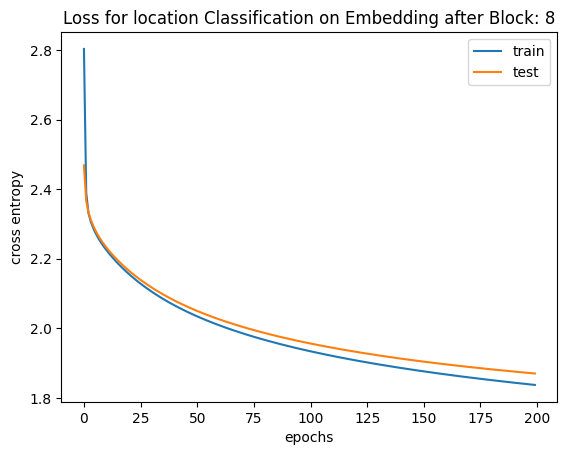

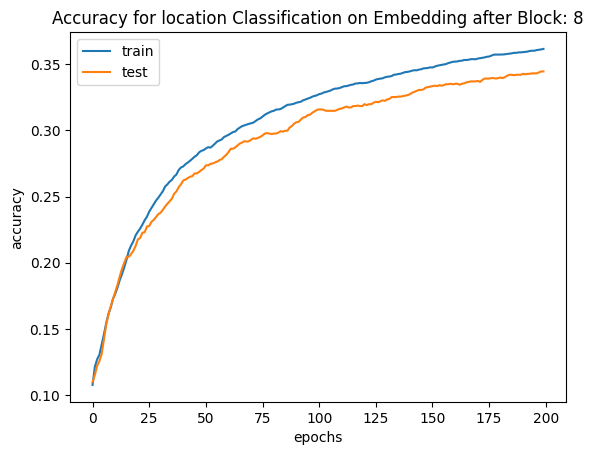

In [211]:
n_epochs = 200
batch_size = 64
batches_per_epoch = len(X_train) // batch_size

# Freeze the parameters of the rest of the model
for param in model.parameters():
    param.requires_grad = False

# # Allow the parameters of the final layer to be updated during training
for param in model.fc3.parameters():
    param.requires_grad = True
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters in the model are: {total_params}")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of paramerters being trained: ", total_trainable_params)

best_loss = np.inf  # Initialize to infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []

# Define the optimizer to update only the parameters of the final layer
# optimizer = torch.optim.SGD(model.layer3.parameters(), lr=0.001)

# Training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    
    # Set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # Take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            # Forward pass
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Update weights
            optimizer.step()

            # Compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # Set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)
        y_val_batch = y_val_tensor.to(device)
        y_pred = model(X_test_batch)
        ce = criterion(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if ce < best_loss:
        best_loss = ce
        best_weights = copy.deepcopy(model.state_dict())

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

# Load the best weights and plot the results
model.load_state_dict(best_weights)

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()


In [212]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [213]:
torch.save(model, fr'{folder_name}{run_mode}_{Block_number}.pth')

In [214]:
model=torch.load(fr'{folder_name}{run_mode}_{Block_number}.pth')
model.to(device)

SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [215]:
X_test=train_ready(test_data,col_name)

In [216]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        output = model(feature.unsqueeze(0))
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred


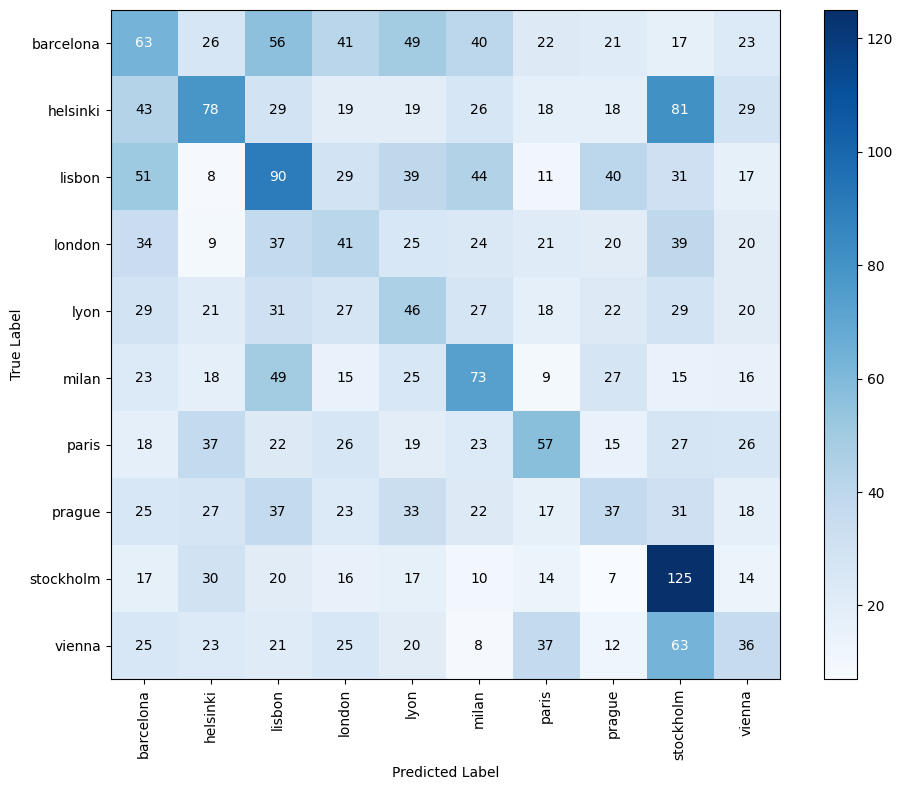

Accuracy: 0.2177


In [217]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)
# loss_list.append()

# Block-9

In [218]:
Block_number=9

In [219]:
model=torch.load(f'{base_dir}/small_model_scene_{Block_number}_opl.pth')

In [220]:
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)

In [221]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [222]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [223]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 10)
(2793, 10)


In [224]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters are {total_params}")
last_layer_params = list(model.parameters())[-2:]  # Assuming the last layer has both weight and bias parameters

# Count the total number of parameters in the last layer
num_params_last_layer = sum(p.numel() for p in last_layer_params)
print(f"Number of parameters in the last layer is {num_params_last_layer}")

Total number of paramerters are 199434
Number of parameters in the last layer is 2570


In [225]:
# for param in model.fc1.parameters():
#     param.requires_grad=False
for param in model.fc2.parameters():
    param.requires_grad = False

In [226]:
nn.init.xavier_uniform_(model.fc3.weight)
nn.init.constant_(model.fc3.bias, 0.0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [227]:
nn.init.xavier_uniform_(model.fc3.weight)
nn.init.constant_(model.fc3.bias, 0.0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [228]:
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of trainable parameters:", total_trainable_params)

Total number of trainable parameters: 2570


In [229]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc3.parameters(), lr=lr)

Total number of paramerters in the model are: 199434
Total number of paramerters being trained:  2570


Epoch 0: 100%|██████████| 174/174 [00:00<00:00, 452.15batch/s, acc=0.0938, loss=2.45]


Epoch 0 validation: Cross-entropy=2.47, Accuracy=10.6%


Epoch 1: 100%|██████████| 174/174 [00:00<00:00, 689.29batch/s, acc=0.0625, loss=2.37]


Epoch 1 validation: Cross-entropy=2.35, Accuracy=12.5%


Epoch 2: 100%|██████████| 174/174 [00:00<00:00, 593.28batch/s, acc=0.0781, loss=2.35]


Epoch 2 validation: Cross-entropy=2.32, Accuracy=13.3%


Epoch 3: 100%|██████████| 174/174 [00:00<00:00, 578.27batch/s, acc=0.0938, loss=2.33]


Epoch 3 validation: Cross-entropy=2.30, Accuracy=14.1%


Epoch 4: 100%|██████████| 174/174 [00:00<00:00, 533.91batch/s, acc=0.0938, loss=2.33]


Epoch 4 validation: Cross-entropy=2.29, Accuracy=14.9%


Epoch 5: 100%|██████████| 174/174 [00:00<00:00, 563.68batch/s, acc=0.0938, loss=2.32]


Epoch 5 validation: Cross-entropy=2.28, Accuracy=15.2%


Epoch 6: 100%|██████████| 174/174 [00:00<00:00, 674.64batch/s, acc=0.0938, loss=2.31]


Epoch 6 validation: Cross-entropy=2.27, Accuracy=15.6%


Epoch 7: 100%|██████████| 174/174 [00:00<00:00, 498.89batch/s, acc=0.109, loss=2.3]  


Epoch 7 validation: Cross-entropy=2.26, Accuracy=15.8%


Epoch 8: 100%|██████████| 174/174 [00:00<00:00, 578.50batch/s, acc=0.109, loss=2.3]  


Epoch 8 validation: Cross-entropy=2.25, Accuracy=16.3%


Epoch 9: 100%|██████████| 174/174 [00:00<00:00, 565.74batch/s, acc=0.109, loss=2.29] 


Epoch 9 validation: Cross-entropy=2.25, Accuracy=16.6%


Epoch 10: 100%|██████████| 174/174 [00:00<00:00, 561.68batch/s, acc=0.125, loss=2.29] 


Epoch 10 validation: Cross-entropy=2.24, Accuracy=17.1%


Epoch 11: 100%|██████████| 174/174 [00:00<00:00, 701.91batch/s, acc=0.125, loss=2.28] 


Epoch 11 validation: Cross-entropy=2.23, Accuracy=17.6%


Epoch 12: 100%|██████████| 174/174 [00:00<00:00, 590.11batch/s, acc=0.125, loss=2.28] 


Epoch 12 validation: Cross-entropy=2.22, Accuracy=18.2%


Epoch 13: 100%|██████████| 174/174 [00:00<00:00, 560.96batch/s, acc=0.125, loss=2.28] 


Epoch 13 validation: Cross-entropy=2.22, Accuracy=18.8%


Epoch 14: 100%|██████████| 174/174 [00:00<00:00, 586.23batch/s, acc=0.125, loss=2.27] 


Epoch 14 validation: Cross-entropy=2.21, Accuracy=18.9%


Epoch 15: 100%|██████████| 174/174 [00:00<00:00, 563.31batch/s, acc=0.125, loss=2.27] 


Epoch 15 validation: Cross-entropy=2.20, Accuracy=19.3%


Epoch 16: 100%|██████████| 174/174 [00:00<00:00, 628.85batch/s, acc=0.125, loss=2.26] 


Epoch 16 validation: Cross-entropy=2.20, Accuracy=19.9%


Epoch 17: 100%|██████████| 174/174 [00:00<00:00, 604.81batch/s, acc=0.125, loss=2.26] 


Epoch 17 validation: Cross-entropy=2.19, Accuracy=20.3%


Epoch 18: 100%|██████████| 174/174 [00:00<00:00, 562.15batch/s, acc=0.125, loss=2.25] 


Epoch 18 validation: Cross-entropy=2.19, Accuracy=20.7%


Epoch 19: 100%|██████████| 174/174 [00:00<00:00, 701.37batch/s, acc=0.125, loss=2.25] 


Epoch 19 validation: Cross-entropy=2.18, Accuracy=21.1%


Epoch 20: 100%|██████████| 174/174 [00:00<00:00, 469.17batch/s, acc=0.125, loss=2.25] 


Epoch 20 validation: Cross-entropy=2.18, Accuracy=21.5%


Epoch 21: 100%|██████████| 174/174 [00:00<00:00, 559.51batch/s, acc=0.125, loss=2.24] 


Epoch 21 validation: Cross-entropy=2.17, Accuracy=22.1%


Epoch 22: 100%|██████████| 174/174 [00:00<00:00, 701.69batch/s, acc=0.125, loss=2.24] 


Epoch 22 validation: Cross-entropy=2.17, Accuracy=22.3%


Epoch 23: 100%|██████████| 174/174 [00:00<00:00, 574.24batch/s, acc=0.125, loss=2.23] 


Epoch 23 validation: Cross-entropy=2.16, Accuracy=22.7%


Epoch 24: 100%|██████████| 174/174 [00:00<00:00, 718.17batch/s, acc=0.125, loss=2.23] 


Epoch 24 validation: Cross-entropy=2.16, Accuracy=22.8%


Epoch 25: 100%|██████████| 174/174 [00:00<00:00, 478.77batch/s, acc=0.109, loss=2.23] 


Epoch 25 validation: Cross-entropy=2.15, Accuracy=23.0%


Epoch 26: 100%|██████████| 174/174 [00:00<00:00, 552.34batch/s, acc=0.109, loss=2.22] 


Epoch 26 validation: Cross-entropy=2.15, Accuracy=23.6%


Epoch 27: 100%|██████████| 174/174 [00:00<00:00, 701.28batch/s, acc=0.125, loss=2.22] 


Epoch 27 validation: Cross-entropy=2.14, Accuracy=23.9%


Epoch 28: 100%|██████████| 174/174 [00:00<00:00, 564.83batch/s, acc=0.141, loss=2.22] 


Epoch 28 validation: Cross-entropy=2.14, Accuracy=24.4%


Epoch 29: 100%|██████████| 174/174 [00:00<00:00, 572.14batch/s, acc=0.141, loss=2.21] 


Epoch 29 validation: Cross-entropy=2.14, Accuracy=24.8%


Epoch 30: 100%|██████████| 174/174 [00:00<00:00, 680.50batch/s, acc=0.141, loss=2.21] 


Epoch 30 validation: Cross-entropy=2.13, Accuracy=25.0%


Epoch 31: 100%|██████████| 174/174 [00:00<00:00, 570.68batch/s, acc=0.141, loss=2.21] 


Epoch 31 validation: Cross-entropy=2.13, Accuracy=25.3%


Epoch 32: 100%|██████████| 174/174 [00:00<00:00, 588.19batch/s, acc=0.141, loss=2.2]  


Epoch 32 validation: Cross-entropy=2.12, Accuracy=25.6%


Epoch 33: 100%|██████████| 174/174 [00:00<00:00, 559.90batch/s, acc=0.141, loss=2.2]  


Epoch 33 validation: Cross-entropy=2.12, Accuracy=25.6%


Epoch 34: 100%|██████████| 174/174 [00:00<00:00, 572.75batch/s, acc=0.141, loss=2.2]  


Epoch 34 validation: Cross-entropy=2.12, Accuracy=26.0%


Epoch 35: 100%|██████████| 174/174 [00:00<00:00, 713.91batch/s, acc=0.156, loss=2.2] 


Epoch 35 validation: Cross-entropy=2.11, Accuracy=26.3%


Epoch 36: 100%|██████████| 174/174 [00:00<00:00, 570.06batch/s, acc=0.141, loss=2.19]


Epoch 36 validation: Cross-entropy=2.11, Accuracy=26.6%


Epoch 37: 100%|██████████| 174/174 [00:00<00:00, 710.21batch/s, acc=0.141, loss=2.19]


Epoch 37 validation: Cross-entropy=2.11, Accuracy=26.7%


Epoch 38: 100%|██████████| 174/174 [00:00<00:00, 483.30batch/s, acc=0.141, loss=2.19]


Epoch 38 validation: Cross-entropy=2.10, Accuracy=27.0%


Epoch 39: 100%|██████████| 174/174 [00:00<00:00, 561.85batch/s, acc=0.156, loss=2.18]


Epoch 39 validation: Cross-entropy=2.10, Accuracy=27.0%


Epoch 40: 100%|██████████| 174/174 [00:00<00:00, 706.81batch/s, acc=0.156, loss=2.18]


Epoch 40 validation: Cross-entropy=2.10, Accuracy=27.1%


Epoch 41: 100%|██████████| 174/174 [00:00<00:00, 576.66batch/s, acc=0.156, loss=2.18]


Epoch 41 validation: Cross-entropy=2.09, Accuracy=27.2%


Epoch 42: 100%|██████████| 174/174 [00:00<00:00, 574.58batch/s, acc=0.156, loss=2.18]


Epoch 42 validation: Cross-entropy=2.09, Accuracy=27.3%


Epoch 43: 100%|██████████| 174/174 [00:00<00:00, 586.12batch/s, acc=0.156, loss=2.17]


Epoch 43 validation: Cross-entropy=2.09, Accuracy=27.6%


Epoch 44: 100%|██████████| 174/174 [00:00<00:00, 575.82batch/s, acc=0.156, loss=2.17]


Epoch 44 validation: Cross-entropy=2.08, Accuracy=27.9%


Epoch 45: 100%|██████████| 174/174 [00:00<00:00, 711.60batch/s, acc=0.172, loss=2.17]


Epoch 45 validation: Cross-entropy=2.08, Accuracy=27.9%


Epoch 46: 100%|██████████| 174/174 [00:00<00:00, 574.21batch/s, acc=0.172, loss=2.16]


Epoch 46 validation: Cross-entropy=2.08, Accuracy=28.0%


Epoch 47: 100%|██████████| 174/174 [00:00<00:00, 574.77batch/s, acc=0.188, loss=2.16]


Epoch 47 validation: Cross-entropy=2.08, Accuracy=28.0%


Epoch 48: 100%|██████████| 174/174 [00:00<00:00, 716.26batch/s, acc=0.188, loss=2.16]


Epoch 48 validation: Cross-entropy=2.07, Accuracy=28.2%


Epoch 49: 100%|██████████| 174/174 [00:00<00:00, 483.36batch/s, acc=0.188, loss=2.16]


Epoch 49 validation: Cross-entropy=2.07, Accuracy=28.4%


Epoch 50: 100%|██████████| 174/174 [00:00<00:00, 706.85batch/s, acc=0.188, loss=2.16]


Epoch 50 validation: Cross-entropy=2.07, Accuracy=28.3%


Epoch 51: 100%|██████████| 174/174 [00:00<00:00, 570.49batch/s, acc=0.188, loss=2.15]


Epoch 51 validation: Cross-entropy=2.07, Accuracy=28.4%


Epoch 52: 100%|██████████| 174/174 [00:00<00:00, 570.18batch/s, acc=0.188, loss=2.15]


Epoch 52 validation: Cross-entropy=2.06, Accuracy=28.5%


Epoch 53: 100%|██████████| 174/174 [00:00<00:00, 709.86batch/s, acc=0.188, loss=2.15]


Epoch 53 validation: Cross-entropy=2.06, Accuracy=28.6%


Epoch 54: 100%|██████████| 174/174 [00:00<00:00, 567.08batch/s, acc=0.203, loss=2.15]


Epoch 54 validation: Cross-entropy=2.06, Accuracy=28.8%


Epoch 55: 100%|██████████| 174/174 [00:00<00:00, 527.51batch/s, acc=0.203, loss=2.14]


Epoch 55 validation: Cross-entropy=2.06, Accuracy=28.8%


Epoch 56: 100%|██████████| 174/174 [00:00<00:00, 638.26batch/s, acc=0.203, loss=2.14]


Epoch 56 validation: Cross-entropy=2.05, Accuracy=28.9%


Epoch 57: 100%|██████████| 174/174 [00:00<00:00, 573.08batch/s, acc=0.203, loss=2.14]


Epoch 57 validation: Cross-entropy=2.05, Accuracy=29.0%


Epoch 58: 100%|██████████| 174/174 [00:00<00:00, 713.95batch/s, acc=0.203, loss=2.14]


Epoch 58 validation: Cross-entropy=2.05, Accuracy=29.0%


Epoch 59: 100%|██████████| 174/174 [00:00<00:00, 575.23batch/s, acc=0.203, loss=2.14]


Epoch 59 validation: Cross-entropy=2.05, Accuracy=29.1%


Epoch 60: 100%|██████████| 174/174 [00:00<00:00, 604.85batch/s, acc=0.203, loss=2.13]


Epoch 60 validation: Cross-entropy=2.04, Accuracy=29.0%


Epoch 61: 100%|██████████| 174/174 [00:00<00:00, 554.22batch/s, acc=0.203, loss=2.13]


Epoch 61 validation: Cross-entropy=2.04, Accuracy=29.0%


Epoch 62: 100%|██████████| 174/174 [00:00<00:00, 571.49batch/s, acc=0.219, loss=2.13]


Epoch 62 validation: Cross-entropy=2.04, Accuracy=29.0%


Epoch 63: 100%|██████████| 174/174 [00:00<00:00, 708.20batch/s, acc=0.219, loss=2.13]


Epoch 63 validation: Cross-entropy=2.04, Accuracy=29.1%


Epoch 64: 100%|██████████| 174/174 [00:00<00:00, 567.83batch/s, acc=0.219, loss=2.13]


Epoch 64 validation: Cross-entropy=2.04, Accuracy=29.3%


Epoch 65: 100%|██████████| 174/174 [00:00<00:00, 558.48batch/s, acc=0.219, loss=2.12]


Epoch 65 validation: Cross-entropy=2.03, Accuracy=29.4%


Epoch 66: 100%|██████████| 174/174 [00:00<00:00, 719.34batch/s, acc=0.219, loss=2.12]


Epoch 66 validation: Cross-entropy=2.03, Accuracy=29.6%


Epoch 67: 100%|██████████| 174/174 [00:00<00:00, 479.70batch/s, acc=0.219, loss=2.12]


Epoch 67 validation: Cross-entropy=2.03, Accuracy=29.8%


Epoch 68: 100%|██████████| 174/174 [00:00<00:00, 593.78batch/s, acc=0.219, loss=2.12]


Epoch 68 validation: Cross-entropy=2.03, Accuracy=29.8%


Epoch 69: 100%|██████████| 174/174 [00:00<00:00, 685.73batch/s, acc=0.219, loss=2.12]


Epoch 69 validation: Cross-entropy=2.03, Accuracy=29.8%


Epoch 70: 100%|██████████| 174/174 [00:00<00:00, 572.06batch/s, acc=0.219, loss=2.11]


Epoch 70 validation: Cross-entropy=2.02, Accuracy=30.0%


Epoch 71: 100%|██████████| 174/174 [00:00<00:00, 712.84batch/s, acc=0.219, loss=2.11]


Epoch 71 validation: Cross-entropy=2.02, Accuracy=30.0%


Epoch 72: 100%|██████████| 174/174 [00:00<00:00, 483.27batch/s, acc=0.219, loss=2.11]


Epoch 72 validation: Cross-entropy=2.02, Accuracy=30.0%


Epoch 73: 100%|██████████| 174/174 [00:00<00:00, 579.02batch/s, acc=0.219, loss=2.11]


Epoch 73 validation: Cross-entropy=2.02, Accuracy=30.1%


Epoch 74: 100%|██████████| 174/174 [00:00<00:00, 706.85batch/s, acc=0.219, loss=2.11]


Epoch 74 validation: Cross-entropy=2.02, Accuracy=30.0%


Epoch 75: 100%|██████████| 174/174 [00:00<00:00, 574.22batch/s, acc=0.219, loss=2.11]


Epoch 75 validation: Cross-entropy=2.02, Accuracy=30.0%


Epoch 76: 100%|██████████| 174/174 [00:00<00:00, 712.34batch/s, acc=0.219, loss=2.1] 


Epoch 76 validation: Cross-entropy=2.01, Accuracy=30.0%


Epoch 77: 100%|██████████| 174/174 [00:00<00:00, 571.63batch/s, acc=0.219, loss=2.1] 


Epoch 77 validation: Cross-entropy=2.01, Accuracy=30.0%


Epoch 78: 100%|██████████| 174/174 [00:00<00:00, 568.32batch/s, acc=0.219, loss=2.1] 


Epoch 78 validation: Cross-entropy=2.01, Accuracy=30.0%


Epoch 79: 100%|██████████| 174/174 [00:00<00:00, 587.00batch/s, acc=0.219, loss=2.1] 


Epoch 79 validation: Cross-entropy=2.01, Accuracy=30.0%


Epoch 80: 100%|██████████| 174/174 [00:00<00:00, 575.67batch/s, acc=0.219, loss=2.1] 


Epoch 80 validation: Cross-entropy=2.01, Accuracy=30.0%


Epoch 81: 100%|██████████| 174/174 [00:00<00:00, 654.48batch/s, acc=0.219, loss=2.1] 


Epoch 81 validation: Cross-entropy=2.01, Accuracy=30.0%


Epoch 82: 100%|██████████| 174/174 [00:00<00:00, 633.62batch/s, acc=0.219, loss=2.09]


Epoch 82 validation: Cross-entropy=2.00, Accuracy=30.1%


Epoch 83: 100%|██████████| 174/174 [00:00<00:00, 575.69batch/s, acc=0.219, loss=2.09]


Epoch 83 validation: Cross-entropy=2.00, Accuracy=30.2%


Epoch 84: 100%|██████████| 174/174 [00:00<00:00, 591.38batch/s, acc=0.219, loss=2.09]


Epoch 84 validation: Cross-entropy=2.00, Accuracy=30.1%


Epoch 85: 100%|██████████| 174/174 [00:00<00:00, 560.01batch/s, acc=0.219, loss=2.09]


Epoch 85 validation: Cross-entropy=2.00, Accuracy=30.1%


Epoch 86: 100%|██████████| 174/174 [00:00<00:00, 572.86batch/s, acc=0.219, loss=2.09]


Epoch 86 validation: Cross-entropy=2.00, Accuracy=30.2%


Epoch 87: 100%|██████████| 174/174 [00:00<00:00, 705.43batch/s, acc=0.219, loss=2.09]


Epoch 87 validation: Cross-entropy=2.00, Accuracy=30.2%


Epoch 88: 100%|██████████| 174/174 [00:00<00:00, 570.56batch/s, acc=0.219, loss=2.09]


Epoch 88 validation: Cross-entropy=2.00, Accuracy=30.2%


Epoch 89: 100%|██████████| 174/174 [00:00<00:00, 589.10batch/s, acc=0.219, loss=2.08]


Epoch 89 validation: Cross-entropy=1.99, Accuracy=30.3%


Epoch 90: 100%|██████████| 174/174 [00:00<00:00, 550.73batch/s, acc=0.219, loss=2.08]


Epoch 90 validation: Cross-entropy=1.99, Accuracy=30.3%


Epoch 91: 100%|██████████| 174/174 [00:00<00:00, 568.16batch/s, acc=0.219, loss=2.08]


Epoch 91 validation: Cross-entropy=1.99, Accuracy=30.4%


Epoch 92: 100%|██████████| 174/174 [00:00<00:00, 710.20batch/s, acc=0.219, loss=2.08]


Epoch 92 validation: Cross-entropy=1.99, Accuracy=30.6%


Epoch 93: 100%|██████████| 174/174 [00:00<00:00, 568.34batch/s, acc=0.219, loss=2.08]


Epoch 93 validation: Cross-entropy=1.99, Accuracy=30.5%


Epoch 94: 100%|██████████| 174/174 [00:00<00:00, 572.40batch/s, acc=0.219, loss=2.08]


Epoch 94 validation: Cross-entropy=1.99, Accuracy=30.6%


Epoch 95: 100%|██████████| 174/174 [00:00<00:00, 708.00batch/s, acc=0.219, loss=2.08]


Epoch 95 validation: Cross-entropy=1.99, Accuracy=30.6%


Epoch 96: 100%|██████████| 174/174 [00:00<00:00, 482.32batch/s, acc=0.219, loss=2.07]


Epoch 96 validation: Cross-entropy=1.98, Accuracy=30.6%


Epoch 97: 100%|██████████| 174/174 [00:00<00:00, 708.75batch/s, acc=0.219, loss=2.07]


Epoch 97 validation: Cross-entropy=1.98, Accuracy=30.6%


Epoch 98: 100%|██████████| 174/174 [00:00<00:00, 561.90batch/s, acc=0.219, loss=2.07]


Epoch 98 validation: Cross-entropy=1.98, Accuracy=30.5%


Epoch 99: 100%|██████████| 174/174 [00:00<00:00, 557.63batch/s, acc=0.219, loss=2.07]


Epoch 99 validation: Cross-entropy=1.98, Accuracy=30.6%


Epoch 100: 100%|██████████| 174/174 [00:00<00:00, 712.43batch/s, acc=0.219, loss=2.07]


Epoch 100 validation: Cross-entropy=1.98, Accuracy=30.6%


Epoch 101: 100%|██████████| 174/174 [00:00<00:00, 532.38batch/s, acc=0.219, loss=2.07]


Epoch 101 validation: Cross-entropy=1.98, Accuracy=30.6%


Epoch 102: 100%|██████████| 174/174 [00:00<00:00, 486.27batch/s, acc=0.219, loss=2.07]


Epoch 102 validation: Cross-entropy=1.98, Accuracy=30.7%


Epoch 103: 100%|██████████| 174/174 [00:00<00:00, 702.23batch/s, acc=0.219, loss=2.07]


Epoch 103 validation: Cross-entropy=1.98, Accuracy=30.7%


Epoch 104: 100%|██████████| 174/174 [00:00<00:00, 569.23batch/s, acc=0.219, loss=2.07]


Epoch 104 validation: Cross-entropy=1.97, Accuracy=30.7%


Epoch 105: 100%|██████████| 174/174 [00:00<00:00, 670.62batch/s, acc=0.219, loss=2.06]


Epoch 105 validation: Cross-entropy=1.97, Accuracy=30.8%


Epoch 106: 100%|██████████| 174/174 [00:00<00:00, 557.50batch/s, acc=0.219, loss=2.06]


Epoch 106 validation: Cross-entropy=1.97, Accuracy=30.8%


Epoch 107: 100%|██████████| 174/174 [00:00<00:00, 575.66batch/s, acc=0.234, loss=2.06]


Epoch 107 validation: Cross-entropy=1.97, Accuracy=31.0%


Epoch 108: 100%|██████████| 174/174 [00:00<00:00, 329.73batch/s, acc=0.234, loss=2.06]


Epoch 108 validation: Cross-entropy=1.97, Accuracy=31.0%


Epoch 109: 100%|██████████| 174/174 [00:00<00:00, 675.92batch/s, acc=0.234, loss=2.06]


Epoch 109 validation: Cross-entropy=1.97, Accuracy=31.1%


Epoch 110: 100%|██████████| 174/174 [00:00<00:00, 547.96batch/s, acc=0.234, loss=2.06]


Epoch 110 validation: Cross-entropy=1.97, Accuracy=31.0%


Epoch 111: 100%|██████████| 174/174 [00:00<00:00, 679.52batch/s, acc=0.25, loss=2.06] 


Epoch 111 validation: Cross-entropy=1.97, Accuracy=31.1%


Epoch 112: 100%|██████████| 174/174 [00:00<00:00, 557.02batch/s, acc=0.25, loss=2.06] 


Epoch 112 validation: Cross-entropy=1.97, Accuracy=31.1%


Epoch 113: 100%|██████████| 174/174 [00:00<00:00, 466.12batch/s, acc=0.25, loss=2.05] 


Epoch 113 validation: Cross-entropy=1.96, Accuracy=31.2%


Epoch 114: 100%|██████████| 174/174 [00:00<00:00, 708.26batch/s, acc=0.25, loss=2.05] 


Epoch 114 validation: Cross-entropy=1.96, Accuracy=31.3%


Epoch 115: 100%|██████████| 174/174 [00:00<00:00, 546.70batch/s, acc=0.25, loss=2.05] 


Epoch 115 validation: Cross-entropy=1.96, Accuracy=31.2%


Epoch 116: 100%|██████████| 174/174 [00:00<00:00, 558.06batch/s, acc=0.25, loss=2.05] 


Epoch 116 validation: Cross-entropy=1.96, Accuracy=31.2%


Epoch 117: 100%|██████████| 174/174 [00:00<00:00, 707.02batch/s, acc=0.25, loss=2.05] 


Epoch 117 validation: Cross-entropy=1.96, Accuracy=31.2%


Epoch 118: 100%|██████████| 174/174 [00:00<00:00, 570.98batch/s, acc=0.25, loss=2.05] 


Epoch 118 validation: Cross-entropy=1.96, Accuracy=31.1%


Epoch 119: 100%|██████████| 174/174 [00:00<00:00, 488.85batch/s, acc=0.25, loss=2.05] 


Epoch 119 validation: Cross-entropy=1.96, Accuracy=31.3%


Epoch 120: 100%|██████████| 174/174 [00:00<00:00, 674.81batch/s, acc=0.25, loss=2.05] 


Epoch 120 validation: Cross-entropy=1.96, Accuracy=31.4%


Epoch 121: 100%|██████████| 174/174 [00:00<00:00, 556.65batch/s, acc=0.25, loss=2.05] 


Epoch 121 validation: Cross-entropy=1.96, Accuracy=31.4%


Epoch 122: 100%|██████████| 174/174 [00:00<00:00, 720.62batch/s, acc=0.25, loss=2.05] 


Epoch 122 validation: Cross-entropy=1.96, Accuracy=31.4%


Epoch 123: 100%|██████████| 174/174 [00:00<00:00, 552.36batch/s, acc=0.25, loss=2.04] 


Epoch 123 validation: Cross-entropy=1.95, Accuracy=31.4%


Epoch 124: 100%|██████████| 174/174 [00:00<00:00, 545.32batch/s, acc=0.25, loss=2.04] 


Epoch 124 validation: Cross-entropy=1.95, Accuracy=31.5%


Epoch 125: 100%|██████████| 174/174 [00:00<00:00, 711.04batch/s, acc=0.25, loss=2.04] 


Epoch 125 validation: Cross-entropy=1.95, Accuracy=31.5%


Epoch 126: 100%|██████████| 174/174 [00:00<00:00, 459.97batch/s, acc=0.25, loss=2.04] 


Epoch 126 validation: Cross-entropy=1.95, Accuracy=31.6%


Epoch 127: 100%|██████████| 174/174 [00:00<00:00, 554.65batch/s, acc=0.25, loss=2.04] 


Epoch 127 validation: Cross-entropy=1.95, Accuracy=31.6%


Epoch 128: 100%|██████████| 174/174 [00:00<00:00, 712.92batch/s, acc=0.25, loss=2.04] 


Epoch 128 validation: Cross-entropy=1.95, Accuracy=31.6%


Epoch 129: 100%|██████████| 174/174 [00:00<00:00, 567.07batch/s, acc=0.25, loss=2.04] 


Epoch 129 validation: Cross-entropy=1.95, Accuracy=31.7%


Epoch 130: 100%|██████████| 174/174 [00:00<00:00, 714.78batch/s, acc=0.25, loss=2.04] 


Epoch 130 validation: Cross-entropy=1.95, Accuracy=31.7%


Epoch 131: 100%|██████████| 174/174 [00:00<00:00, 551.47batch/s, acc=0.25, loss=2.04] 


Epoch 131 validation: Cross-entropy=1.95, Accuracy=31.7%


Epoch 132: 100%|██████████| 174/174 [00:00<00:00, 554.48batch/s, acc=0.25, loss=2.04] 


Epoch 132 validation: Cross-entropy=1.95, Accuracy=31.8%


Epoch 133: 100%|██████████| 174/174 [00:00<00:00, 566.96batch/s, acc=0.25, loss=2.04] 


Epoch 133 validation: Cross-entropy=1.94, Accuracy=31.8%


Epoch 134: 100%|██████████| 174/174 [00:00<00:00, 561.83batch/s, acc=0.25, loss=2.03] 


Epoch 134 validation: Cross-entropy=1.94, Accuracy=31.8%


Epoch 135: 100%|██████████| 174/174 [00:00<00:00, 553.77batch/s, acc=0.25, loss=2.03] 


Epoch 135 validation: Cross-entropy=1.94, Accuracy=31.8%


Epoch 136: 100%|██████████| 174/174 [00:00<00:00, 719.58batch/s, acc=0.25, loss=2.03] 


Epoch 136 validation: Cross-entropy=1.94, Accuracy=31.8%


Epoch 137: 100%|██████████| 174/174 [00:00<00:00, 571.07batch/s, acc=0.25, loss=2.03] 


Epoch 137 validation: Cross-entropy=1.94, Accuracy=32.0%


Epoch 138: 100%|██████████| 174/174 [00:00<00:00, 564.58batch/s, acc=0.25, loss=2.03] 


Epoch 138 validation: Cross-entropy=1.94, Accuracy=32.0%


Epoch 139: 100%|██████████| 174/174 [00:00<00:00, 718.36batch/s, acc=0.25, loss=2.03] 


Epoch 139 validation: Cross-entropy=1.94, Accuracy=32.1%


Epoch 140: 100%|██████████| 174/174 [00:00<00:00, 578.49batch/s, acc=0.25, loss=2.03] 


Epoch 140 validation: Cross-entropy=1.94, Accuracy=32.2%


Epoch 141: 100%|██████████| 174/174 [00:00<00:00, 546.15batch/s, acc=0.25, loss=2.03] 


Epoch 141 validation: Cross-entropy=1.94, Accuracy=32.2%


Epoch 142: 100%|██████████| 174/174 [00:00<00:00, 616.50batch/s, acc=0.25, loss=2.03] 


Epoch 142 validation: Cross-entropy=1.94, Accuracy=32.3%


Epoch 143: 100%|██████████| 174/174 [00:00<00:00, 554.76batch/s, acc=0.25, loss=2.03] 


Epoch 143 validation: Cross-entropy=1.94, Accuracy=32.4%


Epoch 144: 100%|██████████| 174/174 [00:00<00:00, 714.68batch/s, acc=0.25, loss=2.03] 


Epoch 144 validation: Cross-entropy=1.94, Accuracy=32.4%


Epoch 145: 100%|██████████| 174/174 [00:00<00:00, 559.57batch/s, acc=0.25, loss=2.03] 


Epoch 145 validation: Cross-entropy=1.93, Accuracy=32.4%


Epoch 146: 100%|██████████| 174/174 [00:00<00:00, 580.46batch/s, acc=0.25, loss=2.02] 


Epoch 146 validation: Cross-entropy=1.93, Accuracy=32.4%


Epoch 147: 100%|██████████| 174/174 [00:00<00:00, 699.67batch/s, acc=0.25, loss=2.02] 


Epoch 147 validation: Cross-entropy=1.93, Accuracy=32.4%


Epoch 148: 100%|██████████| 174/174 [00:00<00:00, 474.55batch/s, acc=0.25, loss=2.02] 


Epoch 148 validation: Cross-entropy=1.93, Accuracy=32.5%


Epoch 149: 100%|██████████| 174/174 [00:00<00:00, 688.93batch/s, acc=0.25, loss=2.02] 


Epoch 149 validation: Cross-entropy=1.93, Accuracy=32.5%


Epoch 150: 100%|██████████| 174/174 [00:00<00:00, 558.43batch/s, acc=0.25, loss=2.02] 


Epoch 150 validation: Cross-entropy=1.93, Accuracy=32.5%


Epoch 151: 100%|██████████| 174/174 [00:00<00:00, 565.84batch/s, acc=0.25, loss=2.02] 


Epoch 151 validation: Cross-entropy=1.93, Accuracy=32.5%


Epoch 152: 100%|██████████| 174/174 [00:00<00:00, 702.68batch/s, acc=0.25, loss=2.02] 


Epoch 152 validation: Cross-entropy=1.93, Accuracy=32.5%


Epoch 153: 100%|██████████| 174/174 [00:00<00:00, 539.75batch/s, acc=0.266, loss=2.02]


Epoch 153 validation: Cross-entropy=1.93, Accuracy=32.5%


Epoch 154: 100%|██████████| 174/174 [00:00<00:00, 576.77batch/s, acc=0.266, loss=2.02]


Epoch 154 validation: Cross-entropy=1.93, Accuracy=32.4%


Epoch 155: 100%|██████████| 174/174 [00:00<00:00, 731.52batch/s, acc=0.266, loss=2.02]


Epoch 155 validation: Cross-entropy=1.93, Accuracy=32.4%


Epoch 156: 100%|██████████| 174/174 [00:00<00:00, 465.67batch/s, acc=0.266, loss=2.02]


Epoch 156 validation: Cross-entropy=1.93, Accuracy=32.5%


Epoch 157: 100%|██████████| 174/174 [00:00<00:00, 718.49batch/s, acc=0.266, loss=2.02]


Epoch 157 validation: Cross-entropy=1.93, Accuracy=32.5%


Epoch 158: 100%|██████████| 174/174 [00:00<00:00, 546.10batch/s, acc=0.266, loss=2.02]


Epoch 158 validation: Cross-entropy=1.92, Accuracy=32.5%


Epoch 159: 100%|██████████| 174/174 [00:00<00:00, 553.80batch/s, acc=0.281, loss=2.01]


Epoch 159 validation: Cross-entropy=1.92, Accuracy=32.5%


Epoch 160: 100%|██████████| 174/174 [00:00<00:00, 719.07batch/s, acc=0.281, loss=2.01]


Epoch 160 validation: Cross-entropy=1.92, Accuracy=32.6%


Epoch 161: 100%|██████████| 174/174 [00:00<00:00, 565.51batch/s, acc=0.281, loss=2.01]


Epoch 161 validation: Cross-entropy=1.92, Accuracy=32.7%


Epoch 162: 100%|██████████| 174/174 [00:00<00:00, 709.99batch/s, acc=0.281, loss=2.01]


Epoch 162 validation: Cross-entropy=1.92, Accuracy=32.7%


Epoch 163: 100%|██████████| 174/174 [00:00<00:00, 472.70batch/s, acc=0.281, loss=2.01]


Epoch 163 validation: Cross-entropy=1.92, Accuracy=32.8%


Epoch 164: 100%|██████████| 174/174 [00:00<00:00, 551.82batch/s, acc=0.281, loss=2.01]


Epoch 164 validation: Cross-entropy=1.92, Accuracy=32.9%


Epoch 165: 100%|██████████| 174/174 [00:00<00:00, 711.08batch/s, acc=0.281, loss=2.01]


Epoch 165 validation: Cross-entropy=1.92, Accuracy=32.9%


Epoch 166: 100%|██████████| 174/174 [00:00<00:00, 553.37batch/s, acc=0.281, loss=2.01]


Epoch 166 validation: Cross-entropy=1.92, Accuracy=32.8%


Epoch 167: 100%|██████████| 174/174 [00:00<00:00, 554.88batch/s, acc=0.281, loss=2.01]


Epoch 167 validation: Cross-entropy=1.92, Accuracy=32.9%


Epoch 168: 100%|██████████| 174/174 [00:00<00:00, 716.82batch/s, acc=0.281, loss=2.01]


Epoch 168 validation: Cross-entropy=1.92, Accuracy=32.9%


Epoch 169: 100%|██████████| 174/174 [00:00<00:00, 544.26batch/s, acc=0.281, loss=2.01]


Epoch 169 validation: Cross-entropy=1.92, Accuracy=32.9%


Epoch 170: 100%|██████████| 174/174 [00:00<00:00, 626.49batch/s, acc=0.281, loss=2.01]


Epoch 170 validation: Cross-entropy=1.92, Accuracy=33.1%


Epoch 171: 100%|██████████| 174/174 [00:00<00:00, 525.85batch/s, acc=0.281, loss=2.01]


Epoch 171 validation: Cross-entropy=1.92, Accuracy=33.0%


Epoch 172: 100%|██████████| 174/174 [00:00<00:00, 530.91batch/s, acc=0.281, loss=2.01]


Epoch 172 validation: Cross-entropy=1.91, Accuracy=33.1%


Epoch 173: 100%|██████████| 174/174 [00:00<00:00, 629.39batch/s, acc=0.281, loss=2]   


Epoch 173 validation: Cross-entropy=1.91, Accuracy=33.1%


Epoch 174: 100%|██████████| 174/174 [00:00<00:00, 641.44batch/s, acc=0.281, loss=2]   


Epoch 174 validation: Cross-entropy=1.91, Accuracy=33.2%


Epoch 175: 100%|██████████| 174/174 [00:00<00:00, 558.30batch/s, acc=0.281, loss=2]   


Epoch 175 validation: Cross-entropy=1.91, Accuracy=33.3%


Epoch 176: 100%|██████████| 174/174 [00:00<00:00, 718.25batch/s, acc=0.281, loss=2]   


Epoch 176 validation: Cross-entropy=1.91, Accuracy=33.3%


Epoch 177: 100%|██████████| 174/174 [00:00<00:00, 557.12batch/s, acc=0.281, loss=2]   


Epoch 177 validation: Cross-entropy=1.91, Accuracy=33.3%


Epoch 178: 100%|██████████| 174/174 [00:00<00:00, 559.89batch/s, acc=0.281, loss=2]   


Epoch 178 validation: Cross-entropy=1.91, Accuracy=33.3%


Epoch 179: 100%|██████████| 174/174 [00:00<00:00, 566.24batch/s, acc=0.281, loss=2]   


Epoch 179 validation: Cross-entropy=1.91, Accuracy=33.3%


Epoch 180: 100%|██████████| 174/174 [00:00<00:00, 548.79batch/s, acc=0.281, loss=2]   


Epoch 180 validation: Cross-entropy=1.91, Accuracy=33.2%


Epoch 181: 100%|██████████| 174/174 [00:00<00:00, 563.74batch/s, acc=0.281, loss=2]   


Epoch 181 validation: Cross-entropy=1.91, Accuracy=33.2%


Epoch 182: 100%|██████████| 174/174 [00:00<00:00, 684.87batch/s, acc=0.281, loss=2]   


Epoch 182 validation: Cross-entropy=1.91, Accuracy=33.2%


Epoch 183: 100%|██████████| 174/174 [00:00<00:00, 581.26batch/s, acc=0.281, loss=2]   


Epoch 183 validation: Cross-entropy=1.91, Accuracy=33.2%


Epoch 184: 100%|██████████| 174/174 [00:00<00:00, 719.03batch/s, acc=0.297, loss=2]   


Epoch 184 validation: Cross-entropy=1.91, Accuracy=33.3%


Epoch 185: 100%|██████████| 174/174 [00:00<00:00, 575.68batch/s, acc=0.297, loss=2]   


Epoch 185 validation: Cross-entropy=1.91, Accuracy=33.3%


Epoch 186: 100%|██████████| 174/174 [00:00<00:00, 442.50batch/s, acc=0.297, loss=2]   


Epoch 186 validation: Cross-entropy=1.91, Accuracy=33.3%


Epoch 187: 100%|██████████| 174/174 [00:00<00:00, 724.42batch/s, acc=0.297, loss=2]   


Epoch 187 validation: Cross-entropy=1.91, Accuracy=33.4%


Epoch 188: 100%|██████████| 174/174 [00:00<00:00, 590.52batch/s, acc=0.297, loss=2]   


Epoch 188 validation: Cross-entropy=1.91, Accuracy=33.4%


Epoch 189: 100%|██████████| 174/174 [00:00<00:00, 627.55batch/s, acc=0.297, loss=1.99]


Epoch 189 validation: Cross-entropy=1.90, Accuracy=33.4%


Epoch 190: 100%|██████████| 174/174 [00:00<00:00, 629.08batch/s, acc=0.297, loss=1.99]


Epoch 190 validation: Cross-entropy=1.90, Accuracy=33.4%


Epoch 191: 100%|██████████| 174/174 [00:00<00:00, 558.31batch/s, acc=0.297, loss=1.99]


Epoch 191 validation: Cross-entropy=1.90, Accuracy=33.4%


Epoch 192: 100%|██████████| 174/174 [00:00<00:00, 725.96batch/s, acc=0.297, loss=1.99]


Epoch 192 validation: Cross-entropy=1.90, Accuracy=33.4%


Epoch 193: 100%|██████████| 174/174 [00:00<00:00, 560.91batch/s, acc=0.297, loss=1.99]


Epoch 193 validation: Cross-entropy=1.90, Accuracy=33.5%


Epoch 194: 100%|██████████| 174/174 [00:00<00:00, 480.61batch/s, acc=0.297, loss=1.99]


Epoch 194 validation: Cross-entropy=1.90, Accuracy=33.5%


Epoch 195: 100%|██████████| 174/174 [00:00<00:00, 711.04batch/s, acc=0.297, loss=1.99]


Epoch 195 validation: Cross-entropy=1.90, Accuracy=33.5%


Epoch 196: 100%|██████████| 174/174 [00:00<00:00, 544.37batch/s, acc=0.297, loss=1.99]


Epoch 196 validation: Cross-entropy=1.90, Accuracy=33.6%


Epoch 197: 100%|██████████| 174/174 [00:00<00:00, 709.11batch/s, acc=0.297, loss=1.99]


Epoch 197 validation: Cross-entropy=1.90, Accuracy=33.6%


Epoch 198: 100%|██████████| 174/174 [00:00<00:00, 550.80batch/s, acc=0.297, loss=1.99]


Epoch 198 validation: Cross-entropy=1.90, Accuracy=33.6%


Epoch 199: 100%|██████████| 174/174 [00:00<00:00, 537.59batch/s, acc=0.297, loss=1.99]


Epoch 199 validation: Cross-entropy=1.90, Accuracy=33.6%


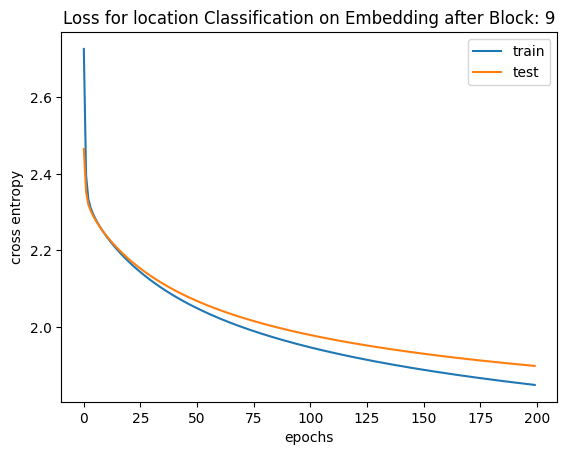

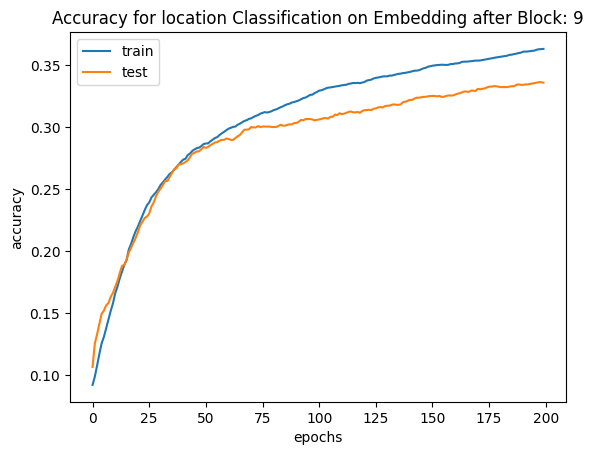

In [230]:
n_epochs = 200
batch_size = 64
batches_per_epoch = len(X_train) // batch_size

# Freeze the parameters of the rest of the model
for param in model.parameters():
    param.requires_grad = False

# # Allow the parameters of the final layer to be updated during training
for param in model.fc3.parameters():
    param.requires_grad = True
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters in the model are: {total_params}")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of paramerters being trained: ", total_trainable_params)

best_loss = np.inf  # Initialize to infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []

# Define the optimizer to update only the parameters of the final layer
# optimizer = torch.optim.SGD(model.layer3.parameters(), lr=0.001)

# Training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    
    # Set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # Take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            # Forward pass
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Update weights
            optimizer.step()

            # Compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # Set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)
        y_val_batch = y_val_tensor.to(device)
        y_pred = model(X_test_batch)
        ce = criterion(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if ce < best_loss:
        best_loss = ce
        best_weights = copy.deepcopy(model.state_dict())

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

# Load the best weights and plot the results
model.load_state_dict(best_weights)

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()


In [231]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [232]:
torch.save(model, fr'{folder_name}{run_mode}_{Block_number}.pth')

In [233]:
model=torch.load(fr'{folder_name}{run_mode}_{Block_number}.pth')
model.to(device)

SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [234]:
X_test=train_ready(test_data,col_name)

In [235]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        output = model(feature.unsqueeze(0))
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred


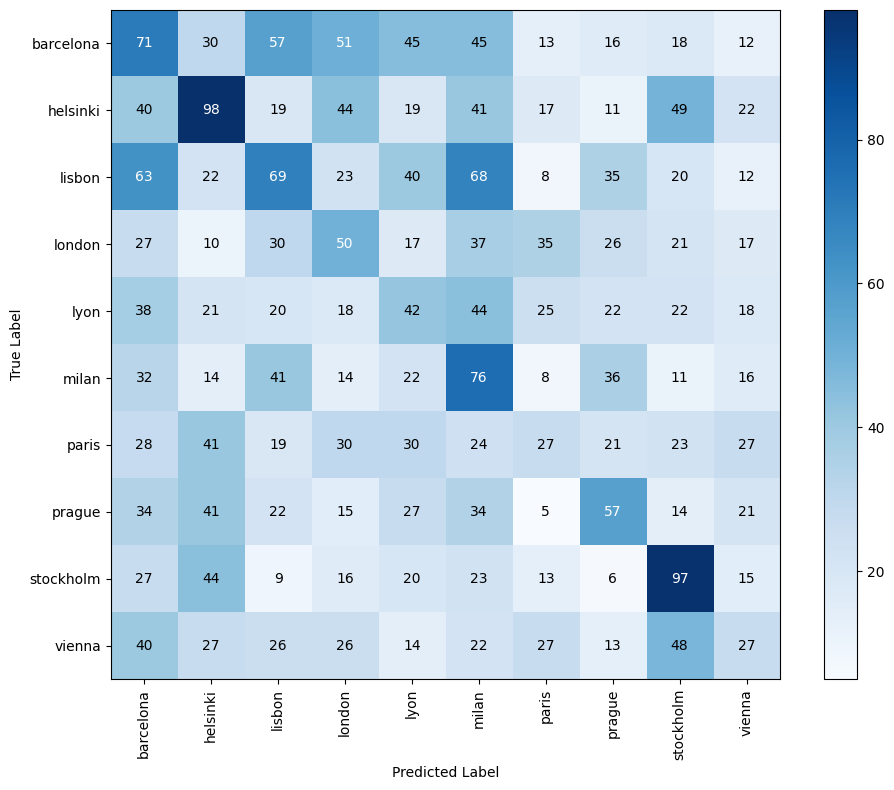

Accuracy: 0.2069


In [236]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)
# loss_list.append()

# Block-10

In [237]:
Block_number=10

In [238]:
model=torch.load(f'{base_dir}/small_model_scene_{Block_number}_opl.pth')

In [239]:
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)

In [240]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [241]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [242]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 10)
(2793, 10)


In [243]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters are {total_params}")
last_layer_params = list(model.parameters())[-2:]  # Assuming the last layer has both weight and bias parameters

# Count the total number of parameters in the last layer
num_params_last_layer = sum(p.numel() for p in last_layer_params)
print(f"Number of parameters in the last layer is {num_params_last_layer}")

Total number of paramerters are 199434
Number of parameters in the last layer is 2570


In [244]:
# for param in model.fc1.parameters():
#     param.requires_grad=False
for param in model.fc2.parameters():
    param.requires_grad = False

In [245]:
nn.init.xavier_uniform_(model.fc3.weight)
nn.init.constant_(model.fc3.bias, 0.0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [246]:
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of trainable parameters:", total_trainable_params)

Total number of trainable parameters: 2570


In [247]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc3.parameters(), lr=lr)

Total number of paramerters in the model are: 199434
Total number of paramerters being trained:  2570


Epoch 0: 100%|██████████| 174/174 [00:00<00:00, 495.12batch/s, acc=0.0938, loss=2.99]


Epoch 0 validation: Cross-entropy=2.79, Accuracy=9.6%


Epoch 1: 100%|██████████| 174/174 [00:00<00:00, 696.91batch/s, acc=0.0625, loss=2.46]


Epoch 1 validation: Cross-entropy=2.39, Accuracy=11.1%


Epoch 2: 100%|██████████| 174/174 [00:00<00:00, 552.21batch/s, acc=0.0781, loss=2.38]


Epoch 2 validation: Cross-entropy=2.34, Accuracy=11.9%


Epoch 3: 100%|██████████| 174/174 [00:00<00:00, 512.94batch/s, acc=0.0938, loss=2.35]


Epoch 3 validation: Cross-entropy=2.31, Accuracy=12.7%


Epoch 4: 100%|██████████| 174/174 [00:00<00:00, 635.49batch/s, acc=0.0781, loss=2.34]


Epoch 4 validation: Cross-entropy=2.30, Accuracy=13.3%


Epoch 5: 100%|██████████| 174/174 [00:00<00:00, 474.29batch/s, acc=0.0938, loss=2.33]


Epoch 5 validation: Cross-entropy=2.29, Accuracy=13.9%


Epoch 6: 100%|██████████| 174/174 [00:00<00:00, 698.27batch/s, acc=0.0938, loss=2.32]


Epoch 6 validation: Cross-entropy=2.28, Accuracy=14.5%


Epoch 7: 100%|██████████| 174/174 [00:00<00:00, 552.49batch/s, acc=0.0781, loss=2.31]


Epoch 7 validation: Cross-entropy=2.27, Accuracy=15.3%


Epoch 8: 100%|██████████| 174/174 [00:00<00:00, 546.95batch/s, acc=0.0781, loss=2.31]


Epoch 8 validation: Cross-entropy=2.26, Accuracy=15.3%


Epoch 9: 100%|██████████| 174/174 [00:00<00:00, 694.98batch/s, acc=0.0938, loss=2.3] 


Epoch 9 validation: Cross-entropy=2.26, Accuracy=15.7%


Epoch 10: 100%|██████████| 174/174 [00:00<00:00, 484.68batch/s, acc=0.109, loss=2.3]  


Epoch 10 validation: Cross-entropy=2.25, Accuracy=15.8%


Epoch 11: 100%|██████████| 174/174 [00:00<00:00, 620.10batch/s, acc=0.125, loss=2.29] 


Epoch 11 validation: Cross-entropy=2.24, Accuracy=16.3%


Epoch 12: 100%|██████████| 174/174 [00:00<00:00, 604.70batch/s, acc=0.141, loss=2.29] 


Epoch 12 validation: Cross-entropy=2.24, Accuracy=16.7%


Epoch 13: 100%|██████████| 174/174 [00:00<00:00, 554.15batch/s, acc=0.156, loss=2.28] 


Epoch 13 validation: Cross-entropy=2.23, Accuracy=16.9%


Epoch 14: 100%|██████████| 174/174 [00:00<00:00, 694.29batch/s, acc=0.156, loss=2.28] 


Epoch 14 validation: Cross-entropy=2.23, Accuracy=17.4%


Epoch 15: 100%|██████████| 174/174 [00:00<00:00, 526.43batch/s, acc=0.156, loss=2.27] 


Epoch 15 validation: Cross-entropy=2.22, Accuracy=18.1%


Epoch 16: 100%|██████████| 174/174 [00:00<00:00, 555.21batch/s, acc=0.156, loss=2.27] 


Epoch 16 validation: Cross-entropy=2.22, Accuracy=18.5%


Epoch 17: 100%|██████████| 174/174 [00:00<00:00, 571.58batch/s, acc=0.172, loss=2.26] 


Epoch 17 validation: Cross-entropy=2.21, Accuracy=18.9%


Epoch 18: 100%|██████████| 174/174 [00:00<00:00, 560.55batch/s, acc=0.188, loss=2.26] 


Epoch 18 validation: Cross-entropy=2.21, Accuracy=19.1%


Epoch 19: 100%|██████████| 174/174 [00:00<00:00, 707.99batch/s, acc=0.188, loss=2.26] 


Epoch 19 validation: Cross-entropy=2.20, Accuracy=19.1%


Epoch 20: 100%|██████████| 174/174 [00:00<00:00, 577.94batch/s, acc=0.203, loss=2.25] 


Epoch 20 validation: Cross-entropy=2.20, Accuracy=19.5%


Epoch 21: 100%|██████████| 174/174 [00:00<00:00, 569.37batch/s, acc=0.203, loss=2.25] 


Epoch 21 validation: Cross-entropy=2.19, Accuracy=19.9%


Epoch 22: 100%|██████████| 174/174 [00:00<00:00, 588.38batch/s, acc=0.203, loss=2.24] 


Epoch 22 validation: Cross-entropy=2.19, Accuracy=20.0%


Epoch 23: 100%|██████████| 174/174 [00:00<00:00, 594.67batch/s, acc=0.188, loss=2.24] 


Epoch 23 validation: Cross-entropy=2.18, Accuracy=20.4%


Epoch 24: 100%|██████████| 174/174 [00:00<00:00, 662.09batch/s, acc=0.203, loss=2.24] 


Epoch 24 validation: Cross-entropy=2.18, Accuracy=20.5%


Epoch 25: 100%|██████████| 174/174 [00:00<00:00, 609.70batch/s, acc=0.203, loss=2.23]


Epoch 25 validation: Cross-entropy=2.18, Accuracy=20.6%


Epoch 26: 100%|██████████| 174/174 [00:00<00:00, 643.63batch/s, acc=0.203, loss=2.23]


Epoch 26 validation: Cross-entropy=2.17, Accuracy=20.8%


Epoch 27: 100%|██████████| 174/174 [00:00<00:00, 646.78batch/s, acc=0.203, loss=2.22] 


Epoch 27 validation: Cross-entropy=2.17, Accuracy=21.3%


Epoch 28: 100%|██████████| 174/174 [00:00<00:00, 463.68batch/s, acc=0.203, loss=2.22] 


Epoch 28 validation: Cross-entropy=2.16, Accuracy=21.6%


Epoch 29: 100%|██████████| 174/174 [00:00<00:00, 655.95batch/s, acc=0.203, loss=2.22] 


Epoch 29 validation: Cross-entropy=2.16, Accuracy=21.9%


Epoch 30: 100%|██████████| 174/174 [00:00<00:00, 563.13batch/s, acc=0.203, loss=2.21] 


Epoch 30 validation: Cross-entropy=2.16, Accuracy=22.2%


Epoch 31: 100%|██████████| 174/174 [00:00<00:00, 590.63batch/s, acc=0.203, loss=2.21] 


Epoch 31 validation: Cross-entropy=2.15, Accuracy=22.3%


Epoch 32: 100%|██████████| 174/174 [00:00<00:00, 678.59batch/s, acc=0.203, loss=2.21] 


Epoch 32 validation: Cross-entropy=2.15, Accuracy=22.3%


Epoch 33: 100%|██████████| 174/174 [00:00<00:00, 565.42batch/s, acc=0.203, loss=2.2]  


Epoch 33 validation: Cross-entropy=2.15, Accuracy=22.4%


Epoch 34: 100%|██████████| 174/174 [00:00<00:00, 583.57batch/s, acc=0.234, loss=2.2]  


Epoch 34 validation: Cross-entropy=2.14, Accuracy=22.6%


Epoch 35: 100%|██████████| 174/174 [00:00<00:00, 579.88batch/s, acc=0.234, loss=2.2]  


Epoch 35 validation: Cross-entropy=2.14, Accuracy=22.7%


Epoch 36: 100%|██████████| 174/174 [00:00<00:00, 574.62batch/s, acc=0.234, loss=2.19]


Epoch 36 validation: Cross-entropy=2.14, Accuracy=23.1%


Epoch 37: 100%|██████████| 174/174 [00:00<00:00, 702.38batch/s, acc=0.25, loss=2.19] 


Epoch 37 validation: Cross-entropy=2.13, Accuracy=23.2%


Epoch 38: 100%|██████████| 174/174 [00:00<00:00, 567.74batch/s, acc=0.25, loss=2.19] 


Epoch 38 validation: Cross-entropy=2.13, Accuracy=23.4%


Epoch 39: 100%|██████████| 174/174 [00:00<00:00, 710.84batch/s, acc=0.25, loss=2.18] 


Epoch 39 validation: Cross-entropy=2.13, Accuracy=23.6%


Epoch 40: 100%|██████████| 174/174 [00:00<00:00, 499.71batch/s, acc=0.25, loss=2.18]  


Epoch 40 validation: Cross-entropy=2.13, Accuracy=23.9%


Epoch 41: 100%|██████████| 174/174 [00:00<00:00, 561.42batch/s, acc=0.25, loss=2.18]  


Epoch 41 validation: Cross-entropy=2.12, Accuracy=24.3%


Epoch 42: 100%|██████████| 174/174 [00:00<00:00, 703.68batch/s, acc=0.234, loss=2.17] 


Epoch 42 validation: Cross-entropy=2.12, Accuracy=24.4%


Epoch 43: 100%|██████████| 174/174 [00:00<00:00, 569.28batch/s, acc=0.234, loss=2.17] 


Epoch 43 validation: Cross-entropy=2.12, Accuracy=24.6%


Epoch 44: 100%|██████████| 174/174 [00:00<00:00, 706.91batch/s, acc=0.234, loss=2.17]


Epoch 44 validation: Cross-entropy=2.12, Accuracy=24.6%


Epoch 45: 100%|██████████| 174/174 [00:00<00:00, 573.82batch/s, acc=0.234, loss=2.17]


Epoch 45 validation: Cross-entropy=2.11, Accuracy=24.8%


Epoch 46: 100%|██████████| 174/174 [00:00<00:00, 488.75batch/s, acc=0.234, loss=2.16]


Epoch 46 validation: Cross-entropy=2.11, Accuracy=25.2%


Epoch 47: 100%|██████████| 174/174 [00:00<00:00, 694.97batch/s, acc=0.234, loss=2.16]


Epoch 47 validation: Cross-entropy=2.11, Accuracy=25.4%


Epoch 48: 100%|██████████| 174/174 [00:00<00:00, 557.99batch/s, acc=0.25, loss=2.16] 


Epoch 48 validation: Cross-entropy=2.11, Accuracy=25.4%


Epoch 49: 100%|██████████| 174/174 [00:00<00:00, 580.73batch/s, acc=0.25, loss=2.15] 


Epoch 49 validation: Cross-entropy=2.10, Accuracy=25.6%


Epoch 50: 100%|██████████| 174/174 [00:00<00:00, 704.29batch/s, acc=0.234, loss=2.15]


Epoch 50 validation: Cross-entropy=2.10, Accuracy=25.7%


Epoch 51: 100%|██████████| 174/174 [00:00<00:00, 492.74batch/s, acc=0.234, loss=2.15]


Epoch 51 validation: Cross-entropy=2.10, Accuracy=25.9%


Epoch 52: 100%|██████████| 174/174 [00:00<00:00, 704.07batch/s, acc=0.234, loss=2.15]


Epoch 52 validation: Cross-entropy=2.10, Accuracy=25.9%


Epoch 53: 100%|██████████| 174/174 [00:00<00:00, 574.98batch/s, acc=0.234, loss=2.14]


Epoch 53 validation: Cross-entropy=2.09, Accuracy=26.0%


Epoch 54: 100%|██████████| 174/174 [00:00<00:00, 575.01batch/s, acc=0.234, loss=2.14]


Epoch 54 validation: Cross-entropy=2.09, Accuracy=26.0%


Epoch 55: 100%|██████████| 174/174 [00:00<00:00, 706.57batch/s, acc=0.25, loss=2.14] 


Epoch 55 validation: Cross-entropy=2.09, Accuracy=26.1%


Epoch 56: 100%|██████████| 174/174 [00:00<00:00, 577.67batch/s, acc=0.25, loss=2.14] 


Epoch 56 validation: Cross-entropy=2.09, Accuracy=26.4%


Epoch 57: 100%|██████████| 174/174 [00:00<00:00, 588.21batch/s, acc=0.25, loss=2.14] 


Epoch 57 validation: Cross-entropy=2.08, Accuracy=26.5%


Epoch 58: 100%|██████████| 174/174 [00:00<00:00, 567.51batch/s, acc=0.25, loss=2.13] 


Epoch 58 validation: Cross-entropy=2.08, Accuracy=26.6%


Epoch 59: 100%|██████████| 174/174 [00:00<00:00, 563.50batch/s, acc=0.25, loss=2.13] 


Epoch 59 validation: Cross-entropy=2.08, Accuracy=26.7%


Epoch 60: 100%|██████████| 174/174 [00:00<00:00, 714.45batch/s, acc=0.25, loss=2.13] 


Epoch 60 validation: Cross-entropy=2.08, Accuracy=26.9%


Epoch 61: 100%|██████████| 174/174 [00:00<00:00, 572.49batch/s, acc=0.25, loss=2.13] 


Epoch 61 validation: Cross-entropy=2.08, Accuracy=27.0%


Epoch 62: 100%|██████████| 174/174 [00:00<00:00, 636.94batch/s, acc=0.25, loss=2.12] 


Epoch 62 validation: Cross-entropy=2.07, Accuracy=27.0%


Epoch 63: 100%|██████████| 174/174 [00:00<00:00, 663.36batch/s, acc=0.25, loss=2.12] 


Epoch 63 validation: Cross-entropy=2.07, Accuracy=27.1%


Epoch 64: 100%|██████████| 174/174 [00:00<00:00, 482.48batch/s, acc=0.25, loss=2.12] 


Epoch 64 validation: Cross-entropy=2.07, Accuracy=27.1%


Epoch 65: 100%|██████████| 174/174 [00:00<00:00, 709.61batch/s, acc=0.25, loss=2.12] 


Epoch 65 validation: Cross-entropy=2.07, Accuracy=27.3%


Epoch 66: 100%|██████████| 174/174 [00:00<00:00, 563.05batch/s, acc=0.25, loss=2.12] 


Epoch 66 validation: Cross-entropy=2.07, Accuracy=27.3%


Epoch 67: 100%|██████████| 174/174 [00:00<00:00, 576.86batch/s, acc=0.25, loss=2.11] 


Epoch 67 validation: Cross-entropy=2.07, Accuracy=27.4%


Epoch 68: 100%|██████████| 174/174 [00:00<00:00, 701.47batch/s, acc=0.25, loss=2.11] 


Epoch 68 validation: Cross-entropy=2.06, Accuracy=27.5%


Epoch 69: 100%|██████████| 174/174 [00:00<00:00, 495.14batch/s, acc=0.25, loss=2.11] 


Epoch 69 validation: Cross-entropy=2.06, Accuracy=27.6%


Epoch 70: 100%|██████████| 174/174 [00:00<00:00, 667.87batch/s, acc=0.234, loss=2.11]


Epoch 70 validation: Cross-entropy=2.06, Accuracy=27.7%


Epoch 71: 100%|██████████| 174/174 [00:00<00:00, 563.96batch/s, acc=0.234, loss=2.11]


Epoch 71 validation: Cross-entropy=2.06, Accuracy=27.9%


Epoch 72: 100%|██████████| 174/174 [00:00<00:00, 564.45batch/s, acc=0.25, loss=2.1]  


Epoch 72 validation: Cross-entropy=2.06, Accuracy=27.7%


Epoch 73: 100%|██████████| 174/174 [00:00<00:00, 707.21batch/s, acc=0.25, loss=2.1]  


Epoch 73 validation: Cross-entropy=2.06, Accuracy=27.9%


Epoch 74: 100%|██████████| 174/174 [00:00<00:00, 576.97batch/s, acc=0.25, loss=2.1]  


Epoch 74 validation: Cross-entropy=2.05, Accuracy=28.0%


Epoch 75: 100%|██████████| 174/174 [00:00<00:00, 479.86batch/s, acc=0.25, loss=2.1]  


Epoch 75 validation: Cross-entropy=2.05, Accuracy=28.1%


Epoch 76: 100%|██████████| 174/174 [00:00<00:00, 695.73batch/s, acc=0.25, loss=2.1]  


Epoch 76 validation: Cross-entropy=2.05, Accuracy=28.2%


Epoch 77: 100%|██████████| 174/174 [00:00<00:00, 565.25batch/s, acc=0.25, loss=2.09] 


Epoch 77 validation: Cross-entropy=2.05, Accuracy=28.3%


Epoch 78: 100%|██████████| 174/174 [00:00<00:00, 687.19batch/s, acc=0.25, loss=2.09] 


Epoch 78 validation: Cross-entropy=2.05, Accuracy=28.5%


Epoch 79: 100%|██████████| 174/174 [00:00<00:00, 566.85batch/s, acc=0.25, loss=2.09] 


Epoch 79 validation: Cross-entropy=2.05, Accuracy=28.5%


Epoch 80: 100%|██████████| 174/174 [00:00<00:00, 512.98batch/s, acc=0.25, loss=2.09] 


Epoch 80 validation: Cross-entropy=2.04, Accuracy=28.5%


Epoch 81: 100%|██████████| 174/174 [00:00<00:00, 683.05batch/s, acc=0.234, loss=2.09]


Epoch 81 validation: Cross-entropy=2.04, Accuracy=28.6%


Epoch 82: 100%|██████████| 174/174 [00:00<00:00, 570.66batch/s, acc=0.234, loss=2.09]


Epoch 82 validation: Cross-entropy=2.04, Accuracy=28.6%


Epoch 83: 100%|██████████| 174/174 [00:00<00:00, 593.02batch/s, acc=0.234, loss=2.08]


Epoch 83 validation: Cross-entropy=2.04, Accuracy=28.7%


Epoch 84: 100%|██████████| 174/174 [00:00<00:00, 670.93batch/s, acc=0.234, loss=2.08]


Epoch 84 validation: Cross-entropy=2.04, Accuracy=28.8%


Epoch 85: 100%|██████████| 174/174 [00:00<00:00, 559.33batch/s, acc=0.234, loss=2.08]


Epoch 85 validation: Cross-entropy=2.04, Accuracy=28.8%


Epoch 86: 100%|██████████| 174/174 [00:00<00:00, 711.50batch/s, acc=0.234, loss=2.08]


Epoch 86 validation: Cross-entropy=2.04, Accuracy=28.9%


Epoch 87: 100%|██████████| 174/174 [00:00<00:00, 489.36batch/s, acc=0.234, loss=2.08]


Epoch 87 validation: Cross-entropy=2.03, Accuracy=28.9%


Epoch 88: 100%|██████████| 174/174 [00:00<00:00, 543.97batch/s, acc=0.234, loss=2.08]


Epoch 88 validation: Cross-entropy=2.03, Accuracy=29.0%


Epoch 89: 100%|██████████| 174/174 [00:00<00:00, 707.10batch/s, acc=0.234, loss=2.07]


Epoch 89 validation: Cross-entropy=2.03, Accuracy=29.0%


Epoch 90: 100%|██████████| 174/174 [00:00<00:00, 571.60batch/s, acc=0.234, loss=2.07]


Epoch 90 validation: Cross-entropy=2.03, Accuracy=29.0%


Epoch 91: 100%|██████████| 174/174 [00:00<00:00, 602.78batch/s, acc=0.234, loss=2.07]


Epoch 91 validation: Cross-entropy=2.03, Accuracy=29.1%


Epoch 92: 100%|██████████| 174/174 [00:00<00:00, 671.36batch/s, acc=0.234, loss=2.07]


Epoch 92 validation: Cross-entropy=2.03, Accuracy=29.1%


Epoch 93: 100%|██████████| 174/174 [00:00<00:00, 483.12batch/s, acc=0.234, loss=2.07]


Epoch 93 validation: Cross-entropy=2.03, Accuracy=29.1%


Epoch 94: 100%|██████████| 174/174 [00:00<00:00, 706.06batch/s, acc=0.234, loss=2.07]


Epoch 94 validation: Cross-entropy=2.02, Accuracy=29.3%


Epoch 95: 100%|██████████| 174/174 [00:00<00:00, 564.88batch/s, acc=0.234, loss=2.07]


Epoch 95 validation: Cross-entropy=2.02, Accuracy=29.3%


Epoch 96: 100%|██████████| 174/174 [00:00<00:00, 564.31batch/s, acc=0.234, loss=2.06]


Epoch 96 validation: Cross-entropy=2.02, Accuracy=29.4%


Epoch 97: 100%|██████████| 174/174 [00:00<00:00, 701.17batch/s, acc=0.234, loss=2.06]


Epoch 97 validation: Cross-entropy=2.02, Accuracy=29.4%


Epoch 98: 100%|██████████| 174/174 [00:00<00:00, 491.50batch/s, acc=0.234, loss=2.06]


Epoch 98 validation: Cross-entropy=2.02, Accuracy=29.5%


Epoch 99: 100%|██████████| 174/174 [00:00<00:00, 698.52batch/s, acc=0.234, loss=2.06]


Epoch 99 validation: Cross-entropy=2.02, Accuracy=29.5%


Epoch 100: 100%|██████████| 174/174 [00:00<00:00, 565.19batch/s, acc=0.234, loss=2.06]


Epoch 100 validation: Cross-entropy=2.02, Accuracy=29.5%


Epoch 101: 100%|██████████| 174/174 [00:00<00:00, 566.78batch/s, acc=0.234, loss=2.06]


Epoch 101 validation: Cross-entropy=2.02, Accuracy=29.5%


Epoch 102: 100%|██████████| 174/174 [00:00<00:00, 705.72batch/s, acc=0.234, loss=2.06]


Epoch 102 validation: Cross-entropy=2.01, Accuracy=29.6%


Epoch 103: 100%|██████████| 174/174 [00:00<00:00, 576.64batch/s, acc=0.234, loss=2.05]


Epoch 103 validation: Cross-entropy=2.01, Accuracy=29.5%


Epoch 104: 100%|██████████| 174/174 [00:00<00:00, 563.50batch/s, acc=0.234, loss=2.05]


Epoch 104 validation: Cross-entropy=2.01, Accuracy=29.5%


Epoch 105: 100%|██████████| 174/174 [00:00<00:00, 597.55batch/s, acc=0.234, loss=2.05]


Epoch 105 validation: Cross-entropy=2.01, Accuracy=29.5%


Epoch 106: 100%|██████████| 174/174 [00:00<00:00, 569.84batch/s, acc=0.234, loss=2.05]


Epoch 106 validation: Cross-entropy=2.01, Accuracy=29.5%


Epoch 107: 100%|██████████| 174/174 [00:00<00:00, 691.24batch/s, acc=0.234, loss=2.05]


Epoch 107 validation: Cross-entropy=2.01, Accuracy=29.5%


Epoch 108: 100%|██████████| 174/174 [00:00<00:00, 566.47batch/s, acc=0.234, loss=2.05]


Epoch 108 validation: Cross-entropy=2.01, Accuracy=29.6%


Epoch 109: 100%|██████████| 174/174 [00:00<00:00, 558.82batch/s, acc=0.234, loss=2.05]


Epoch 109 validation: Cross-entropy=2.01, Accuracy=29.6%


Epoch 110: 100%|██████████| 174/174 [00:00<00:00, 571.67batch/s, acc=0.234, loss=2.05]


Epoch 110 validation: Cross-entropy=2.01, Accuracy=29.6%


Epoch 111: 100%|██████████| 174/174 [00:00<00:00, 569.26batch/s, acc=0.234, loss=2.04]


Epoch 111 validation: Cross-entropy=2.00, Accuracy=29.7%


Epoch 112: 100%|██████████| 174/174 [00:00<00:00, 711.80batch/s, acc=0.234, loss=2.04]


Epoch 112 validation: Cross-entropy=2.00, Accuracy=29.7%


Epoch 113: 100%|██████████| 174/174 [00:00<00:00, 568.35batch/s, acc=0.234, loss=2.04]


Epoch 113 validation: Cross-entropy=2.00, Accuracy=29.8%


Epoch 114: 100%|██████████| 174/174 [00:00<00:00, 578.51batch/s, acc=0.234, loss=2.04]


Epoch 114 validation: Cross-entropy=2.00, Accuracy=29.8%


Epoch 115: 100%|██████████| 174/174 [00:00<00:00, 702.66batch/s, acc=0.234, loss=2.04]


Epoch 115 validation: Cross-entropy=2.00, Accuracy=29.8%


Epoch 116: 100%|██████████| 174/174 [00:00<00:00, 482.43batch/s, acc=0.234, loss=2.04]


Epoch 116 validation: Cross-entropy=2.00, Accuracy=29.8%


Epoch 117: 100%|██████████| 174/174 [00:00<00:00, 706.99batch/s, acc=0.234, loss=2.04]


Epoch 117 validation: Cross-entropy=2.00, Accuracy=29.9%


Epoch 118: 100%|██████████| 174/174 [00:00<00:00, 565.28batch/s, acc=0.234, loss=2.04]


Epoch 118 validation: Cross-entropy=2.00, Accuracy=30.0%


Epoch 119: 100%|██████████| 174/174 [00:00<00:00, 585.16batch/s, acc=0.234, loss=2.03]


Epoch 119 validation: Cross-entropy=2.00, Accuracy=30.0%


Epoch 120: 100%|██████████| 174/174 [00:00<00:00, 703.33batch/s, acc=0.234, loss=2.03]


Epoch 120 validation: Cross-entropy=2.00, Accuracy=30.0%


Epoch 121: 100%|██████████| 174/174 [00:00<00:00, 564.73batch/s, acc=0.234, loss=2.03]


Epoch 121 validation: Cross-entropy=1.99, Accuracy=30.1%


Epoch 122: 100%|██████████| 174/174 [00:00<00:00, 499.87batch/s, acc=0.234, loss=2.03]


Epoch 122 validation: Cross-entropy=1.99, Accuracy=30.1%


Epoch 123: 100%|██████████| 174/174 [00:00<00:00, 674.95batch/s, acc=0.219, loss=2.03]


Epoch 123 validation: Cross-entropy=1.99, Accuracy=30.1%


Epoch 124: 100%|██████████| 174/174 [00:00<00:00, 571.38batch/s, acc=0.219, loss=2.03]


Epoch 124 validation: Cross-entropy=1.99, Accuracy=30.3%


Epoch 125: 100%|██████████| 174/174 [00:00<00:00, 705.37batch/s, acc=0.219, loss=2.03]


Epoch 125 validation: Cross-entropy=1.99, Accuracy=30.3%


Epoch 126: 100%|██████████| 174/174 [00:00<00:00, 523.57batch/s, acc=0.219, loss=2.03]


Epoch 126 validation: Cross-entropy=1.99, Accuracy=30.3%


Epoch 127: 100%|██████████| 174/174 [00:00<00:00, 479.57batch/s, acc=0.219, loss=2.03]


Epoch 127 validation: Cross-entropy=1.99, Accuracy=30.3%


Epoch 128: 100%|██████████| 174/174 [00:00<00:00, 716.02batch/s, acc=0.219, loss=2.02]


Epoch 128 validation: Cross-entropy=1.99, Accuracy=30.3%


Epoch 129: 100%|██████████| 174/174 [00:00<00:00, 603.80batch/s, acc=0.219, loss=2.02]


Epoch 129 validation: Cross-entropy=1.99, Accuracy=30.3%


Epoch 130: 100%|██████████| 174/174 [00:00<00:00, 665.14batch/s, acc=0.219, loss=2.02]


Epoch 130 validation: Cross-entropy=1.99, Accuracy=30.3%


Epoch 131: 100%|██████████| 174/174 [00:00<00:00, 563.68batch/s, acc=0.219, loss=2.02]


Epoch 131 validation: Cross-entropy=1.99, Accuracy=30.4%


Epoch 132: 100%|██████████| 174/174 [00:00<00:00, 576.05batch/s, acc=0.219, loss=2.02]


Epoch 132 validation: Cross-entropy=1.98, Accuracy=30.4%


Epoch 133: 100%|██████████| 174/174 [00:00<00:00, 543.53batch/s, acc=0.219, loss=2.02]


Epoch 133 validation: Cross-entropy=1.98, Accuracy=30.5%


Epoch 134: 100%|██████████| 174/174 [00:00<00:00, 566.58batch/s, acc=0.219, loss=2.02]


Epoch 134 validation: Cross-entropy=1.98, Accuracy=30.5%


Epoch 135: 100%|██████████| 174/174 [00:00<00:00, 700.40batch/s, acc=0.219, loss=2.02]


Epoch 135 validation: Cross-entropy=1.98, Accuracy=30.5%


Epoch 136: 100%|██████████| 174/174 [00:00<00:00, 561.41batch/s, acc=0.219, loss=2.02]


Epoch 136 validation: Cross-entropy=1.98, Accuracy=30.6%


Epoch 137: 100%|██████████| 174/174 [00:00<00:00, 565.90batch/s, acc=0.219, loss=2.02]


Epoch 137 validation: Cross-entropy=1.98, Accuracy=30.6%


Epoch 138: 100%|██████████| 174/174 [00:00<00:00, 702.19batch/s, acc=0.219, loss=2.01]


Epoch 138 validation: Cross-entropy=1.98, Accuracy=30.5%


Epoch 139: 100%|██████████| 174/174 [00:00<00:00, 487.16batch/s, acc=0.219, loss=2.01]


Epoch 139 validation: Cross-entropy=1.98, Accuracy=30.6%


Epoch 140: 100%|██████████| 174/174 [00:00<00:00, 560.24batch/s, acc=0.219, loss=2.01]


Epoch 140 validation: Cross-entropy=1.98, Accuracy=30.6%


Epoch 141: 100%|██████████| 174/174 [00:00<00:00, 703.58batch/s, acc=0.219, loss=2.01]


Epoch 141 validation: Cross-entropy=1.98, Accuracy=30.6%


Epoch 142: 100%|██████████| 174/174 [00:00<00:00, 568.66batch/s, acc=0.219, loss=2.01]


Epoch 142 validation: Cross-entropy=1.98, Accuracy=30.6%


Epoch 143: 100%|██████████| 174/174 [00:00<00:00, 708.99batch/s, acc=0.219, loss=2.01]


Epoch 143 validation: Cross-entropy=1.98, Accuracy=30.8%


Epoch 144: 100%|██████████| 174/174 [00:00<00:00, 564.87batch/s, acc=0.219, loss=2.01]


Epoch 144 validation: Cross-entropy=1.97, Accuracy=30.7%


Epoch 145: 100%|██████████| 174/174 [00:00<00:00, 468.54batch/s, acc=0.219, loss=2.01]


Epoch 145 validation: Cross-entropy=1.97, Accuracy=30.6%


Epoch 146: 100%|██████████| 174/174 [00:00<00:00, 704.54batch/s, acc=0.219, loss=2.01]


Epoch 146 validation: Cross-entropy=1.97, Accuracy=30.6%


Epoch 147: 100%|██████████| 174/174 [00:00<00:00, 568.97batch/s, acc=0.234, loss=2.01]


Epoch 147 validation: Cross-entropy=1.97, Accuracy=30.6%


Epoch 148: 100%|██████████| 174/174 [00:00<00:00, 593.95batch/s, acc=0.234, loss=2.01]


Epoch 148 validation: Cross-entropy=1.97, Accuracy=30.6%


Epoch 149: 100%|██████████| 174/174 [00:00<00:00, 682.37batch/s, acc=0.234, loss=2]   


Epoch 149 validation: Cross-entropy=1.97, Accuracy=30.6%


Epoch 150: 100%|██████████| 174/174 [00:00<00:00, 567.45batch/s, acc=0.234, loss=2]   


Epoch 150 validation: Cross-entropy=1.97, Accuracy=30.7%


Epoch 151: 100%|██████████| 174/174 [00:00<00:00, 595.99batch/s, acc=0.234, loss=2]   


Epoch 151 validation: Cross-entropy=1.97, Accuracy=30.6%


Epoch 152: 100%|██████████| 174/174 [00:00<00:00, 565.48batch/s, acc=0.234, loss=2]   


Epoch 152 validation: Cross-entropy=1.97, Accuracy=30.6%


Epoch 153: 100%|██████████| 174/174 [00:00<00:00, 561.82batch/s, acc=0.234, loss=2]   


Epoch 153 validation: Cross-entropy=1.97, Accuracy=30.7%


Epoch 154: 100%|██████████| 174/174 [00:00<00:00, 696.26batch/s, acc=0.234, loss=2]   


Epoch 154 validation: Cross-entropy=1.97, Accuracy=30.8%


Epoch 155: 100%|██████████| 174/174 [00:00<00:00, 566.14batch/s, acc=0.234, loss=2]   


Epoch 155 validation: Cross-entropy=1.97, Accuracy=30.8%


Epoch 156: 100%|██████████| 174/174 [00:00<00:00, 516.80batch/s, acc=0.234, loss=2]   


Epoch 156 validation: Cross-entropy=1.97, Accuracy=30.8%


Epoch 157: 100%|██████████| 174/174 [00:00<00:00, 657.42batch/s, acc=0.234, loss=2]   


Epoch 157 validation: Cross-entropy=1.96, Accuracy=30.8%


Epoch 158: 100%|██████████| 174/174 [00:00<00:00, 550.86batch/s, acc=0.234, loss=2]   


Epoch 158 validation: Cross-entropy=1.96, Accuracy=30.8%


Epoch 159: 100%|██████████| 174/174 [00:00<00:00, 710.70batch/s, acc=0.234, loss=2]   


Epoch 159 validation: Cross-entropy=1.96, Accuracy=30.8%


Epoch 160: 100%|██████████| 174/174 [00:00<00:00, 569.65batch/s, acc=0.234, loss=1.99]


Epoch 160 validation: Cross-entropy=1.96, Accuracy=30.9%


Epoch 161: 100%|██████████| 174/174 [00:00<00:00, 577.33batch/s, acc=0.234, loss=1.99]


Epoch 161 validation: Cross-entropy=1.96, Accuracy=30.9%


Epoch 162: 100%|██████████| 174/174 [00:00<00:00, 584.39batch/s, acc=0.234, loss=1.99]


Epoch 162 validation: Cross-entropy=1.96, Accuracy=30.9%


Epoch 163: 100%|██████████| 174/174 [00:00<00:00, 567.84batch/s, acc=0.234, loss=1.99]


Epoch 163 validation: Cross-entropy=1.96, Accuracy=31.1%


Epoch 164: 100%|██████████| 174/174 [00:00<00:00, 706.76batch/s, acc=0.234, loss=1.99]


Epoch 164 validation: Cross-entropy=1.96, Accuracy=31.1%


Epoch 165: 100%|██████████| 174/174 [00:00<00:00, 586.06batch/s, acc=0.234, loss=1.99]


Epoch 165 validation: Cross-entropy=1.96, Accuracy=31.1%


Epoch 166: 100%|██████████| 174/174 [00:00<00:00, 594.47batch/s, acc=0.234, loss=1.99]


Epoch 166 validation: Cross-entropy=1.96, Accuracy=31.2%


Epoch 167: 100%|██████████| 174/174 [00:00<00:00, 695.91batch/s, acc=0.234, loss=1.99]


Epoch 167 validation: Cross-entropy=1.96, Accuracy=31.2%


Epoch 168: 100%|██████████| 174/174 [00:00<00:00, 480.19batch/s, acc=0.234, loss=1.99]


Epoch 168 validation: Cross-entropy=1.96, Accuracy=31.3%


Epoch 169: 100%|██████████| 174/174 [00:00<00:00, 678.83batch/s, acc=0.234, loss=1.99]


Epoch 169 validation: Cross-entropy=1.96, Accuracy=31.3%


Epoch 170: 100%|██████████| 174/174 [00:00<00:00, 540.56batch/s, acc=0.234, loss=1.99]


Epoch 170 validation: Cross-entropy=1.96, Accuracy=31.3%


Epoch 171: 100%|██████████| 174/174 [00:00<00:00, 565.97batch/s, acc=0.234, loss=1.99]


Epoch 171 validation: Cross-entropy=1.95, Accuracy=31.4%


Epoch 172: 100%|██████████| 174/174 [00:00<00:00, 711.11batch/s, acc=0.234, loss=1.98]


Epoch 172 validation: Cross-entropy=1.95, Accuracy=31.4%


Epoch 173: 100%|██████████| 174/174 [00:00<00:00, 574.89batch/s, acc=0.234, loss=1.98]


Epoch 173 validation: Cross-entropy=1.95, Accuracy=31.5%


Epoch 174: 100%|██████████| 174/174 [00:00<00:00, 585.55batch/s, acc=0.234, loss=1.98]


Epoch 174 validation: Cross-entropy=1.95, Accuracy=31.5%


Epoch 175: 100%|██████████| 174/174 [00:00<00:00, 556.38batch/s, acc=0.234, loss=1.98]


Epoch 175 validation: Cross-entropy=1.95, Accuracy=31.5%


Epoch 176: 100%|██████████| 174/174 [00:00<00:00, 575.13batch/s, acc=0.234, loss=1.98]


Epoch 176 validation: Cross-entropy=1.95, Accuracy=31.5%


Epoch 177: 100%|██████████| 174/174 [00:00<00:00, 718.25batch/s, acc=0.234, loss=1.98]


Epoch 177 validation: Cross-entropy=1.95, Accuracy=31.5%


Epoch 178: 100%|██████████| 174/174 [00:00<00:00, 571.04batch/s, acc=0.234, loss=1.98]


Epoch 178 validation: Cross-entropy=1.95, Accuracy=31.6%


Epoch 179: 100%|██████████| 174/174 [00:00<00:00, 486.22batch/s, acc=0.234, loss=1.98]


Epoch 179 validation: Cross-entropy=1.95, Accuracy=31.7%


Epoch 180: 100%|██████████| 174/174 [00:00<00:00, 672.50batch/s, acc=0.234, loss=1.98]


Epoch 180 validation: Cross-entropy=1.95, Accuracy=31.6%


Epoch 181: 100%|██████████| 174/174 [00:00<00:00, 568.90batch/s, acc=0.234, loss=1.98]


Epoch 181 validation: Cross-entropy=1.95, Accuracy=31.7%


Epoch 182: 100%|██████████| 174/174 [00:00<00:00, 703.63batch/s, acc=0.234, loss=1.98]


Epoch 182 validation: Cross-entropy=1.95, Accuracy=31.8%


Epoch 183: 100%|██████████| 174/174 [00:00<00:00, 570.90batch/s, acc=0.234, loss=1.98]


Epoch 183 validation: Cross-entropy=1.95, Accuracy=31.8%


Epoch 184: 100%|██████████| 174/174 [00:00<00:00, 583.45batch/s, acc=0.234, loss=1.98]


Epoch 184 validation: Cross-entropy=1.95, Accuracy=31.8%


Epoch 185: 100%|██████████| 174/174 [00:00<00:00, 572.66batch/s, acc=0.234, loss=1.98]


Epoch 185 validation: Cross-entropy=1.95, Accuracy=31.8%


Epoch 186: 100%|██████████| 174/174 [00:00<00:00, 548.94batch/s, acc=0.234, loss=1.97]


Epoch 186 validation: Cross-entropy=1.95, Accuracy=31.9%


Epoch 187: 100%|██████████| 174/174 [00:00<00:00, 711.82batch/s, acc=0.234, loss=1.97]


Epoch 187 validation: Cross-entropy=1.94, Accuracy=31.9%


Epoch 188: 100%|██████████| 174/174 [00:00<00:00, 562.21batch/s, acc=0.234, loss=1.97]


Epoch 188 validation: Cross-entropy=1.94, Accuracy=32.0%


Epoch 189: 100%|██████████| 174/174 [00:00<00:00, 564.43batch/s, acc=0.234, loss=1.97]


Epoch 189 validation: Cross-entropy=1.94, Accuracy=31.9%


Epoch 190: 100%|██████████| 174/174 [00:00<00:00, 704.42batch/s, acc=0.234, loss=1.97]


Epoch 190 validation: Cross-entropy=1.94, Accuracy=32.0%


Epoch 191: 100%|██████████| 174/174 [00:00<00:00, 571.49batch/s, acc=0.234, loss=1.97]


Epoch 191 validation: Cross-entropy=1.94, Accuracy=32.0%


Epoch 192: 100%|██████████| 174/174 [00:00<00:00, 523.42batch/s, acc=0.234, loss=1.97]


Epoch 192 validation: Cross-entropy=1.94, Accuracy=31.9%


Epoch 193: 100%|██████████| 174/174 [00:00<00:00, 639.20batch/s, acc=0.234, loss=1.97]


Epoch 193 validation: Cross-entropy=1.94, Accuracy=32.1%


Epoch 194: 100%|██████████| 174/174 [00:00<00:00, 568.20batch/s, acc=0.25, loss=1.97] 


Epoch 194 validation: Cross-entropy=1.94, Accuracy=32.1%


Epoch 195: 100%|██████████| 174/174 [00:00<00:00, 710.68batch/s, acc=0.25, loss=1.97] 


Epoch 195 validation: Cross-entropy=1.94, Accuracy=32.1%


Epoch 196: 100%|██████████| 174/174 [00:00<00:00, 566.09batch/s, acc=0.25, loss=1.97] 


Epoch 196 validation: Cross-entropy=1.94, Accuracy=32.2%


Epoch 197: 100%|██████████| 174/174 [00:00<00:00, 474.99batch/s, acc=0.25, loss=1.97] 


Epoch 197 validation: Cross-entropy=1.94, Accuracy=32.1%


Epoch 198: 100%|██████████| 174/174 [00:00<00:00, 703.50batch/s, acc=0.25, loss=1.97] 


Epoch 198 validation: Cross-entropy=1.94, Accuracy=32.1%


Epoch 199: 100%|██████████| 174/174 [00:00<00:00, 561.99batch/s, acc=0.25, loss=1.97] 


Epoch 199 validation: Cross-entropy=1.94, Accuracy=32.2%


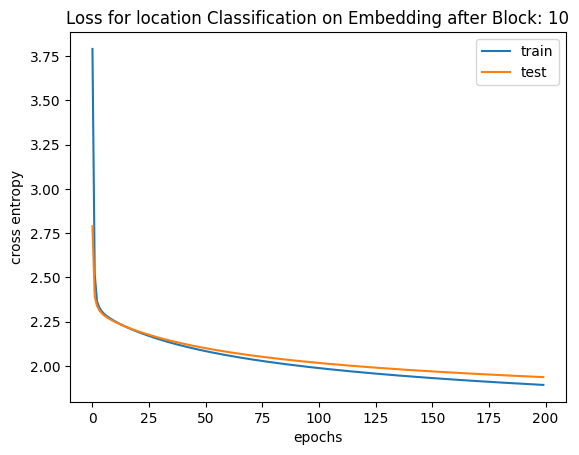

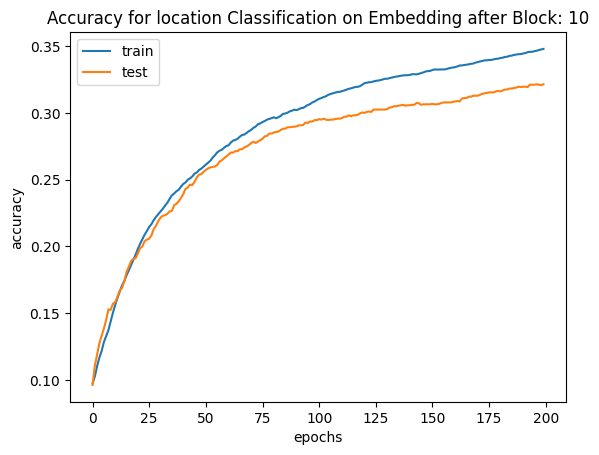

In [248]:
n_epochs = 200
batch_size = 64
batches_per_epoch = len(X_train) // batch_size

# Freeze the parameters of the rest of the model
for param in model.parameters():
    param.requires_grad = False

# # Allow the parameters of the final layer to be updated during training
for param in model.fc3.parameters():
    param.requires_grad = True
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters in the model are: {total_params}")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of paramerters being trained: ", total_trainable_params)

best_loss = np.inf  # Initialize to infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []

# Define the optimizer to update only the parameters of the final layer
# optimizer = torch.optim.SGD(model.layer3.parameters(), lr=0.001)

# Training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    
    # Set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # Take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            # Forward pass
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Update weights
            optimizer.step()

            # Compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # Set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)
        y_val_batch = y_val_tensor.to(device)
        y_pred = model(X_test_batch)
        ce = criterion(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if ce < best_loss:
        best_loss = ce
        best_weights = copy.deepcopy(model.state_dict())

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

# Load the best weights and plot the results
model.load_state_dict(best_weights)

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()


In [249]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [250]:
torch.save(model, fr'{folder_name}{run_mode}_{Block_number}.pth')

In [251]:
model=torch.load(fr'{folder_name}{run_mode}_{Block_number}.pth')
model.to(device)

SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [252]:
X_test=train_ready(test_data,col_name)

In [253]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        output = model(feature.unsqueeze(0))
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred


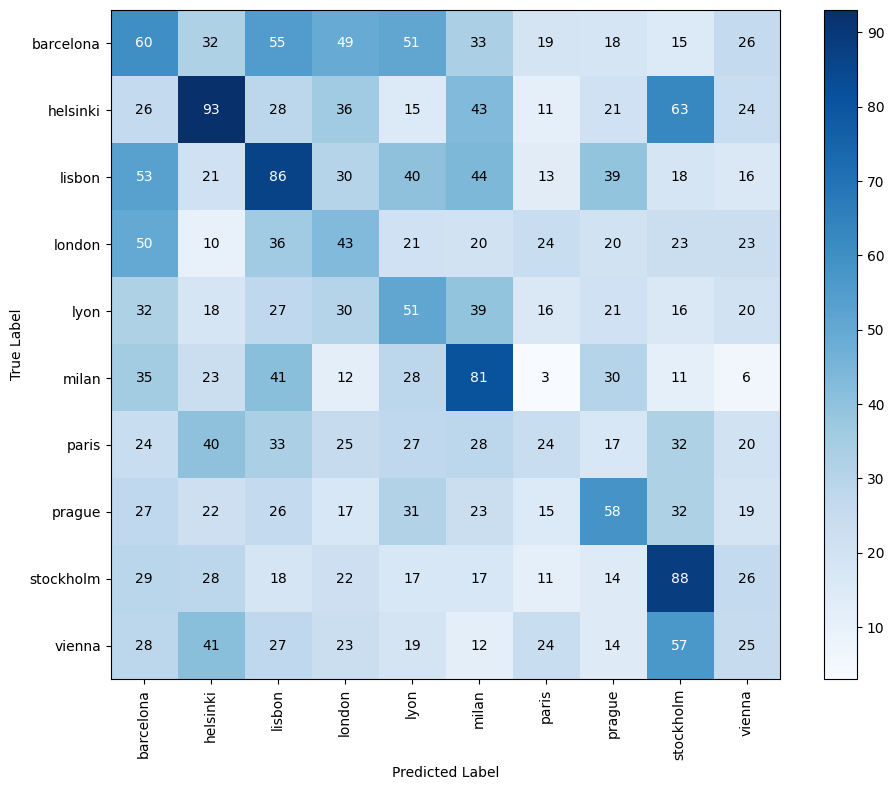

Accuracy: 0.2052


In [254]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)
# loss_list.append()

# Block-11

In [255]:
Block_number=11

In [256]:
model=torch.load(f'{base_dir}/small_model_scene_{Block_number}_opl.pth')

In [257]:
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)

In [258]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [259]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [260]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 10)
(2793, 10)


In [261]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters are {total_params}")
last_layer_params = list(model.parameters())[-2:]  # Assuming the last layer has both weight and bias parameters

# Count the total number of parameters in the last layer
num_params_last_layer = sum(p.numel() for p in last_layer_params)
print(f"Number of parameters in the last layer is {num_params_last_layer}")

Total number of paramerters are 199434
Number of parameters in the last layer is 2570


In [262]:
# for param in model.fc1.parameters():
#     param.requires_grad=False
for param in model.fc2.parameters():
    param.requires_grad = False

In [263]:
nn.init.xavier_uniform_(model.fc3.weight)
nn.init.constant_(model.fc3.bias, 0.0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [264]:
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of trainable parameters:", total_trainable_params)

Total number of trainable parameters: 2570


In [265]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc3.parameters(), lr=lr)

Total number of paramerters in the model are: 199434
Total number of paramerters being trained:  2570


Epoch 0: 100%|██████████| 174/174 [00:00<00:00, 495.31batch/s, acc=0.0781, loss=2.72]


Epoch 0 validation: Cross-entropy=2.65, Accuracy=9.1%


Epoch 1: 100%|██████████| 174/174 [00:00<00:00, 691.68batch/s, acc=0.141, loss=2.51] 


Epoch 1 validation: Cross-entropy=2.45, Accuracy=10.0%


Epoch 2: 100%|██████████| 174/174 [00:00<00:00, 481.45batch/s, acc=0.125, loss=2.41] 


Epoch 2 validation: Cross-entropy=2.38, Accuracy=11.1%


Epoch 3: 100%|██████████| 174/174 [00:00<00:00, 559.07batch/s, acc=0.125, loss=2.35] 


Epoch 3 validation: Cross-entropy=2.35, Accuracy=11.0%


Epoch 4: 100%|██████████| 174/174 [00:00<00:00, 685.75batch/s, acc=0.125, loss=2.32] 


Epoch 4 validation: Cross-entropy=2.33, Accuracy=11.8%


Epoch 5: 100%|██████████| 174/174 [00:00<00:00, 456.11batch/s, acc=0.125, loss=2.3]  


Epoch 5 validation: Cross-entropy=2.32, Accuracy=12.1%


Epoch 6: 100%|██████████| 174/174 [00:00<00:00, 646.13batch/s, acc=0.156, loss=2.28] 


Epoch 6 validation: Cross-entropy=2.31, Accuracy=12.7%


Epoch 7: 100%|██████████| 174/174 [00:00<00:00, 624.28batch/s, acc=0.188, loss=2.27] 


Epoch 7 validation: Cross-entropy=2.30, Accuracy=12.7%


Epoch 8: 100%|██████████| 174/174 [00:00<00:00, 512.08batch/s, acc=0.203, loss=2.26] 


Epoch 8 validation: Cross-entropy=2.30, Accuracy=12.9%


Epoch 9: 100%|██████████| 174/174 [00:00<00:00, 645.88batch/s, acc=0.203, loss=2.25] 


Epoch 9 validation: Cross-entropy=2.29, Accuracy=12.9%


Epoch 10: 100%|██████████| 174/174 [00:00<00:00, 551.91batch/s, acc=0.188, loss=2.24] 


Epoch 10 validation: Cross-entropy=2.28, Accuracy=13.2%


Epoch 11: 100%|██████████| 174/174 [00:00<00:00, 567.86batch/s, acc=0.188, loss=2.24] 


Epoch 11 validation: Cross-entropy=2.28, Accuracy=13.3%


Epoch 12: 100%|██████████| 174/174 [00:00<00:00, 686.23batch/s, acc=0.188, loss=2.23] 


Epoch 12 validation: Cross-entropy=2.27, Accuracy=13.6%


Epoch 13: 100%|██████████| 174/174 [00:00<00:00, 560.39batch/s, acc=0.203, loss=2.23] 


Epoch 13 validation: Cross-entropy=2.27, Accuracy=14.0%


Epoch 14: 100%|██████████| 174/174 [00:00<00:00, 578.00batch/s, acc=0.203, loss=2.22] 


Epoch 14 validation: Cross-entropy=2.26, Accuracy=14.3%


Epoch 15: 100%|██████████| 174/174 [00:00<00:00, 562.47batch/s, acc=0.203, loss=2.22] 


Epoch 15 validation: Cross-entropy=2.26, Accuracy=14.7%


Epoch 16: 100%|██████████| 174/174 [00:00<00:00, 553.57batch/s, acc=0.203, loss=2.21] 


Epoch 16 validation: Cross-entropy=2.26, Accuracy=14.8%


Epoch 17: 100%|██████████| 174/174 [00:00<00:00, 693.37batch/s, acc=0.203, loss=2.21] 


Epoch 17 validation: Cross-entropy=2.25, Accuracy=15.0%


Epoch 18: 100%|██████████| 174/174 [00:00<00:00, 558.10batch/s, acc=0.219, loss=2.2]  


Epoch 18 validation: Cross-entropy=2.25, Accuracy=15.5%


Epoch 19: 100%|██████████| 174/174 [00:00<00:00, 537.97batch/s, acc=0.219, loss=2.2]  


Epoch 19 validation: Cross-entropy=2.24, Accuracy=15.6%


Epoch 20: 100%|██████████| 174/174 [00:00<00:00, 607.45batch/s, acc=0.219, loss=2.2]  


Epoch 20 validation: Cross-entropy=2.24, Accuracy=15.8%


Epoch 21: 100%|██████████| 174/174 [00:00<00:00, 560.04batch/s, acc=0.219, loss=2.19] 


Epoch 21 validation: Cross-entropy=2.24, Accuracy=16.0%


Epoch 22: 100%|██████████| 174/174 [00:00<00:00, 701.18batch/s, acc=0.219, loss=2.19] 


Epoch 22 validation: Cross-entropy=2.23, Accuracy=16.3%


Epoch 23: 100%|██████████| 174/174 [00:00<00:00, 553.34batch/s, acc=0.219, loss=2.19] 


Epoch 23 validation: Cross-entropy=2.23, Accuracy=16.5%


Epoch 24: 100%|██████████| 174/174 [00:00<00:00, 599.92batch/s, acc=0.219, loss=2.18] 


Epoch 24 validation: Cross-entropy=2.23, Accuracy=16.8%


Epoch 25: 100%|██████████| 174/174 [00:00<00:00, 547.95batch/s, acc=0.219, loss=2.18] 


Epoch 25 validation: Cross-entropy=2.22, Accuracy=17.2%


Epoch 26: 100%|██████████| 174/174 [00:00<00:00, 593.67batch/s, acc=0.219, loss=2.18] 


Epoch 26 validation: Cross-entropy=2.22, Accuracy=17.5%


Epoch 27: 100%|██████████| 174/174 [00:00<00:00, 707.25batch/s, acc=0.219, loss=2.17] 


Epoch 27 validation: Cross-entropy=2.22, Accuracy=17.8%


Epoch 28: 100%|██████████| 174/174 [00:00<00:00, 548.14batch/s, acc=0.234, loss=2.17] 


Epoch 28 validation: Cross-entropy=2.21, Accuracy=18.0%


Epoch 29: 100%|██████████| 174/174 [00:00<00:00, 552.52batch/s, acc=0.219, loss=2.17] 


Epoch 29 validation: Cross-entropy=2.21, Accuracy=18.3%


Epoch 30: 100%|██████████| 174/174 [00:00<00:00, 695.50batch/s, acc=0.219, loss=2.16] 


Epoch 30 validation: Cross-entropy=2.21, Accuracy=18.4%


Epoch 31: 100%|██████████| 174/174 [00:00<00:00, 505.33batch/s, acc=0.234, loss=2.16] 


Epoch 31 validation: Cross-entropy=2.21, Accuracy=18.8%


Epoch 32: 100%|██████████| 174/174 [00:00<00:00, 671.41batch/s, acc=0.234, loss=2.16] 


Epoch 32 validation: Cross-entropy=2.20, Accuracy=18.6%


Epoch 33: 100%|██████████| 174/174 [00:00<00:00, 558.53batch/s, acc=0.234, loss=2.16] 


Epoch 33 validation: Cross-entropy=2.20, Accuracy=18.8%


Epoch 34: 100%|██████████| 174/174 [00:00<00:00, 567.51batch/s, acc=0.219, loss=2.15]


Epoch 34 validation: Cross-entropy=2.20, Accuracy=19.2%


Epoch 35: 100%|██████████| 174/174 [00:00<00:00, 686.66batch/s, acc=0.219, loss=2.15]


Epoch 35 validation: Cross-entropy=2.19, Accuracy=19.3%


Epoch 36: 100%|██████████| 174/174 [00:00<00:00, 566.12batch/s, acc=0.234, loss=2.15]


Epoch 36 validation: Cross-entropy=2.19, Accuracy=19.3%


Epoch 37: 100%|██████████| 174/174 [00:00<00:00, 586.09batch/s, acc=0.234, loss=2.15] 


Epoch 37 validation: Cross-entropy=2.19, Accuracy=19.5%


Epoch 38: 100%|██████████| 174/174 [00:00<00:00, 538.77batch/s, acc=0.234, loss=2.14] 


Epoch 38 validation: Cross-entropy=2.19, Accuracy=19.5%


Epoch 39: 100%|██████████| 174/174 [00:00<00:00, 569.03batch/s, acc=0.234, loss=2.14] 


Epoch 39 validation: Cross-entropy=2.18, Accuracy=19.7%


Epoch 40: 100%|██████████| 174/174 [00:00<00:00, 704.70batch/s, acc=0.25, loss=2.14] 


Epoch 40 validation: Cross-entropy=2.18, Accuracy=19.9%


Epoch 41: 100%|██████████| 174/174 [00:00<00:00, 589.74batch/s, acc=0.25, loss=2.14] 


Epoch 41 validation: Cross-entropy=2.18, Accuracy=20.2%


Epoch 42: 100%|██████████| 174/174 [00:00<00:00, 712.21batch/s, acc=0.266, loss=2.13]


Epoch 42 validation: Cross-entropy=2.18, Accuracy=20.2%


Epoch 43: 100%|██████████| 174/174 [00:00<00:00, 481.46batch/s, acc=0.266, loss=2.13]


Epoch 43 validation: Cross-entropy=2.17, Accuracy=20.2%


Epoch 44: 100%|██████████| 174/174 [00:00<00:00, 562.06batch/s, acc=0.281, loss=2.13]


Epoch 44 validation: Cross-entropy=2.17, Accuracy=20.4%


Epoch 45: 100%|██████████| 174/174 [00:00<00:00, 702.81batch/s, acc=0.281, loss=2.13]


Epoch 45 validation: Cross-entropy=2.17, Accuracy=20.6%


Epoch 46: 100%|██████████| 174/174 [00:00<00:00, 560.28batch/s, acc=0.281, loss=2.13]


Epoch 46 validation: Cross-entropy=2.17, Accuracy=20.7%


Epoch 47: 100%|██████████| 174/174 [00:00<00:00, 627.84batch/s, acc=0.281, loss=2.12]


Epoch 47 validation: Cross-entropy=2.17, Accuracy=20.8%


Epoch 48: 100%|██████████| 174/174 [00:00<00:00, 531.41batch/s, acc=0.281, loss=2.12]


Epoch 48 validation: Cross-entropy=2.16, Accuracy=20.8%


Epoch 49: 100%|██████████| 174/174 [00:00<00:00, 559.60batch/s, acc=0.281, loss=2.12]


Epoch 49 validation: Cross-entropy=2.16, Accuracy=21.2%


Epoch 50: 100%|██████████| 174/174 [00:00<00:00, 691.60batch/s, acc=0.281, loss=2.12]


Epoch 50 validation: Cross-entropy=2.16, Accuracy=21.3%


Epoch 51: 100%|██████████| 174/174 [00:00<00:00, 527.64batch/s, acc=0.297, loss=2.11]


Epoch 51 validation: Cross-entropy=2.16, Accuracy=21.4%


Epoch 52: 100%|██████████| 174/174 [00:00<00:00, 560.28batch/s, acc=0.297, loss=2.11]


Epoch 52 validation: Cross-entropy=2.15, Accuracy=21.6%


Epoch 53: 100%|██████████| 174/174 [00:00<00:00, 706.76batch/s, acc=0.312, loss=2.11]


Epoch 53 validation: Cross-entropy=2.15, Accuracy=21.8%


Epoch 54: 100%|██████████| 174/174 [00:00<00:00, 478.53batch/s, acc=0.312, loss=2.11]


Epoch 54 validation: Cross-entropy=2.15, Accuracy=22.0%


Epoch 55: 100%|██████████| 174/174 [00:00<00:00, 680.07batch/s, acc=0.312, loss=2.11]


Epoch 55 validation: Cross-entropy=2.15, Accuracy=22.2%


Epoch 56: 100%|██████████| 174/174 [00:00<00:00, 570.27batch/s, acc=0.312, loss=2.1] 


Epoch 56 validation: Cross-entropy=2.15, Accuracy=22.4%


Epoch 57: 100%|██████████| 174/174 [00:00<00:00, 566.25batch/s, acc=0.312, loss=2.1] 


Epoch 57 validation: Cross-entropy=2.14, Accuracy=22.4%


Epoch 58: 100%|██████████| 174/174 [00:00<00:00, 714.78batch/s, acc=0.312, loss=2.1] 


Epoch 58 validation: Cross-entropy=2.14, Accuracy=22.4%


Epoch 59: 100%|██████████| 174/174 [00:00<00:00, 566.49batch/s, acc=0.312, loss=2.1] 


Epoch 59 validation: Cross-entropy=2.14, Accuracy=22.7%


Epoch 60: 100%|██████████| 174/174 [00:00<00:00, 522.45batch/s, acc=0.312, loss=2.1] 


Epoch 60 validation: Cross-entropy=2.14, Accuracy=23.0%


Epoch 61: 100%|██████████| 174/174 [00:00<00:00, 642.51batch/s, acc=0.312, loss=2.1] 


Epoch 61 validation: Cross-entropy=2.14, Accuracy=23.1%


Epoch 62: 100%|██████████| 174/174 [00:00<00:00, 568.90batch/s, acc=0.312, loss=2.09]


Epoch 62 validation: Cross-entropy=2.14, Accuracy=23.3%


Epoch 63: 100%|██████████| 174/174 [00:00<00:00, 707.00batch/s, acc=0.312, loss=2.09]


Epoch 63 validation: Cross-entropy=2.13, Accuracy=23.6%


Epoch 64: 100%|██████████| 174/174 [00:00<00:00, 567.65batch/s, acc=0.312, loss=2.09]


Epoch 64 validation: Cross-entropy=2.13, Accuracy=23.6%


Epoch 65: 100%|██████████| 174/174 [00:00<00:00, 565.13batch/s, acc=0.328, loss=2.09]


Epoch 65 validation: Cross-entropy=2.13, Accuracy=24.1%


Epoch 66: 100%|██████████| 174/174 [00:00<00:00, 578.92batch/s, acc=0.328, loss=2.09]


Epoch 66 validation: Cross-entropy=2.13, Accuracy=24.1%


Epoch 67: 100%|██████████| 174/174 [00:00<00:00, 565.93batch/s, acc=0.328, loss=2.09]


Epoch 67 validation: Cross-entropy=2.13, Accuracy=24.3%


Epoch 68: 100%|██████████| 174/174 [00:00<00:00, 713.47batch/s, acc=0.328, loss=2.08]


Epoch 68 validation: Cross-entropy=2.13, Accuracy=24.6%


Epoch 69: 100%|██████████| 174/174 [00:00<00:00, 564.41batch/s, acc=0.328, loss=2.08]


Epoch 69 validation: Cross-entropy=2.12, Accuracy=24.7%


Epoch 70: 100%|██████████| 174/174 [00:00<00:00, 568.18batch/s, acc=0.328, loss=2.08]


Epoch 70 validation: Cross-entropy=2.12, Accuracy=24.7%


Epoch 71: 100%|██████████| 174/174 [00:00<00:00, 705.89batch/s, acc=0.328, loss=2.08]


Epoch 71 validation: Cross-entropy=2.12, Accuracy=24.9%


Epoch 72: 100%|██████████| 174/174 [00:00<00:00, 478.65batch/s, acc=0.328, loss=2.08]


Epoch 72 validation: Cross-entropy=2.12, Accuracy=25.0%


Epoch 73: 100%|██████████| 174/174 [00:00<00:00, 621.92batch/s, acc=0.328, loss=2.08]


Epoch 73 validation: Cross-entropy=2.12, Accuracy=25.0%


Epoch 74: 100%|██████████| 174/174 [00:00<00:00, 650.10batch/s, acc=0.328, loss=2.07]


Epoch 74 validation: Cross-entropy=2.12, Accuracy=25.1%


Epoch 75: 100%|██████████| 174/174 [00:00<00:00, 563.78batch/s, acc=0.328, loss=2.07]


Epoch 75 validation: Cross-entropy=2.11, Accuracy=25.2%


Epoch 76: 100%|██████████| 174/174 [00:00<00:00, 706.72batch/s, acc=0.328, loss=2.07]


Epoch 76 validation: Cross-entropy=2.11, Accuracy=25.2%


Epoch 77: 100%|██████████| 174/174 [00:00<00:00, 574.04batch/s, acc=0.312, loss=2.07]


Epoch 77 validation: Cross-entropy=2.11, Accuracy=25.3%


Epoch 78: 100%|██████████| 174/174 [00:00<00:00, 478.92batch/s, acc=0.312, loss=2.07]


Epoch 78 validation: Cross-entropy=2.11, Accuracy=25.5%


Epoch 79: 100%|██████████| 174/174 [00:00<00:00, 693.36batch/s, acc=0.312, loss=2.07]


Epoch 79 validation: Cross-entropy=2.11, Accuracy=25.6%


Epoch 80: 100%|██████████| 174/174 [00:00<00:00, 560.01batch/s, acc=0.312, loss=2.06]


Epoch 80 validation: Cross-entropy=2.11, Accuracy=25.6%


Epoch 81: 100%|██████████| 174/174 [00:00<00:00, 693.17batch/s, acc=0.312, loss=2.06]


Epoch 81 validation: Cross-entropy=2.11, Accuracy=25.7%


Epoch 82: 100%|██████████| 174/174 [00:00<00:00, 568.92batch/s, acc=0.312, loss=2.06]


Epoch 82 validation: Cross-entropy=2.10, Accuracy=25.9%


Epoch 83: 100%|██████████| 174/174 [00:00<00:00, 570.47batch/s, acc=0.312, loss=2.06]


Epoch 83 validation: Cross-entropy=2.10, Accuracy=26.1%


Epoch 84: 100%|██████████| 174/174 [00:00<00:00, 581.21batch/s, acc=0.312, loss=2.06]


Epoch 84 validation: Cross-entropy=2.10, Accuracy=26.2%


Epoch 85: 100%|██████████| 174/174 [00:00<00:00, 563.76batch/s, acc=0.312, loss=2.06]


Epoch 85 validation: Cross-entropy=2.10, Accuracy=26.2%


Epoch 86: 100%|██████████| 174/174 [00:00<00:00, 706.32batch/s, acc=0.312, loss=2.06]


Epoch 86 validation: Cross-entropy=2.10, Accuracy=26.3%


Epoch 87: 100%|██████████| 174/174 [00:00<00:00, 570.66batch/s, acc=0.312, loss=2.05]


Epoch 87 validation: Cross-entropy=2.10, Accuracy=26.2%


Epoch 88: 100%|██████████| 174/174 [00:00<00:00, 567.77batch/s, acc=0.312, loss=2.05]


Epoch 88 validation: Cross-entropy=2.10, Accuracy=26.4%


Epoch 89: 100%|██████████| 174/174 [00:00<00:00, 594.61batch/s, acc=0.312, loss=2.05]


Epoch 89 validation: Cross-entropy=2.09, Accuracy=26.4%


Epoch 90: 100%|██████████| 174/174 [00:00<00:00, 541.20batch/s, acc=0.312, loss=2.05]


Epoch 90 validation: Cross-entropy=2.09, Accuracy=26.6%


Epoch 91: 100%|██████████| 174/174 [00:00<00:00, 699.26batch/s, acc=0.297, loss=2.05]


Epoch 91 validation: Cross-entropy=2.09, Accuracy=26.6%


Epoch 92: 100%|██████████| 174/174 [00:00<00:00, 567.21batch/s, acc=0.297, loss=2.05]


Epoch 92 validation: Cross-entropy=2.09, Accuracy=26.6%


Epoch 93: 100%|██████████| 174/174 [00:00<00:00, 593.55batch/s, acc=0.297, loss=2.05]


Epoch 93 validation: Cross-entropy=2.09, Accuracy=26.6%


Epoch 94: 100%|██████████| 174/174 [00:00<00:00, 688.62batch/s, acc=0.297, loss=2.05]


Epoch 94 validation: Cross-entropy=2.09, Accuracy=26.7%


Epoch 95: 100%|██████████| 174/174 [00:00<00:00, 476.81batch/s, acc=0.297, loss=2.04]


Epoch 95 validation: Cross-entropy=2.09, Accuracy=26.7%


Epoch 96: 100%|██████████| 174/174 [00:00<00:00, 706.52batch/s, acc=0.297, loss=2.04]


Epoch 96 validation: Cross-entropy=2.09, Accuracy=26.8%


Epoch 97: 100%|██████████| 174/174 [00:00<00:00, 566.14batch/s, acc=0.297, loss=2.04]


Epoch 97 validation: Cross-entropy=2.08, Accuracy=26.8%


Epoch 98: 100%|██████████| 174/174 [00:00<00:00, 567.46batch/s, acc=0.297, loss=2.04]


Epoch 98 validation: Cross-entropy=2.08, Accuracy=26.9%


Epoch 99: 100%|██████████| 174/174 [00:00<00:00, 683.93batch/s, acc=0.297, loss=2.04]


Epoch 99 validation: Cross-entropy=2.08, Accuracy=27.0%


Epoch 100: 100%|██████████| 174/174 [00:00<00:00, 555.45batch/s, acc=0.297, loss=2.04]


Epoch 100 validation: Cross-entropy=2.08, Accuracy=27.0%


Epoch 101: 100%|██████████| 174/174 [00:00<00:00, 571.08batch/s, acc=0.297, loss=2.04]


Epoch 101 validation: Cross-entropy=2.08, Accuracy=27.1%


Epoch 102: 100%|██████████| 174/174 [00:00<00:00, 555.78batch/s, acc=0.297, loss=2.04]


Epoch 102 validation: Cross-entropy=2.08, Accuracy=27.2%


Epoch 103: 100%|██████████| 174/174 [00:00<00:00, 560.90batch/s, acc=0.297, loss=2.03]


Epoch 103 validation: Cross-entropy=2.08, Accuracy=27.4%


Epoch 104: 100%|██████████| 174/174 [00:00<00:00, 681.23batch/s, acc=0.297, loss=2.03]


Epoch 104 validation: Cross-entropy=2.08, Accuracy=27.5%


Epoch 105: 100%|██████████| 174/174 [00:00<00:00, 558.27batch/s, acc=0.297, loss=2.03]


Epoch 105 validation: Cross-entropy=2.08, Accuracy=27.6%


Epoch 106: 100%|██████████| 174/174 [00:00<00:00, 552.30batch/s, acc=0.297, loss=2.03]


Epoch 106 validation: Cross-entropy=2.07, Accuracy=27.6%


Epoch 107: 100%|██████████| 174/174 [00:00<00:00, 576.46batch/s, acc=0.297, loss=2.03]


Epoch 107 validation: Cross-entropy=2.07, Accuracy=27.7%


Epoch 108: 100%|██████████| 174/174 [00:00<00:00, 561.47batch/s, acc=0.297, loss=2.03]


Epoch 108 validation: Cross-entropy=2.07, Accuracy=27.9%


Epoch 109: 100%|██████████| 174/174 [00:00<00:00, 702.12batch/s, acc=0.297, loss=2.03]


Epoch 109 validation: Cross-entropy=2.07, Accuracy=27.9%


Epoch 110: 100%|██████████| 174/174 [00:00<00:00, 591.26batch/s, acc=0.297, loss=2.03]


Epoch 110 validation: Cross-entropy=2.07, Accuracy=27.9%


Epoch 111: 100%|██████████| 174/174 [00:00<00:00, 575.35batch/s, acc=0.297, loss=2.03]


Epoch 111 validation: Cross-entropy=2.07, Accuracy=27.9%


Epoch 112: 100%|██████████| 174/174 [00:00<00:00, 570.78batch/s, acc=0.297, loss=2.02]


Epoch 112 validation: Cross-entropy=2.07, Accuracy=27.9%


Epoch 113: 100%|██████████| 174/174 [00:00<00:00, 559.55batch/s, acc=0.297, loss=2.02]


Epoch 113 validation: Cross-entropy=2.07, Accuracy=27.9%


Epoch 114: 100%|██████████| 174/174 [00:00<00:00, 680.02batch/s, acc=0.297, loss=2.02]


Epoch 114 validation: Cross-entropy=2.07, Accuracy=27.9%


Epoch 115: 100%|██████████| 174/174 [00:00<00:00, 599.32batch/s, acc=0.297, loss=2.02]


Epoch 115 validation: Cross-entropy=2.07, Accuracy=27.9%


Epoch 116: 100%|██████████| 174/174 [00:00<00:00, 562.23batch/s, acc=0.297, loss=2.02]


Epoch 116 validation: Cross-entropy=2.06, Accuracy=27.9%


Epoch 117: 100%|██████████| 174/174 [00:00<00:00, 692.88batch/s, acc=0.297, loss=2.02]


Epoch 117 validation: Cross-entropy=2.06, Accuracy=28.0%


Epoch 118: 100%|██████████| 174/174 [00:00<00:00, 486.10batch/s, acc=0.297, loss=2.02]


Epoch 118 validation: Cross-entropy=2.06, Accuracy=28.0%


Epoch 119: 100%|██████████| 174/174 [00:00<00:00, 570.94batch/s, acc=0.297, loss=2.02]


Epoch 119 validation: Cross-entropy=2.06, Accuracy=28.0%


Epoch 120: 100%|██████████| 174/174 [00:00<00:00, 671.73batch/s, acc=0.297, loss=2.02]


Epoch 120 validation: Cross-entropy=2.06, Accuracy=28.1%


Epoch 121: 100%|██████████| 174/174 [00:00<00:00, 563.90batch/s, acc=0.297, loss=2.01]


Epoch 121 validation: Cross-entropy=2.06, Accuracy=28.2%


Epoch 122: 100%|██████████| 174/174 [00:00<00:00, 708.11batch/s, acc=0.297, loss=2.01]


Epoch 122 validation: Cross-entropy=2.06, Accuracy=28.3%


Epoch 123: 100%|██████████| 174/174 [00:00<00:00, 563.98batch/s, acc=0.297, loss=2.01]


Epoch 123 validation: Cross-entropy=2.06, Accuracy=28.3%


Epoch 124: 100%|██████████| 174/174 [00:00<00:00, 482.74batch/s, acc=0.297, loss=2.01]


Epoch 124 validation: Cross-entropy=2.06, Accuracy=28.3%


Epoch 125: 100%|██████████| 174/174 [00:00<00:00, 688.52batch/s, acc=0.297, loss=2.01]


Epoch 125 validation: Cross-entropy=2.06, Accuracy=28.3%


Epoch 126: 100%|██████████| 174/174 [00:00<00:00, 552.70batch/s, acc=0.297, loss=2.01]


Epoch 126 validation: Cross-entropy=2.05, Accuracy=28.3%


Epoch 127: 100%|██████████| 174/174 [00:00<00:00, 697.72batch/s, acc=0.297, loss=2.01]


Epoch 127 validation: Cross-entropy=2.05, Accuracy=28.3%


Epoch 128: 100%|██████████| 174/174 [00:00<00:00, 569.87batch/s, acc=0.297, loss=2.01]


Epoch 128 validation: Cross-entropy=2.05, Accuracy=28.4%


Epoch 129: 100%|██████████| 174/174 [00:00<00:00, 566.96batch/s, acc=0.297, loss=2.01]


Epoch 129 validation: Cross-entropy=2.05, Accuracy=28.5%


Epoch 130: 100%|██████████| 174/174 [00:00<00:00, 574.79batch/s, acc=0.297, loss=2.01]


Epoch 130 validation: Cross-entropy=2.05, Accuracy=28.5%


Epoch 131: 100%|██████████| 174/174 [00:00<00:00, 565.61batch/s, acc=0.297, loss=2]   


Epoch 131 validation: Cross-entropy=2.05, Accuracy=28.5%


Epoch 132: 100%|██████████| 174/174 [00:00<00:00, 667.45batch/s, acc=0.297, loss=2]   


Epoch 132 validation: Cross-entropy=2.05, Accuracy=28.6%


Epoch 133: 100%|██████████| 174/174 [00:00<00:00, 612.29batch/s, acc=0.297, loss=2]   


Epoch 133 validation: Cross-entropy=2.05, Accuracy=28.7%


Epoch 134: 100%|██████████| 174/174 [00:00<00:00, 564.41batch/s, acc=0.297, loss=2]   


Epoch 134 validation: Cross-entropy=2.05, Accuracy=28.7%


Epoch 135: 100%|██████████| 174/174 [00:00<00:00, 576.00batch/s, acc=0.297, loss=2]   


Epoch 135 validation: Cross-entropy=2.05, Accuracy=28.8%


Epoch 136: 100%|██████████| 174/174 [00:00<00:00, 568.05batch/s, acc=0.297, loss=2]   


Epoch 136 validation: Cross-entropy=2.05, Accuracy=28.8%


Epoch 137: 100%|██████████| 174/174 [00:00<00:00, 625.95batch/s, acc=0.297, loss=2]   


Epoch 137 validation: Cross-entropy=2.05, Accuracy=28.8%


Epoch 138: 100%|██████████| 174/174 [00:00<00:00, 638.19batch/s, acc=0.297, loss=2]   


Epoch 138 validation: Cross-entropy=2.04, Accuracy=28.9%


Epoch 139: 100%|██████████| 174/174 [00:00<00:00, 554.55batch/s, acc=0.297, loss=2]   


Epoch 139 validation: Cross-entropy=2.04, Accuracy=29.0%


Epoch 140: 100%|██████████| 174/174 [00:00<00:00, 692.48batch/s, acc=0.297, loss=2]   


Epoch 140 validation: Cross-entropy=2.04, Accuracy=29.0%


Epoch 141: 100%|██████████| 174/174 [00:00<00:00, 479.98batch/s, acc=0.297, loss=1.99]


Epoch 141 validation: Cross-entropy=2.04, Accuracy=29.0%


Epoch 142: 100%|██████████| 174/174 [00:00<00:00, 566.44batch/s, acc=0.297, loss=1.99]


Epoch 142 validation: Cross-entropy=2.04, Accuracy=29.0%


Epoch 143: 100%|██████████| 174/174 [00:00<00:00, 686.87batch/s, acc=0.297, loss=1.99]


Epoch 143 validation: Cross-entropy=2.04, Accuracy=29.0%


Epoch 144: 100%|██████████| 174/174 [00:00<00:00, 567.52batch/s, acc=0.297, loss=1.99]


Epoch 144 validation: Cross-entropy=2.04, Accuracy=29.0%


Epoch 145: 100%|██████████| 174/174 [00:00<00:00, 701.54batch/s, acc=0.297, loss=1.99]


Epoch 145 validation: Cross-entropy=2.04, Accuracy=29.1%


Epoch 146: 100%|██████████| 174/174 [00:00<00:00, 567.08batch/s, acc=0.297, loss=1.99]


Epoch 146 validation: Cross-entropy=2.04, Accuracy=29.1%


Epoch 147: 100%|██████████| 174/174 [00:00<00:00, 476.98batch/s, acc=0.297, loss=1.99]


Epoch 147 validation: Cross-entropy=2.04, Accuracy=29.1%


Epoch 148: 100%|██████████| 174/174 [00:00<00:00, 705.22batch/s, acc=0.297, loss=1.99]


Epoch 148 validation: Cross-entropy=2.04, Accuracy=29.2%


Epoch 149: 100%|██████████| 174/174 [00:00<00:00, 562.20batch/s, acc=0.297, loss=1.99]


Epoch 149 validation: Cross-entropy=2.04, Accuracy=29.3%


Epoch 150: 100%|██████████| 174/174 [00:00<00:00, 693.22batch/s, acc=0.297, loss=1.99]


Epoch 150 validation: Cross-entropy=2.03, Accuracy=29.3%


Epoch 151: 100%|██████████| 174/174 [00:00<00:00, 549.72batch/s, acc=0.297, loss=1.99]


Epoch 151 validation: Cross-entropy=2.03, Accuracy=29.4%


Epoch 152: 100%|██████████| 174/174 [00:00<00:00, 577.13batch/s, acc=0.297, loss=1.98]


Epoch 152 validation: Cross-entropy=2.03, Accuracy=29.4%


Epoch 153: 100%|██████████| 174/174 [00:00<00:00, 563.12batch/s, acc=0.297, loss=1.98]


Epoch 153 validation: Cross-entropy=2.03, Accuracy=29.5%


Epoch 154: 100%|██████████| 174/174 [00:00<00:00, 565.26batch/s, acc=0.297, loss=1.98]


Epoch 154 validation: Cross-entropy=2.03, Accuracy=29.5%


Epoch 155: 100%|██████████| 174/174 [00:00<00:00, 662.34batch/s, acc=0.297, loss=1.98]


Epoch 155 validation: Cross-entropy=2.03, Accuracy=29.5%


Epoch 156: 100%|██████████| 174/174 [00:00<00:00, 563.40batch/s, acc=0.297, loss=1.98]


Epoch 156 validation: Cross-entropy=2.03, Accuracy=29.5%


Epoch 157: 100%|██████████| 174/174 [00:00<00:00, 575.15batch/s, acc=0.297, loss=1.98]


Epoch 157 validation: Cross-entropy=2.03, Accuracy=29.5%


Epoch 158: 100%|██████████| 174/174 [00:00<00:00, 574.92batch/s, acc=0.297, loss=1.98]


Epoch 158 validation: Cross-entropy=2.03, Accuracy=29.5%


Epoch 159: 100%|██████████| 174/174 [00:00<00:00, 543.71batch/s, acc=0.297, loss=1.98]


Epoch 159 validation: Cross-entropy=2.03, Accuracy=29.6%


Epoch 160: 100%|██████████| 174/174 [00:00<00:00, 701.96batch/s, acc=0.297, loss=1.98]


Epoch 160 validation: Cross-entropy=2.03, Accuracy=29.7%


Epoch 161: 100%|██████████| 174/174 [00:00<00:00, 564.55batch/s, acc=0.312, loss=1.98]


Epoch 161 validation: Cross-entropy=2.03, Accuracy=29.8%


Epoch 162: 100%|██████████| 174/174 [00:00<00:00, 561.80batch/s, acc=0.312, loss=1.98]


Epoch 162 validation: Cross-entropy=2.03, Accuracy=29.8%


Epoch 163: 100%|██████████| 174/174 [00:00<00:00, 715.46batch/s, acc=0.312, loss=1.98]


Epoch 163 validation: Cross-entropy=2.03, Accuracy=29.8%


Epoch 164: 100%|██████████| 174/174 [00:00<00:00, 482.13batch/s, acc=0.312, loss=1.97]


Epoch 164 validation: Cross-entropy=2.02, Accuracy=29.9%


Epoch 165: 100%|██████████| 174/174 [00:00<00:00, 696.31batch/s, acc=0.312, loss=1.97]


Epoch 165 validation: Cross-entropy=2.02, Accuracy=29.8%


Epoch 166: 100%|██████████| 174/174 [00:00<00:00, 550.49batch/s, acc=0.312, loss=1.97]


Epoch 166 validation: Cross-entropy=2.02, Accuracy=29.9%


Epoch 167: 100%|██████████| 174/174 [00:00<00:00, 560.12batch/s, acc=0.312, loss=1.97]


Epoch 167 validation: Cross-entropy=2.02, Accuracy=29.9%


Epoch 168: 100%|██████████| 174/174 [00:00<00:00, 696.33batch/s, acc=0.312, loss=1.97]


Epoch 168 validation: Cross-entropy=2.02, Accuracy=30.0%


Epoch 169: 100%|██████████| 174/174 [00:00<00:00, 563.89batch/s, acc=0.312, loss=1.97]


Epoch 169 validation: Cross-entropy=2.02, Accuracy=30.0%


Epoch 170: 100%|██████████| 174/174 [00:00<00:00, 462.31batch/s, acc=0.312, loss=1.97]


Epoch 170 validation: Cross-entropy=2.02, Accuracy=30.0%


Epoch 171: 100%|██████████| 174/174 [00:00<00:00, 695.75batch/s, acc=0.312, loss=1.97]


Epoch 171 validation: Cross-entropy=2.02, Accuracy=30.0%


Epoch 172: 100%|██████████| 174/174 [00:00<00:00, 563.39batch/s, acc=0.312, loss=1.97]


Epoch 172 validation: Cross-entropy=2.02, Accuracy=30.0%


Epoch 173: 100%|██████████| 174/174 [00:00<00:00, 695.94batch/s, acc=0.312, loss=1.97]


Epoch 173 validation: Cross-entropy=2.02, Accuracy=30.2%


Epoch 174: 100%|██████████| 174/174 [00:00<00:00, 567.84batch/s, acc=0.312, loss=1.97]


Epoch 174 validation: Cross-entropy=2.02, Accuracy=30.2%


Epoch 175: 100%|██████████| 174/174 [00:00<00:00, 560.99batch/s, acc=0.312, loss=1.97]


Epoch 175 validation: Cross-entropy=2.02, Accuracy=30.3%


Epoch 176: 100%|██████████| 174/174 [00:00<00:00, 583.36batch/s, acc=0.312, loss=1.97]


Epoch 176 validation: Cross-entropy=2.02, Accuracy=30.3%


Epoch 177: 100%|██████████| 174/174 [00:00<00:00, 569.04batch/s, acc=0.312, loss=1.96]


Epoch 177 validation: Cross-entropy=2.02, Accuracy=30.3%


Epoch 178: 100%|██████████| 174/174 [00:00<00:00, 711.46batch/s, acc=0.312, loss=1.96]


Epoch 178 validation: Cross-entropy=2.02, Accuracy=30.3%


Epoch 179: 100%|██████████| 174/174 [00:00<00:00, 579.23batch/s, acc=0.312, loss=1.96]


Epoch 179 validation: Cross-entropy=2.02, Accuracy=30.3%


Epoch 180: 100%|██████████| 174/174 [00:00<00:00, 568.43batch/s, acc=0.312, loss=1.96]


Epoch 180 validation: Cross-entropy=2.01, Accuracy=30.3%


Epoch 181: 100%|██████████| 174/174 [00:00<00:00, 596.28batch/s, acc=0.312, loss=1.96]


Epoch 181 validation: Cross-entropy=2.01, Accuracy=30.4%


Epoch 182: 100%|██████████| 174/174 [00:00<00:00, 552.48batch/s, acc=0.312, loss=1.96]


Epoch 182 validation: Cross-entropy=2.01, Accuracy=30.5%


Epoch 183: 100%|██████████| 174/174 [00:00<00:00, 587.35batch/s, acc=0.312, loss=1.96]


Epoch 183 validation: Cross-entropy=2.01, Accuracy=30.6%


Epoch 184: 100%|██████████| 174/174 [00:00<00:00, 674.13batch/s, acc=0.312, loss=1.96]


Epoch 184 validation: Cross-entropy=2.01, Accuracy=30.7%


Epoch 185: 100%|██████████| 174/174 [00:00<00:00, 566.17batch/s, acc=0.312, loss=1.96]


Epoch 185 validation: Cross-entropy=2.01, Accuracy=30.6%


Epoch 186: 100%|██████████| 174/174 [00:00<00:00, 691.81batch/s, acc=0.312, loss=1.96]


Epoch 186 validation: Cross-entropy=2.01, Accuracy=30.6%


Epoch 187: 100%|██████████| 174/174 [00:00<00:00, 476.66batch/s, acc=0.312, loss=1.96]


Epoch 187 validation: Cross-entropy=2.01, Accuracy=30.7%


Epoch 188: 100%|██████████| 174/174 [00:00<00:00, 557.65batch/s, acc=0.312, loss=1.96]


Epoch 188 validation: Cross-entropy=2.01, Accuracy=30.6%


Epoch 189: 100%|██████████| 174/174 [00:00<00:00, 703.56batch/s, acc=0.312, loss=1.96]


Epoch 189 validation: Cross-entropy=2.01, Accuracy=30.6%


Epoch 190: 100%|██████████| 174/174 [00:00<00:00, 568.07batch/s, acc=0.312, loss=1.95]


Epoch 190 validation: Cross-entropy=2.01, Accuracy=30.6%


Epoch 191: 100%|██████████| 174/174 [00:00<00:00, 708.86batch/s, acc=0.312, loss=1.95]


Epoch 191 validation: Cross-entropy=2.01, Accuracy=30.5%


Epoch 192: 100%|██████████| 174/174 [00:00<00:00, 568.60batch/s, acc=0.312, loss=1.95]


Epoch 192 validation: Cross-entropy=2.01, Accuracy=30.5%


Epoch 193: 100%|██████████| 174/174 [00:00<00:00, 560.76batch/s, acc=0.312, loss=1.95]


Epoch 193 validation: Cross-entropy=2.01, Accuracy=30.6%


Epoch 194: 100%|██████████| 174/174 [00:00<00:00, 582.45batch/s, acc=0.312, loss=1.95]


Epoch 194 validation: Cross-entropy=2.01, Accuracy=30.6%


Epoch 195: 100%|██████████| 174/174 [00:00<00:00, 588.64batch/s, acc=0.312, loss=1.95]


Epoch 195 validation: Cross-entropy=2.01, Accuracy=30.6%


Epoch 196: 100%|██████████| 174/174 [00:00<00:00, 704.31batch/s, acc=0.312, loss=1.95]


Epoch 196 validation: Cross-entropy=2.01, Accuracy=30.8%


Epoch 197: 100%|██████████| 174/174 [00:00<00:00, 565.96batch/s, acc=0.312, loss=1.95]


Epoch 197 validation: Cross-entropy=2.00, Accuracy=30.8%


Epoch 198: 100%|██████████| 174/174 [00:00<00:00, 561.11batch/s, acc=0.312, loss=1.95]


Epoch 198 validation: Cross-entropy=2.00, Accuracy=30.8%


Epoch 199: 100%|██████████| 174/174 [00:00<00:00, 572.12batch/s, acc=0.312, loss=1.95]


Epoch 199 validation: Cross-entropy=2.00, Accuracy=30.8%


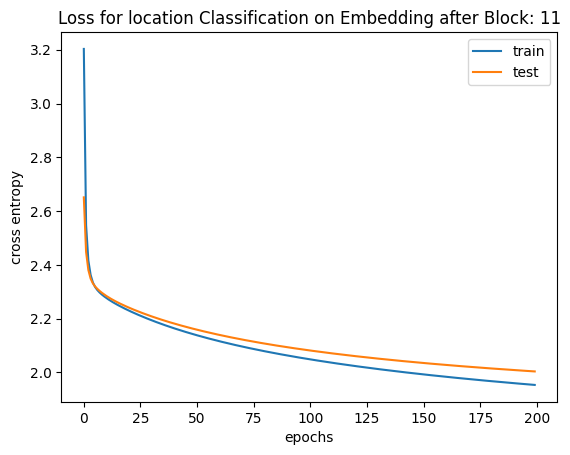

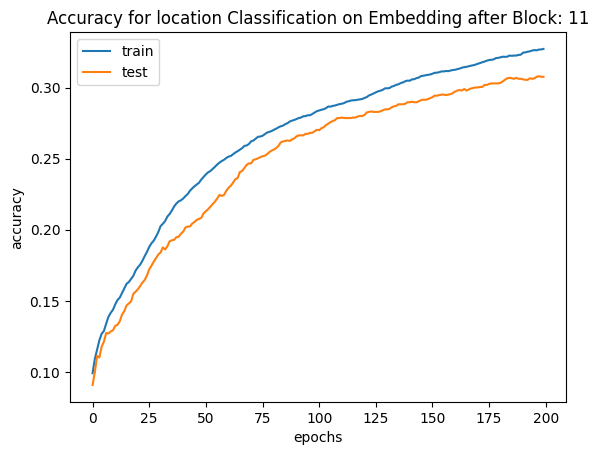

In [266]:
n_epochs = 200
batch_size = 64
batches_per_epoch = len(X_train) // batch_size

# Freeze the parameters of the rest of the model
for param in model.parameters():
    param.requires_grad = False

# # Allow the parameters of the final layer to be updated during training
for param in model.fc3.parameters():
    param.requires_grad = True
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters in the model are: {total_params}")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of paramerters being trained: ", total_trainable_params)

best_loss = np.inf  # Initialize to infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []

# Define the optimizer to update only the parameters of the final layer
# optimizer = torch.optim.SGD(model.layer3.parameters(), lr=0.001)

# Training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    
    # Set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # Take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            # Forward pass
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Update weights
            optimizer.step()

            # Compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # Set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)
        y_val_batch = y_val_tensor.to(device)
        y_pred = model(X_test_batch)
        ce = criterion(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if ce < best_loss:
        best_loss = ce
        best_weights = copy.deepcopy(model.state_dict())

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

# Load the best weights and plot the results
model.load_state_dict(best_weights)

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()


In [267]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [268]:
torch.save(model, fr'{folder_name}{run_mode}_{Block_number}.pth')

In [269]:
model=torch.load(fr'{folder_name}{run_mode}_{Block_number}.pth')
model.to(device)

SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [270]:
X_test=train_ready(test_data,col_name)

In [271]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        output = model(feature.unsqueeze(0))
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred


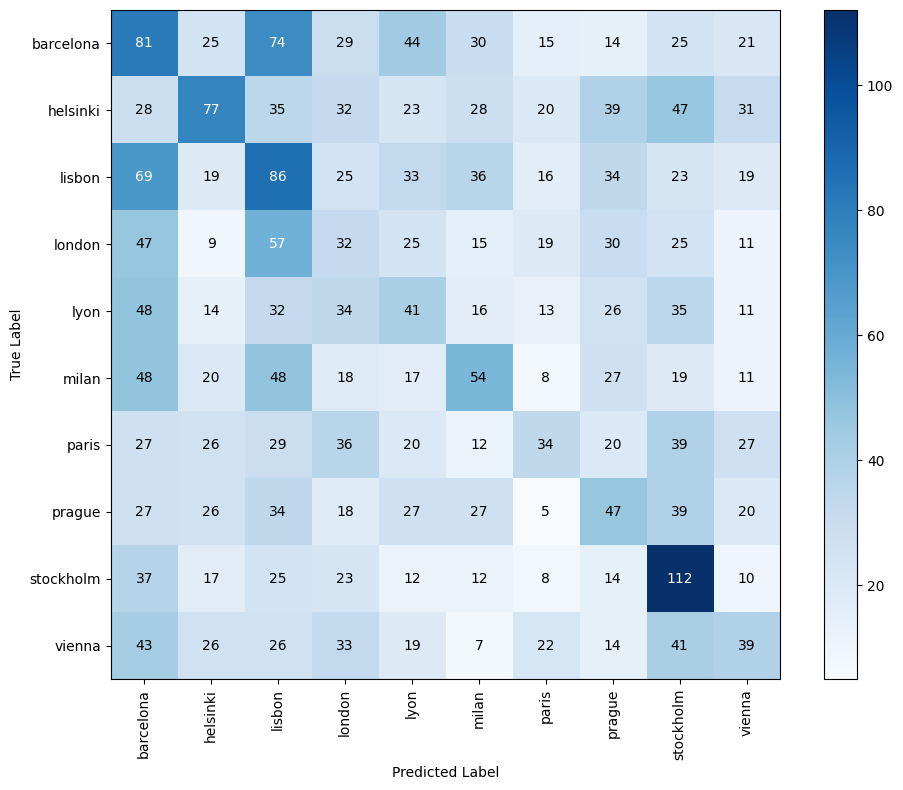

Accuracy: 0.2032


In [272]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)
# loss_list.append()

# Block-12

In [273]:
Block_number=12

In [274]:
model=torch.load(f'{base_dir}/small_model_scene_{Block_number}_opl.pth')

In [275]:
col_name=f'embedding{Block_number}'
final_X_train=train_ready(data,col_name)
final_X_train=np.array(final_X_train)

In [276]:
X_train, X_val, y_train, y_val = train_test_split(final_X_train, y_one_hot_encoded, test_size=0.2, random_state=42, stratify=y_one_hot_encoded)

In [277]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32)
X_Val_tensor=torch.tensor(X_val,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
y_val_tensor=torch.tensor(y_val,dtype=torch.float32)

In [278]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(11169, 768)
(2793, 768)
(11169, 10)
(2793, 10)


In [279]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters are {total_params}")
last_layer_params = list(model.parameters())[-2:]  # Assuming the last layer has both weight and bias parameters

# Count the total number of parameters in the last layer
num_params_last_layer = sum(p.numel() for p in last_layer_params)
print(f"Number of parameters in the last layer is {num_params_last_layer}")

Total number of paramerters are 199434
Number of parameters in the last layer is 2570


In [280]:
# for param in model.fc1.parameters():
#     param.requires_grad=False
for param in model.fc2.parameters():
    param.requires_grad = False

In [281]:
nn.init.xavier_uniform_(model.fc3.weight)
nn.init.constant_(model.fc3.bias, 0.0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [282]:
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of trainable parameters:", total_trainable_params)

Total number of trainable parameters: 2570


In [283]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc3.parameters(), lr=lr)

Total number of paramerters in the model are: 199434
Total number of paramerters being trained:  2570


Epoch 0: 100%|██████████| 174/174 [00:00<00:00, 484.08batch/s, acc=0.0938, loss=2.86]


Epoch 0 validation: Cross-entropy=2.59, Accuracy=11.1%


Epoch 1: 100%|██████████| 174/174 [00:00<00:00, 687.44batch/s, acc=0.109, loss=2.56] 


Epoch 1 validation: Cross-entropy=2.39, Accuracy=11.7%


Epoch 2: 100%|██████████| 174/174 [00:00<00:00, 566.13batch/s, acc=0.109, loss=2.44] 


Epoch 2 validation: Cross-entropy=2.33, Accuracy=11.8%


Epoch 3: 100%|██████████| 174/174 [00:00<00:00, 457.99batch/s, acc=0.125, loss=2.38] 


Epoch 3 validation: Cross-entropy=2.31, Accuracy=11.9%


Epoch 4: 100%|██████████| 174/174 [00:00<00:00, 683.52batch/s, acc=0.125, loss=2.35] 


Epoch 4 validation: Cross-entropy=2.30, Accuracy=12.1%


Epoch 5: 100%|██████████| 174/174 [00:00<00:00, 562.30batch/s, acc=0.141, loss=2.34] 


Epoch 5 validation: Cross-entropy=2.29, Accuracy=12.9%


Epoch 6: 100%|██████████| 174/174 [00:00<00:00, 697.94batch/s, acc=0.125, loss=2.32] 


Epoch 6 validation: Cross-entropy=2.29, Accuracy=13.2%


Epoch 7: 100%|██████████| 174/174 [00:00<00:00, 510.73batch/s, acc=0.156, loss=2.31] 


Epoch 7 validation: Cross-entropy=2.28, Accuracy=13.5%


Epoch 8: 100%|██████████| 174/174 [00:00<00:00, 538.74batch/s, acc=0.172, loss=2.31] 


Epoch 8 validation: Cross-entropy=2.28, Accuracy=13.7%


Epoch 9: 100%|██████████| 174/174 [00:00<00:00, 696.77batch/s, acc=0.172, loss=2.3]  


Epoch 9 validation: Cross-entropy=2.27, Accuracy=14.0%


Epoch 10: 100%|██████████| 174/174 [00:00<00:00, 559.64batch/s, acc=0.172, loss=2.29] 


Epoch 10 validation: Cross-entropy=2.27, Accuracy=14.2%


Epoch 11: 100%|██████████| 174/174 [00:00<00:00, 613.62batch/s, acc=0.172, loss=2.29] 


Epoch 11 validation: Cross-entropy=2.26, Accuracy=14.6%


Epoch 12: 100%|██████████| 174/174 [00:00<00:00, 533.15batch/s, acc=0.172, loss=2.28] 


Epoch 12 validation: Cross-entropy=2.26, Accuracy=14.9%


Epoch 13: 100%|██████████| 174/174 [00:00<00:00, 553.62batch/s, acc=0.188, loss=2.28] 


Epoch 13 validation: Cross-entropy=2.26, Accuracy=15.1%


Epoch 14: 100%|██████████| 174/174 [00:00<00:00, 698.37batch/s, acc=0.188, loss=2.28] 


Epoch 14 validation: Cross-entropy=2.25, Accuracy=15.5%


Epoch 15: 100%|██████████| 174/174 [00:00<00:00, 569.16batch/s, acc=0.188, loss=2.27] 


Epoch 15 validation: Cross-entropy=2.25, Accuracy=15.8%


Epoch 16: 100%|██████████| 174/174 [00:00<00:00, 605.29batch/s, acc=0.203, loss=2.27] 


Epoch 16 validation: Cross-entropy=2.25, Accuracy=16.4%


Epoch 17: 100%|██████████| 174/174 [00:00<00:00, 656.44batch/s, acc=0.203, loss=2.27] 


Epoch 17 validation: Cross-entropy=2.24, Accuracy=16.5%


Epoch 18: 100%|██████████| 174/174 [00:00<00:00, 544.33batch/s, acc=0.203, loss=2.26] 


Epoch 18 validation: Cross-entropy=2.24, Accuracy=16.8%


Epoch 19: 100%|██████████| 174/174 [00:00<00:00, 567.31batch/s, acc=0.203, loss=2.26] 


Epoch 19 validation: Cross-entropy=2.24, Accuracy=17.1%


Epoch 20: 100%|██████████| 174/174 [00:00<00:00, 562.86batch/s, acc=0.203, loss=2.26] 


Epoch 20 validation: Cross-entropy=2.23, Accuracy=17.2%


Epoch 21: 100%|██████████| 174/174 [00:00<00:00, 581.68batch/s, acc=0.203, loss=2.25]


Epoch 21 validation: Cross-entropy=2.23, Accuracy=17.2%


Epoch 22: 100%|██████████| 174/174 [00:00<00:00, 692.02batch/s, acc=0.203, loss=2.25] 


Epoch 22 validation: Cross-entropy=2.23, Accuracy=17.4%


Epoch 23: 100%|██████████| 174/174 [00:00<00:00, 561.87batch/s, acc=0.203, loss=2.25] 


Epoch 23 validation: Cross-entropy=2.22, Accuracy=17.7%


Epoch 24: 100%|██████████| 174/174 [00:00<00:00, 472.36batch/s, acc=0.203, loss=2.24] 


Epoch 24 validation: Cross-entropy=2.22, Accuracy=18.1%


Epoch 25: 100%|██████████| 174/174 [00:00<00:00, 579.89batch/s, acc=0.203, loss=2.24] 


Epoch 25 validation: Cross-entropy=2.22, Accuracy=18.2%


Epoch 26: 100%|██████████| 174/174 [00:00<00:00, 500.68batch/s, acc=0.203, loss=2.24]


Epoch 26 validation: Cross-entropy=2.22, Accuracy=18.4%


Epoch 27: 100%|██████████| 174/174 [00:00<00:00, 668.46batch/s, acc=0.203, loss=2.23]


Epoch 27 validation: Cross-entropy=2.21, Accuracy=18.7%


Epoch 28: 100%|██████████| 174/174 [00:00<00:00, 524.40batch/s, acc=0.188, loss=2.23]


Epoch 28 validation: Cross-entropy=2.21, Accuracy=18.9%


Epoch 29: 100%|██████████| 174/174 [00:00<00:00, 522.40batch/s, acc=0.188, loss=2.23]


Epoch 29 validation: Cross-entropy=2.21, Accuracy=19.1%


Epoch 30: 100%|██████████| 174/174 [00:00<00:00, 568.86batch/s, acc=0.188, loss=2.23]


Epoch 30 validation: Cross-entropy=2.20, Accuracy=19.0%


Epoch 31: 100%|██████████| 174/174 [00:00<00:00, 548.90batch/s, acc=0.188, loss=2.22]


Epoch 31 validation: Cross-entropy=2.20, Accuracy=19.4%


Epoch 32: 100%|██████████| 174/174 [00:00<00:00, 546.83batch/s, acc=0.188, loss=2.22]


Epoch 32 validation: Cross-entropy=2.20, Accuracy=19.5%


Epoch 33: 100%|██████████| 174/174 [00:00<00:00, 678.76batch/s, acc=0.188, loss=2.22]


Epoch 33 validation: Cross-entropy=2.20, Accuracy=19.7%


Epoch 34: 100%|██████████| 174/174 [00:00<00:00, 481.31batch/s, acc=0.172, loss=2.22]


Epoch 34 validation: Cross-entropy=2.19, Accuracy=19.7%


Epoch 35: 100%|██████████| 174/174 [00:00<00:00, 448.68batch/s, acc=0.172, loss=2.21]


Epoch 35 validation: Cross-entropy=2.19, Accuracy=20.0%


Epoch 36: 100%|██████████| 174/174 [00:00<00:00, 476.80batch/s, acc=0.172, loss=2.21]


Epoch 36 validation: Cross-entropy=2.19, Accuracy=20.3%


Epoch 37: 100%|██████████| 174/174 [00:00<00:00, 462.67batch/s, acc=0.172, loss=2.21]


Epoch 37 validation: Cross-entropy=2.19, Accuracy=20.4%


Epoch 38: 100%|██████████| 174/174 [00:00<00:00, 477.88batch/s, acc=0.172, loss=2.21]


Epoch 38 validation: Cross-entropy=2.19, Accuracy=20.5%


Epoch 39: 100%|██████████| 174/174 [00:00<00:00, 587.59batch/s, acc=0.172, loss=2.2] 


Epoch 39 validation: Cross-entropy=2.18, Accuracy=20.6%


Epoch 40: 100%|██████████| 174/174 [00:00<00:00, 472.04batch/s, acc=0.188, loss=2.2] 


Epoch 40 validation: Cross-entropy=2.18, Accuracy=20.9%


Epoch 41: 100%|██████████| 174/174 [00:00<00:00, 438.91batch/s, acc=0.188, loss=2.2] 


Epoch 41 validation: Cross-entropy=2.18, Accuracy=20.9%


Epoch 42: 100%|██████████| 174/174 [00:00<00:00, 546.02batch/s, acc=0.188, loss=2.2] 


Epoch 42 validation: Cross-entropy=2.18, Accuracy=20.9%


Epoch 43: 100%|██████████| 174/174 [00:00<00:00, 407.83batch/s, acc=0.188, loss=2.2] 


Epoch 43 validation: Cross-entropy=2.17, Accuracy=21.0%


Epoch 44: 100%|██████████| 174/174 [00:00<00:00, 534.00batch/s, acc=0.188, loss=2.19]


Epoch 44 validation: Cross-entropy=2.17, Accuracy=21.3%


Epoch 45: 100%|██████████| 174/174 [00:00<00:00, 677.72batch/s, acc=0.203, loss=2.19]


Epoch 45 validation: Cross-entropy=2.17, Accuracy=21.3%


Epoch 46: 100%|██████████| 174/174 [00:00<00:00, 566.91batch/s, acc=0.203, loss=2.19]


Epoch 46 validation: Cross-entropy=2.17, Accuracy=21.3%


Epoch 47: 100%|██████████| 174/174 [00:00<00:00, 686.99batch/s, acc=0.219, loss=2.19]


Epoch 47 validation: Cross-entropy=2.17, Accuracy=21.5%


Epoch 48: 100%|██████████| 174/174 [00:00<00:00, 576.49batch/s, acc=0.203, loss=2.18]


Epoch 48 validation: Cross-entropy=2.16, Accuracy=21.7%


Epoch 49: 100%|██████████| 174/174 [00:00<00:00, 558.33batch/s, acc=0.188, loss=2.18]


Epoch 49 validation: Cross-entropy=2.16, Accuracy=21.8%


Epoch 50: 100%|██████████| 174/174 [00:00<00:00, 696.47batch/s, acc=0.188, loss=2.18]


Epoch 50 validation: Cross-entropy=2.16, Accuracy=22.0%


Epoch 51: 100%|██████████| 174/174 [00:00<00:00, 461.92batch/s, acc=0.188, loss=2.18]


Epoch 51 validation: Cross-entropy=2.16, Accuracy=22.2%


Epoch 52: 100%|██████████| 174/174 [00:00<00:00, 573.28batch/s, acc=0.188, loss=2.18]


Epoch 52 validation: Cross-entropy=2.16, Accuracy=22.3%


Epoch 53: 100%|██████████| 174/174 [00:00<00:00, 688.21batch/s, acc=0.188, loss=2.18]


Epoch 53 validation: Cross-entropy=2.15, Accuracy=22.5%


Epoch 54: 100%|██████████| 174/174 [00:00<00:00, 550.67batch/s, acc=0.188, loss=2.17]


Epoch 54 validation: Cross-entropy=2.15, Accuracy=22.6%


Epoch 55: 100%|██████████| 174/174 [00:00<00:00, 706.97batch/s, acc=0.188, loss=2.17]


Epoch 55 validation: Cross-entropy=2.15, Accuracy=22.7%


Epoch 56: 100%|██████████| 174/174 [00:00<00:00, 524.36batch/s, acc=0.188, loss=2.17]


Epoch 56 validation: Cross-entropy=2.15, Accuracy=23.0%


Epoch 57: 100%|██████████| 174/174 [00:00<00:00, 414.53batch/s, acc=0.188, loss=2.17]


Epoch 57 validation: Cross-entropy=2.15, Accuracy=23.1%


Epoch 58: 100%|██████████| 174/174 [00:00<00:00, 569.56batch/s, acc=0.188, loss=2.17]


Epoch 58 validation: Cross-entropy=2.15, Accuracy=23.1%


Epoch 59: 100%|██████████| 174/174 [00:00<00:00, 473.98batch/s, acc=0.188, loss=2.16]


Epoch 59 validation: Cross-entropy=2.14, Accuracy=23.2%


Epoch 60: 100%|██████████| 174/174 [00:00<00:00, 583.74batch/s, acc=0.188, loss=2.16]


Epoch 60 validation: Cross-entropy=2.14, Accuracy=23.2%


Epoch 61: 100%|██████████| 174/174 [00:00<00:00, 457.05batch/s, acc=0.203, loss=2.16]


Epoch 61 validation: Cross-entropy=2.14, Accuracy=23.1%


Epoch 62: 100%|██████████| 174/174 [00:00<00:00, 518.27batch/s, acc=0.203, loss=2.16]


Epoch 62 validation: Cross-entropy=2.14, Accuracy=23.1%


Epoch 63: 100%|██████████| 174/174 [00:00<00:00, 573.01batch/s, acc=0.203, loss=2.16]


Epoch 63 validation: Cross-entropy=2.14, Accuracy=23.3%


Epoch 64: 100%|██████████| 174/174 [00:00<00:00, 325.27batch/s, acc=0.203, loss=2.16]


Epoch 64 validation: Cross-entropy=2.14, Accuracy=23.6%


Epoch 65: 100%|██████████| 174/174 [00:00<00:00, 526.88batch/s, acc=0.203, loss=2.15]


Epoch 65 validation: Cross-entropy=2.13, Accuracy=23.7%


Epoch 66: 100%|██████████| 174/174 [00:00<00:00, 659.16batch/s, acc=0.203, loss=2.15]


Epoch 66 validation: Cross-entropy=2.13, Accuracy=23.8%


Epoch 67: 100%|██████████| 174/174 [00:00<00:00, 548.17batch/s, acc=0.203, loss=2.15]


Epoch 67 validation: Cross-entropy=2.13, Accuracy=23.7%


Epoch 68: 100%|██████████| 174/174 [00:00<00:00, 668.05batch/s, acc=0.203, loss=2.15]


Epoch 68 validation: Cross-entropy=2.13, Accuracy=23.8%


Epoch 69: 100%|██████████| 174/174 [00:00<00:00, 609.47batch/s, acc=0.203, loss=2.15]


Epoch 69 validation: Cross-entropy=2.13, Accuracy=23.8%


Epoch 70: 100%|██████████| 174/174 [00:00<00:00, 549.68batch/s, acc=0.203, loss=2.15]


Epoch 70 validation: Cross-entropy=2.13, Accuracy=24.0%


Epoch 71: 100%|██████████| 174/174 [00:00<00:00, 529.95batch/s, acc=0.203, loss=2.14]


Epoch 71 validation: Cross-entropy=2.13, Accuracy=24.1%


Epoch 72: 100%|██████████| 174/174 [00:00<00:00, 549.36batch/s, acc=0.203, loss=2.14]


Epoch 72 validation: Cross-entropy=2.12, Accuracy=24.1%


Epoch 73: 100%|██████████| 174/174 [00:00<00:00, 568.82batch/s, acc=0.203, loss=2.14]


Epoch 73 validation: Cross-entropy=2.12, Accuracy=24.1%


Epoch 74: 100%|██████████| 174/174 [00:00<00:00, 666.76batch/s, acc=0.203, loss=2.14]


Epoch 74 validation: Cross-entropy=2.12, Accuracy=24.2%


Epoch 75: 100%|██████████| 174/174 [00:00<00:00, 542.93batch/s, acc=0.203, loss=2.14]


Epoch 75 validation: Cross-entropy=2.12, Accuracy=24.4%


Epoch 76: 100%|██████████| 174/174 [00:00<00:00, 682.98batch/s, acc=0.203, loss=2.14]


Epoch 76 validation: Cross-entropy=2.12, Accuracy=24.5%


Epoch 77: 100%|██████████| 174/174 [00:00<00:00, 572.57batch/s, acc=0.203, loss=2.14]


Epoch 77 validation: Cross-entropy=2.12, Accuracy=24.6%


Epoch 78: 100%|██████████| 174/174 [00:00<00:00, 561.50batch/s, acc=0.203, loss=2.13]


Epoch 78 validation: Cross-entropy=2.12, Accuracy=24.7%


Epoch 79: 100%|██████████| 174/174 [00:00<00:00, 553.31batch/s, acc=0.219, loss=2.13]


Epoch 79 validation: Cross-entropy=2.11, Accuracy=24.7%


Epoch 80: 100%|██████████| 174/174 [00:00<00:00, 555.54batch/s, acc=0.219, loss=2.13]


Epoch 80 validation: Cross-entropy=2.11, Accuracy=24.9%


Epoch 81: 100%|██████████| 174/174 [00:00<00:00, 696.46batch/s, acc=0.234, loss=2.13]


Epoch 81 validation: Cross-entropy=2.11, Accuracy=24.9%


Epoch 82: 100%|██████████| 174/174 [00:00<00:00, 564.30batch/s, acc=0.234, loss=2.13]


Epoch 82 validation: Cross-entropy=2.11, Accuracy=24.9%


Epoch 83: 100%|██████████| 174/174 [00:00<00:00, 625.85batch/s, acc=0.219, loss=2.13]


Epoch 83 validation: Cross-entropy=2.11, Accuracy=25.0%


Epoch 84: 100%|██████████| 174/174 [00:00<00:00, 617.78batch/s, acc=0.219, loss=2.13]


Epoch 84 validation: Cross-entropy=2.11, Accuracy=25.2%


Epoch 85: 100%|██████████| 174/174 [00:00<00:00, 473.23batch/s, acc=0.234, loss=2.13]


Epoch 85 validation: Cross-entropy=2.11, Accuracy=25.2%


Epoch 86: 100%|██████████| 174/174 [00:00<00:00, 687.38batch/s, acc=0.234, loss=2.12]


Epoch 86 validation: Cross-entropy=2.10, Accuracy=25.2%


Epoch 87: 100%|██████████| 174/174 [00:00<00:00, 562.84batch/s, acc=0.234, loss=2.12]


Epoch 87 validation: Cross-entropy=2.10, Accuracy=25.3%


Epoch 88: 100%|██████████| 174/174 [00:00<00:00, 575.33batch/s, acc=0.234, loss=2.12]


Epoch 88 validation: Cross-entropy=2.10, Accuracy=25.3%


Epoch 89: 100%|██████████| 174/174 [00:00<00:00, 667.07batch/s, acc=0.234, loss=2.12]


Epoch 89 validation: Cross-entropy=2.10, Accuracy=25.5%


Epoch 90: 100%|██████████| 174/174 [00:00<00:00, 567.85batch/s, acc=0.234, loss=2.12]


Epoch 90 validation: Cross-entropy=2.10, Accuracy=25.6%


Epoch 91: 100%|██████████| 174/174 [00:00<00:00, 693.55batch/s, acc=0.234, loss=2.12]


Epoch 91 validation: Cross-entropy=2.10, Accuracy=25.7%


Epoch 92: 100%|██████████| 174/174 [00:00<00:00, 457.14batch/s, acc=0.234, loss=2.12]


Epoch 92 validation: Cross-entropy=2.10, Accuracy=25.6%


Epoch 93: 100%|██████████| 174/174 [00:00<00:00, 552.01batch/s, acc=0.234, loss=2.12]


Epoch 93 validation: Cross-entropy=2.10, Accuracy=25.6%


Epoch 94: 100%|██████████| 174/174 [00:00<00:00, 689.25batch/s, acc=0.234, loss=2.11]


Epoch 94 validation: Cross-entropy=2.10, Accuracy=25.6%


Epoch 95: 100%|██████████| 174/174 [00:00<00:00, 552.31batch/s, acc=0.234, loss=2.11]


Epoch 95 validation: Cross-entropy=2.09, Accuracy=25.7%


Epoch 96: 100%|██████████| 174/174 [00:00<00:00, 687.78batch/s, acc=0.25, loss=2.11] 


Epoch 96 validation: Cross-entropy=2.09, Accuracy=25.8%


Epoch 97: 100%|██████████| 174/174 [00:00<00:00, 567.72batch/s, acc=0.25, loss=2.11] 


Epoch 97 validation: Cross-entropy=2.09, Accuracy=25.7%


Epoch 98: 100%|██████████| 174/174 [00:00<00:00, 557.15batch/s, acc=0.234, loss=2.11]


Epoch 98 validation: Cross-entropy=2.09, Accuracy=25.9%


Epoch 99: 100%|██████████| 174/174 [00:00<00:00, 572.29batch/s, acc=0.234, loss=2.11]


Epoch 99 validation: Cross-entropy=2.09, Accuracy=25.7%


Epoch 100: 100%|██████████| 174/174 [00:00<00:00, 561.17batch/s, acc=0.234, loss=2.11]


Epoch 100 validation: Cross-entropy=2.09, Accuracy=25.7%


Epoch 101: 100%|██████████| 174/174 [00:00<00:00, 610.60batch/s, acc=0.234, loss=2.11]


Epoch 101 validation: Cross-entropy=2.09, Accuracy=25.7%


Epoch 102: 100%|██████████| 174/174 [00:00<00:00, 644.79batch/s, acc=0.234, loss=2.11]


Epoch 102 validation: Cross-entropy=2.09, Accuracy=25.7%


Epoch 103: 100%|██████████| 174/174 [00:00<00:00, 561.82batch/s, acc=0.234, loss=2.1] 


Epoch 103 validation: Cross-entropy=2.09, Accuracy=25.7%


Epoch 104: 100%|██████████| 174/174 [00:00<00:00, 705.58batch/s, acc=0.234, loss=2.1] 


Epoch 104 validation: Cross-entropy=2.08, Accuracy=25.9%


Epoch 105: 100%|██████████| 174/174 [00:00<00:00, 556.71batch/s, acc=0.234, loss=2.1] 


Epoch 105 validation: Cross-entropy=2.08, Accuracy=26.0%


Epoch 106: 100%|██████████| 174/174 [00:00<00:00, 525.79batch/s, acc=0.234, loss=2.1] 


Epoch 106 validation: Cross-entropy=2.08, Accuracy=26.0%


Epoch 107: 100%|██████████| 174/174 [00:00<00:00, 646.04batch/s, acc=0.234, loss=2.1] 


Epoch 107 validation: Cross-entropy=2.08, Accuracy=26.0%


Epoch 108: 100%|██████████| 174/174 [00:00<00:00, 566.17batch/s, acc=0.234, loss=2.1] 


Epoch 108 validation: Cross-entropy=2.08, Accuracy=26.1%


Epoch 109: 100%|██████████| 174/174 [00:00<00:00, 691.26batch/s, acc=0.234, loss=2.1] 


Epoch 109 validation: Cross-entropy=2.08, Accuracy=26.2%


Epoch 110: 100%|██████████| 174/174 [00:00<00:00, 549.75batch/s, acc=0.234, loss=2.1] 


Epoch 110 validation: Cross-entropy=2.08, Accuracy=26.3%


Epoch 111: 100%|██████████| 174/174 [00:00<00:00, 573.45batch/s, acc=0.234, loss=2.1] 


Epoch 111 validation: Cross-entropy=2.08, Accuracy=26.4%


Epoch 112: 100%|██████████| 174/174 [00:00<00:00, 669.58batch/s, acc=0.234, loss=2.09]


Epoch 112 validation: Cross-entropy=2.08, Accuracy=26.4%


Epoch 113: 100%|██████████| 174/174 [00:00<00:00, 471.24batch/s, acc=0.234, loss=2.09]


Epoch 113 validation: Cross-entropy=2.08, Accuracy=26.5%


Epoch 114: 100%|██████████| 174/174 [00:00<00:00, 703.04batch/s, acc=0.234, loss=2.09]


Epoch 114 validation: Cross-entropy=2.07, Accuracy=26.6%


Epoch 115: 100%|██████████| 174/174 [00:00<00:00, 560.88batch/s, acc=0.234, loss=2.09]


Epoch 115 validation: Cross-entropy=2.07, Accuracy=26.6%


Epoch 116: 100%|██████████| 174/174 [00:00<00:00, 562.39batch/s, acc=0.234, loss=2.09]


Epoch 116 validation: Cross-entropy=2.07, Accuracy=26.7%


Epoch 117: 100%|██████████| 174/174 [00:00<00:00, 708.94batch/s, acc=0.234, loss=2.09]


Epoch 117 validation: Cross-entropy=2.07, Accuracy=26.7%


Epoch 118: 100%|██████████| 174/174 [00:00<00:00, 562.09batch/s, acc=0.234, loss=2.09]


Epoch 118 validation: Cross-entropy=2.07, Accuracy=26.8%


Epoch 119: 100%|██████████| 174/174 [00:00<00:00, 714.25batch/s, acc=0.234, loss=2.09]


Epoch 119 validation: Cross-entropy=2.07, Accuracy=26.8%


Epoch 120: 100%|██████████| 174/174 [00:00<00:00, 469.43batch/s, acc=0.234, loss=2.09]


Epoch 120 validation: Cross-entropy=2.07, Accuracy=26.8%


Epoch 121: 100%|██████████| 174/174 [00:00<00:00, 534.71batch/s, acc=0.234, loss=2.09]


Epoch 121 validation: Cross-entropy=2.07, Accuracy=26.9%


Epoch 122: 100%|██████████| 174/174 [00:00<00:00, 652.20batch/s, acc=0.234, loss=2.09]


Epoch 122 validation: Cross-entropy=2.07, Accuracy=26.9%


Epoch 123: 100%|██████████| 174/174 [00:00<00:00, 555.55batch/s, acc=0.234, loss=2.08]


Epoch 123 validation: Cross-entropy=2.07, Accuracy=27.0%


Epoch 124: 100%|██████████| 174/174 [00:00<00:00, 473.93batch/s, acc=0.234, loss=2.08]


Epoch 124 validation: Cross-entropy=2.07, Accuracy=27.0%


Epoch 125: 100%|██████████| 174/174 [00:00<00:00, 712.80batch/s, acc=0.234, loss=2.08]


Epoch 125 validation: Cross-entropy=2.06, Accuracy=27.1%


Epoch 126: 100%|██████████| 174/174 [00:00<00:00, 554.31batch/s, acc=0.266, loss=2.08]


Epoch 126 validation: Cross-entropy=2.06, Accuracy=27.2%


Epoch 127: 100%|██████████| 174/174 [00:00<00:00, 570.55batch/s, acc=0.266, loss=2.08]


Epoch 127 validation: Cross-entropy=2.06, Accuracy=27.2%


Epoch 128: 100%|██████████| 174/174 [00:00<00:00, 563.00batch/s, acc=0.266, loss=2.08]


Epoch 128 validation: Cross-entropy=2.06, Accuracy=27.3%


Epoch 129: 100%|██████████| 174/174 [00:00<00:00, 560.73batch/s, acc=0.266, loss=2.08]


Epoch 129 validation: Cross-entropy=2.06, Accuracy=27.4%


Epoch 130: 100%|██████████| 174/174 [00:00<00:00, 699.91batch/s, acc=0.266, loss=2.08]


Epoch 130 validation: Cross-entropy=2.06, Accuracy=27.5%


Epoch 131: 100%|██████████| 174/174 [00:00<00:00, 575.07batch/s, acc=0.266, loss=2.08]


Epoch 131 validation: Cross-entropy=2.06, Accuracy=27.5%


Epoch 132: 100%|██████████| 174/174 [00:00<00:00, 699.04batch/s, acc=0.266, loss=2.08]


Epoch 132 validation: Cross-entropy=2.06, Accuracy=27.5%


Epoch 133: 100%|██████████| 174/174 [00:00<00:00, 562.08batch/s, acc=0.266, loss=2.08]


Epoch 133 validation: Cross-entropy=2.06, Accuracy=27.7%


Epoch 134: 100%|██████████| 174/174 [00:00<00:00, 473.32batch/s, acc=0.266, loss=2.07]


Epoch 134 validation: Cross-entropy=2.06, Accuracy=27.8%


Epoch 135: 100%|██████████| 174/174 [00:00<00:00, 706.61batch/s, acc=0.266, loss=2.07]


Epoch 135 validation: Cross-entropy=2.06, Accuracy=27.8%


Epoch 136: 100%|██████████| 174/174 [00:00<00:00, 569.46batch/s, acc=0.266, loss=2.07]


Epoch 136 validation: Cross-entropy=2.06, Accuracy=27.8%


Epoch 137: 100%|██████████| 174/174 [00:00<00:00, 696.62batch/s, acc=0.266, loss=2.07]


Epoch 137 validation: Cross-entropy=2.05, Accuracy=27.9%


Epoch 138: 100%|██████████| 174/174 [00:00<00:00, 575.50batch/s, acc=0.266, loss=2.07]


Epoch 138 validation: Cross-entropy=2.05, Accuracy=27.9%


Epoch 139: 100%|██████████| 174/174 [00:00<00:00, 570.17batch/s, acc=0.281, loss=2.07]


Epoch 139 validation: Cross-entropy=2.05, Accuracy=28.0%


Epoch 140: 100%|██████████| 174/174 [00:00<00:00, 708.13batch/s, acc=0.281, loss=2.07]


Epoch 140 validation: Cross-entropy=2.05, Accuracy=28.0%


Epoch 141: 100%|██████████| 174/174 [00:00<00:00, 498.81batch/s, acc=0.281, loss=2.07]


Epoch 141 validation: Cross-entropy=2.05, Accuracy=28.0%


Epoch 142: 100%|██████████| 174/174 [00:00<00:00, 705.96batch/s, acc=0.281, loss=2.07]


Epoch 142 validation: Cross-entropy=2.05, Accuracy=28.0%


Epoch 143: 100%|██████████| 174/174 [00:00<00:00, 580.27batch/s, acc=0.281, loss=2.07]


Epoch 143 validation: Cross-entropy=2.05, Accuracy=28.0%


Epoch 144: 100%|██████████| 174/174 [00:00<00:00, 565.15batch/s, acc=0.281, loss=2.07]


Epoch 144 validation: Cross-entropy=2.05, Accuracy=28.0%


Epoch 145: 100%|██████████| 174/174 [00:00<00:00, 693.55batch/s, acc=0.281, loss=2.07]


Epoch 145 validation: Cross-entropy=2.05, Accuracy=28.1%


Epoch 146: 100%|██████████| 174/174 [00:00<00:00, 566.57batch/s, acc=0.281, loss=2.07]


Epoch 146 validation: Cross-entropy=2.05, Accuracy=28.1%


Epoch 147: 100%|██████████| 174/174 [00:00<00:00, 714.07batch/s, acc=0.281, loss=2.06]


Epoch 147 validation: Cross-entropy=2.05, Accuracy=28.1%


Epoch 148: 100%|██████████| 174/174 [00:00<00:00, 484.58batch/s, acc=0.281, loss=2.06]


Epoch 148 validation: Cross-entropy=2.05, Accuracy=28.0%


Epoch 149: 100%|██████████| 174/174 [00:00<00:00, 565.26batch/s, acc=0.25, loss=2.06] 


Epoch 149 validation: Cross-entropy=2.05, Accuracy=28.1%


Epoch 150: 100%|██████████| 174/174 [00:00<00:00, 707.76batch/s, acc=0.25, loss=2.06] 


Epoch 150 validation: Cross-entropy=2.04, Accuracy=28.2%


Epoch 151: 100%|██████████| 174/174 [00:00<00:00, 562.50batch/s, acc=0.25, loss=2.06] 


Epoch 151 validation: Cross-entropy=2.04, Accuracy=28.2%


Epoch 152: 100%|██████████| 174/174 [00:00<00:00, 700.95batch/s, acc=0.25, loss=2.06] 


Epoch 152 validation: Cross-entropy=2.04, Accuracy=28.2%


Epoch 153: 100%|██████████| 174/174 [00:00<00:00, 562.08batch/s, acc=0.25, loss=2.06] 


Epoch 153 validation: Cross-entropy=2.04, Accuracy=28.1%


Epoch 154: 100%|██████████| 174/174 [00:00<00:00, 562.10batch/s, acc=0.25, loss=2.06] 


Epoch 154 validation: Cross-entropy=2.04, Accuracy=28.2%


Epoch 155: 100%|██████████| 174/174 [00:00<00:00, 583.87batch/s, acc=0.25, loss=2.06] 


Epoch 155 validation: Cross-entropy=2.04, Accuracy=28.3%


Epoch 156: 100%|██████████| 174/174 [00:00<00:00, 558.09batch/s, acc=0.25, loss=2.06] 


Epoch 156 validation: Cross-entropy=2.04, Accuracy=28.3%


Epoch 157: 100%|██████████| 174/174 [00:00<00:00, 671.60batch/s, acc=0.25, loss=2.06] 


Epoch 157 validation: Cross-entropy=2.04, Accuracy=28.4%


Epoch 158: 100%|██████████| 174/174 [00:00<00:00, 612.06batch/s, acc=0.25, loss=2.06] 


Epoch 158 validation: Cross-entropy=2.04, Accuracy=28.4%


Epoch 159: 100%|██████████| 174/174 [00:00<00:00, 566.21batch/s, acc=0.25, loss=2.06] 


Epoch 159 validation: Cross-entropy=2.04, Accuracy=28.4%


Epoch 160: 100%|██████████| 174/174 [00:00<00:00, 662.06batch/s, acc=0.25, loss=2.06] 


Epoch 160 validation: Cross-entropy=2.04, Accuracy=28.3%


Epoch 161: 100%|██████████| 174/174 [00:00<00:00, 562.61batch/s, acc=0.25, loss=2.05] 


Epoch 161 validation: Cross-entropy=2.04, Accuracy=28.2%


Epoch 162: 100%|██████████| 174/174 [00:00<00:00, 533.76batch/s, acc=0.25, loss=2.05] 


Epoch 162 validation: Cross-entropy=2.04, Accuracy=28.2%


Epoch 163: 100%|██████████| 174/174 [00:00<00:00, 606.55batch/s, acc=0.25, loss=2.05] 


Epoch 163 validation: Cross-entropy=2.04, Accuracy=28.2%


Epoch 164: 100%|██████████| 174/174 [00:00<00:00, 561.30batch/s, acc=0.25, loss=2.05] 


Epoch 164 validation: Cross-entropy=2.04, Accuracy=28.3%


Epoch 165: 100%|██████████| 174/174 [00:00<00:00, 699.79batch/s, acc=0.25, loss=2.05] 


Epoch 165 validation: Cross-entropy=2.03, Accuracy=28.3%


Epoch 166: 100%|██████████| 174/174 [00:00<00:00, 559.50batch/s, acc=0.25, loss=2.05] 


Epoch 166 validation: Cross-entropy=2.03, Accuracy=28.2%


Epoch 167: 100%|██████████| 174/174 [00:00<00:00, 563.46batch/s, acc=0.25, loss=2.05] 


Epoch 167 validation: Cross-entropy=2.03, Accuracy=28.3%


Epoch 168: 100%|██████████| 174/174 [00:00<00:00, 694.11batch/s, acc=0.25, loss=2.05] 


Epoch 168 validation: Cross-entropy=2.03, Accuracy=28.3%


Epoch 169: 100%|██████████| 174/174 [00:00<00:00, 487.86batch/s, acc=0.25, loss=2.05] 


Epoch 169 validation: Cross-entropy=2.03, Accuracy=28.3%


Epoch 170: 100%|██████████| 174/174 [00:00<00:00, 706.17batch/s, acc=0.25, loss=2.05] 


Epoch 170 validation: Cross-entropy=2.03, Accuracy=28.4%


Epoch 171: 100%|██████████| 174/174 [00:00<00:00, 549.06batch/s, acc=0.25, loss=2.05] 


Epoch 171 validation: Cross-entropy=2.03, Accuracy=28.4%


Epoch 172: 100%|██████████| 174/174 [00:00<00:00, 553.40batch/s, acc=0.25, loss=2.05] 


Epoch 172 validation: Cross-entropy=2.03, Accuracy=28.4%


Epoch 173: 100%|██████████| 174/174 [00:00<00:00, 698.09batch/s, acc=0.25, loss=2.05] 


Epoch 173 validation: Cross-entropy=2.03, Accuracy=28.4%


Epoch 174: 100%|██████████| 174/174 [00:00<00:00, 566.31batch/s, acc=0.25, loss=2.05] 


Epoch 174 validation: Cross-entropy=2.03, Accuracy=28.5%


Epoch 175: 100%|██████████| 174/174 [00:00<00:00, 697.70batch/s, acc=0.25, loss=2.05] 


Epoch 175 validation: Cross-entropy=2.03, Accuracy=28.5%


Epoch 176: 100%|██████████| 174/174 [00:00<00:00, 456.70batch/s, acc=0.25, loss=2.04] 


Epoch 176 validation: Cross-entropy=2.03, Accuracy=28.6%


Epoch 177: 100%|██████████| 174/174 [00:00<00:00, 565.90batch/s, acc=0.25, loss=2.04] 


Epoch 177 validation: Cross-entropy=2.03, Accuracy=28.7%


Epoch 178: 100%|██████████| 174/174 [00:00<00:00, 705.77batch/s, acc=0.25, loss=2.04] 


Epoch 178 validation: Cross-entropy=2.03, Accuracy=28.7%


Epoch 179: 100%|██████████| 174/174 [00:00<00:00, 586.86batch/s, acc=0.25, loss=2.04] 


Epoch 179 validation: Cross-entropy=2.03, Accuracy=28.7%


Epoch 180: 100%|██████████| 174/174 [00:00<00:00, 696.19batch/s, acc=0.25, loss=2.04] 


Epoch 180 validation: Cross-entropy=2.03, Accuracy=28.8%


Epoch 181: 100%|██████████| 174/174 [00:00<00:00, 553.20batch/s, acc=0.25, loss=2.04] 


Epoch 181 validation: Cross-entropy=2.03, Accuracy=28.8%


Epoch 182: 100%|██████████| 174/174 [00:00<00:00, 557.39batch/s, acc=0.25, loss=2.04] 


Epoch 182 validation: Cross-entropy=2.02, Accuracy=28.9%


Epoch 183: 100%|██████████| 174/174 [00:00<00:00, 574.95batch/s, acc=0.25, loss=2.04] 


Epoch 183 validation: Cross-entropy=2.02, Accuracy=28.9%


Epoch 184: 100%|██████████| 174/174 [00:00<00:00, 547.20batch/s, acc=0.266, loss=2.04]


Epoch 184 validation: Cross-entropy=2.02, Accuracy=29.0%


Epoch 185: 100%|██████████| 174/174 [00:00<00:00, 603.15batch/s, acc=0.266, loss=2.04]


Epoch 185 validation: Cross-entropy=2.02, Accuracy=29.0%


Epoch 186: 100%|██████████| 174/174 [00:00<00:00, 647.52batch/s, acc=0.266, loss=2.04]


Epoch 186 validation: Cross-entropy=2.02, Accuracy=29.1%


Epoch 187: 100%|██████████| 174/174 [00:00<00:00, 567.33batch/s, acc=0.266, loss=2.04]


Epoch 187 validation: Cross-entropy=2.02, Accuracy=29.0%


Epoch 188: 100%|██████████| 174/174 [00:00<00:00, 708.87batch/s, acc=0.266, loss=2.04]


Epoch 188 validation: Cross-entropy=2.02, Accuracy=29.0%


Epoch 189: 100%|██████████| 174/174 [00:00<00:00, 567.16batch/s, acc=0.266, loss=2.04]


Epoch 189 validation: Cross-entropy=2.02, Accuracy=29.1%


Epoch 190: 100%|██████████| 174/174 [00:00<00:00, 499.31batch/s, acc=0.266, loss=2.04]


Epoch 190 validation: Cross-entropy=2.02, Accuracy=29.1%


Epoch 191: 100%|██████████| 174/174 [00:00<00:00, 682.64batch/s, acc=0.266, loss=2.04]


Epoch 191 validation: Cross-entropy=2.02, Accuracy=29.1%


Epoch 192: 100%|██████████| 174/174 [00:00<00:00, 561.60batch/s, acc=0.266, loss=2.04]


Epoch 192 validation: Cross-entropy=2.02, Accuracy=29.1%


Epoch 193: 100%|██████████| 174/174 [00:00<00:00, 711.05batch/s, acc=0.266, loss=2.03]


Epoch 193 validation: Cross-entropy=2.02, Accuracy=29.1%


Epoch 194: 100%|██████████| 174/174 [00:00<00:00, 533.27batch/s, acc=0.266, loss=2.03]


Epoch 194 validation: Cross-entropy=2.02, Accuracy=29.2%


Epoch 195: 100%|██████████| 174/174 [00:00<00:00, 567.84batch/s, acc=0.266, loss=2.03]


Epoch 195 validation: Cross-entropy=2.02, Accuracy=29.1%


Epoch 196: 100%|██████████| 174/174 [00:00<00:00, 682.37batch/s, acc=0.266, loss=2.03]


Epoch 196 validation: Cross-entropy=2.02, Accuracy=29.1%


Epoch 197: 100%|██████████| 174/174 [00:00<00:00, 476.54batch/s, acc=0.266, loss=2.03]


Epoch 197 validation: Cross-entropy=2.02, Accuracy=29.2%


Epoch 198: 100%|██████████| 174/174 [00:00<00:00, 694.69batch/s, acc=0.266, loss=2.03]


Epoch 198 validation: Cross-entropy=2.02, Accuracy=29.2%


Epoch 199: 100%|██████████| 174/174 [00:00<00:00, 565.03batch/s, acc=0.266, loss=2.03]


Epoch 199 validation: Cross-entropy=2.02, Accuracy=29.1%


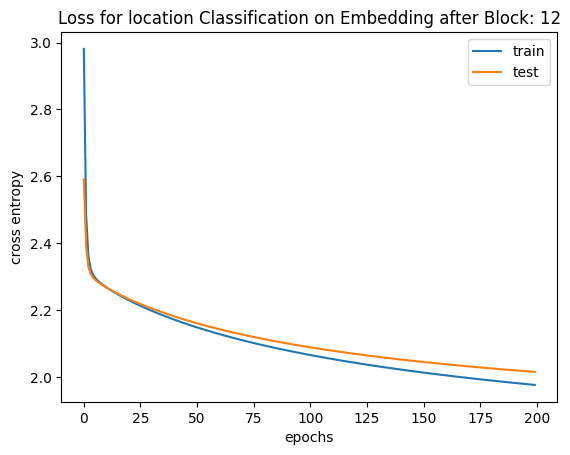

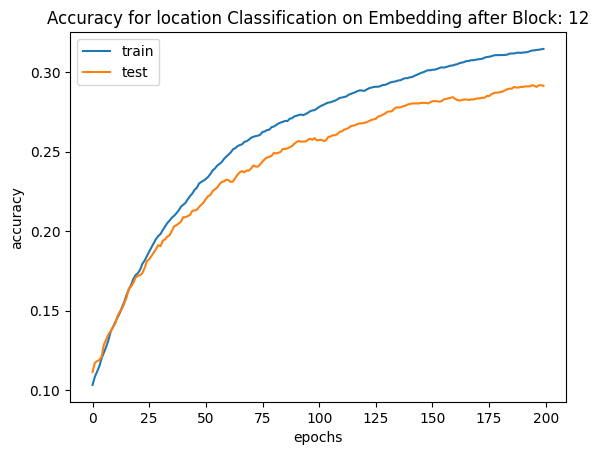

In [284]:
n_epochs = 200
batch_size = 64
batches_per_epoch = len(X_train) // batch_size

# Freeze the parameters of the rest of the model
for param in model.parameters():
    param.requires_grad = False

# # Allow the parameters of the final layer to be updated during training
for param in model.fc3.parameters():
    param.requires_grad = True
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of paramerters in the model are: {total_params}")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of paramerters being trained: ", total_trainable_params)

best_loss = np.inf  # Initialize to infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []

# Define the optimizer to update only the parameters of the final layer
# optimizer = torch.optim.SGD(model.layer3.parameters(), lr=0.001)

# Training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    
    # Set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # Take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start + batch_size].to(device)
            y_batch = y_train_tensor[start:start + batch_size].to(device)

            # Forward pass
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Update weights
            optimizer.step()

            # Compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))

    # Set model in evaluation mode and run through the test set
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for efficiency
        X_test_batch = X_Val_tensor.to(device)
        y_val_batch = y_val_tensor.to(device)
        y_pred = model(X_test_batch)
        ce = criterion(y_pred, y_val_batch)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val_batch, 1)).float().mean()

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)

    if ce < best_loss:
        best_loss = ce
        best_weights = copy.deepcopy(model.state_dict())

    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc * 100:.1f}%")

# Load the best weights and plot the results
model.load_state_dict(best_weights)

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.title(f"Loss for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.title(f"Accuracy for {run_mode} Classification on Embedding after Block: {Block_number}")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()


In [285]:
model.load_state_dict(best_weights)

<All keys matched successfully>

In [286]:
torch.save(model, fr'{folder_name}{run_mode}_{Block_number}.pth')


In [287]:
model=torch.load(fr'{folder_name}{run_mode}_{Block_number}.pth')
model.to(device)

SceneClassifier(
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [288]:
X_test=train_ready(test_data,col_name)

In [289]:
X_test_tensors = [torch.tensor(feature, dtype=torch.float32, device=device) for feature in X_test]

# Run inference and get predictions
y_pred = []
with torch.no_grad():
    for feature in X_test_tensors:
        output = model(feature.unsqueeze(0))
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
        y_pred.append(predicted_class)

df[col_name]=y_pred


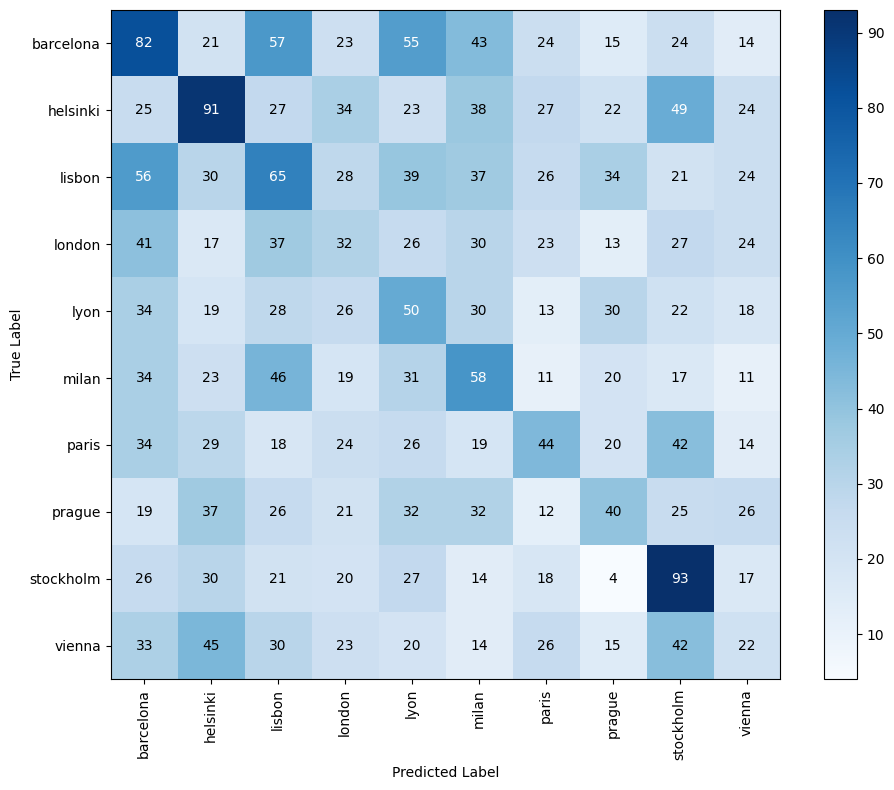

Accuracy: 0.1944


In [290]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
accuracy = accuracy_score(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical values to the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black")

plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy:.4f}")
acc_list.append(accuracy)
# loss_list.append()

In [291]:
df.to_csv(fr'{run_mode}_predictions.csv')

# Accuracy Plots of Block-by-Block

In [292]:
acc_list


[0.1320754716981132,
 0.17587601078167117,
 0.1637466307277628,
 0.1792452830188679,
 0.18429919137466308,
 0.20653638814016173,
 0.20518867924528303,
 0.21765498652291104,
 0.2068733153638814,
 0.20518867924528303,
 0.20316711590296496,
 0.19440700808625336]

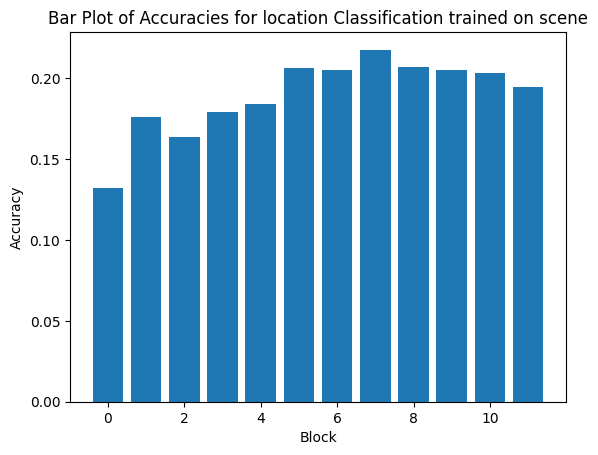

In [293]:
import matplotlib.pyplot as plt

# Example list of numbers
numbers = acc_list

# Create the plot
plt.bar(range(len(numbers)), numbers)

# Add labels and title
plt.xlabel('Block')
plt.ylabel('Accuracy')
plt.title('Bar Plot of Accuracies for location Classification trained on scene')

# Display the plot
plt.show()
